In [1]:
%env CUDA_VISIBLE_DEVICES=0

device='cuda'

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from copy import deepcopy
from tqdm import tqdm

from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras.optimizers import Adam, SGD

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

print(f"Torch: {torch.__version__}")

2024-03-22 13:49:27.248290: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 13:49:27.286573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 13:49:27.286597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 13:49:27.286620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 13:49:27.294206: I tensorflow/core/platform/cpu_feature_g

Torch: 2.1.0+cu121


In [3]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

In [4]:
FEATURES_DIR = "features/"
WEIGHTS_DIR = 'weights/'
WEIGHTS_DIR = 'weights_independent/'
USERS_DATASET = "/home/echuraev/Workspace/HSE/datasets/Engagement_dataset/"
USERS_FEATURES = USERS_DATASET + "features_max5_videos_old_split/"
USERS_WEIGHTS = USERS_DATASET + 'weights_max5_videos_old_split/'
TABLE_NAME = "User-adaptation_disbalanced_max_5_videos_old_split_with_averaging.xlsx"

In [5]:
BATCH_SIZE = 128
N_CLASSES = 2
IMAGE_SET_SIZE=70
USE_GENERATORS = False
USE_ALL_FEATURES = False
EPOCH_NUM = 20
LR = 1e-4

In [6]:
labels_list = ['engaged', 'distracted']
REVERSE_LABELS = True

In [7]:
VIDEO_COUNT = 16
#TEST_VIDEOS = 6
TEST_VIDEOS = 11
TRAIN_VIDEOS_COUNT = VIDEO_COUNT - TEST_VIDEOS
TEST_VIDEOS_COUNT = TEST_VIDEOS
print(TRAIN_VIDEOS_COUNT, TEST_VIDEOS_COUNT)

5 11


# Helpers

In [8]:
import pickle

def save_features(file_name, features):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    with open(file_name, 'wb') as f:
        pickle.dump(features, f) # , protocol=pickle.HIGHEST_PROTOCOL)
    
def load_features(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def save_weights(model, file_name):
    if os.path.isfile(file_name):
        print("Error! Cannot save features because file already exists")
        return
    model.save_weights(file_name)

def load_weights(model, file_name):
    model.load_weights(file_name)

In [9]:
def draw_confusion_matrix(all_preds, all_labels):
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sn

    all_labels = np.array(all_labels)
    all_pred = np.array(all_preds)
    data=confusion_matrix(all_labels, all_pred)

    df_cm = pd.DataFrame(data, columns=labels_list)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (13,10))
    sn.set(font_scale=3)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16*2.5}, fmt='g')# font size
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0, va="center")

In [10]:
def get_weights_path(metric_name):
    return USERS_WEIGHTS + "{}.h5".format(metric_name)
    
def get_metric_name(base_model_key, DATASET_NAME, aggregator, classificator, user_name, train_files):
    return "{}_{}_{}_{}_{}_{}".format(base_model_key, DATASET_NAME, aggregator, classificator, user_name, train_files)

def get_universal_weights_path(metric_name):
    return WEIGHTS_DIR + "{}.h5".format(metric_name)

def get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, aggregator, classificator):
    return "{}_{}_{}_{}_{}".format(base_model_key, DATASET_NAME, N_CLASSES, aggregator, classificator)

In [11]:
def get_samples(features_list, labels_list):
    X_subsample,y_subsample=[],[]
    for i in range(len(features_list)):
        features=features_list[i]
        label = labels_list[i]
        total_features=None
        if USE_ALL_FEATURES:
            x=features[0][features[-1]==1]
        else:
            x=features
        max_ind=len(x)-IMAGE_SET_SIZE
        if max_ind<=0:
            continue
        stat_x=stat_func(x,axis=0)
        num_samples=max(max_ind//(IMAGE_SET_SIZE),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((stat_x,x[frame_ind+i])) for i in range(IMAGE_SET_SIZE)]
            else:
                X_current=[x[frame_ind+i] for i in range(IMAGE_SET_SIZE)]
            X_subsample.append(X_current)
            y_subsample.append(label)
    
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

In [12]:
from tensorflow.keras.models import load_model,Model
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = self.model.get_weights()

In [13]:
if False:
    def get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES):
        inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
        e = Dense(1, activation='linear', name='e')(inputs)
        e = Reshape([-1], name='alignment')(e)
        alpha = Activation('softmax', name='alpha')(e)
        
        alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))
        
        c = Multiply(name='c')([inputs, alpha_repeated])
        x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)
        
        #x = Dropout(0.3)(x)
        x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
        #x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))
    
        pred=Dense(N_CLASSES,activation='softmax')(x)
        modelAtn=Model(inputs=inputs,outputs=pred)
        modelAtn.compile(optimizer=Adam(lr=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        #modelAtn.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        #modelAtn.compile(optimizer=Adam(learning_rate=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        modelAtn.summary()
    
        save_best_model = SaveBestModel('val_accuracy',True)
        return modelAtn, save_best_model

In [14]:
def f1_score_metric(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES):
    inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
    e = Dense(1, activation='linear', name='e')(inputs)
    e = Reshape([-1], name='alignment')(e)
    alpha = Activation('softmax', name='alpha')(e)
    
    alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))
    
    c = Multiply(name='c')([inputs, alpha_repeated])
    x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)
    
    #x = Dropout(0.3)(x)
    x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
    #x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

    METRICS = [
        # keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
        # keras.metrics.MeanSquaredError(name='Brier score'),
        # keras.metrics.TruePositives(name='tp'),
        # keras.metrics.FalsePositives(name='fp'),
        # keras.metrics.TrueNegatives(name='tn'),
        # keras.metrics.FalseNegatives(name='fn'), 
        # keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        # keras.metrics.AUC(name='auc'),
        # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        #keras.metrics.F1Score(name='f1'),
        f1_score_metric,
    ]

    
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(learning_rate=LR),
              loss='binary_crossentropy',
              metrics=[METRICS])
    modelAtn.summary()
    save_best_model = SaveBestModel('f1_score_metric',True)

    return modelAtn, save_best_model

In [15]:
if False:
    def get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES):
        embeddings_dim=512 #FEATURE_VECTOR_DIM
        inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
        if False:
            query_seq_encoding, value_seq_encoding=inputs,inputs
        else:
            query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
            value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
        query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])
        
        e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
        e = Reshape([-1], name='alignment')(e)
        alpha = Activation('softmax', name='alpha')(e)
        
        alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))
        
        c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
        x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)
        
        #x = Dropout(0.3)(x)
        #x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
        #x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))
        
        pred=Dense(N_CLASSES,activation='softmax')(x)  # (batch, classes)
        modelAtn=Model(inputs=inputs,outputs=pred)
        modelAtn.compile(optimizer=Adam(lr=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        modelAtn.summary()
    
        save_best_model = SaveBestModel('val_accuracy',True)
        return modelAtn, save_best_model

In [16]:
def f1_score_metric(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES):
    embeddings_dim=512 #FEATURE_VECTOR_DIM
    inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
    if False:
        query_seq_encoding, value_seq_encoding=inputs,inputs
    else:
        query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
        value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
    query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])
    
    e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
    e = Reshape([-1], name='alignment')(e)
    alpha = Activation('softmax', name='alpha')(e)
    
    alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))
    
    c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
    x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)
    
    #x = Dropout(0.3)(x)
    #x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
    #x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

    METRICS = [
        # keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
        # keras.metrics.MeanSquaredError(name='Brier score'),
        # keras.metrics.TruePositives(name='tp'),
        # keras.metrics.FalsePositives(name='fp'),
        # keras.metrics.TrueNegatives(name='tn'),
        # keras.metrics.FalseNegatives(name='fn'), 
        # keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        # keras.metrics.AUC(name='auc'),
        # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        #keras.metrics.F1Score(name='f1'),
        f1_score_metric,
    ]

    
    pred=Dense(1,activation='sigmoid')(x)
    modelAtn=Model(inputs=inputs,outputs=pred)
    modelAtn.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[METRICS])
    modelAtn.summary()
    save_best_model = SaveBestModel('f1_score_metric',True)
    return modelAtn, save_best_model

In [17]:
def get_prediction(model, features, threshold=0.5):
    y_pred = []
    for i in range(len(features)):
        x=features[i]
        #print(x.shape)
        if len(x)==0:
            continue
        if CONCATENATE_STAT:
            mean_x=np.repeat(stat_func(x,axis=0).reshape((1,-1)),len(x),axis=0)            
            #preds=model.predict(np.expand_dims(np.concatenate((mean_x,x-mean_x),axis=1), axis=0))[0]
            pred=model.predict(np.expand_dims(np.concatenate((mean_x,x),axis=1), axis=0), verbose=0)
        else:
            pred=model.predict(np.expand_dims(x, axis=0), verbose=0)
        #y_pred.append(np.argmax(pred))
        pred = pred[0][0]
        if pred < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
    return y_pred

def _to_str(num, num_comma):
    if num_comma == ",":
        return str(num).replace(".", ",")
    return str(num).replace(",", ".")

def dump_to_table(table_name, metric_name, acc, mse, uar, recall, precision, f1, num_comma=","):
    import pandas as pd
    if os.path.isfile(table_name):
        df = pd.read_excel(open(table_name,'rb'))
    else:
        df = pd.DataFrame(columns=['metric_name', 'accuracy', 'mse', 'uar', 'recall', 'precision', 'f1'])

    idx = len(df)
    # Remove previous recordings
    df = df[df.metric_name != metric_name]
    df.loc[idx] = [
        metric_name,
        _to_str(acc, num_comma),
        _to_str(mse, num_comma),
        _to_str(uar, num_comma),
        _to_str(recall, num_comma),
        _to_str(precision, num_comma), 
        _to_str(f1, num_comma)
    ] 
    df.to_excel(table_name, index=False)

def dump_to_table(table_name, lines, num_comma=","):
    import pandas as pd
    line_num = 0
    if os.path.isfile(table_name):
        df = pd.read_excel(open(table_name,'rb'))
    else:
        df = pd.DataFrame(columns=lines[0])
        line_num += 1
    idx = len(df)
    for i in range(line_num, len(lines)):
        df.loc[idx] = lines[i]
        idx += 1
    df.to_excel(table_name, index=False)

def print_results(pred, labels, print_info=True, table_name=None, metric_name=None):
    pred = np.array(pred)
    labels = np.array(labels)
    acc = (labels==pred).mean()
    if N_CLASSES == 2:
        mse = ((labels-pred)**2).mean()
    else:
        mse = ((labels_float-pred_float)**2).mean()
    uar = recall_score(y_true=labels,y_pred=pred, average='macro')
    if N_CLASSES == 2:
        recall = recall_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
        precision = precision_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
        f1 = f1_score(y_true=labels,y_pred=pred, average='binary',pos_label=1)
    else:
        recall = 'N/A'
        precision = 'N/A'
        f1 = f1_score(y_true=labels,y_pred=pred, average='macro')
    if print_info:
        print('Metric_name: ', metric_name,
              'Accuracy: ', acc,
              'MSE: ', mse,
              'UAR: ', uar,
              'Recall: ', recall,
              'Precision: ', precision,
              'F1: ', f1)
    if table_name is not None and metric_name is not None:
        dump_to_table(table_name, metric_name, acc, mse, uar, recall, precision, f1)
    return acc, mse, uar, recall, precision, f1

In [18]:
def compute_descriptor(cur_features, axis):
    #cur_features=cur_features[1000:]
    #cur_features=cur_features[30:-30]
    #mean_features=features.mean(axis=0)
    mean_features = np.mean(cur_features, axis=0)
    std_features = np.std(cur_features, axis=0)
    max_features = np.max(cur_features, axis=0)
    min_features = np.min(cur_features, axis=0)

    # join several features together
    #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
    #feature = np.concatenate((mean_features, std_features, max_features), axis=None)
    #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
    feature = np.concatenate((mean_features, std_features), axis=None)
    #feature = np.concatenate((max_features, std_features), axis=None)

    #feature=std_features
    #feature=mean_features
    #feature=np.percentile(cur_features, 100,axis=0)
    return feature

In [19]:
def load_features_from_pickle(engaged_pickle, distracted_pickle, result_pickle, keys_pickle):
    def _get_label(label):
        if REVERSE_LABELS is True:
            labels_dict = {0: 1, 1: 0}
            return labels_dict[label]
        return label
        
    import re

    if os.path.isfile(result_pickle):
        return load_features(result_pickle)
    
    eng_vid2features = load_features(engaged_pickle)
    dis_vid2features = load_features(distracted_pickle)

    # Shuffle keys
    if os.path.isfile(keys_pickle):
        eng_keys, dis_keys = load_features(keys_pickle)
    else:
        random.seed(7)
        eng_keys = list(eng_vid2features.keys())
        dis_keys = list(dis_vid2features.keys())
        random.shuffle(eng_keys)
        random.shuffle(dis_keys)
        save_features(keys_pickle, [eng_keys, dis_keys])

    # Extract all names
    names_set = set()
    for k in eng_vid2features.keys():
        names_set.add(re.split(" |_", k)[0])
    names = list(names_set)
    
    # Separate Test set
    train_vid2features = {}
    test_vid2features = {}
    for name in names:
        test_num = 0
        train_vid2features[name] = {'features': [], 'labels': []}
        test_vid2features[name] = {'features': [], 'labels': []}
        for k in eng_keys:
            if not k.startswith(name):
                continue
            if test_num >= TEST_VIDEOS:
                train_vid2features[name]['features'].append(eng_vid2features[k]['features'])
                train_vid2features[name]['labels'].append(_get_label(eng_vid2features[k]['label']))
            else:
                test_vid2features[name]['features'].append(eng_vid2features[k]['features'])
                test_vid2features[name]['labels'].append(_get_label(eng_vid2features[k]['label']))
                test_num +=1

        test_num = 0
        for k in dis_keys:
            if not k.startswith(name):
                continue
            if test_num >= TEST_VIDEOS:
                train_vid2features[name]['features'].append(dis_vid2features[k]['features'])
                train_vid2features[name]['labels'].append(_get_label(dis_vid2features[k]['label']))
            else:
                test_vid2features[name]['features'].append(dis_vid2features[k]['features'])
                test_vid2features[name]['labels'].append(_get_label(dis_vid2features[k]['label']))
                test_num +=1

    save_features(result_pickle, [train_vid2features, test_vid2features])

    return train_vid2features, test_vid2features
    

In [20]:
def take_to_sets(train_videos_count, all_train_vid2features):
    train_vid2features = {}
    eng_label = 0 if REVERSE_LABELS is True else 1
    for name in all_train_vid2features.keys():
        train_vid2features[name] = {'features': [], 'labels': []}
        added_eng = 0
        added_dis = 0
        for i in range(len(all_train_vid2features[name]['labels'])):
            label = all_train_vid2features[name]['labels'][i]
            features = all_train_vid2features[name]['features'][i]
            if label == eng_label and added_eng < train_videos_count:
                train_vid2features[name]['features'].append(features)
                train_vid2features[name]['labels'].append(label)
                added_eng += 1
            elif label != eng_label and added_dis < train_videos_count:
                train_vid2features[name]['features'].append(features)
                train_vid2features[name]['labels'].append(label)
                added_dis += 1
            if added_eng == train_videos_count and added_dis == train_videos_count:
                break
    return train_vid2features

In [21]:
lines = []
header = ['metric_name'] + [str(i) for i in range(TRAIN_VIDEOS_COUNT + 1)]
lines.append(header)
dump_to_table(TABLE_NAME, lines)

In [22]:
def result_agg_dict2lines(results_agg):
    columns = len(list(results_agg.keys()))
    lines = []
    for i in range(len(results_agg['metric_name'])):
        line = [results_agg['metric_name'][i]]
        for c in range(columns - 1):
            line.append(results_agg[str(c)][i])
        lines.append(line)
    return lines

In [23]:
def _get_label(label):
    if REVERSE_LABELS is True:
        labels_dict = {0: 1, 1: 0}
        return labels_dict[label]
    return label

In [24]:
def remove_empty_features(features, labels):
    res_features = []
    res_labels = []
    for i in range(len(features)):
        if len(features[i]) == 0:
            continue
        res_features.append(features[i])
        res_labels.append(labels[i])
    return res_features, res_labels

## Old helpers

In [25]:
def prepare_vid2features_keys(vid2features):
    random.seed(7)
    keys = list(vid2features.keys())
    random.shuffle(keys)
    return keys

def prepare_vid2features_list(eng_vid2features, dis_vid2features):
    vid2features = eng_vid2features.copy()
    vid2features.update(dis_vid2features)
    keys_pickle = USERS_DATASET + 'vid2features_keys.pickle'
    if os.path.isfile(keys_pickle):
        keys = load_features(keys_pickle)
    else:
        print("Prepare vid2features_keys")
        keys = prepare_vid2features_keys(vid2features)
        save_features(keys_pickle, keys)
    vid2features_list = []
    for k in keys:
        vid2features_list.append({'key': k, 'val': vid2features[k]})
    return vid2features_list

In [26]:
import re

def split_to_sets(train_videos_count, vid2features_list):
    train_vid2features = {}
    test_vid2features = {}
    names_pickle = USERS_DATASET + 'vid2features_names.pickle'
    if os.path.isfile(names_pickle):
        names = load_features(names_pickle)
    else:
        print("Prepare vid2features_names")
        names_set = set()
        for l in vid2features_list:
            names_set.add(re.split(" |_", l['key'])[0])
        names = list(names_set)
        save_features(names_pickle, names)
    for name in names:
        train_vid2features[name] = {'features': [], 'labels': []}
        test_vid2features[name] = {'features': [], 'labels': []}
        added_train_labels = {0: 0, 1: 0}
        added_test_labels = {0: 0, 1: 0}
        for l in vid2features_list:
            if not l['key'].startswith(name):
                continue
            label = l['val']['label']
            features = l['val']['features']
            if added_train_labels[label] < train_videos_count:
                added_train_labels[label] += 1
                train_vid2features[name]['features'].append(features)
                train_vid2features[name]['labels'].append(label)
            elif added_test_labels[label] < TEST_VIDEOS_COUNT:
                added_test_labels[label] += 1
                test_vid2features[name]['features'].append(features)
                test_vid2features[name]['labels'].append(label)
    return train_vid2features, test_vid2features

# User adaptation DAiSEE

In [27]:
DATASET_NAME = 'DAiSEE'

## enet_b0_8_best_afew

In [28]:
base_model_key = 'enet_b0_8_best_afew.pt'

In [29]:
FEATURE_VECTOR_DIM = 2560
STAT_FEATURE_VECTOR_DIM = 3840
FEATURE_VECTOR_DIM_CONCAT_FALSE = int(FEATURE_VECTOR_DIM / 2)
STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE = FEATURE_VECTOR_DIM_CONCAT_FALSE

In [ ]:
if False:
    engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
    distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
    train_test_pickle = USERS_FEATURES + '{}_train_test_features_{}.pickle'.format(base_model_key, TEST_VIDEOS)
    keys_pickle = USERS_FEATURES + 'shuffled_keys.pickle'
    
    all_train_vid2features, test_vid2features = load_features_from_pickle(engaged_pickle, distracted_pickle, train_test_pickle, keys_pickle)
    for name in all_train_vid2features.keys():
        all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'] = remove_empty_features(all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'])
    for name in test_vid2features.keys():
        test_vid2features[name]['features'], test_vid2features[name]['labels'] = remove_empty_features(test_vid2features[name]['features'], test_vid2features[name]['labels'])

In [30]:
if True:
    engaged_pickle = USERS_DATASET + 'features/engaged_features_{}.good.pickle'.format(base_model_key)
    distracted_pickle = USERS_DATASET + 'features/distracted_features_{}.good.pickle'.format(base_model_key)
    eng_vid2features = load_features(engaged_pickle)
    dis_vid2features = load_features(distracted_pickle)
    vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)
    
    train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)
    all_train_vid2features = train_vid2features
    
    if REVERSE_LABELS:
        for name in train_vid2features.keys():
            labels = train_vid2features[name]['labels']
            train_vid2features[name]['labels'] = [_get_label(l) for l in labels]
    
        for name in test_vid2features.keys():
            labels = test_vid2features[name]['labels']
            test_vid2features[name]['labels'] = [_get_label(l) for l in labels]

### Max

In [31]:
stat_func=np.max
stat_name = "max"

#### Single attention

In [32]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [33]:
train_vid2features = all_train_vid2features

In [34]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [35]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

2024-03-21 13:30:29.381828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38319 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:11:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

##### Universal model

In [36]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_max_single_attention_best


In [37]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [38]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Yana_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.8181818181818182 Precision:  0.5 F1:  0.6206896551724137
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.8181818181818182 Precision:  0.75 F1:  0.7826086956521738
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Den : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_att

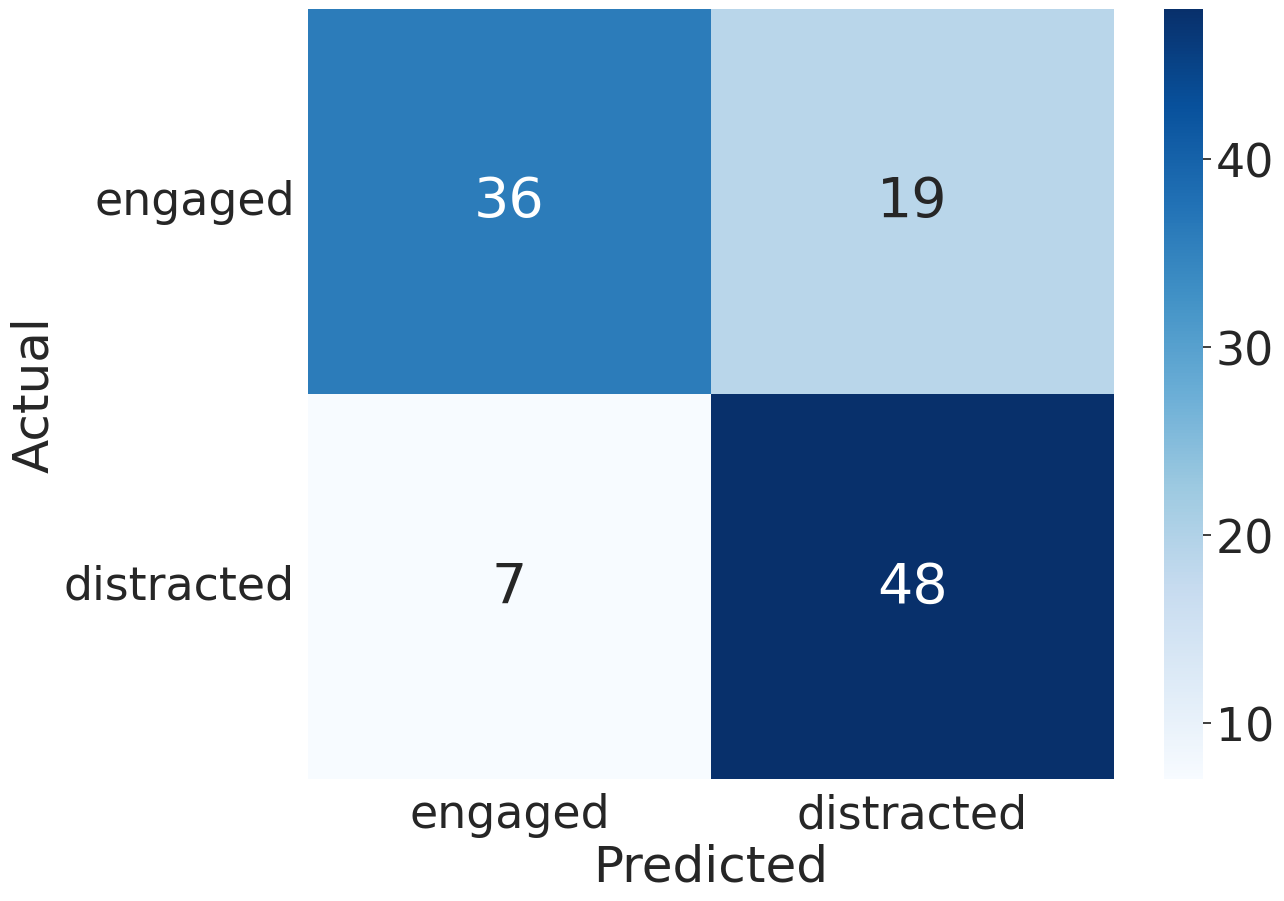

In [39]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [40]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)


2024-03-21 13:30:51.783011: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3c362680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 13:30:51.783232: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-21 13:30:51.790000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-21 13:30:51.832185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-03-21 13:30:51.901367: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Den


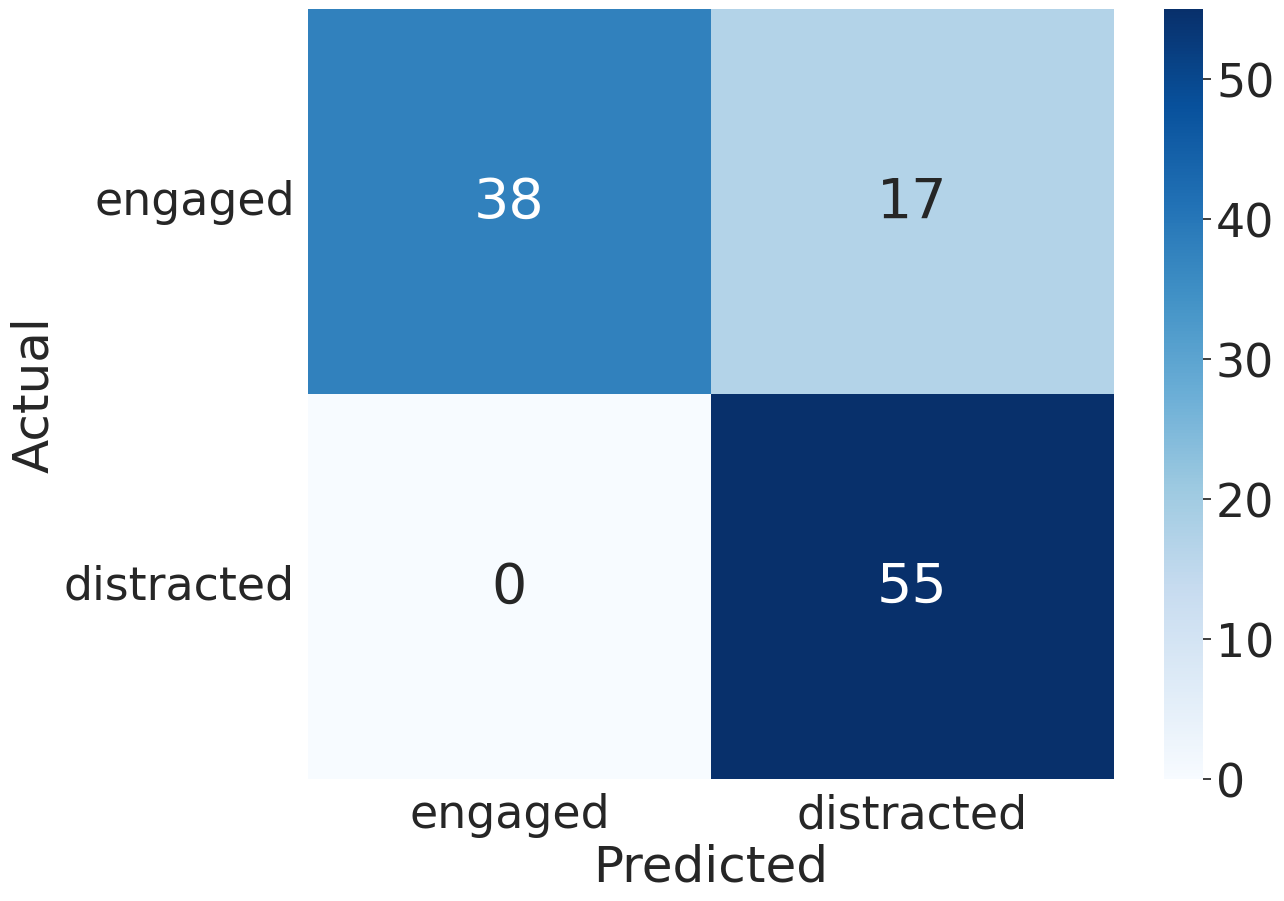

In [41]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [42]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
		Actor Kate
(2, 70, 2560) (2,)
		Actor Egor
(2, 70, 2560) (2,)
		Actor Katya
(2, 70, 2560) (2,)
		Actor Den
(2, 70, 2560) (2,)
	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 0.9454545454545455, Precision: 0.8326515151515151, F1: 0.8784011479663653
Videos num:  2
		Actor Yana
(4, 70, 2560) (4,)
		Actor Kate
(4, 70, 2560) (4,)
		Actor Egor
(4, 70, 2560) (4,)
		Actor Katya
(4, 70, 2560) (4,)
		Actor Den
(4, 70, 2560) (4,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 1.0, Precision: 0.8275641025641025, F1: 0.9005636070853462
Videos num:  3
		Actor Yana
(6, 70, 2560) (6,)
		Actor Kate
(6, 70, 2560) (6,)
		Actor Egor
(6, 70, 2560) (6,)
		Actor Katya
(6, 70, 2560) (6,)
		Actor Den
(6, 70, 2560) (6,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 1.0, Precision: 0.8275641025641025, F1: 0.90056360708

In [43]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [44]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [45]:
train_vid2features = all_train_vid2features

In [46]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [47]:
train_vid2features = all_train_vid2features

In [48]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [49]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_max_self_attention_best


In [50]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [51]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Katya_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.18181818181818182 Precision:  0.6666666666666666 F1:  0.28571428571428575
Den : 22
Met

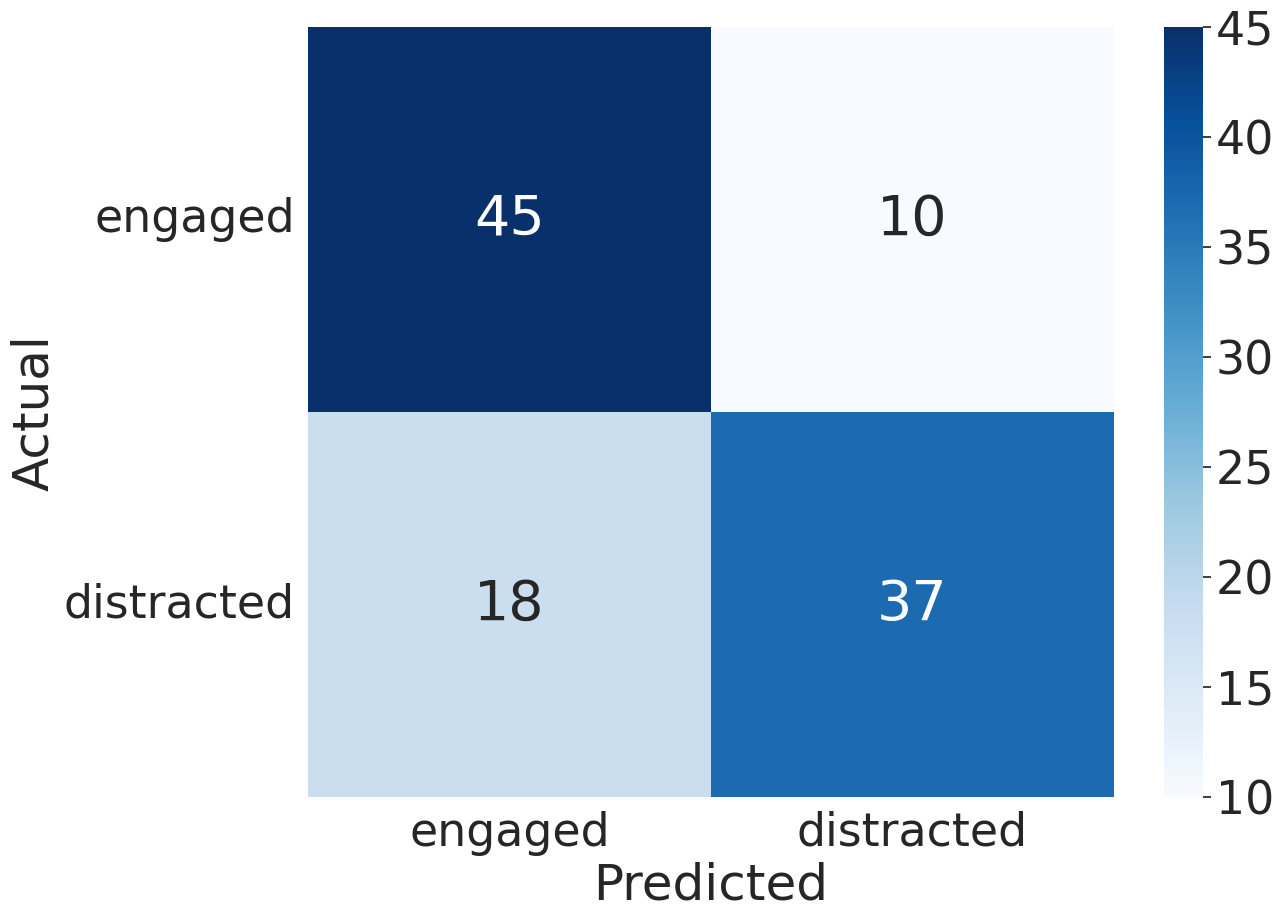

In [52]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [53]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Egor_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333

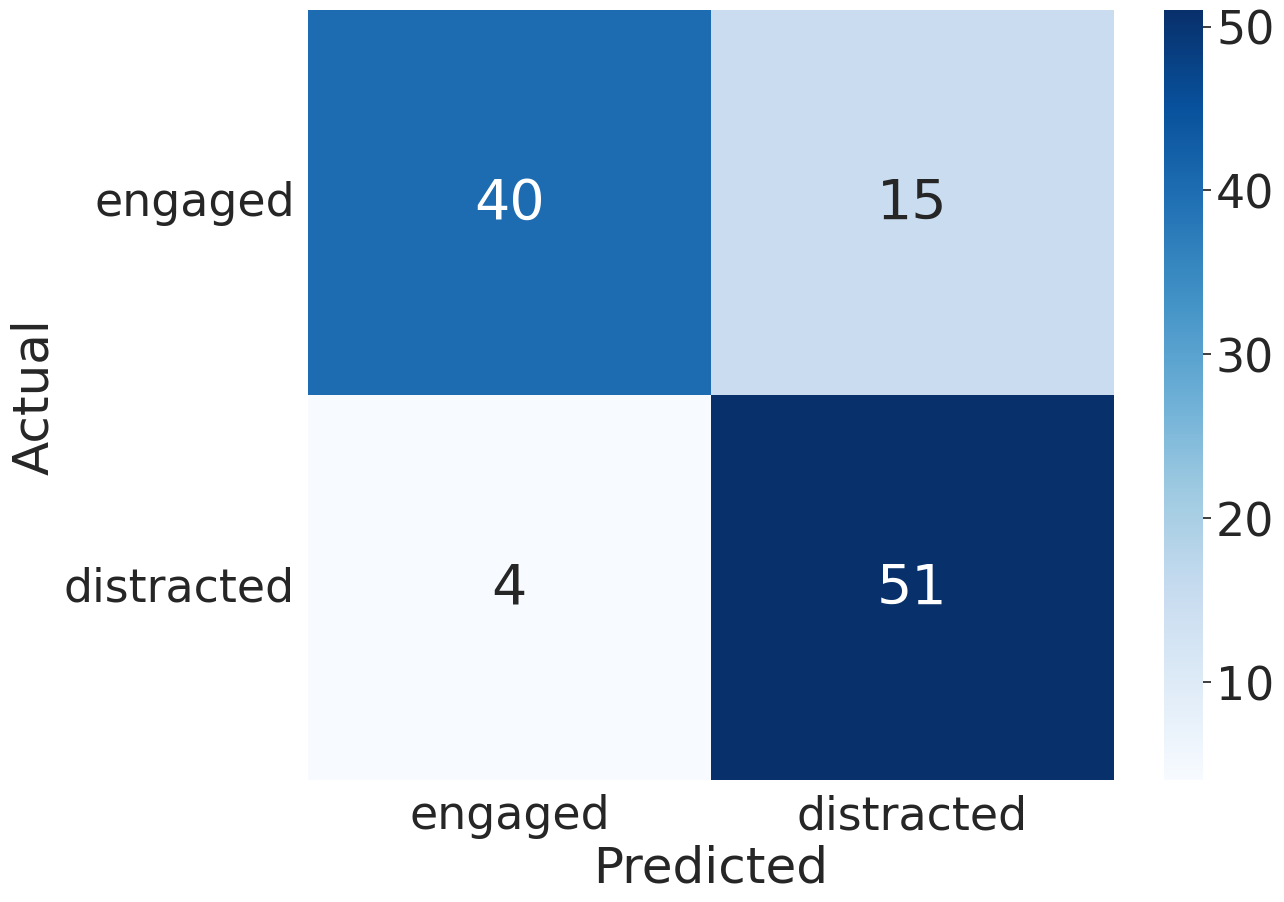

In [54]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [55]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 1.4089 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.9193 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5265 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2881 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1827 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1279 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0866 - precision: 1.0000 - recall: 1.000

In [56]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [57]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [58]:
train_vid2features = all_train_vid2features

In [59]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [60]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [61]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_max_single_attention_concat_false_best


In [62]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [63]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Yana_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.9090909090909091 Precision:  0.5263157894736842 F1:  0.6666666666666666
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Katya_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.909090909

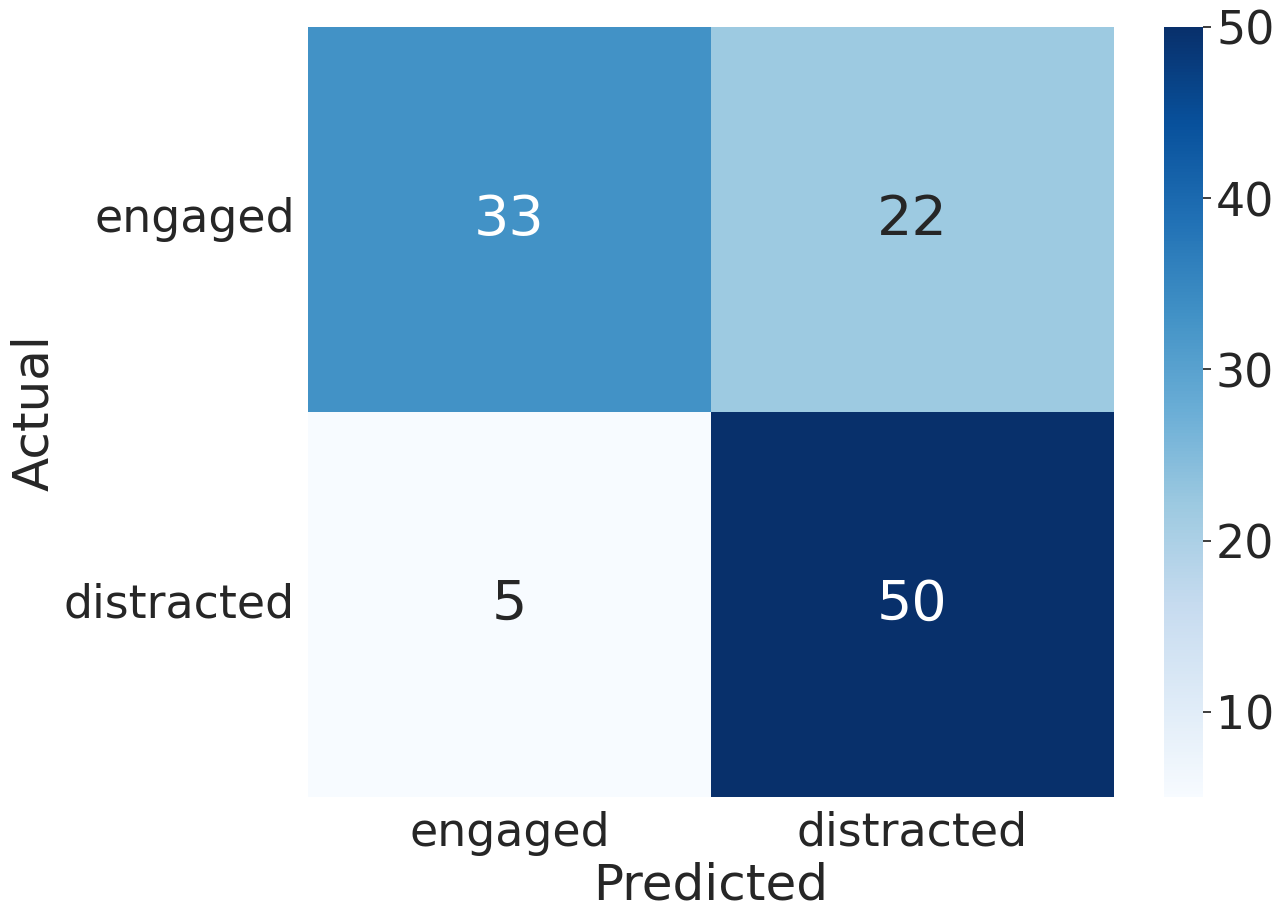

In [64]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [65]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_single_attention_concat_false_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.

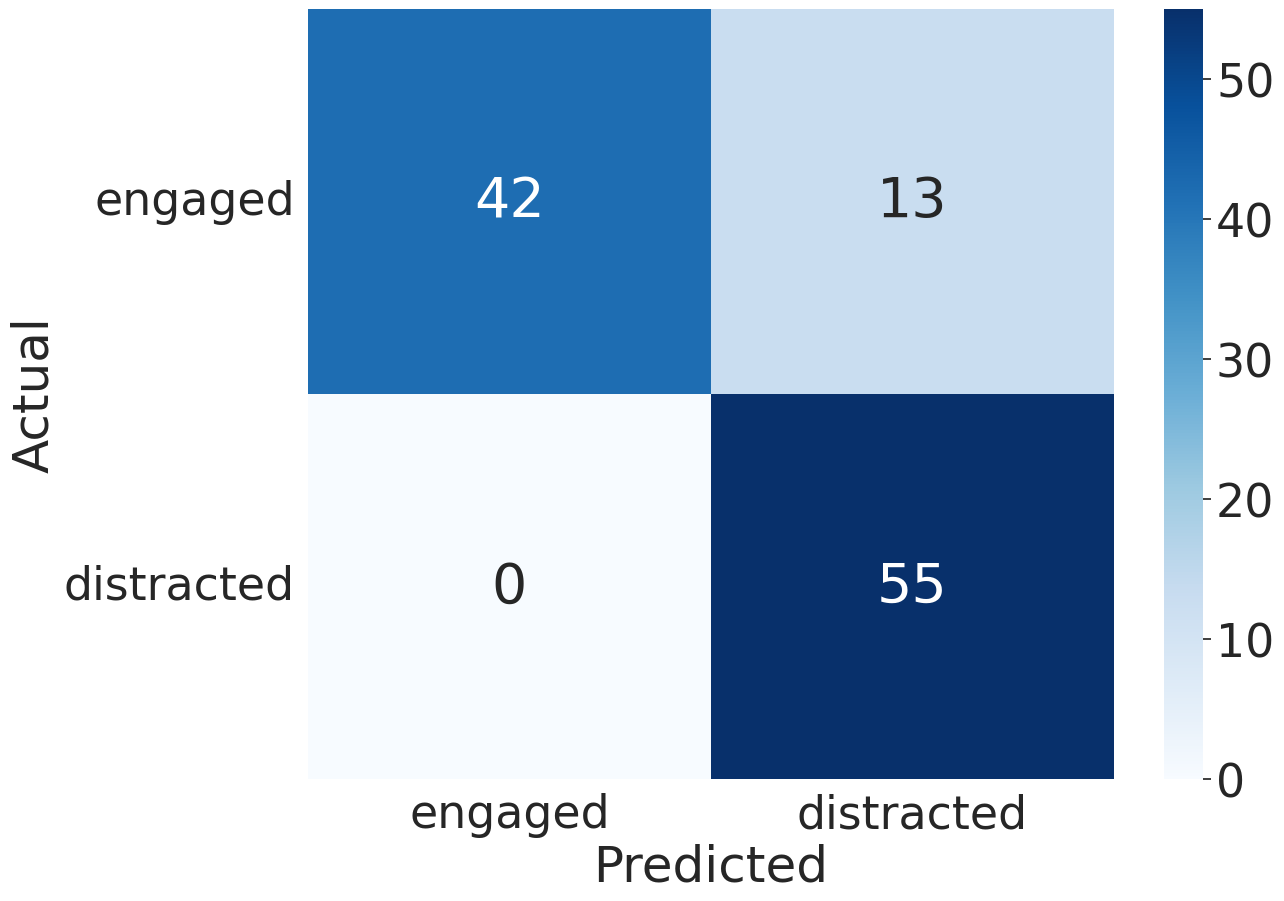

In [66]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [67]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.9545454545454547, MSE: 0.045454545454545456, UAR: 0.9545454545454545, Recall: 0.9818181818181818, Precision: 0.9466666666666667, F1: 0.9597069597069596
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.9181818181818182, MSE: 0.08181818181818182, UAR: 0.9181818181818182, Recall: 1.0, Precision: 0.8841666666666667, F1: 0.9321937321937321
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 1.0, Precision: 0.8367307692307693, F1: 0.9068314133

In [68]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [69]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [70]:
train_vid2features = all_train_vid2features

In [71]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [72]:
train_vid2features = all_train_vid2features

In [73]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_1 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [74]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_max_self_attention_concat_false_best


In [75]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [76]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Egor_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.428571428

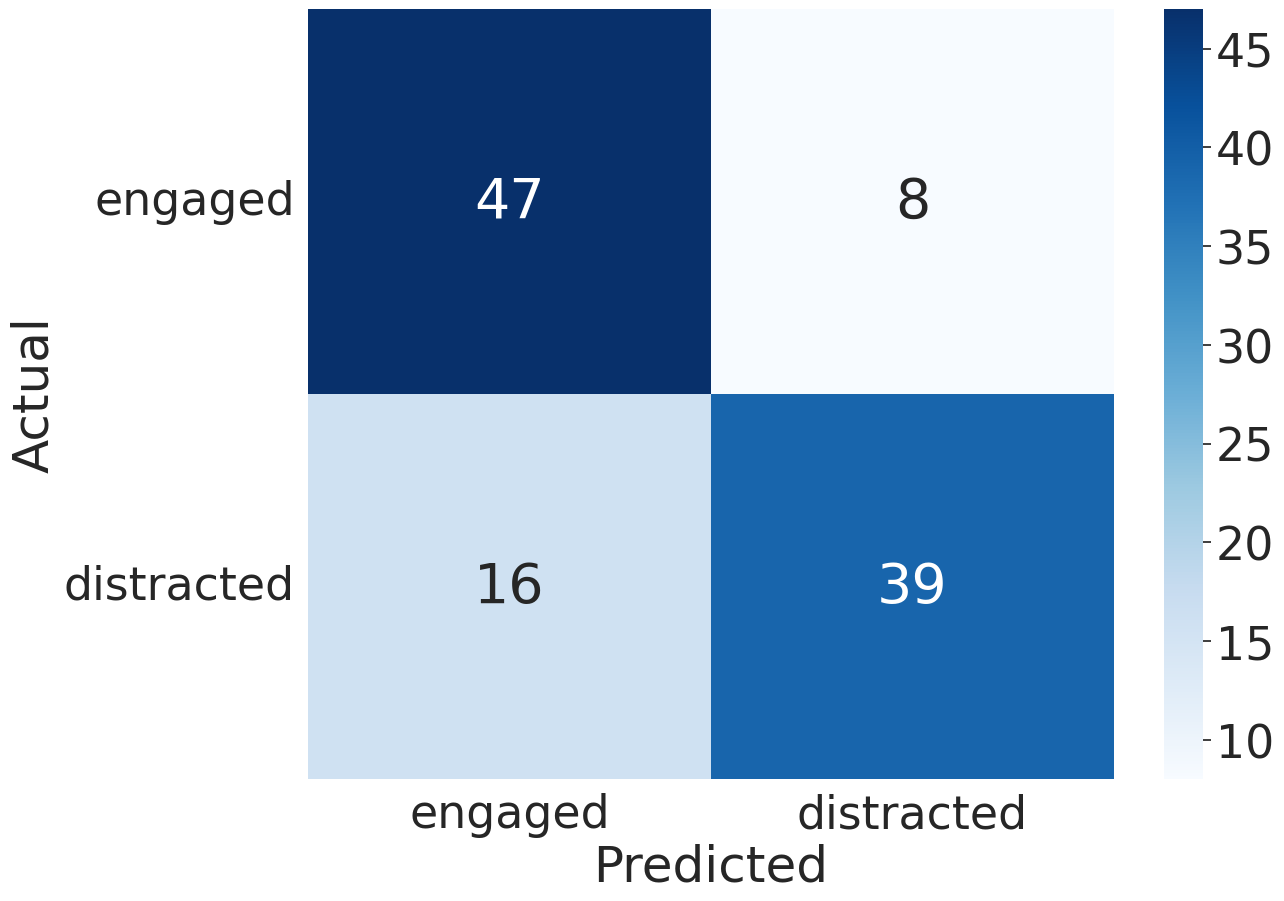

In [77]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [78]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Egor_adapted Accuracy:  1.0 MSE:  0.0 UAR:  1.0 Recall:  1.0 Precision:  1.0 F1:  1.0
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_max_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153

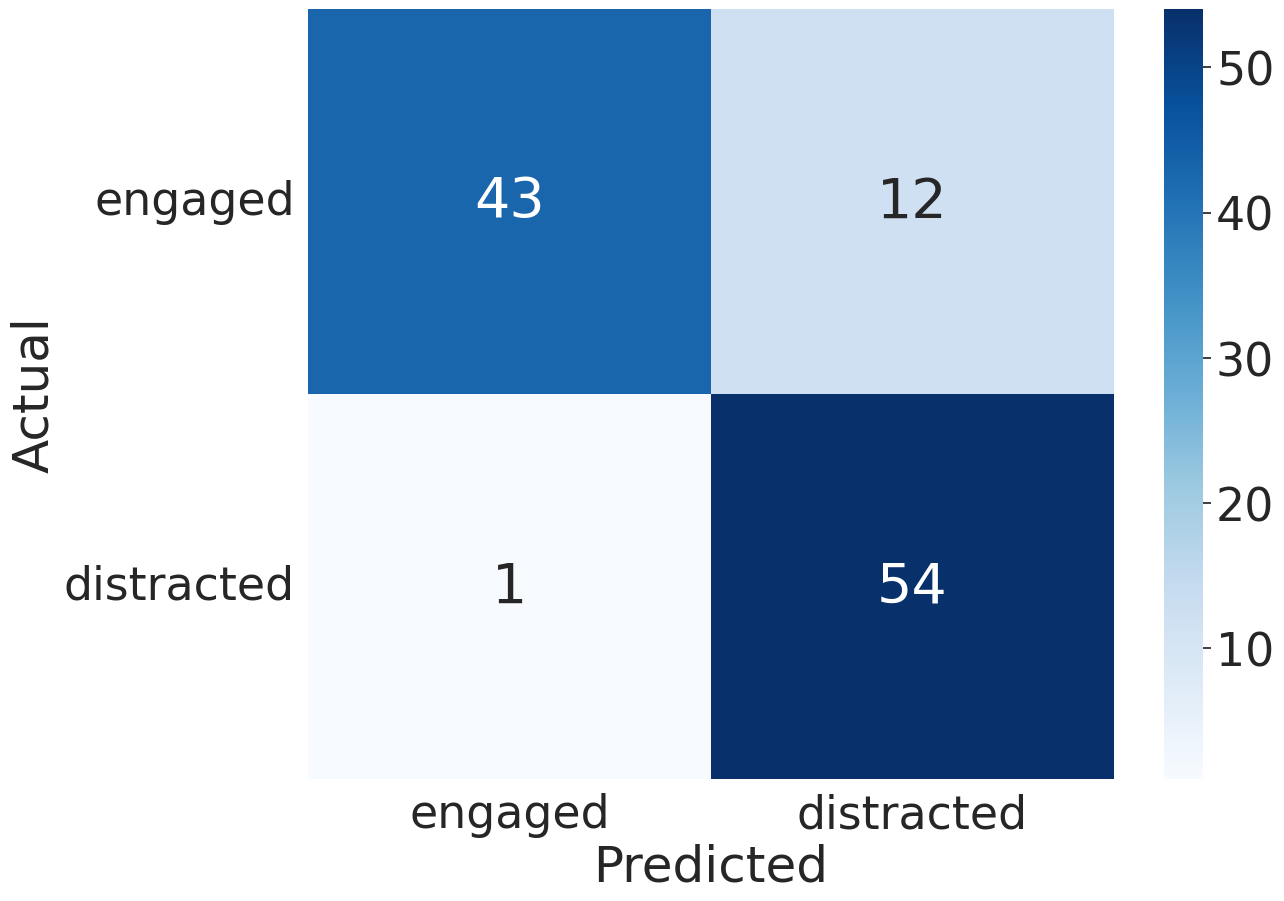

In [79]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [80]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7755 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.6188 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.4383 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3060 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2218 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.1671 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 9ms/step - loss: 0.1299 - precision: 1.0000 - recall: 1.000

In [81]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### Std

In [82]:
stat_func=np.std
stat_name = "std"

#### Single attention

In [83]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [84]:
train_vid2features = all_train_vid2features

In [85]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [86]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [87]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_std_single_attention_best


In [88]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [89]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Yana_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.9090909090909091 Precision:  0.5263157894736842 F1:  0.6666666666666666
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.8181818181818182 Precision:  0.75 F1:  0.7826086956521738
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Den : 

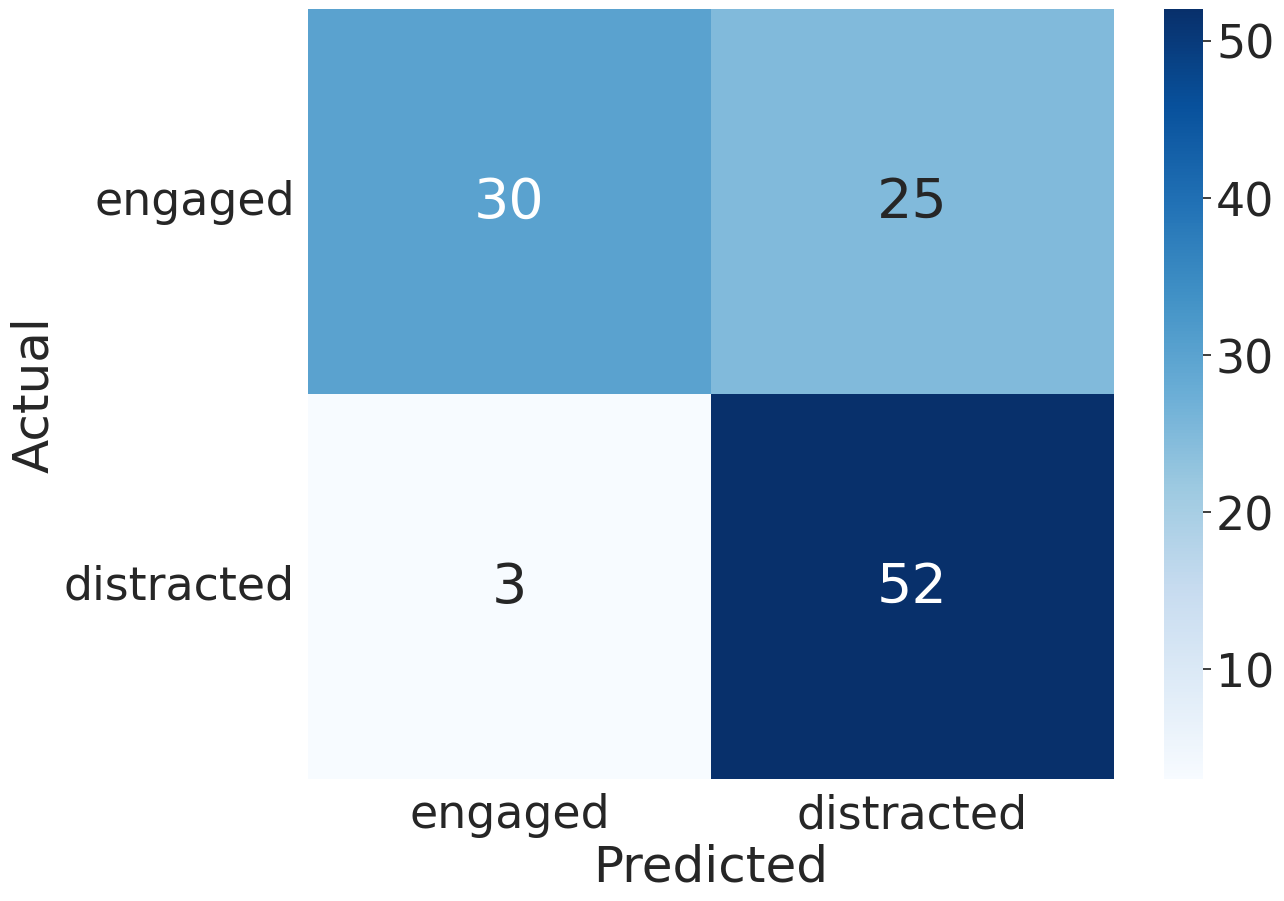

In [90]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [91]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Kate_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Egor_adapted Accuracy:  1.0 MSE:  0.0 UAR:  1.0 Recall:  1.0 Precision:  1.0 F1:  1.0
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Den
(10, 70, 2560) (10,)
M

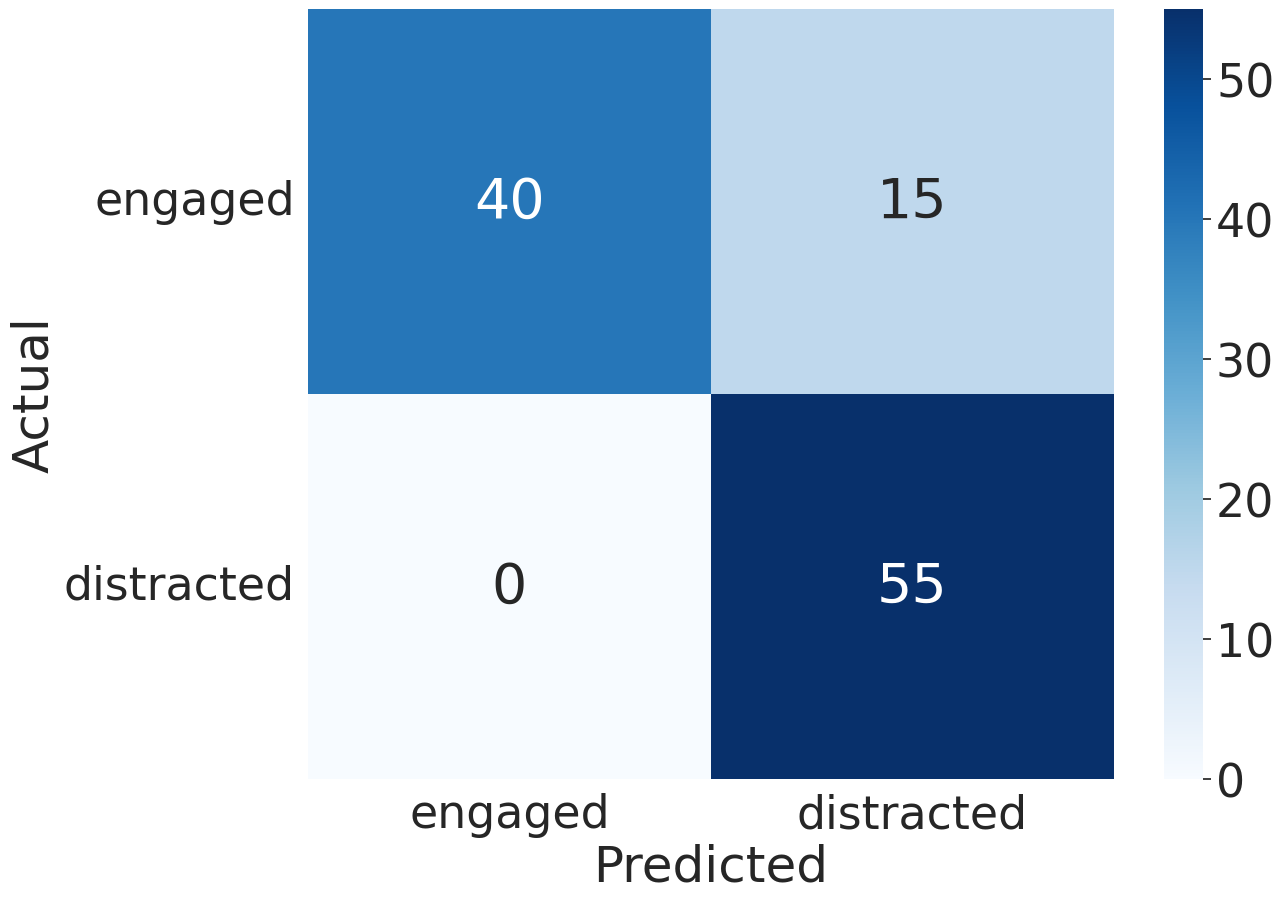

In [92]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [93]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
		Actor Kate
(2, 70, 2560) (2,)
		Actor Egor
(2, 70, 2560) (2,)
		Actor Katya
(2, 70, 2560) (2,)
		Actor Den
(2, 70, 2560) (2,)
	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181821, Recall: 0.9636363636363636, Precision: 0.8397069597069597, F1: 0.892953336518554
Videos num:  2
		Actor Yana
(4, 70, 2560) (4,)
		Actor Kate
(4, 70, 2560) (4,)
		Actor Egor
(4, 70, 2560) (4,)
		Actor Katya
(4, 70, 2560) (4,)
		Actor Den
(4, 70, 2560) (4,)
	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 1.0, Precision: 0.805, F1: 0.886461042982782
Videos num:  3
		Actor Yana
(6, 70, 2560) (6,)
		Actor Kate
(6, 70, 2560) (6,)
		Actor Egor
(6, 70, 2560) (6,)
		Actor Katya
(6, 70, 2560) (6,)
		Actor Den
(6, 70, 2560) (6,)
	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 1.0, Precision: 0.8013736263736263, F1: 0.8852592592592593
Videos 

In [94]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [95]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [96]:
train_vid2features = all_train_vid2features

In [97]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [98]:
train_vid2features = all_train_vid2features

In [99]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_2 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [100]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_std_self_attention_best


In [101]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [102]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.9090909090909091 Precision:  0.5882352941176471 F1:  0.7142857142857143
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Katya_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.45454545454545453 Precision:  0.8333333333333334 F1:  0.5882352941176471


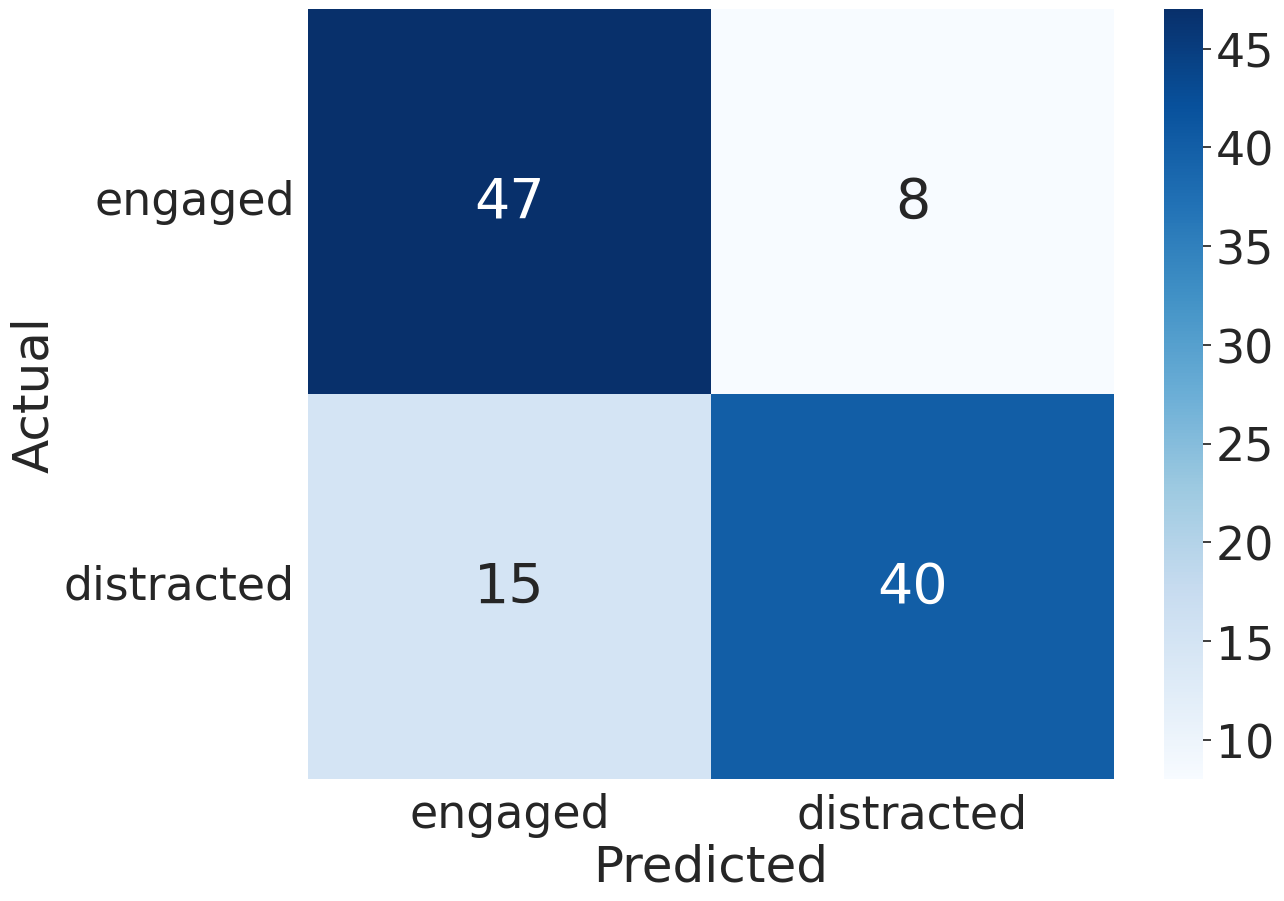

In [103]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [104]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Yana_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_best_Katya_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F

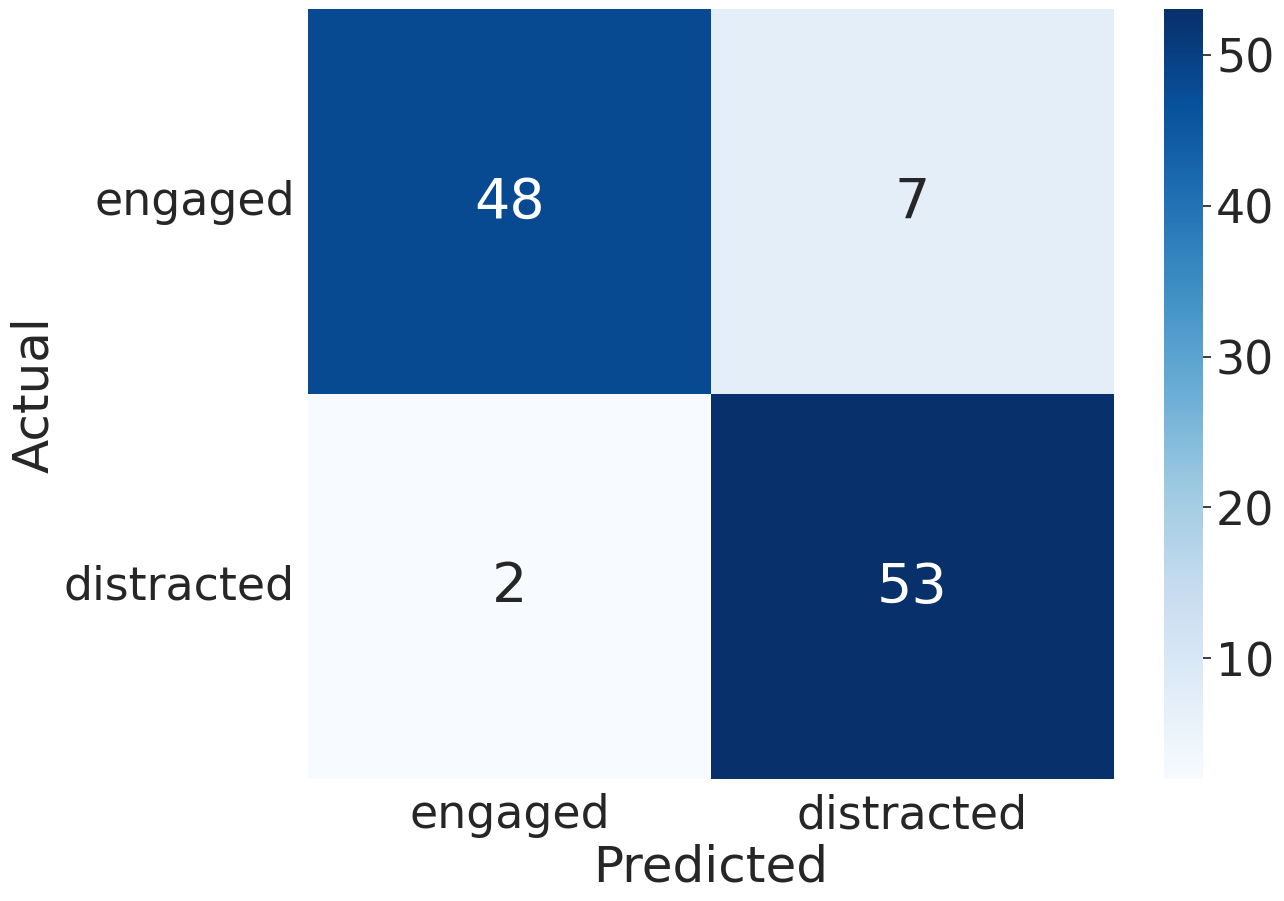

In [105]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [106]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8659 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.7441 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5690 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.3986 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2734 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1993 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1573 - precision: 1.0000 - recall: 1.000

In [107]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [108]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [109]:
train_vid2features = all_train_vid2features

In [110]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [111]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [112]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_std_single_attention_concat_false_best


In [113]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [114]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Yana_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.9090909090909091 Precision:  0.5 F1:  0.6451612903225806
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Katya_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Den : 22
Metric_

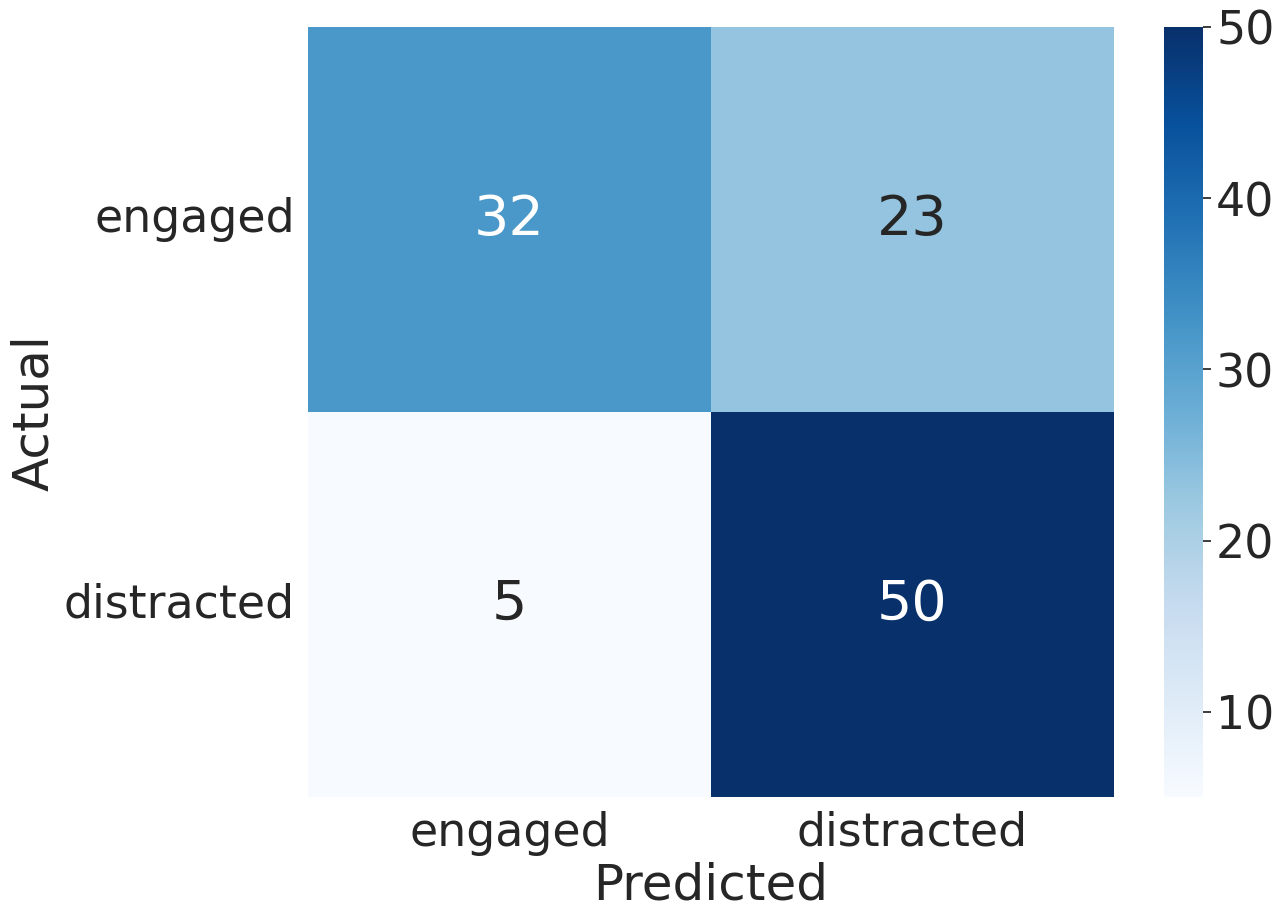

In [115]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [116]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Egor_adapted Accuracy:  1.0 MSE:  0.0 UAR:  1.0 Recall:  1.0 Precision:  1.0 F1:  1.0
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_single_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.916666666

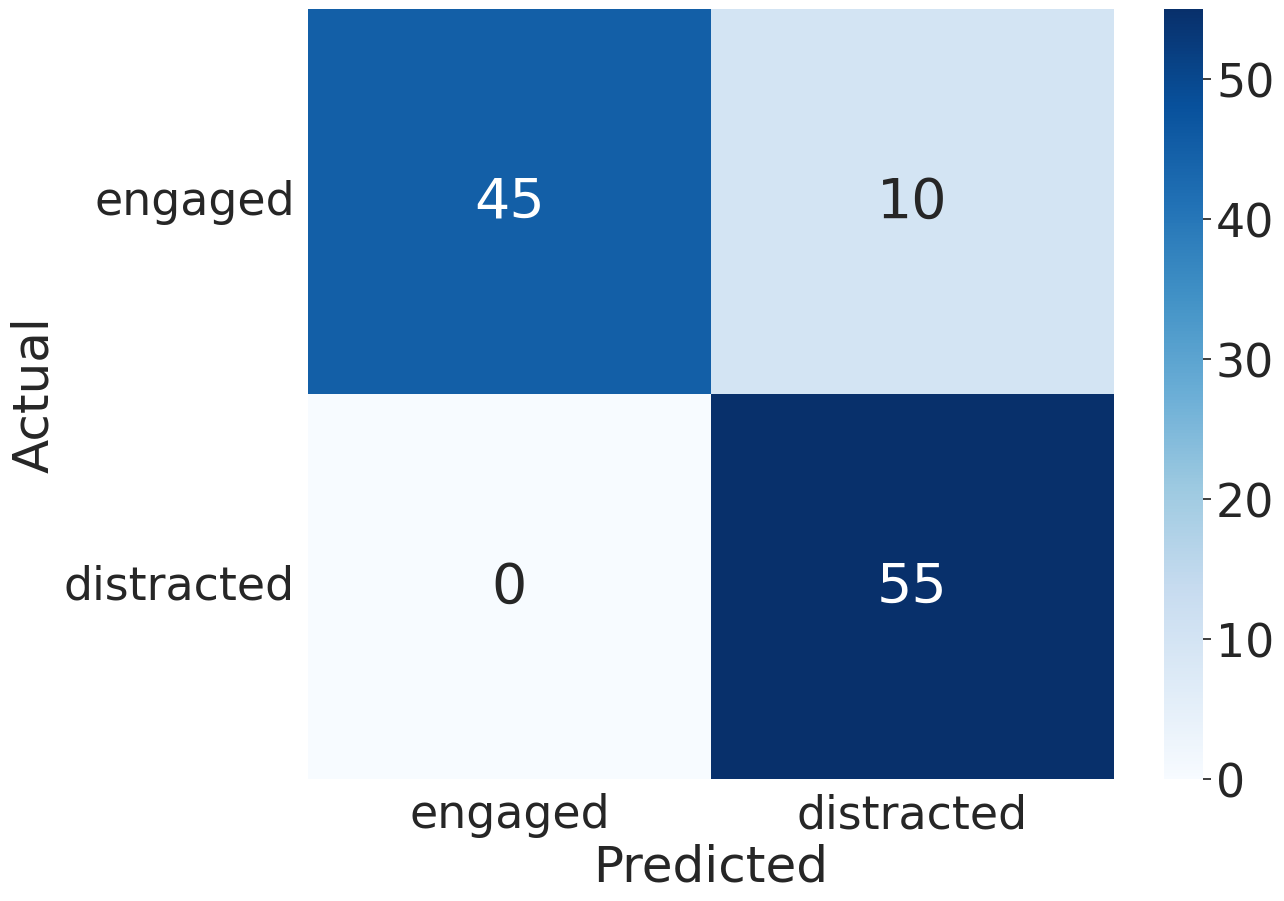

In [117]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [118]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.9363636363636363, MSE: 0.06363636363636364, UAR: 0.9363636363636363, Recall: 0.9636363636363636, Precision: 0.93, F1: 0.9414874980092371
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.9272727272727274, MSE: 0.07272727272727272, UAR: 0.9272727272727274, Recall: 1.0, Precision: 0.8933333333333333, F1: 0.9384615384615383
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.9181818181818183, MSE: 0.08181818181818182, UAR: 0.9181818181818183, Recall: 1.0, Precision: 0.8779761904761905, F1: 0.9302673107890499
Videos

In [119]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [120]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [121]:
train_vid2features = all_train_vid2features

In [122]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [123]:
train_vid2features = all_train_vid2features

In [124]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_3 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [125]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_std_self_attention_concat_false_best


In [126]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [127]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.9090909090909091 Precision:  0.6666666666666666 F1:  0.7692307692307692
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Prec

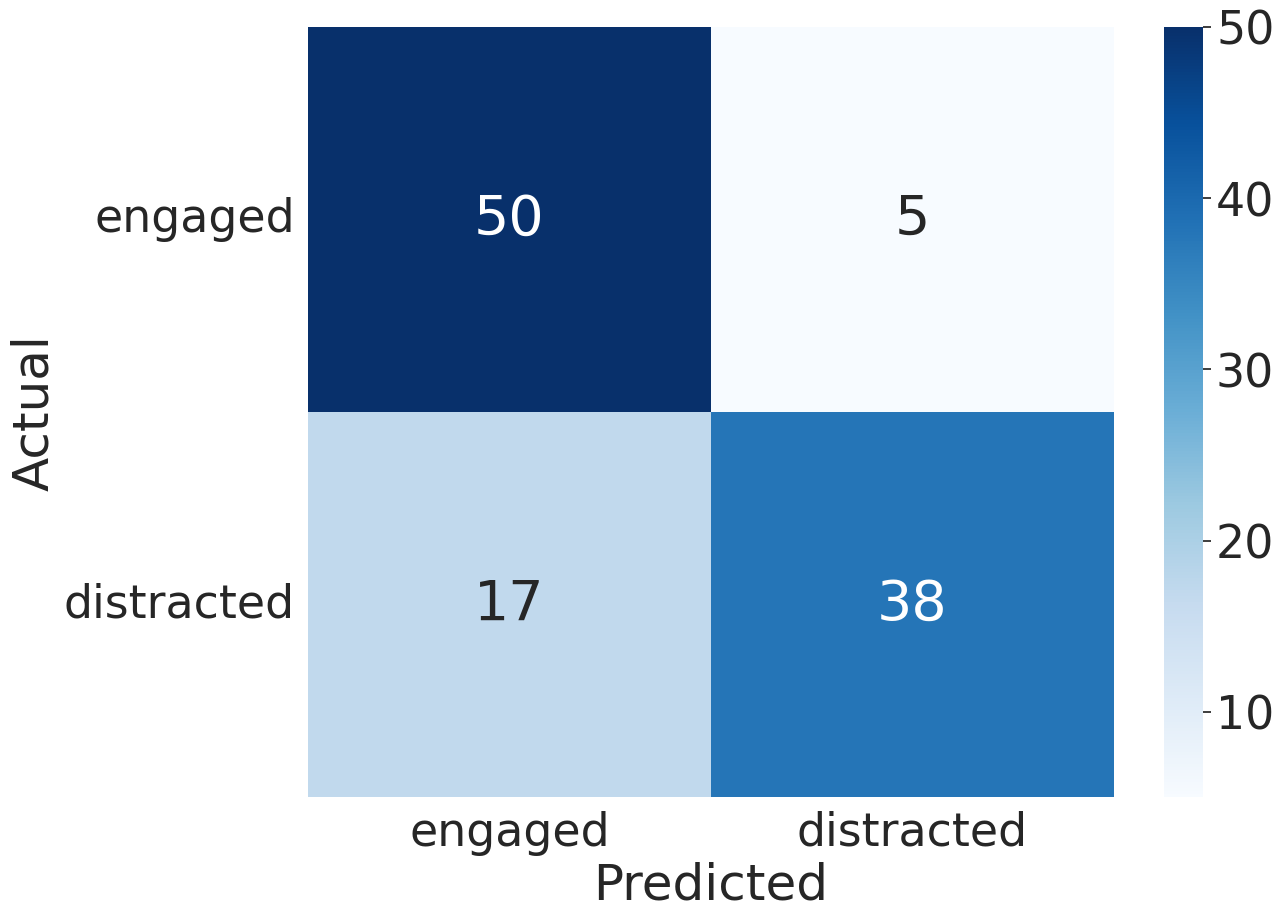

In [128]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [129]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_std_self_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR: 

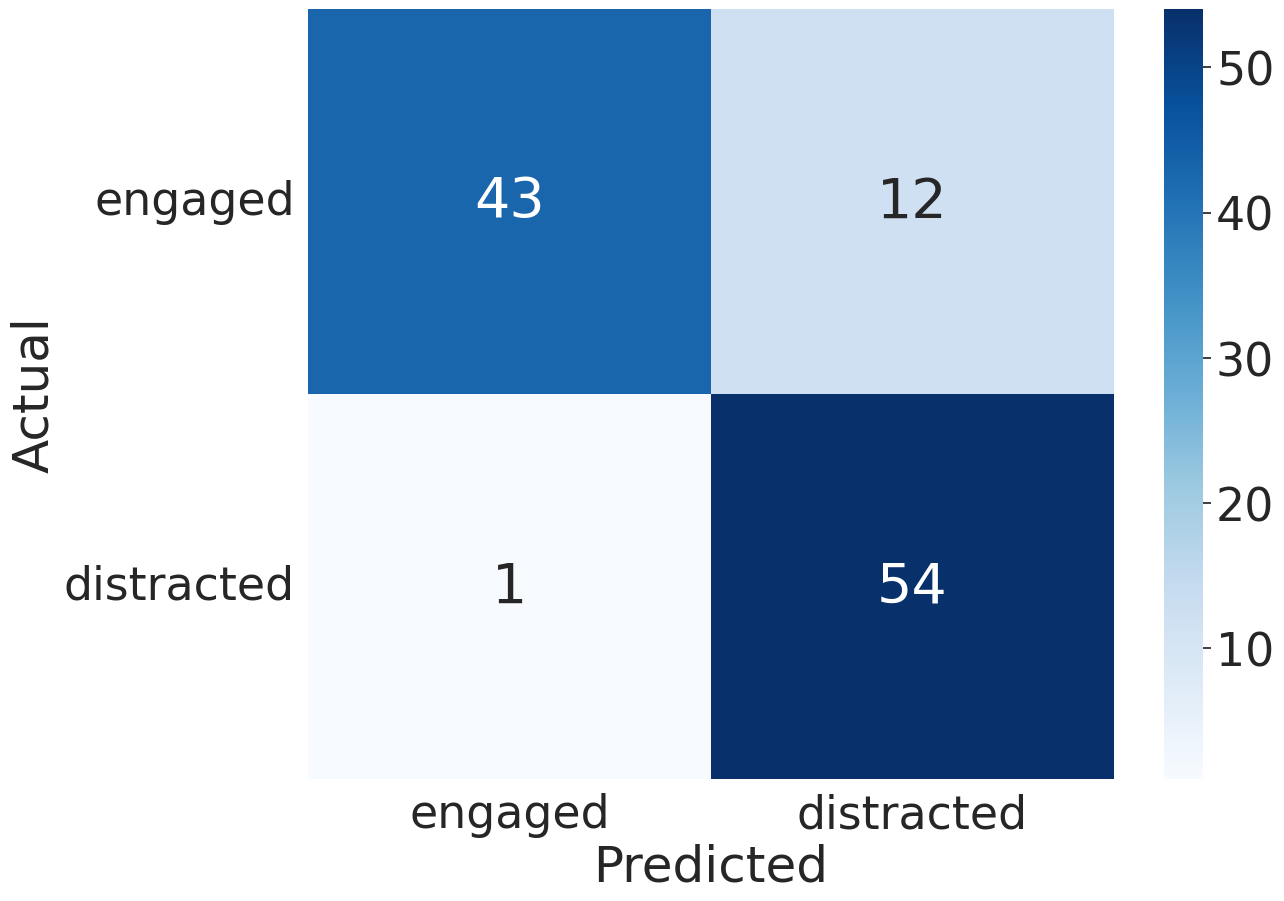

In [130]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [131]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6148 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.5488 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.4511 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.3473 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2555 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1841 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1332 - precision: 1.0000 - recall: 1.000

In [132]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### STAT

In [133]:
stat_name = "STAT"
stat_func = compute_descriptor

#### Single attention

In [134]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [135]:
train_vid2features = all_train_vid2features

In [136]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [137]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [138]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_STAT_single_attention_best


In [139]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [140]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Yana_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.9090909090909091 Precision:  0.5 F1:  0.6451612903225806
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.8181818181818182 Precision:  0.75 F1:  0.7826086956521738
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Den : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_sin

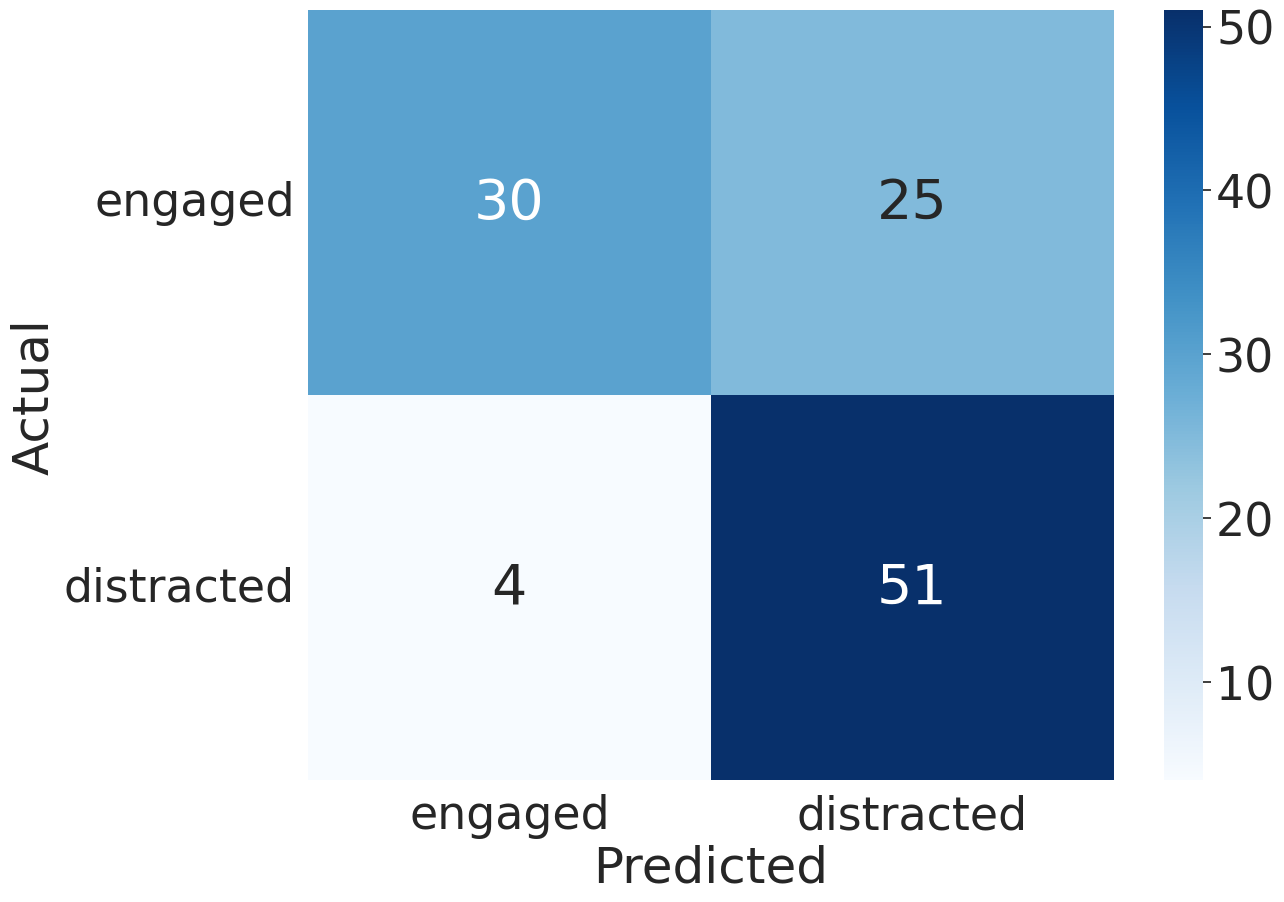

In [141]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [142]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Kate_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Egor
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Katya
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_best_Katya_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precisi

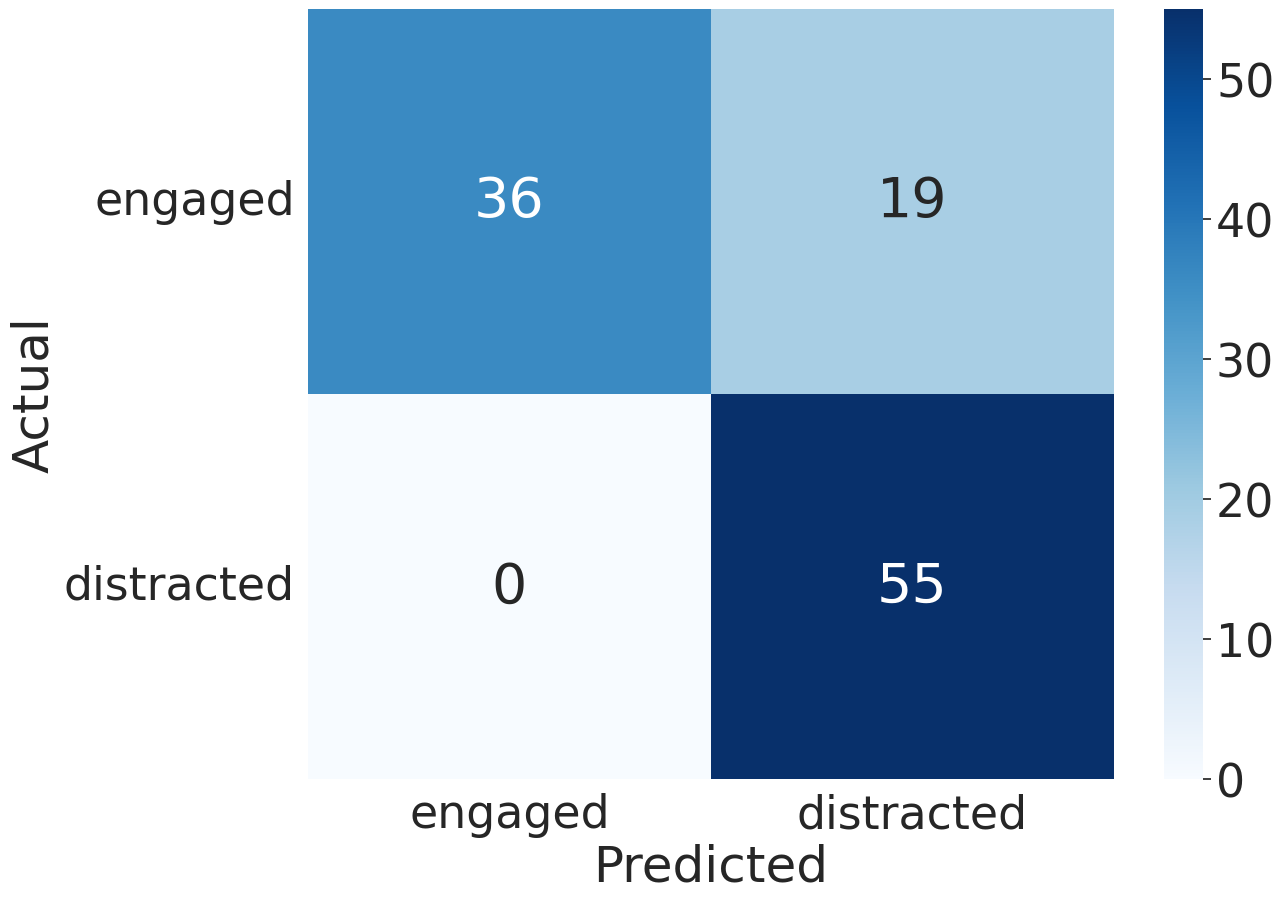

In [143]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [144]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3840) (2,)
		Actor Kate
(2, 70, 3840) (2,)
		Actor Egor
(2, 70, 3840) (2,)
		Actor Katya
(2, 70, 3840) (2,)
		Actor Den
(2, 70, 3840) (2,)
	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 0.9636363636363636, Precision: 0.8582792207792208, F1: 0.9025993265993264
Videos num:  2
		Actor Yana
(4, 70, 3840) (4,)
		Actor Kate
(4, 70, 3840) (4,)
		Actor Egor
(4, 70, 3840) (4,)
		Actor Katya
(4, 70, 3840) (4,)
		Actor Den
(4, 70, 3840) (4,)
	Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454545, Recall: 0.9818181818181818, Precision: 0.8034848484848485, F1: 0.876974876974877
Videos num:  3
		Actor Yana
(6, 70, 3840) (6,)
		Actor Kate
(6, 70, 3840) (6,)
		Actor Egor
(6, 70, 3840) (6,)
		Actor Katya
(6, 70, 3840) (6,)
		Actor Den
(6, 70, 3840) (6,)
	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 1.0, Precision: 0.805, F1: 0.8864610429

In [145]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [146]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [147]:
train_vid2features = all_train_vid2features

In [148]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [149]:
train_vid2features = all_train_vid2features

In [150]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1966080   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1966080   ['image_set[0][0]']           
                                                                                                  
 attention_4 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [151]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_STAT_self_attention_best


In [152]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [153]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.7272727272727273 Precision:  0.6153846153846154 F1:  0.6666666666666667
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Kate_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.5454545454545454 Precision:  0.6666666666666666 F1:  0.6
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Egor_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923

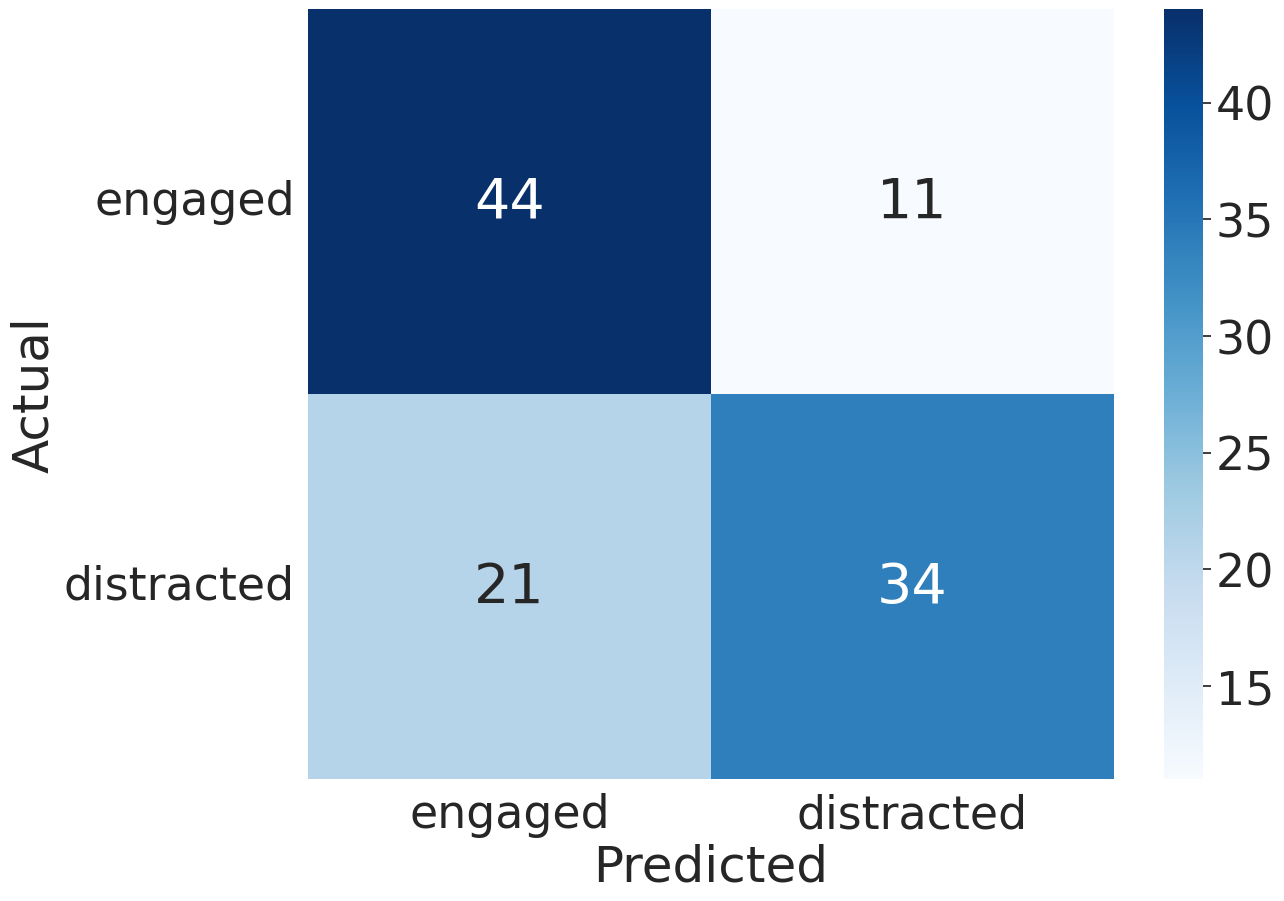

In [154]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [155]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Yana_adapted Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Actor Kate
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Kate_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Egor
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Katya
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_best_Katya_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0

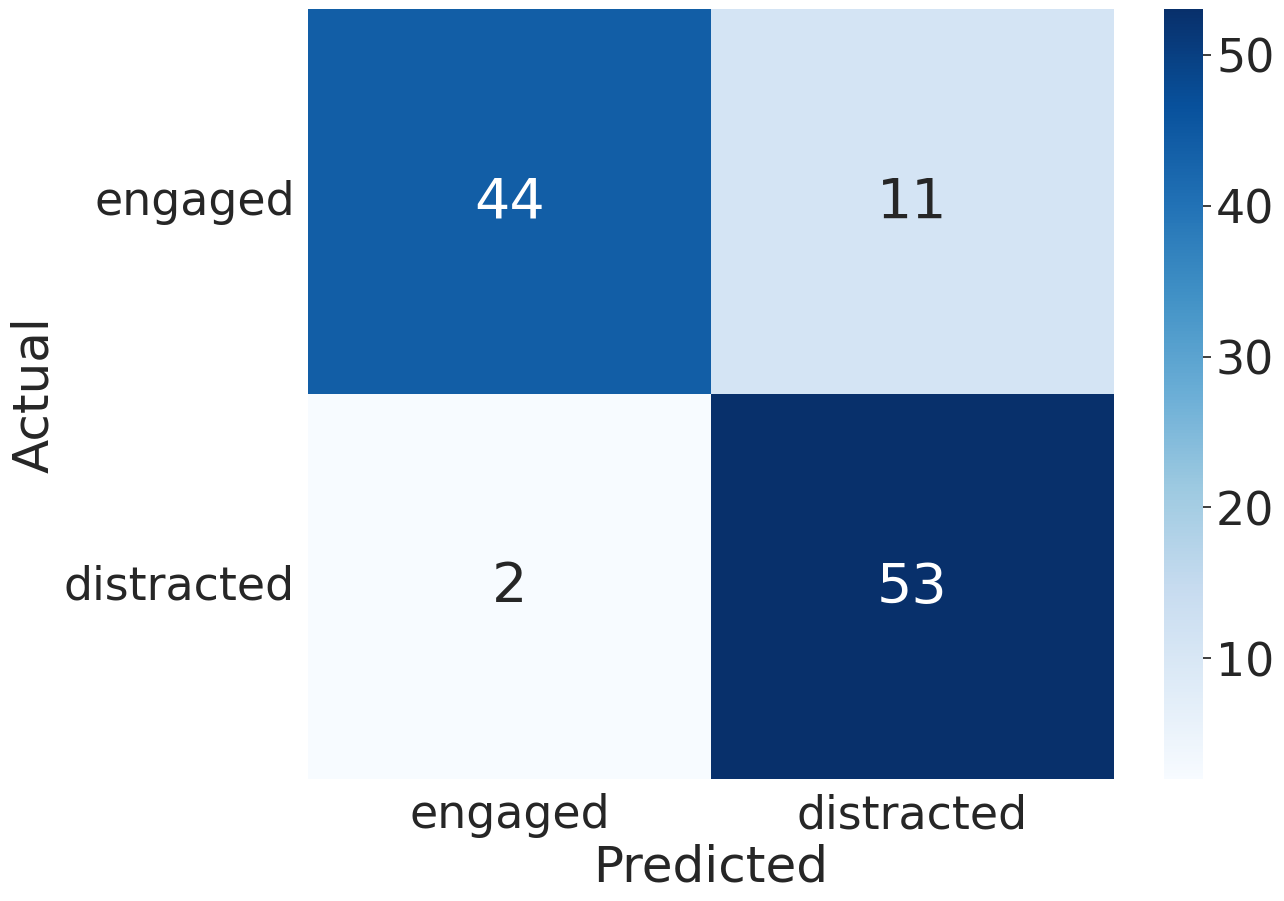

In [156]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [157]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3840) (2,)
Epoch 1/20
1/1 [==============================] - 0s 11ms/step - loss: 1.7627 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 1.4983 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 1.1082 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.7087 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 5/20
1/1 [==============================] - 0s 9ms/step - loss: 0.4231 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2746 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1813 - precision: 1.0000 - recall: 1.000

In [158]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [159]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [160]:
train_vid2features = all_train_vid2features

In [161]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [162]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [163]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_STAT_single_attention_concat_false_best


In [164]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [165]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.9090909090909091 Precision:  0.5882352941176471 F1:  0.7142857142857143
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Egor_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Katya_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Rec

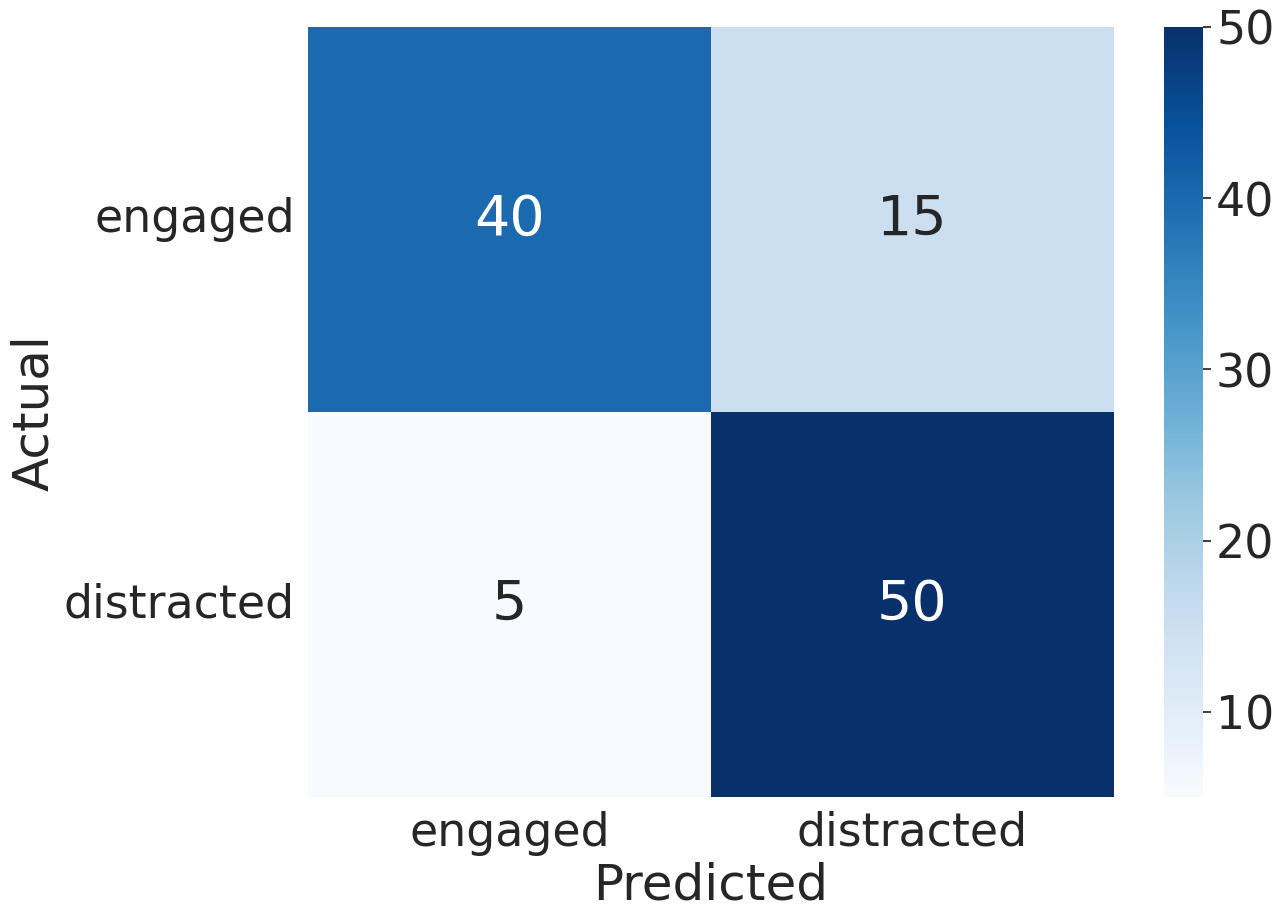

In [166]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [167]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_single_attention_concat_false_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.227272727

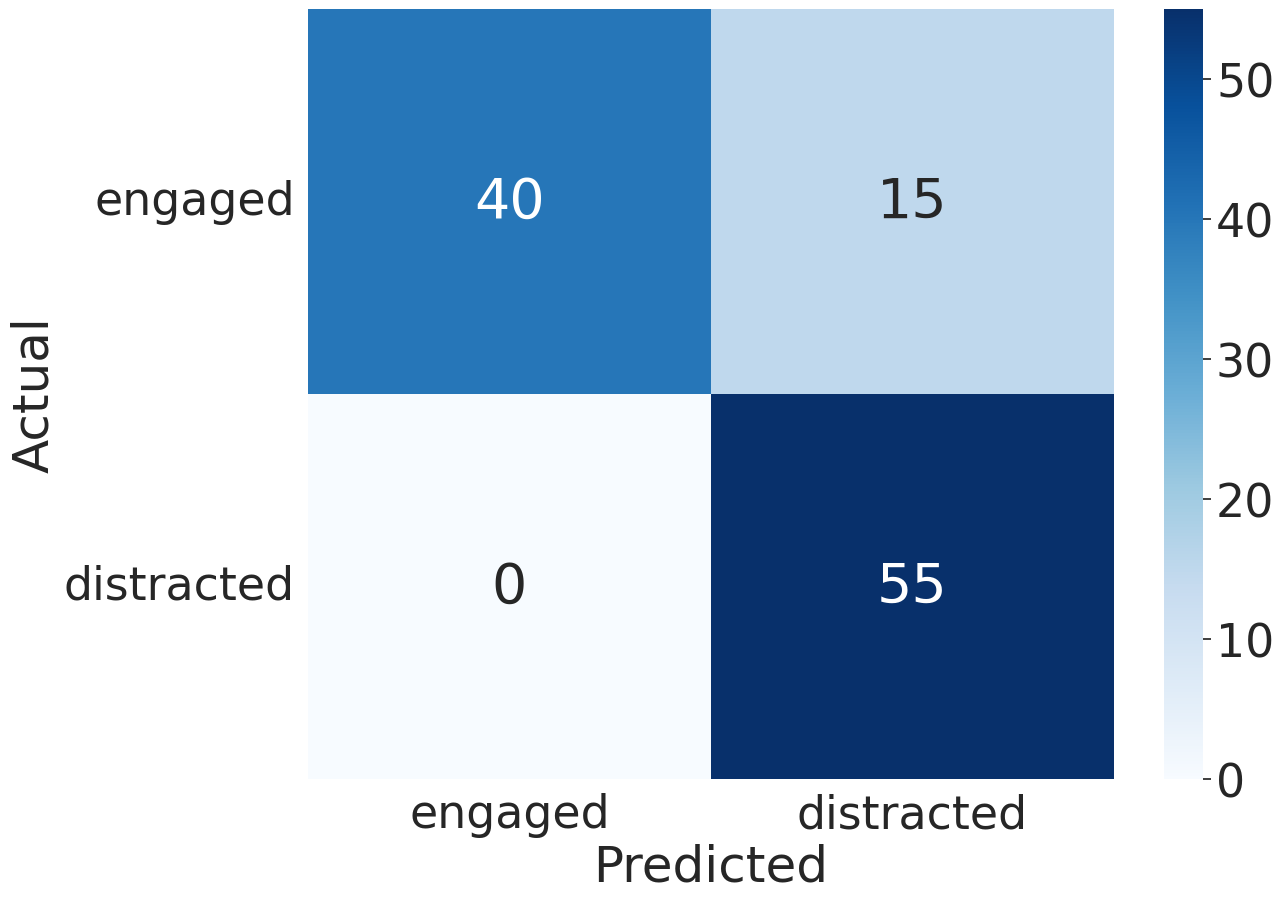

In [168]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [169]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.9818181818181818, MSE: 0.01818181818181818, UAR: 0.9818181818181818, Recall: 0.9818181818181818, Precision: 0.9833333333333332, F1: 0.9817805383022774
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.9272727272727274, MSE: 0.07272727272727272, UAR: 0.9272727272727274, Recall: 1.0, Precision: 0.8946428571428571, F1: 0.938962962962963
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 1.0, Precision: 0.8351190476190474, F1: 0.906267310789

In [170]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [171]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [172]:
train_vid2features = all_train_vid2features

In [173]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [174]:
train_vid2features = all_train_vid2features

In [175]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_5 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [176]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_DAiSEE_2_STAT_self_attention_concat_false_best


In [177]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [178]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.8181818181818182 Precision:  0.6 F1:  0.6923076923076923
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.

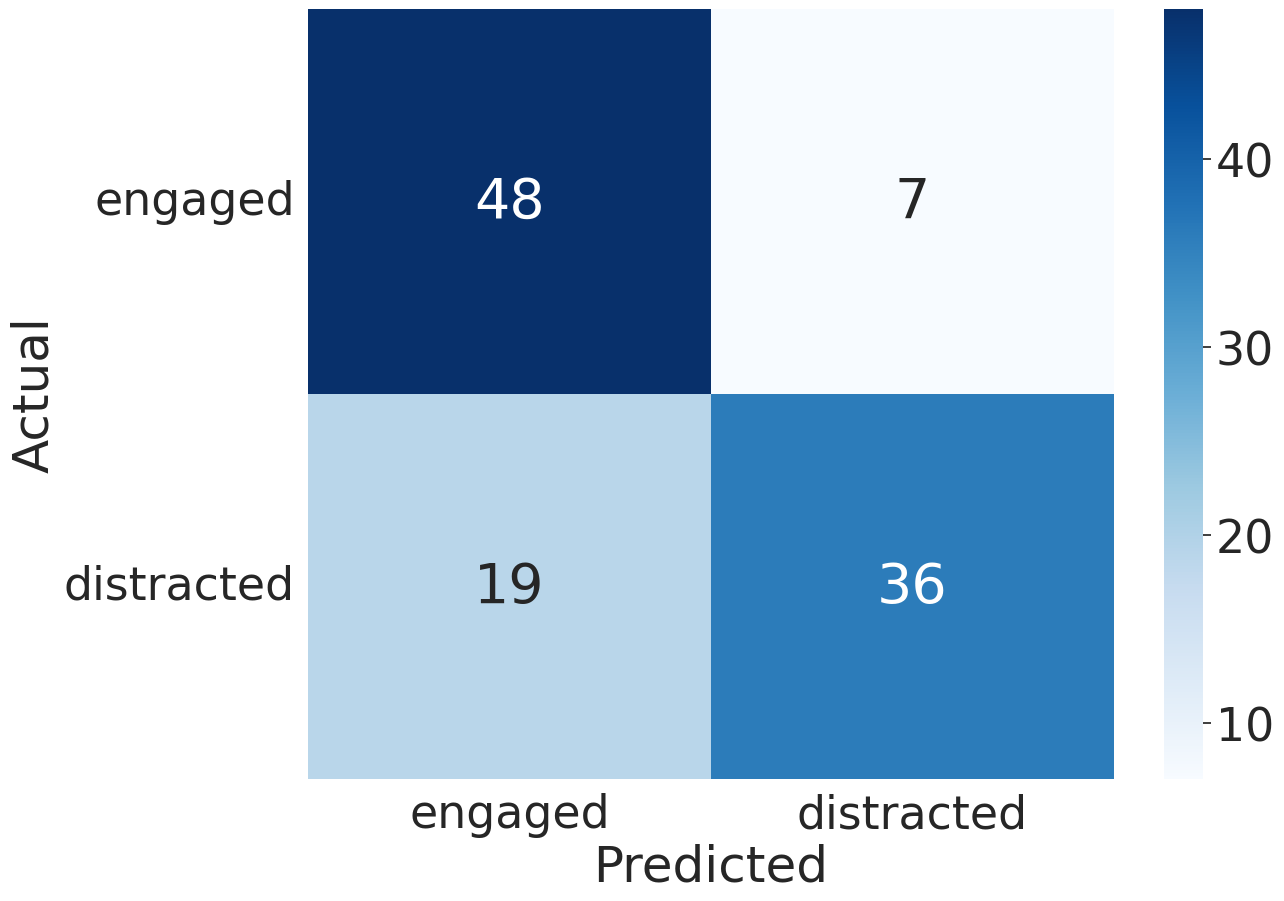

In [179]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [180]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Yana_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_DAiSEE_STAT_self_attention_concat_false_best_Katya_adapted Accuracy:  0.863636363636363

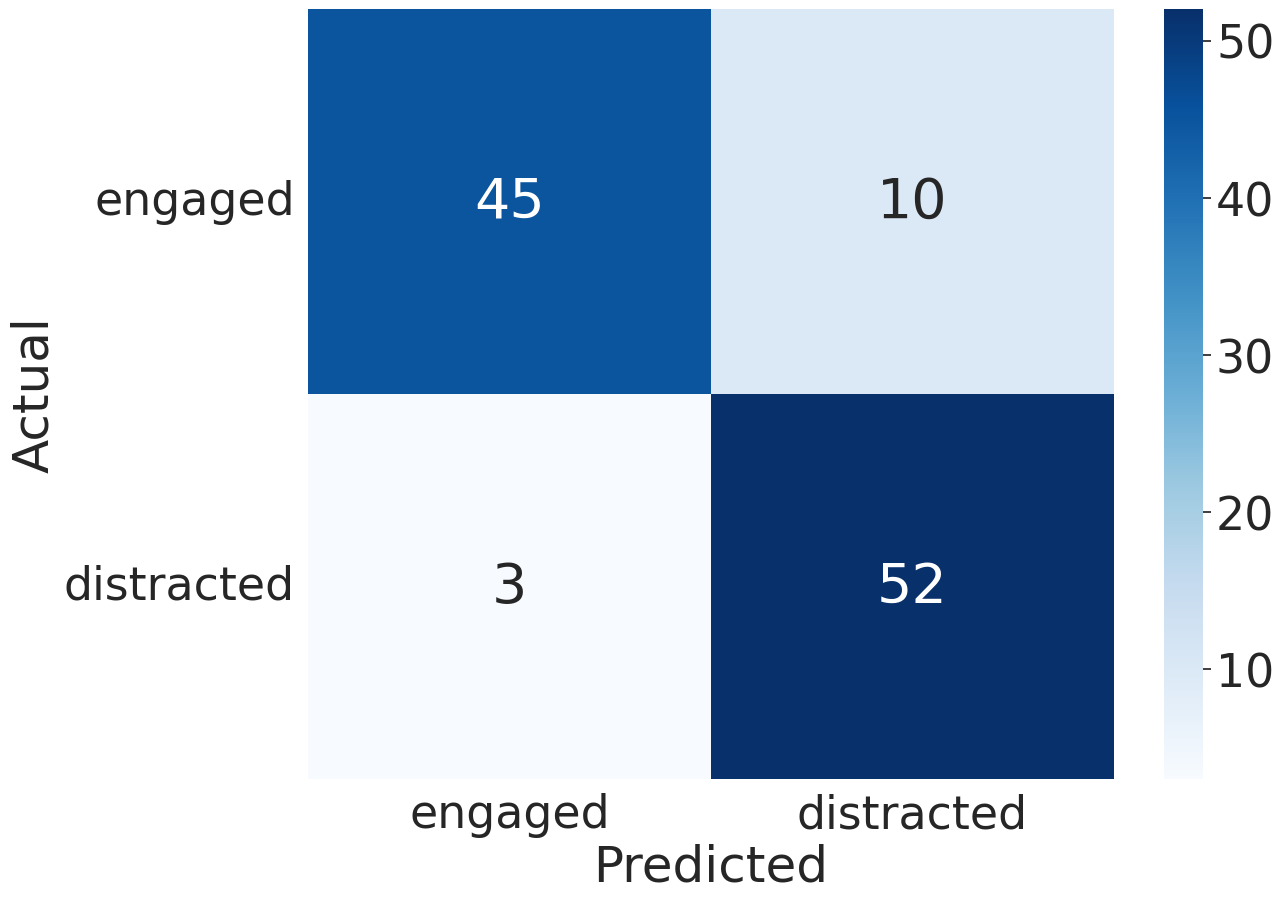

In [181]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [182]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7187 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5442 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.3624 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2439 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1754 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1335 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1054 - precision: 1.0000 - recall: 1.000

In [183]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

## MobileNet

In [28]:
base_model_key = 'mobilenet_7.h5'

In [29]:
FEATURE_VECTOR_DIM = 2048
STAT_FEATURE_VECTOR_DIM = 3072
FEATURE_VECTOR_DIM_CONCAT_FALSE = int(FEATURE_VECTOR_DIM / 2)
STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE = FEATURE_VECTOR_DIM_CONCAT_FALSE

In [30]:
if False:
    engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
    distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
    train_test_pickle = USERS_FEATURES + '{}_train_test_features_{}.pickle'.format(base_model_key, TEST_VIDEOS)
    keys_pickle = USERS_FEATURES + 'shuffled_keys.pickle'
    
    all_train_vid2features, test_vid2features = load_features_from_pickle(engaged_pickle, distracted_pickle, train_test_pickle, keys_pickle)
    for name in all_train_vid2features.keys():
        all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'] = remove_empty_features(all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'])
    for name in test_vid2features.keys():
        test_vid2features[name]['features'], test_vid2features[name]['labels'] = remove_empty_features(test_vid2features[name]['features'], test_vid2features[name]['labels'])

In [31]:
if True:
    engaged_pickle = USERS_DATASET + 'features/engaged_features_{}.good.pickle'.format(base_model_key)
    distracted_pickle = USERS_DATASET + 'features/distracted_features_{}.good.pickle'.format(base_model_key)
    eng_vid2features = load_features(engaged_pickle)
    dis_vid2features = load_features(distracted_pickle)
    vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)
    
    train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)
    all_train_vid2features = train_vid2features
    
    if REVERSE_LABELS:
        for name in train_vid2features.keys():
            labels = train_vid2features[name]['labels']
            train_vid2features[name]['labels'] = [_get_label(l) for l in labels]
    
        for name in test_vid2features.keys():
            labels = test_vid2features[name]['labels']
            test_vid2features[name]['labels'] = [_get_label(l) for l in labels]

### Max

In [32]:
stat_func=np.max
stat_name = "max"

#### Single attention

In [33]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [34]:
train_vid2features = all_train_vid2features

In [35]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [36]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                              

2024-03-21 16:39:52.889611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38319 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:11:00.0, compute capability: 8.0


##### Universal model

In [37]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_max_single_attention_best


In [38]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [39]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Kate_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Katya_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Den : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Den_univer

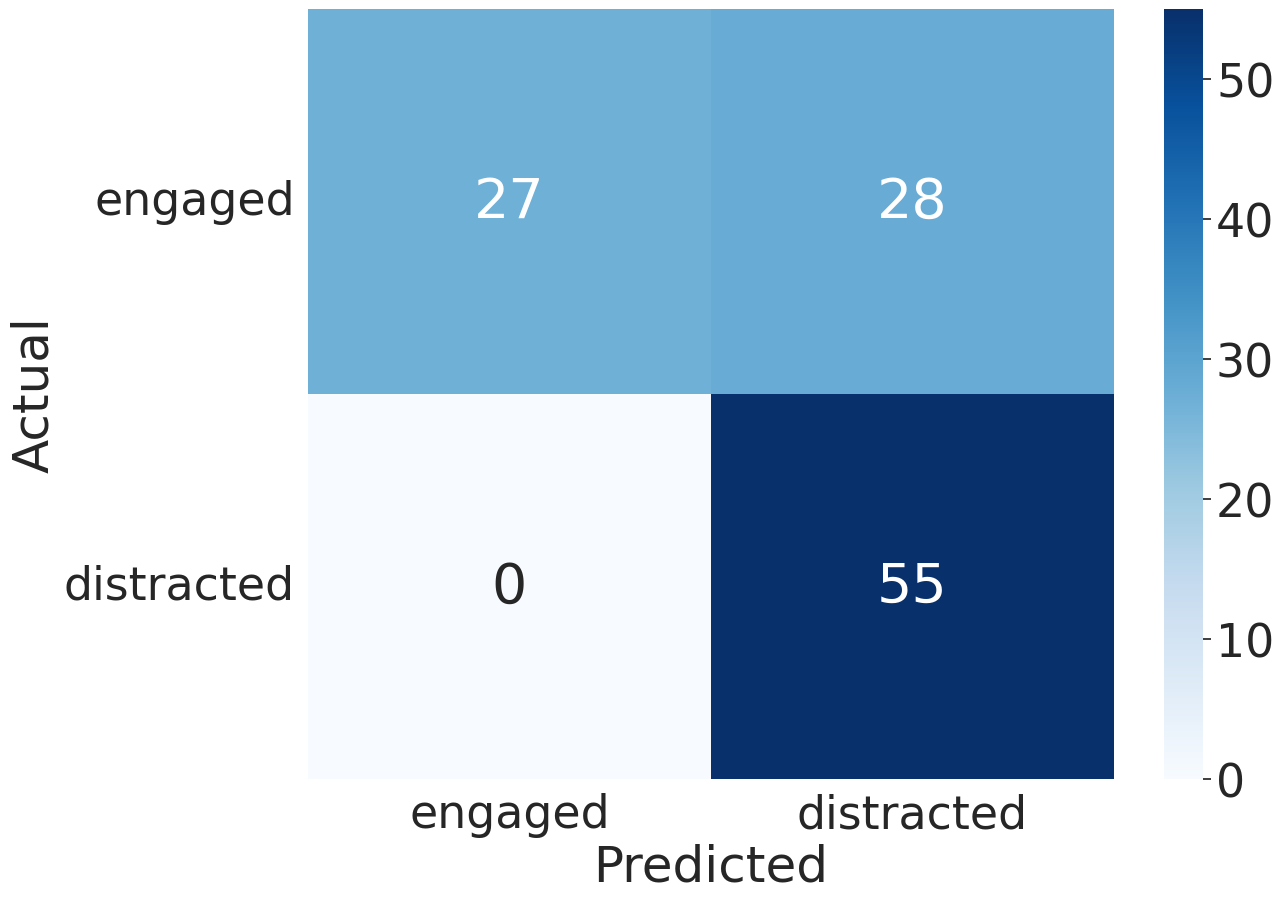

In [40]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [41]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)


2024-03-21 16:40:01.522522: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef182b87050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 16:40:01.522739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-21 16:40:01.527449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-21 16:40:01.573445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-03-21 16:40:01.635796: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Egor_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Den
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h

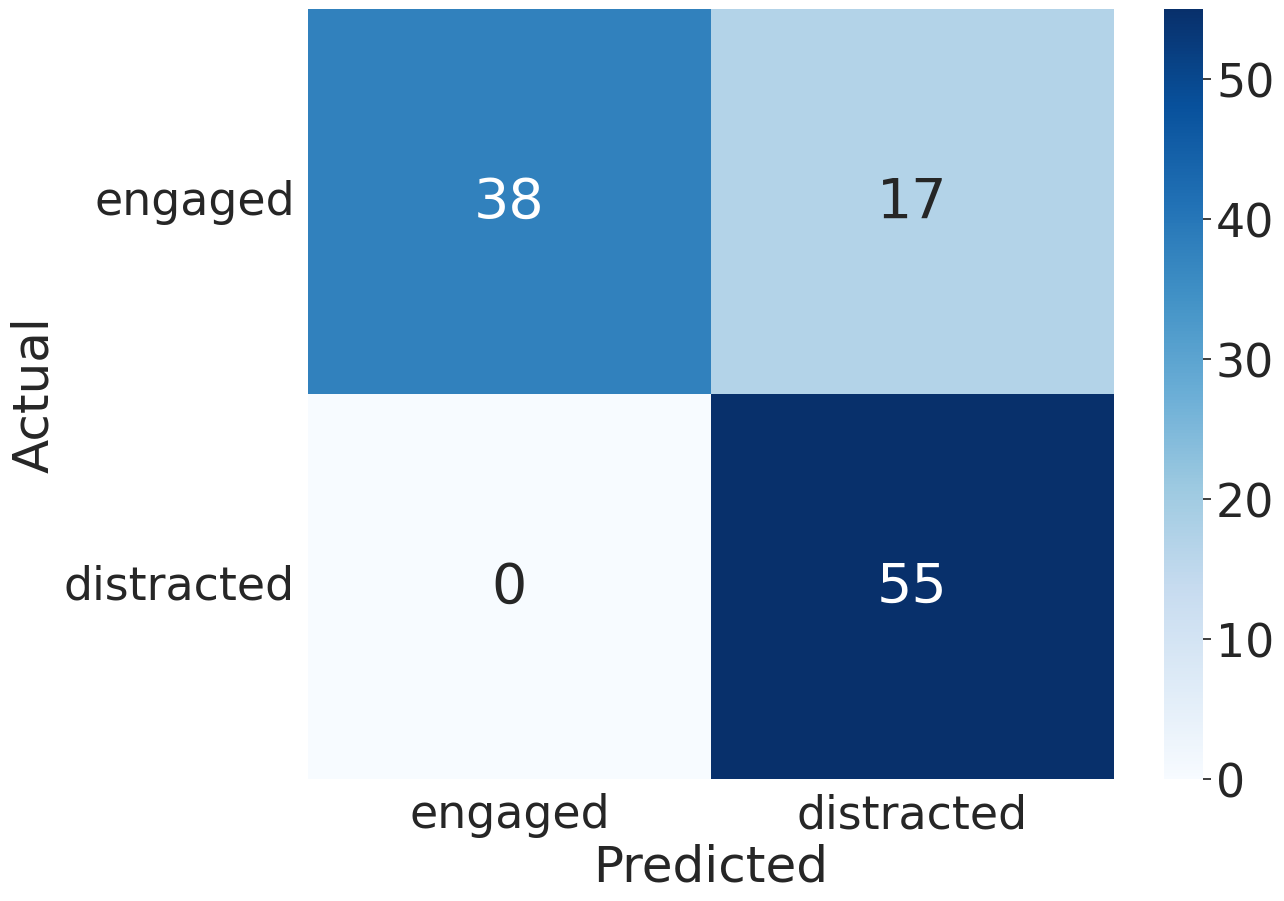

In [42]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [43]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
		Actor Kate
(2, 70, 2048) (2,)
		Actor Egor
(2, 70, 2048) (2,)
		Actor Katya
(2, 70, 2048) (2,)
		Actor Den
(2, 70, 2048) (2,)
	Total, accuracy: 0.9181818181818183, MSE: 0.08181818181818182, UAR: 0.9181818181818183, Recall: 1.0, Precision: 0.8704761904761904, F1: 0.9278394648829431
Videos num:  2
		Actor Yana
(4, 70, 2048) (4,)
		Actor Kate
(4, 70, 2048) (4,)
		Actor Egor
(4, 70, 2048) (4,)
		Actor Katya
(4, 70, 2048) (4,)
		Actor Den
(4, 70, 2048) (4,)
	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 1.0, Precision: 0.8105402930402932, F1: 0.8915270655270653
Videos num:  3
		Actor Yana
(6, 70, 2048) (6,)
		Actor Kate
(6, 70, 2048) (6,)
		Actor Egor
(6, 70, 2048) (6,)
		Actor Katya
(6, 70, 2048) (6,)
		Actor Den
(6, 70, 2048) (6,)
	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 1.0, Precision: 0.83018315018315, F1: 0.9045641025641025
Videos num:

In [44]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [45]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [46]:
train_vid2features = all_train_vid2features

In [47]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [48]:
train_vid2features = all_train_vid2features

In [49]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention (Attention)       (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [50]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_max_self_attention_best


In [51]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [52]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Yana_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.2727272727272727 Precision:  0.75 F1:  0.39999999999999997
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Kate_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.45454545454545453 Precision:  0.8333333333333334 F1:  0.5882352941176471
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Egor_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.2727272727272727 Precision:  0.6 F1:  0.37499999999999994
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Katya_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.6363636363636364 Precision:  0.875 F1:  0.7368421052631579
Den : 22
Metric_name:  mobilenet_7.h5_DAiSE

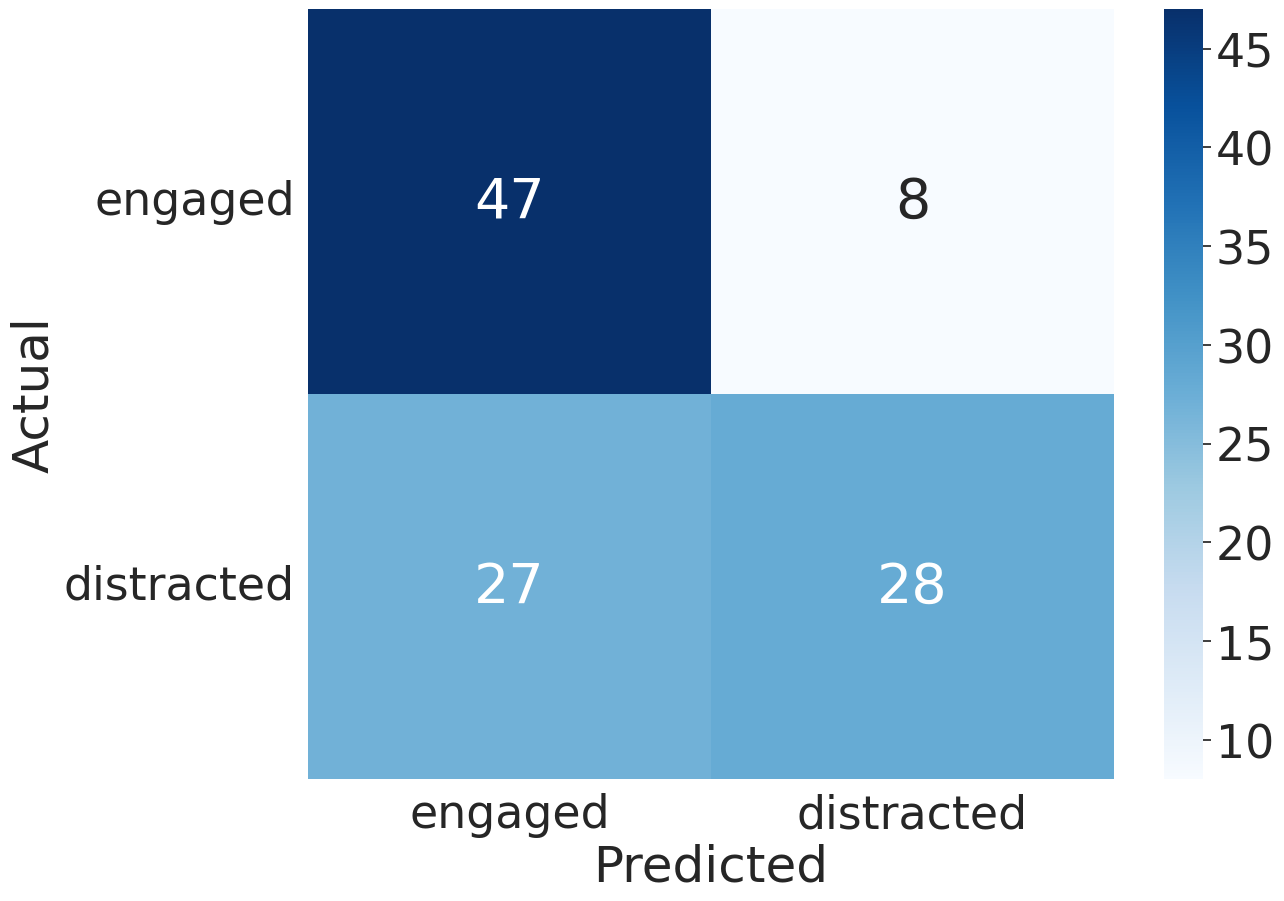

In [53]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [54]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Yana_adapted Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  1.0 Precision:  0.5 F1:  0.6666666666666666
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Kate_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Egor_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.9090909090909091 Precision:  0.5263157894736842 F1:  0.6666666666666666
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Den
(10, 70, 2048) (10,)
Metric_name:

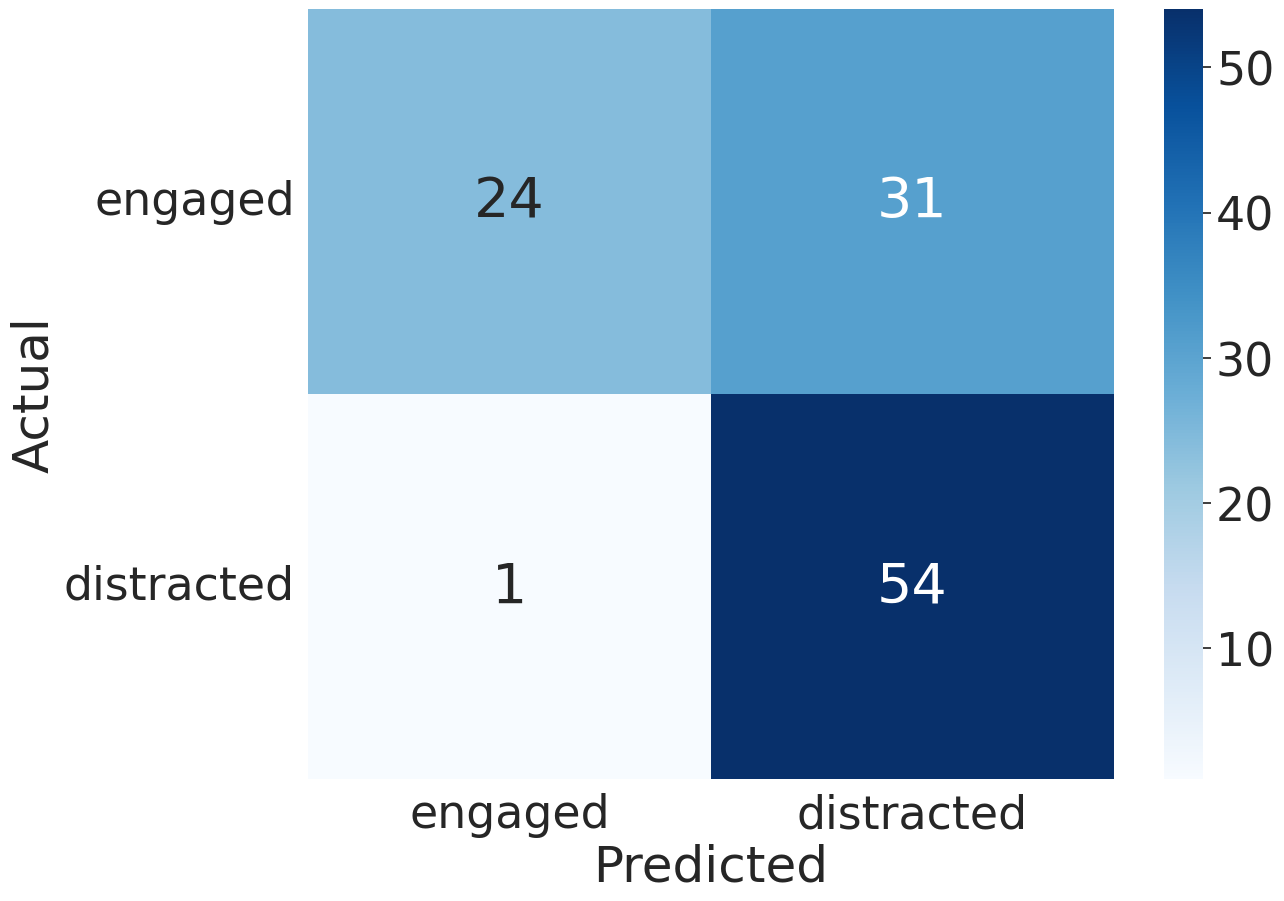

In [55]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [56]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.1626 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1302 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0853 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0691 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0602 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0507 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0413 - precision: 1.0000 - recall: 1.000

In [57]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [58]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [59]:
train_vid2features = all_train_vid2features

In [60]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [61]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [62]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_max_single_attention_concat_false_best


In [63]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [64]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565

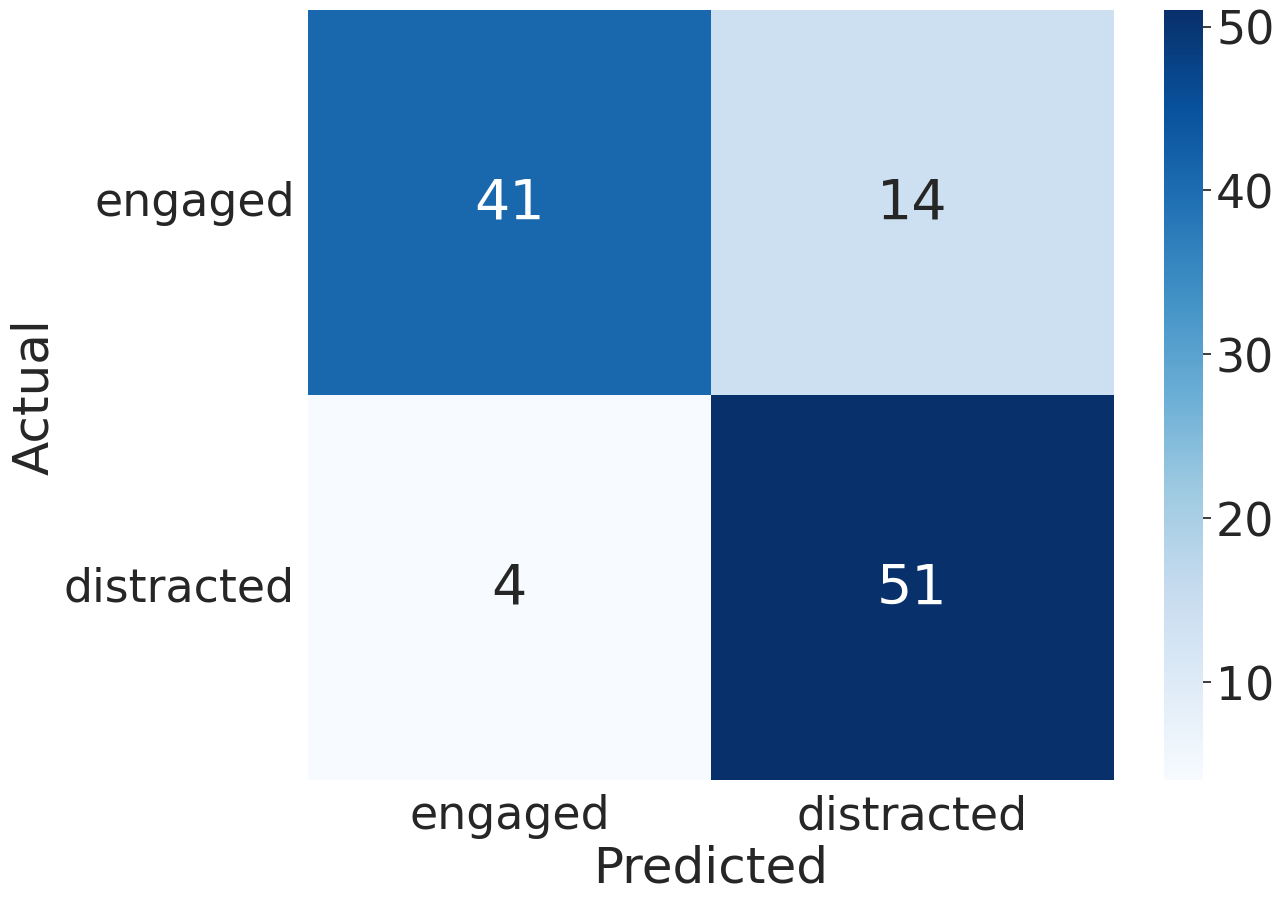

In [65]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [66]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Yana_adapted Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Egor_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_single_attention_concat_false_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Reca

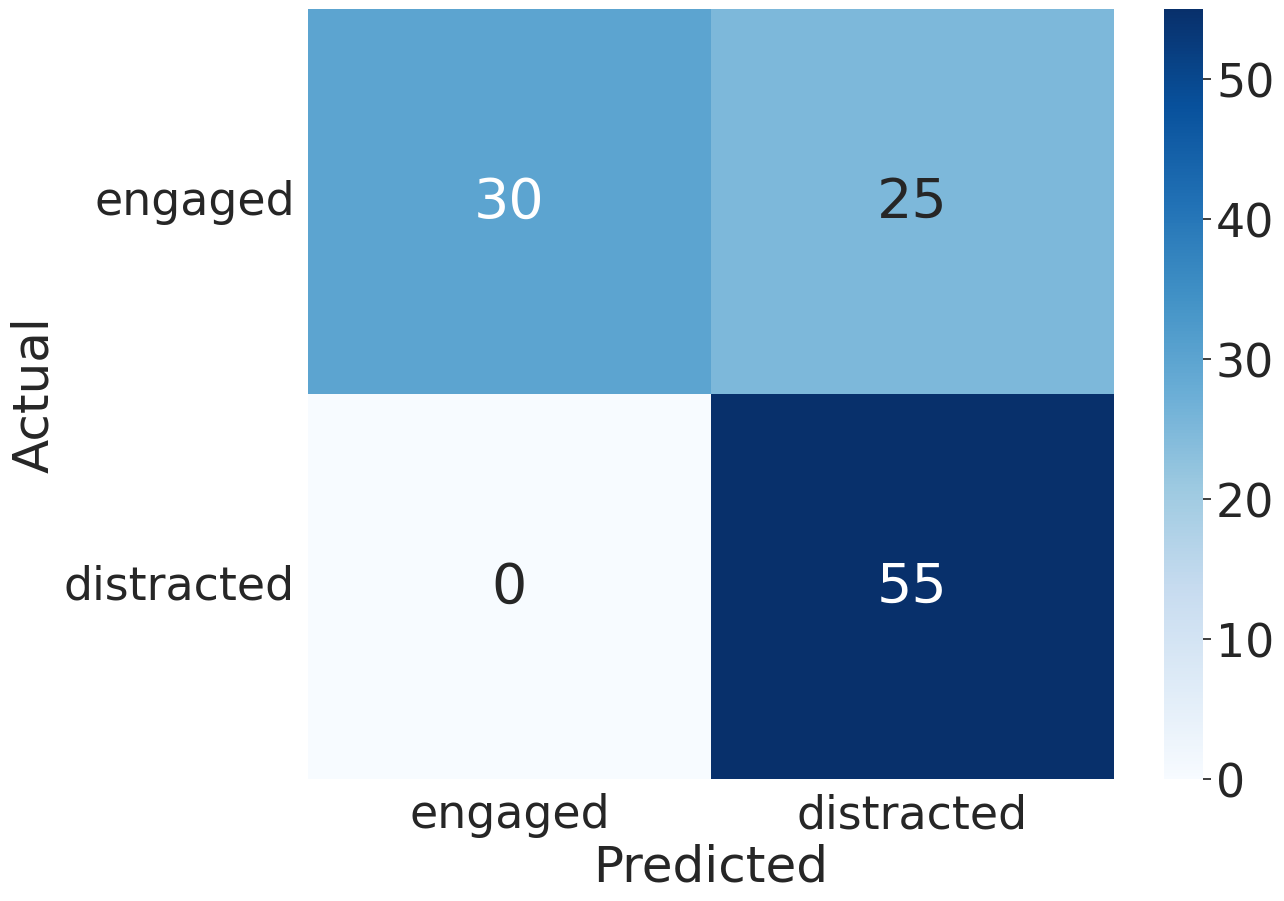

In [67]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [68]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.9363636363636363, MSE: 0.06363636363636364, UAR: 0.9363636363636363, Recall: 1.0, Precision: 0.8930402930402931, F1: 0.9419420289855072
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.8636363636363636, MSE: 0.13636363636363635, UAR: 0.8636363636363636, Recall: 1.0, Precision: 0.8404761904761905, F1: 0.9006376811594203
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 1.0, Precision: 0.8657894736842107, F1: 0.9205797101449276
Videos num:  4
		Actor Yana
(8, 70, 1024) (8,)
		Acto

In [69]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [70]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [71]:
train_vid2features = all_train_vid2features

In [72]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [73]:
train_vid2features = all_train_vid2features

In [74]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_1 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [75]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_max_self_attention_concat_false_best


In [76]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [77]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.7777777777777778 F1:  0.7000000000000001
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.36363636363636365 Precision:  0.6666666666666666 F1:  0.4705882352941177
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Katya_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1: 

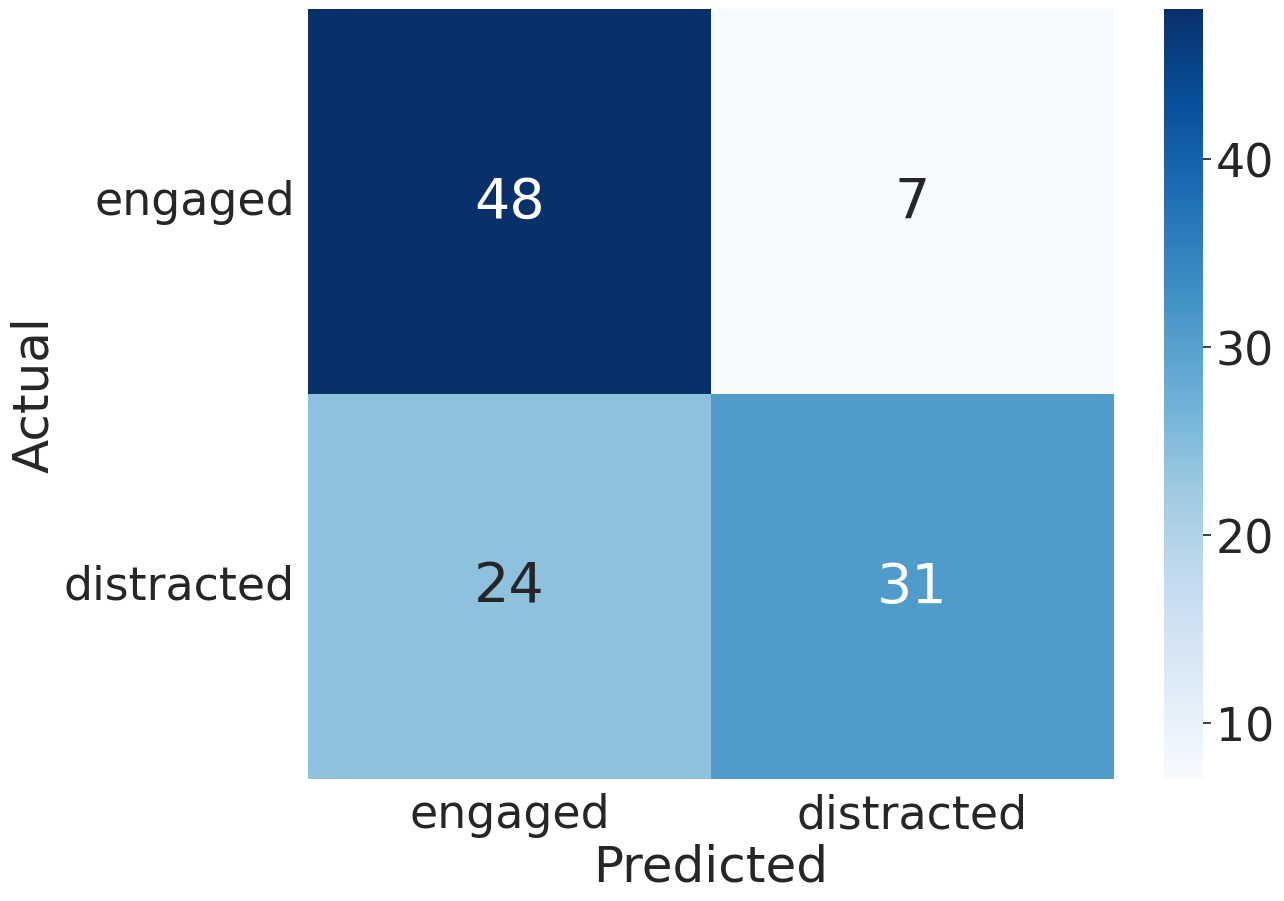

In [78]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [79]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Egor_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_max_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0

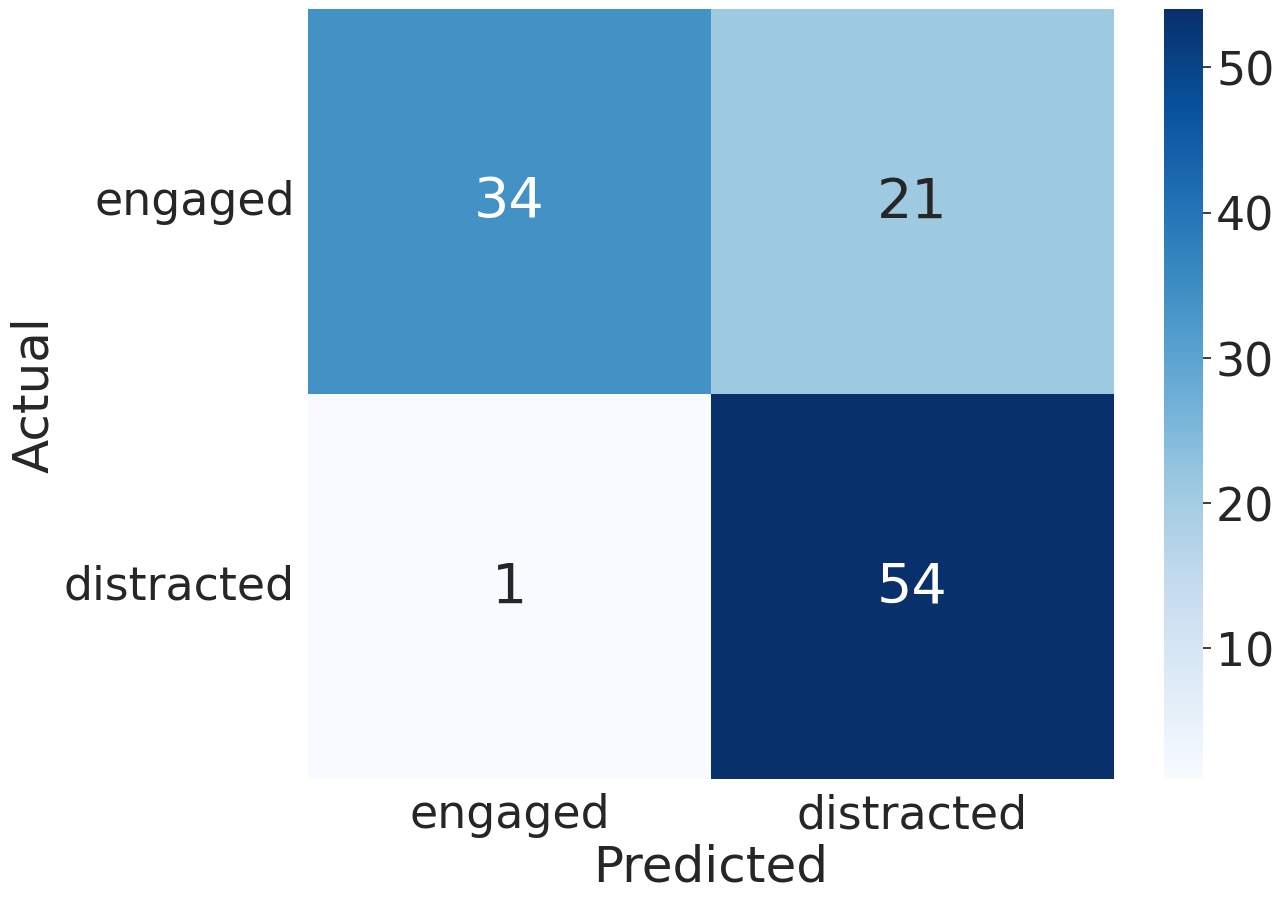

In [80]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [81]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 9ms/step - loss: 0.1733 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1544 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1269 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0987 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0742 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0552 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0413 - precision: 1.0000 - recall: 1.0000

In [82]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### Std

In [83]:
stat_func=np.std
stat_name = "std"

#### Single attention

In [84]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [85]:
train_vid2features = all_train_vid2features

In [86]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [87]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [88]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_std_single_attention_best


In [89]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [90]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Egor_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Katya_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Den : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Den_universal

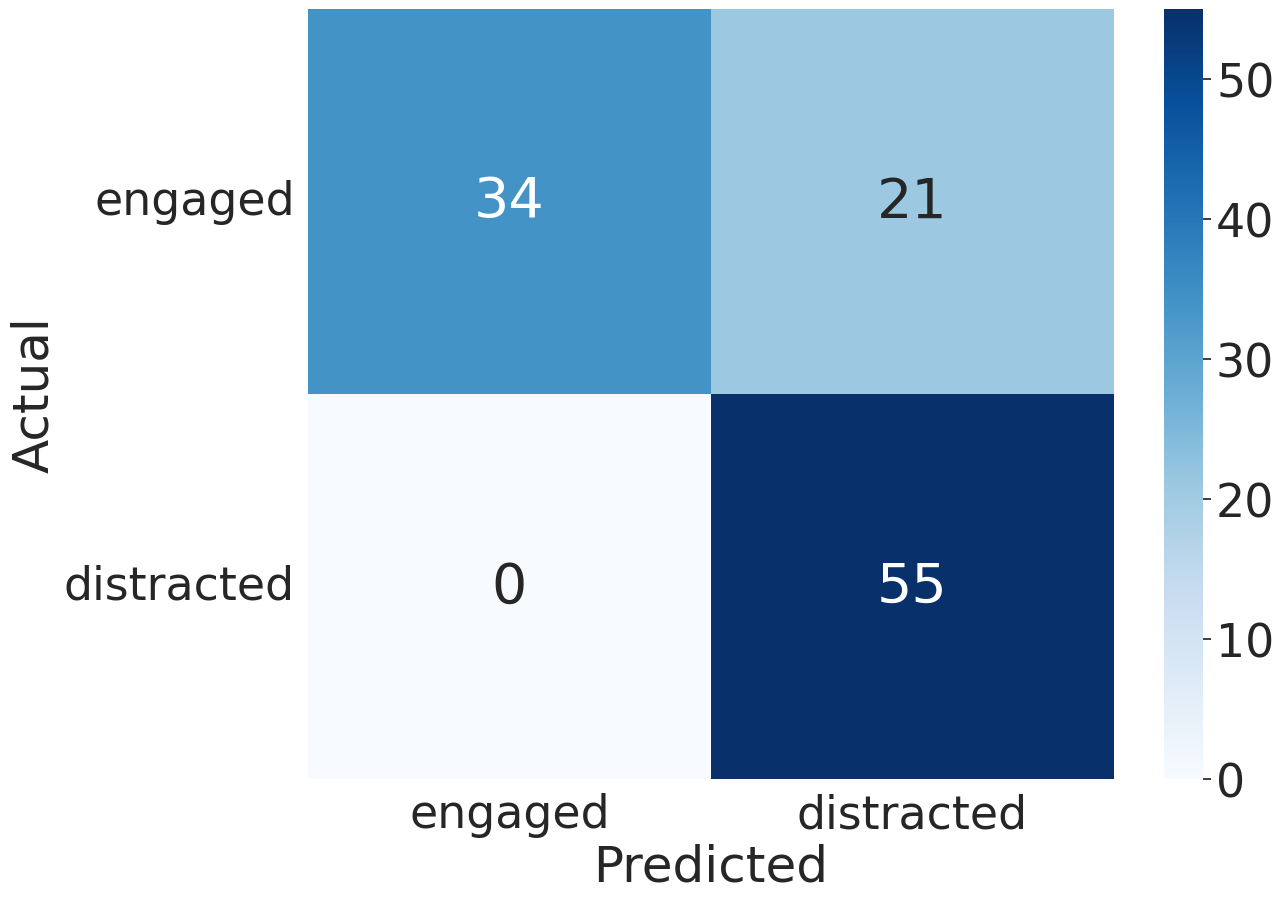

In [91]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [92]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Yana_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Egor_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F

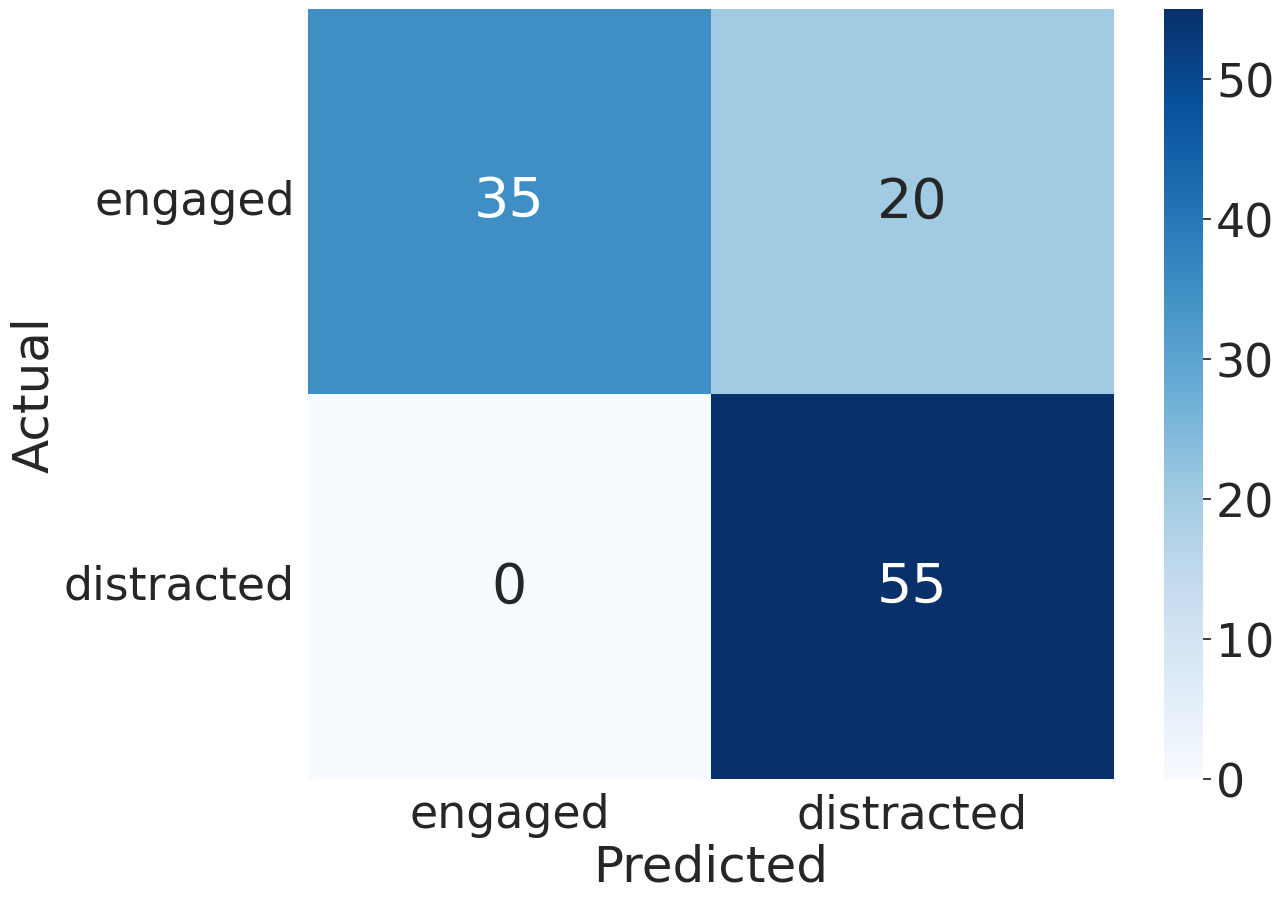

In [93]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [94]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
		Actor Kate
(2, 70, 2048) (2,)
		Actor Egor
(2, 70, 2048) (2,)
		Actor Katya
(2, 70, 2048) (2,)
		Actor Den
(2, 70, 2048) (2,)
	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 1.0, Precision: 0.8458974358974359, F1: 0.9130992196209586
Videos num:  2
		Actor Yana
(4, 70, 2048) (4,)
		Actor Kate
(4, 70, 2048) (4,)
		Actor Egor
(4, 70, 2048) (4,)
		Actor Katya
(4, 70, 2048) (4,)
		Actor Den
(4, 70, 2048) (4,)
	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 1.0, Precision: 0.7617857142857142, F1: 0.8568984468339307
Videos num:  3
		Actor Yana
(6, 70, 2048) (6,)
		Actor Kate
(6, 70, 2048) (6,)
		Actor Egor
(6, 70, 2048) (6,)
		Actor Katya
(6, 70, 2048) (6,)
		Actor Den
(6, 70, 2048) (6,)
	Total, accuracy: 0.890909090909091, MSE: 0.10909090909090909, UAR: 0.890909090909091, Recall: 1.0, Precision: 0.83018315018315, F1: 0.9045641025641025
Videos num:  4
		Actor Yana
(8, 70, 2048) (8,)
		Actor Ka

In [95]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [96]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [97]:
train_vid2features = all_train_vid2features

In [98]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [99]:
train_vid2features = all_train_vid2features

In [100]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention_2 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [101]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_std_self_attention_best


In [102]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [103]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.45454545454545453 Precision:  0.8333333333333334 F1:  0.5882352941176471
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Katya_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
De

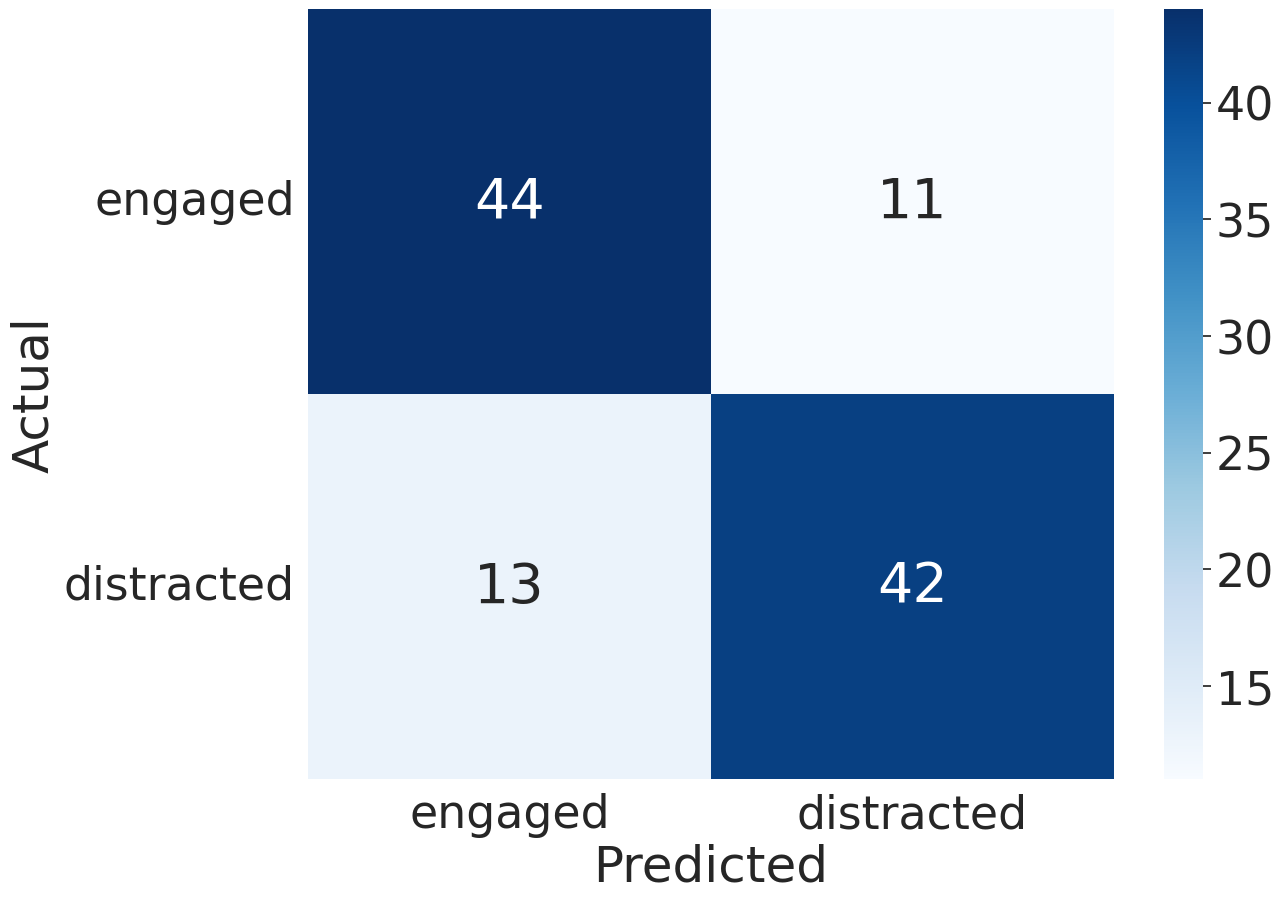

In [104]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [105]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Yana_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.9090909090909091 Precision:  0.5263157894736842 F1:  0.6666666666666666
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Egor_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.9090909090909091 Precisi

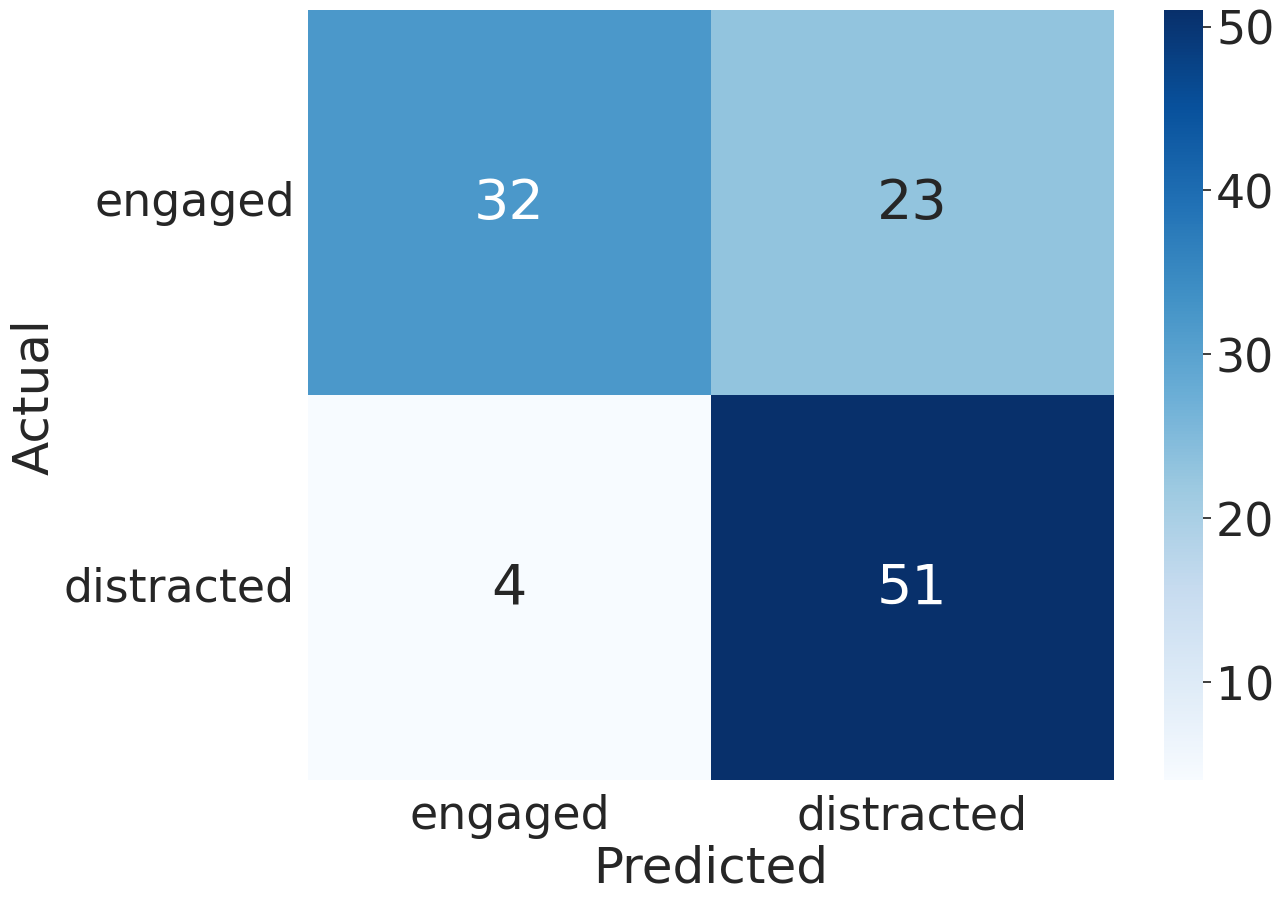

In [106]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [107]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4260 - precision: 0.5000 - recall: 1.0000 - f1_score_metric: 0.6667
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2842 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1510 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0762 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0408 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0243 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0168 - precision: 1.0000 - recall: 1.000

In [108]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [109]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [110]:
train_vid2features = all_train_vid2features

In [111]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [112]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [113]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_std_single_attention_concat_false_best


In [114]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [115]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Egor_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Den : 22
Metric_n

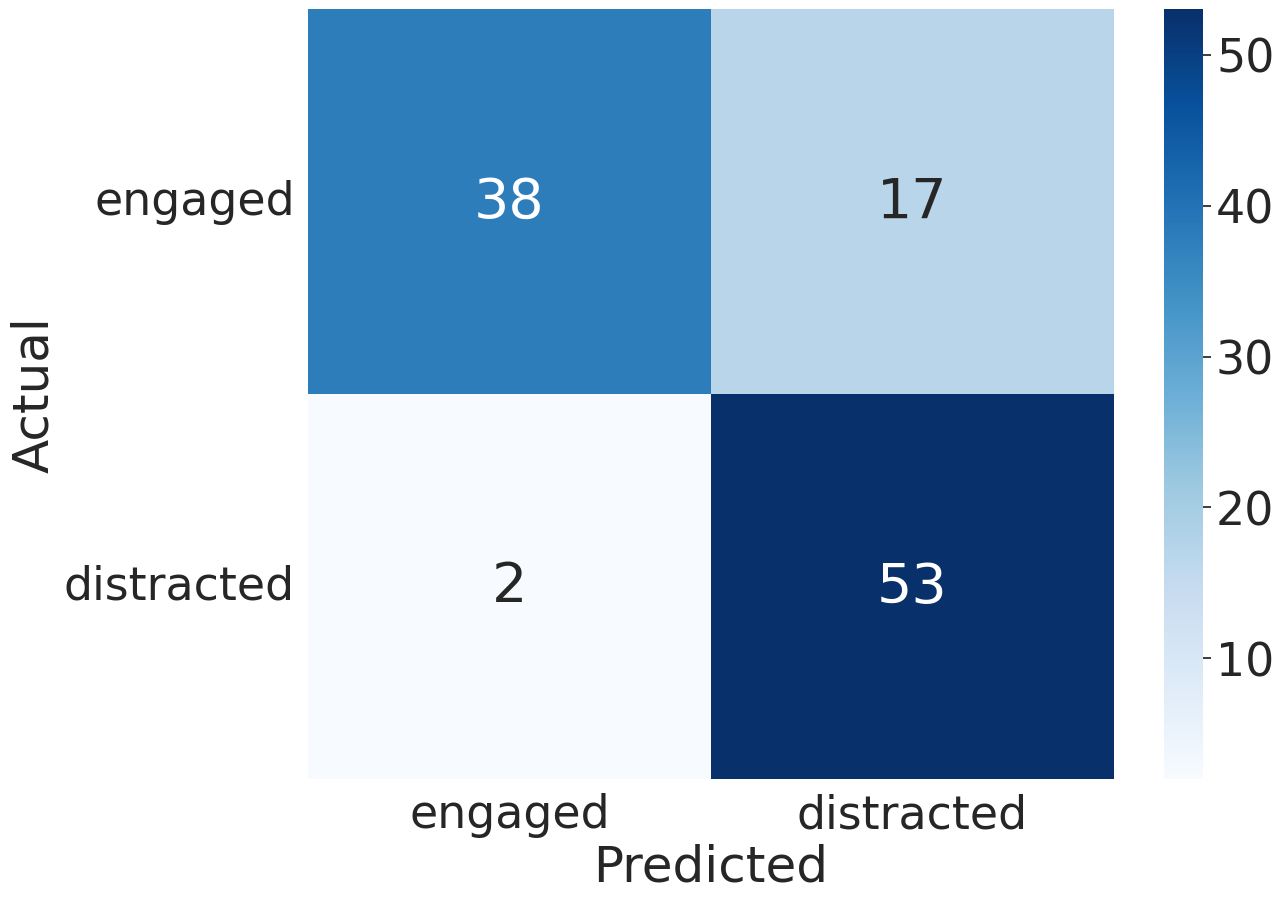

In [116]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [117]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Egor_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_single_attention_concat_false_best_Katya_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 P

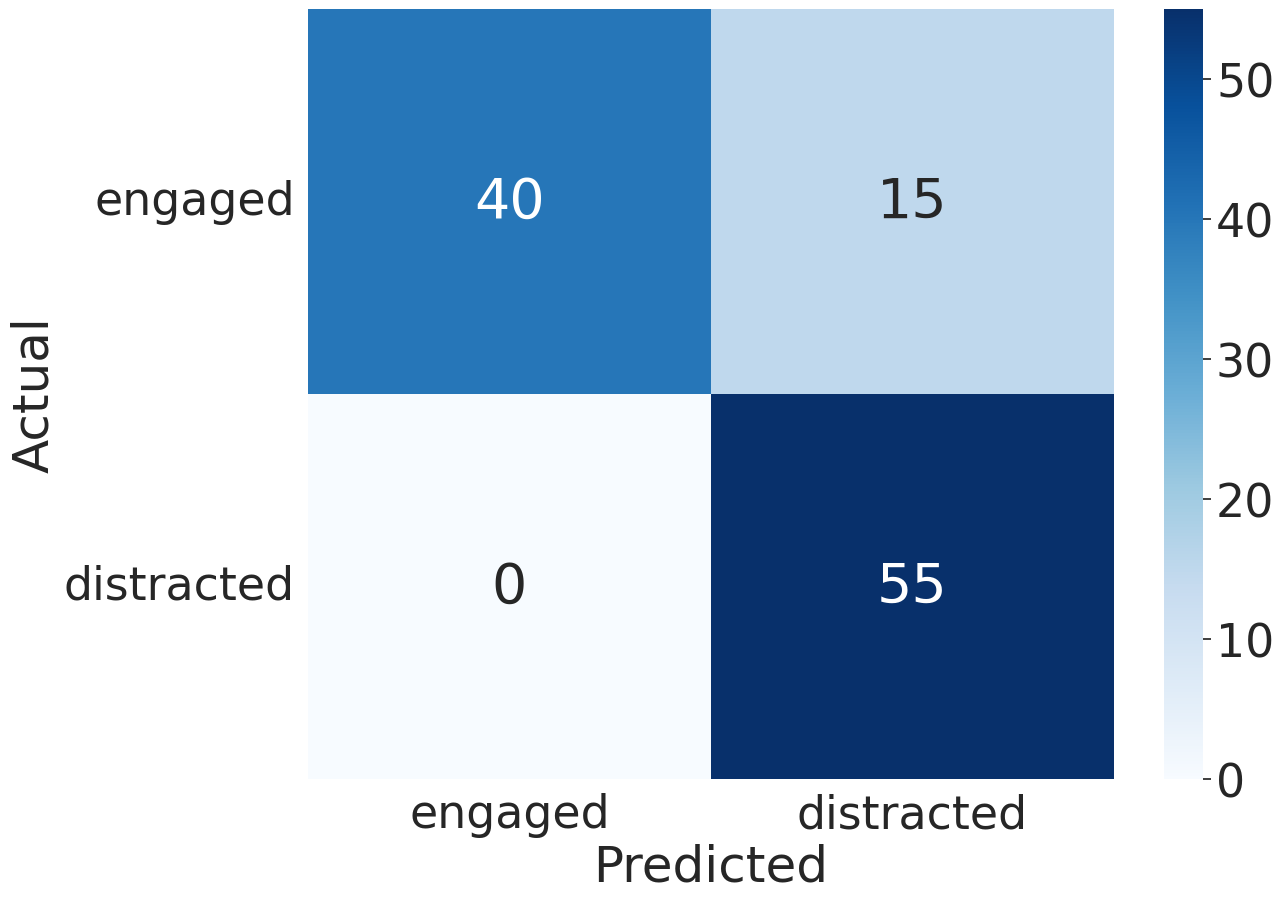

In [118]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [119]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.990909090909091, MSE: 0.00909090909090909, UAR: 0.990909090909091, Recall: 1.0, Precision: 0.9833333333333332, F1: 0.9913043478260869
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.9454545454545455, MSE: 0.05454545454545455, UAR: 0.9454545454545453, Recall: 1.0, Precision: 0.9133333333333333, F1: 0.9518394648829431
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.9727272727272727, MSE: 0.02727272727272727, UAR: 0.9727272727272727, Recall: 1.0, Precision: 0.95, F1: 0.9739130434782609
Videos num:  4
		Actor 

In [120]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [121]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [122]:
train_vid2features = all_train_vid2features

In [123]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [124]:
train_vid2features = all_train_vid2features

In [125]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_3 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [126]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_std_self_attention_concat_false_best


In [127]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [128]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Kate_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Egor_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Katya_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Den : 22

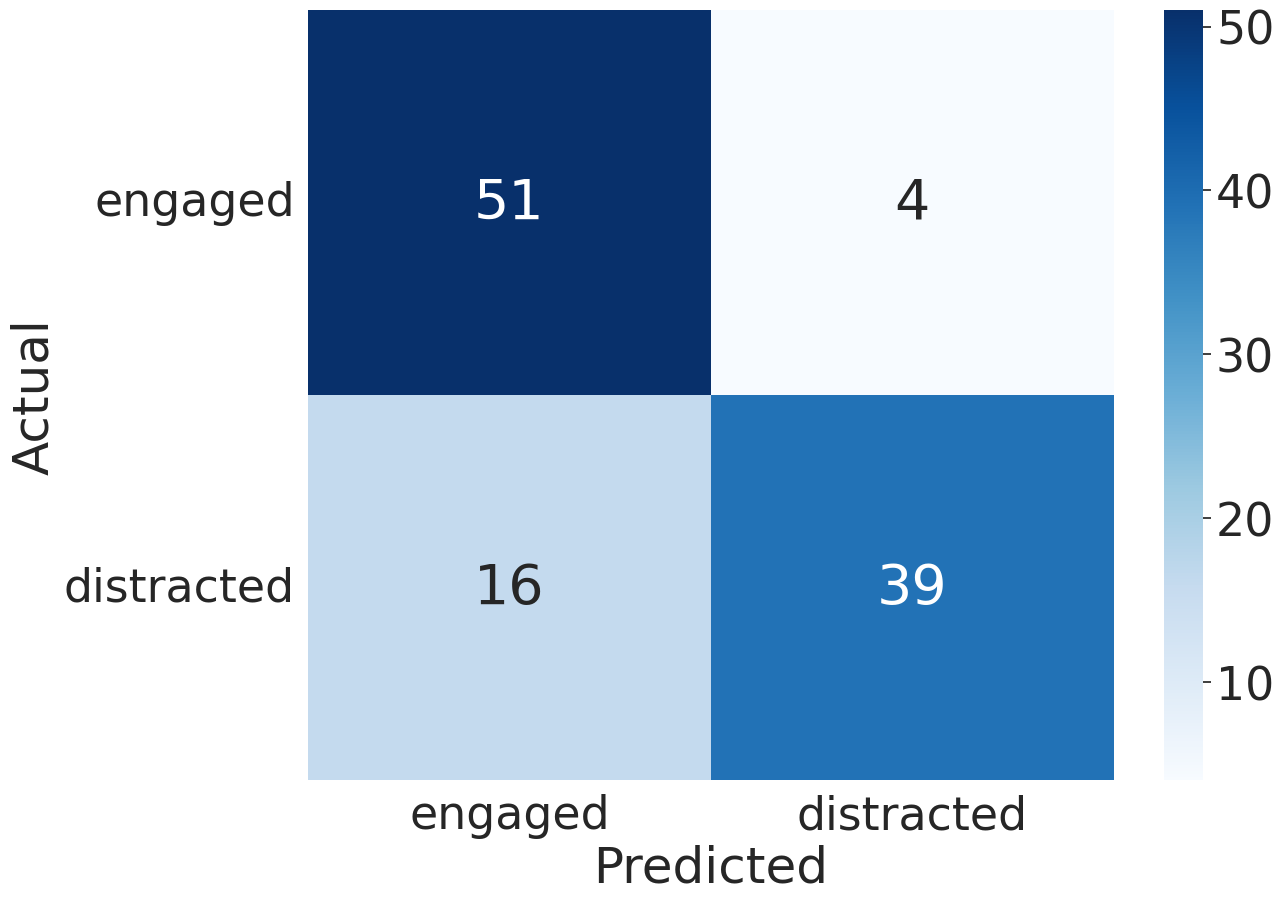

In [129]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [130]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Yana_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Kate_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Egor_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_std_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 R

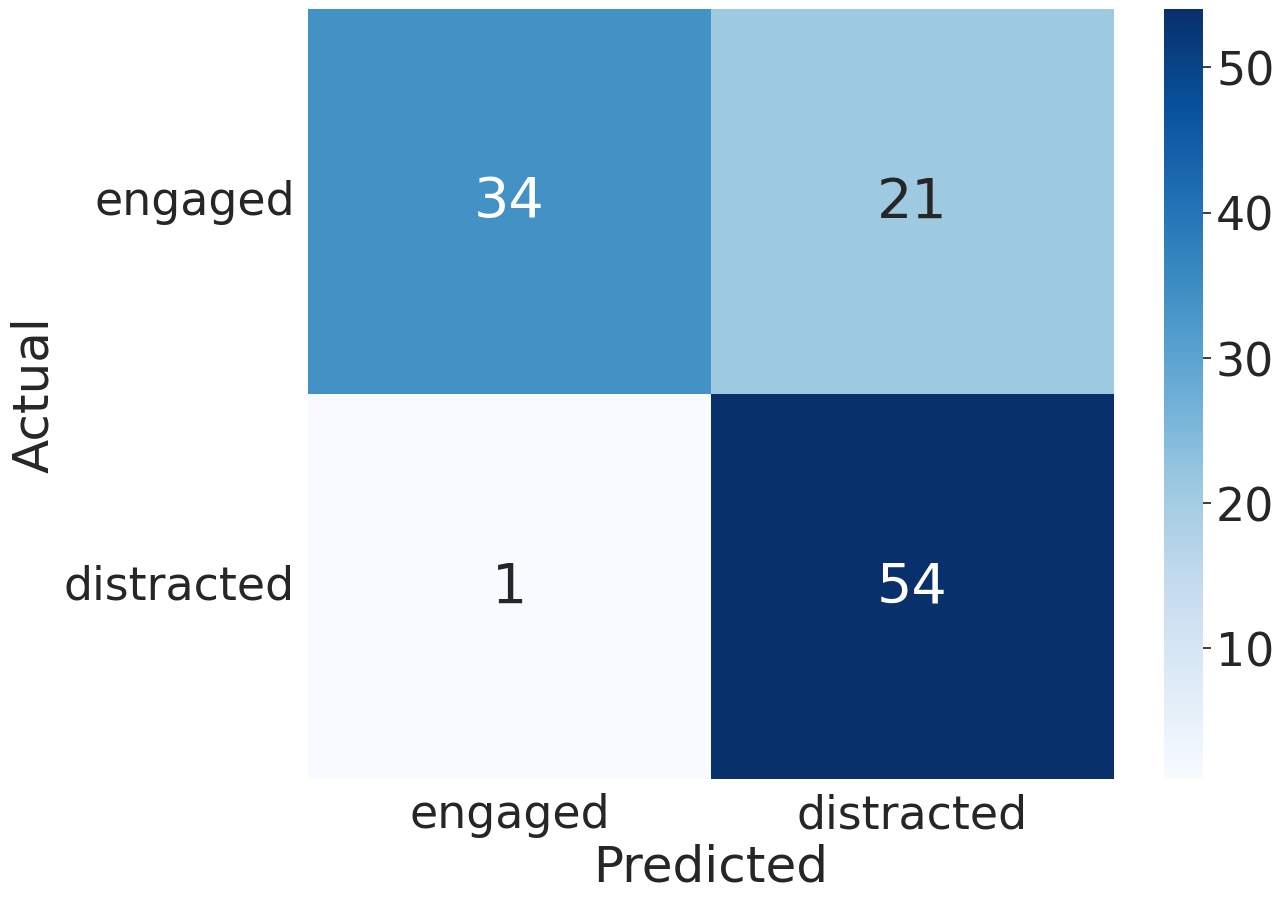

In [131]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [132]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2724 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2336 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1861 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1466 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1173 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0951 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0777 - precision: 1.0000 - recall: 1.000

In [133]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### STAT

In [134]:
stat_name = "STAT"
stat_func = compute_descriptor

#### Single attention

In [135]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [136]:
train_vid2features = all_train_vid2features

In [137]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [138]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                            

##### Universal model

In [139]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_STAT_single_attention_best


In [140]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [141]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Kate_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Egor_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Katya_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Den : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_

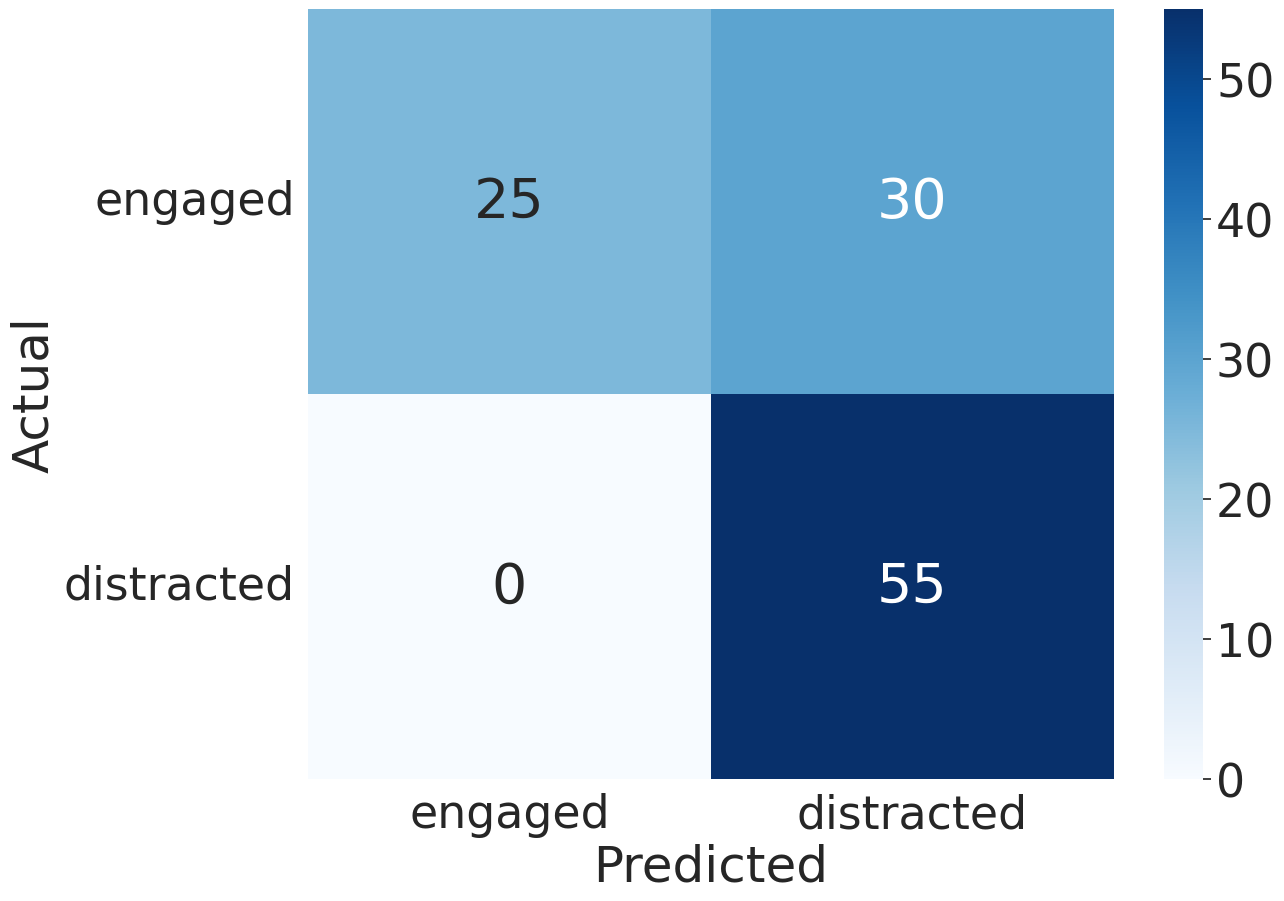

In [142]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [143]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Yana_adapted Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Actor Kate
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Kate_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Egor
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Egor_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Katya
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.84615384615

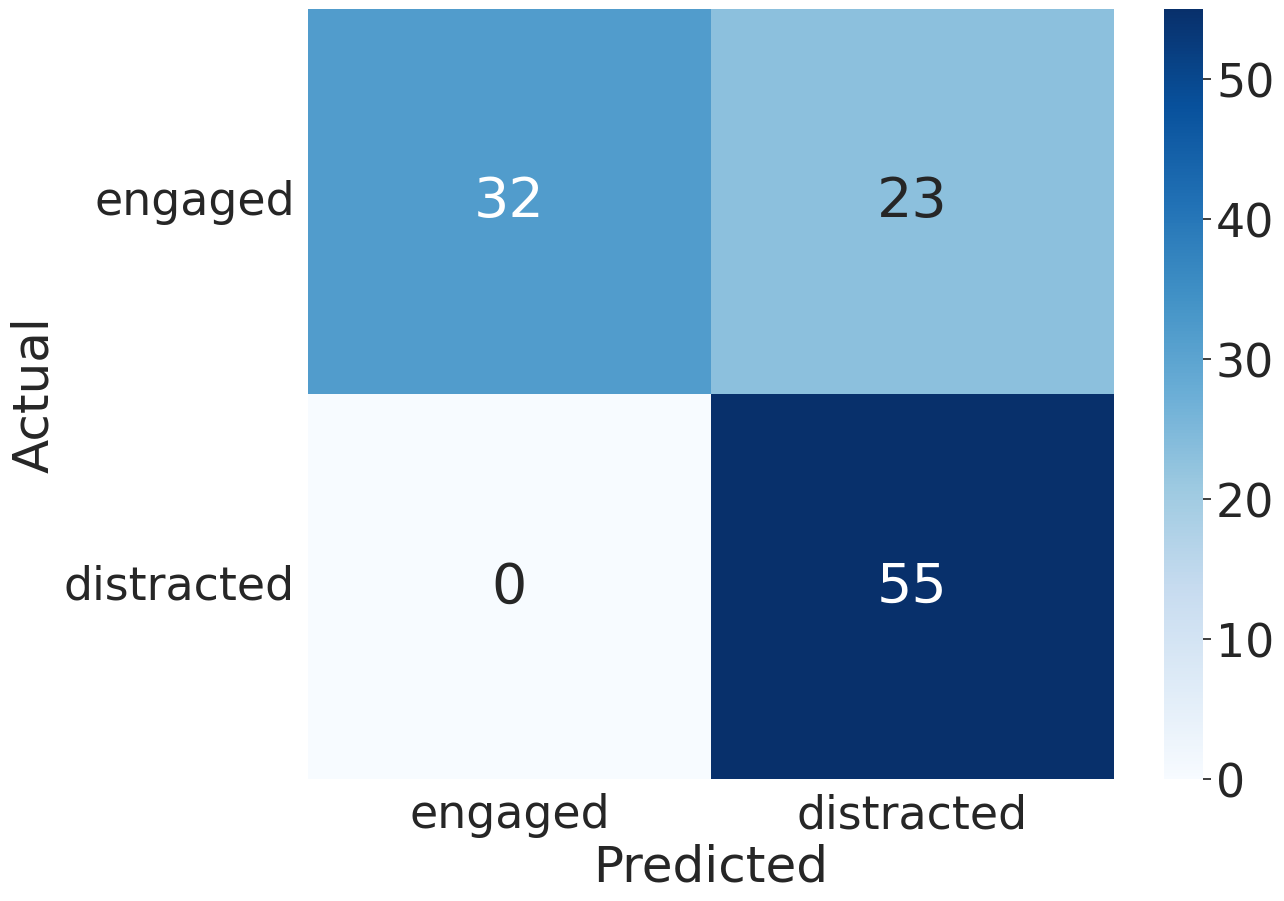

In [144]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [145]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3072) (2,)
		Actor Kate
(2, 70, 3072) (2,)
		Actor Egor
(2, 70, 3072) (2,)
		Actor Katya
(2, 70, 3072) (2,)
		Actor Den
(2, 70, 3072) (2,)
	Total, accuracy: 0.890909090909091, MSE: 0.1090909090909091, UAR: 0.890909090909091, Recall: 0.9636363636363636, Precision: 0.8613095238095237, F1: 0.901571658615137
Videos num:  2
		Actor Yana
(4, 70, 3072) (4,)
		Actor Kate
(4, 70, 3072) (4,)
		Actor Egor
(4, 70, 3072) (4,)
		Actor Katya
(4, 70, 3072) (4,)
		Actor Den
(4, 70, 3072) (4,)
	Total, accuracy: 0.809090909090909, MSE: 0.19090909090909092, UAR: 0.809090909090909, Recall: 1.0, Precision: 0.7513095238095238, F1: 0.8501292160646999
Videos num:  3
		Actor Yana
(6, 70, 3072) (6,)
		Actor Kate
(6, 70, 3072) (6,)
		Actor Egor
(6, 70, 3072) (6,)
		Actor Katya
(6, 70, 3072) (6,)
		Actor Den
(6, 70, 3072) (6,)
	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 1.0, Precision: 0.7756196581196582, F1: 0.8672512034581
V

In [146]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [147]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [148]:
train_vid2features = all_train_vid2features

In [149]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [150]:
train_vid2features = all_train_vid2features

In [151]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1572864   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1572864   ['image_set[0][0]']           
                                                                                                  
 attention_4 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']         

##### Universal model

In [152]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_STAT_self_attention_best


In [153]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [154]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.6363636363636364 Precision:  0.7 F1:  0.6666666666666666
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Kate_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Precision:  0.8333333333333334 F1:  0.8695652173913043
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.5454545454545454 Precision:  0.75 F1:  0.631578947368421
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Katya_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Den : 22
Metric_name:  mobilenet_7.h5_DAiSEE_

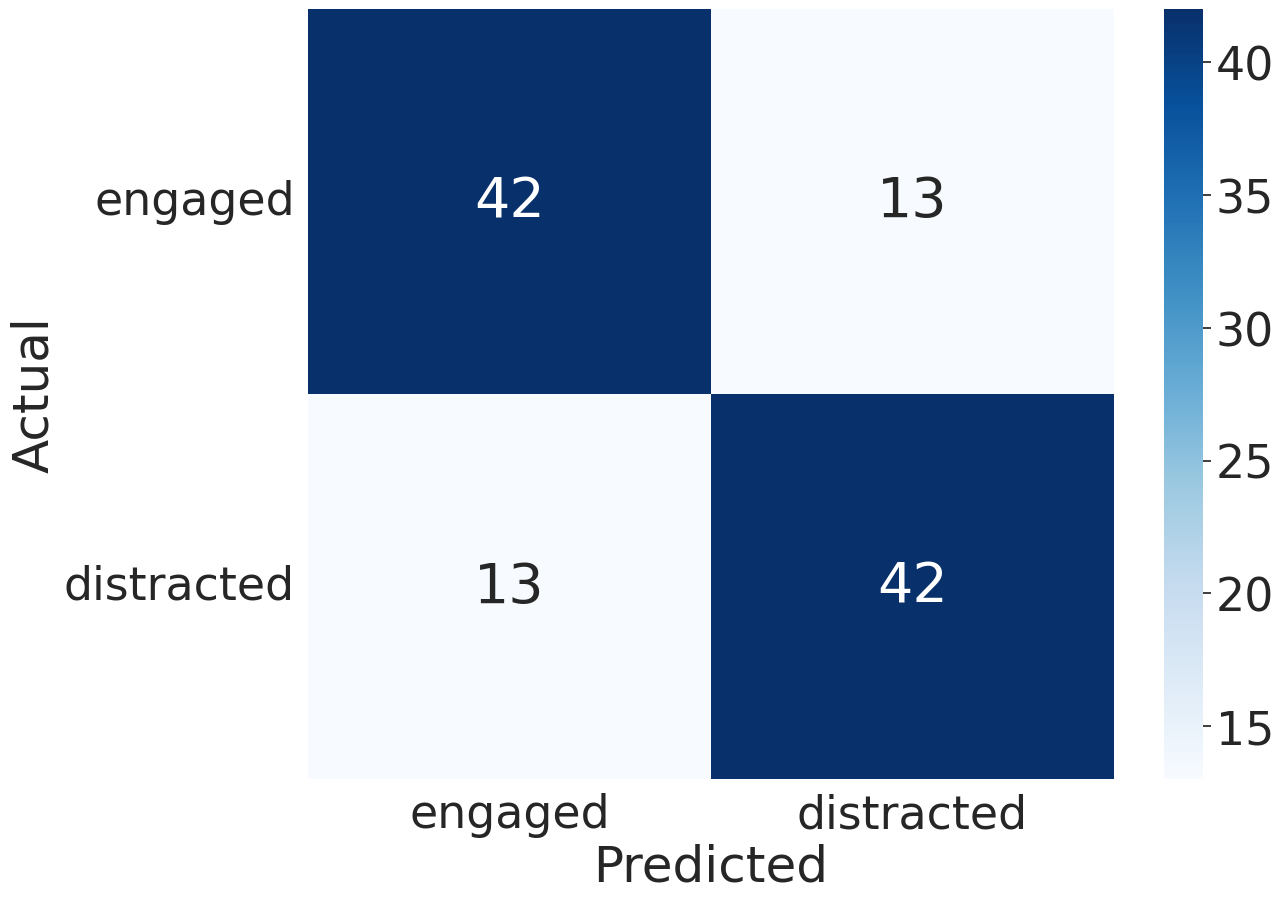

In [155]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [156]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Yana_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Kate
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Kate_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Egor
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Egor_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Katya
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Act

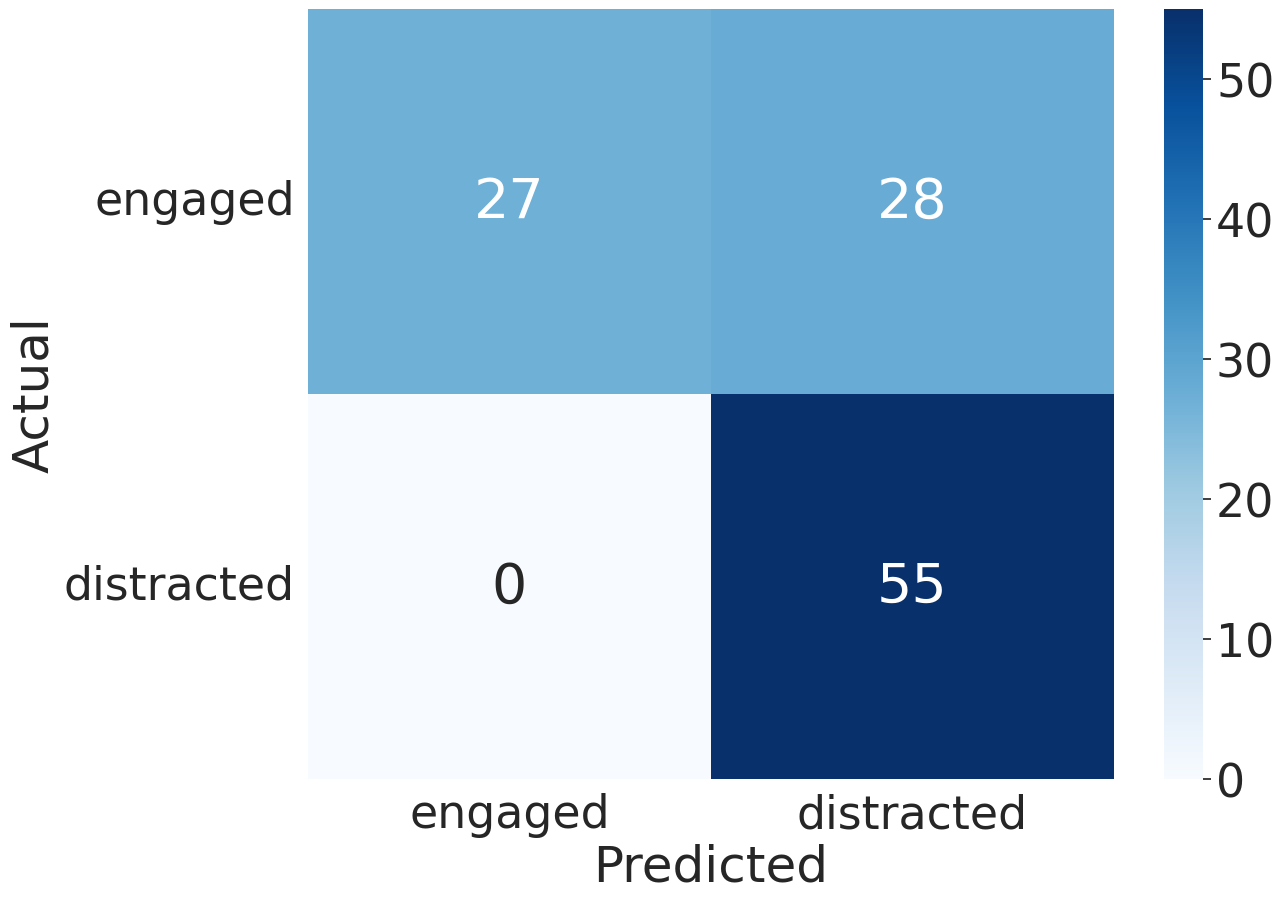

In [157]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [158]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3072) (2,)
Epoch 1/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2224 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1728 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1137 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0723 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0495 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0371 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0294 - precision: 1.0000 - recall: 1.000

In [159]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [160]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [161]:
train_vid2features = all_train_vid2features

In [162]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [163]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [164]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_STAT_single_attention_concat_false_best


In [165]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [166]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Yana_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Kate_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304

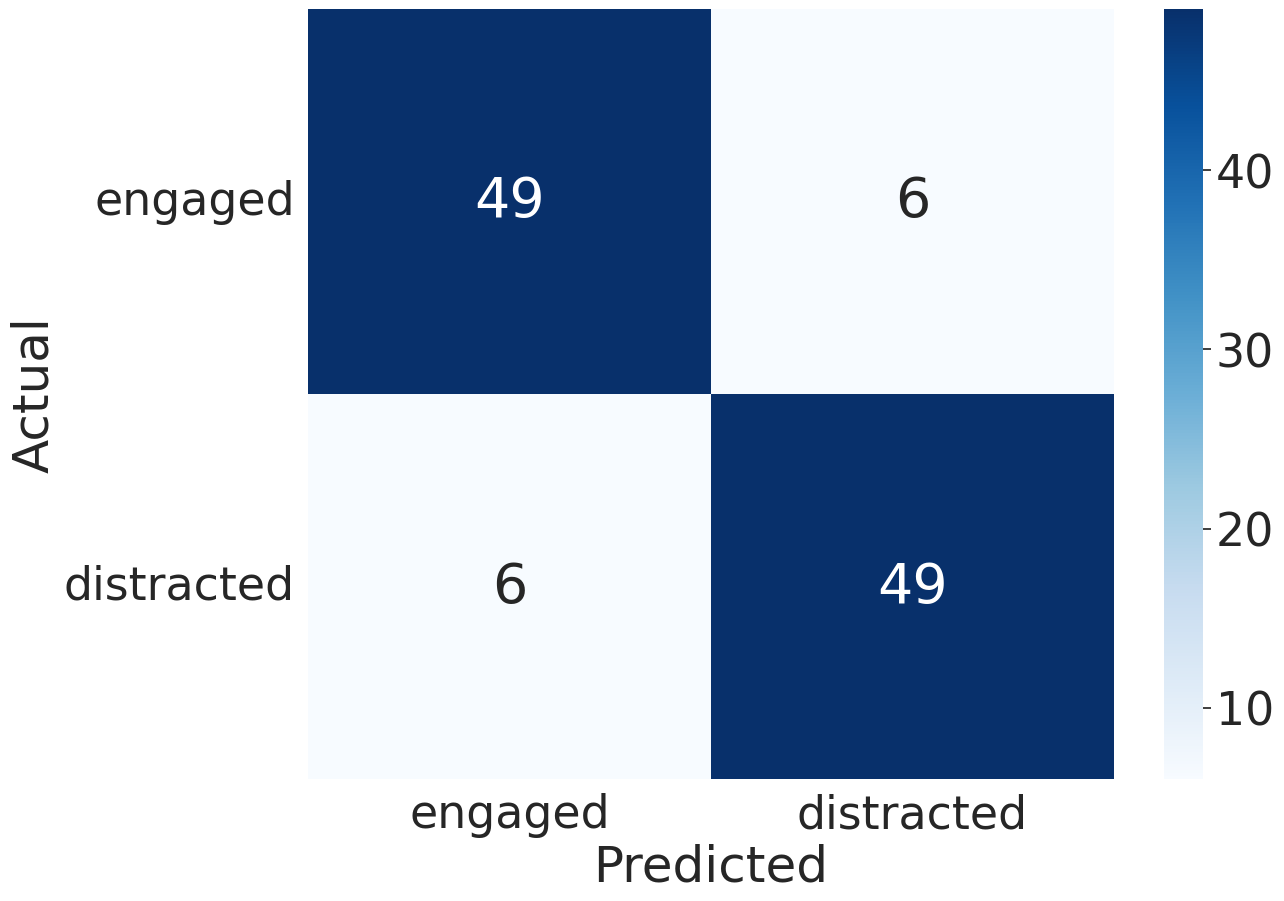

In [167]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [168]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Yana_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Kate_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Egor_adapted Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  1.0 Precision:  0.5 F1:  0.6666666666666666
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_single_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1: 

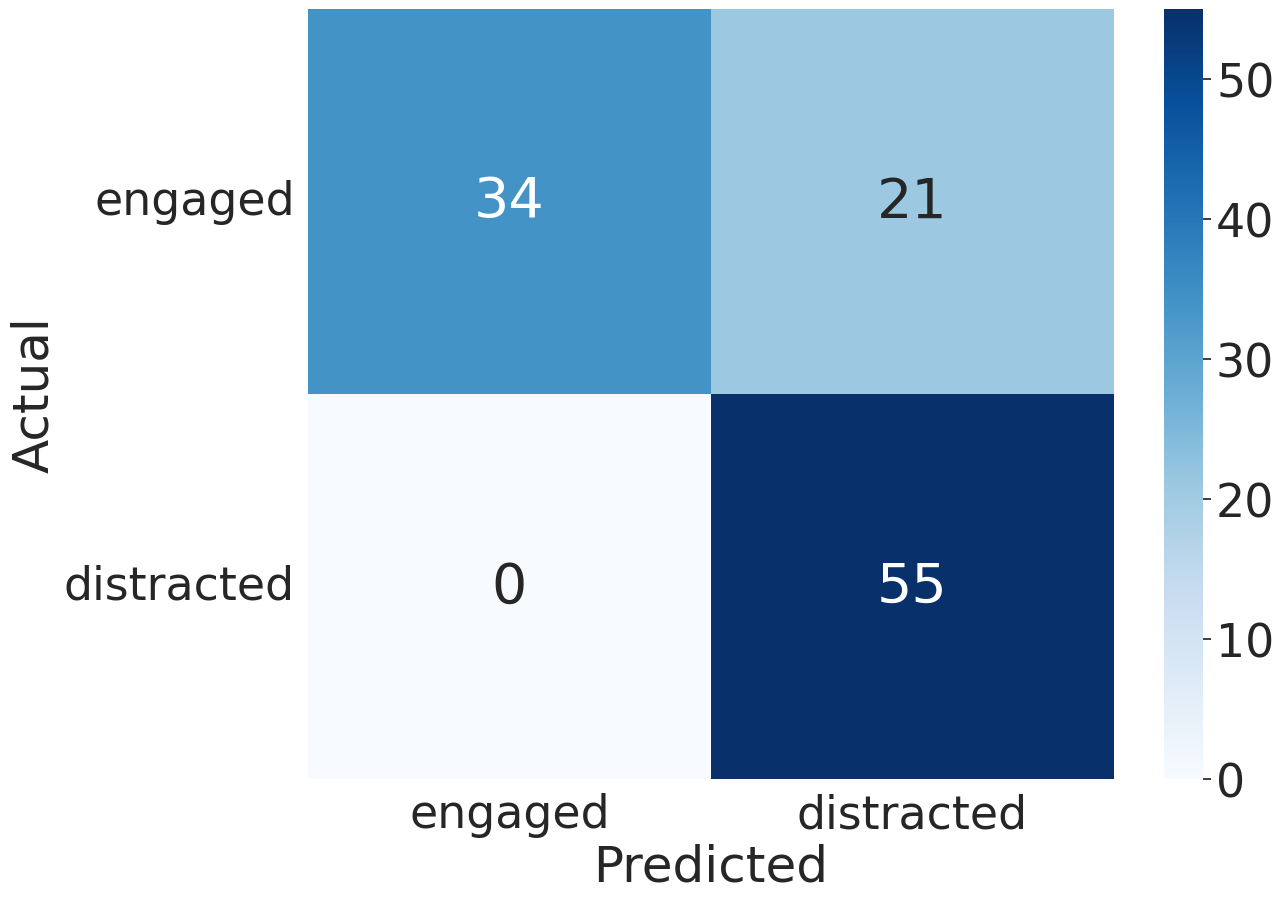

In [169]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [170]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.9818181818181818, MSE: 0.01818181818181818, UAR: 0.9818181818181818, Recall: 1.0, Precision: 0.9666666666666666, F1: 0.9826086956521738
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.9181818181818183, MSE: 0.08181818181818182, UAR: 0.9181818181818183, Recall: 1.0, Precision: 0.8794117647058822, F1: 0.9310559006211181
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.9636363636363636, MSE: 0.03636363636363636, UAR: 0.9636363636363636, Recall: 1.0, Precision: 0.9333333333333332, F1: 0.9652173913043478
Videos 

In [171]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [172]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [173]:
train_vid2features = all_train_vid2features

In [174]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [175]:
train_vid2features = all_train_vid2features

In [176]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_5 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [177]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_DAiSEE_2_STAT_self_attention_concat_false_best


In [178]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [179]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.6363636363636364 Precision:  1.0 F1:  0.7777777777777778
Kate : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Kate_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.5454545454545454 Precision:  0.75 F1:  0.631578947368421
Egor : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Katya : 22
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  0.8 F1:  0.5000000000000001
Den :

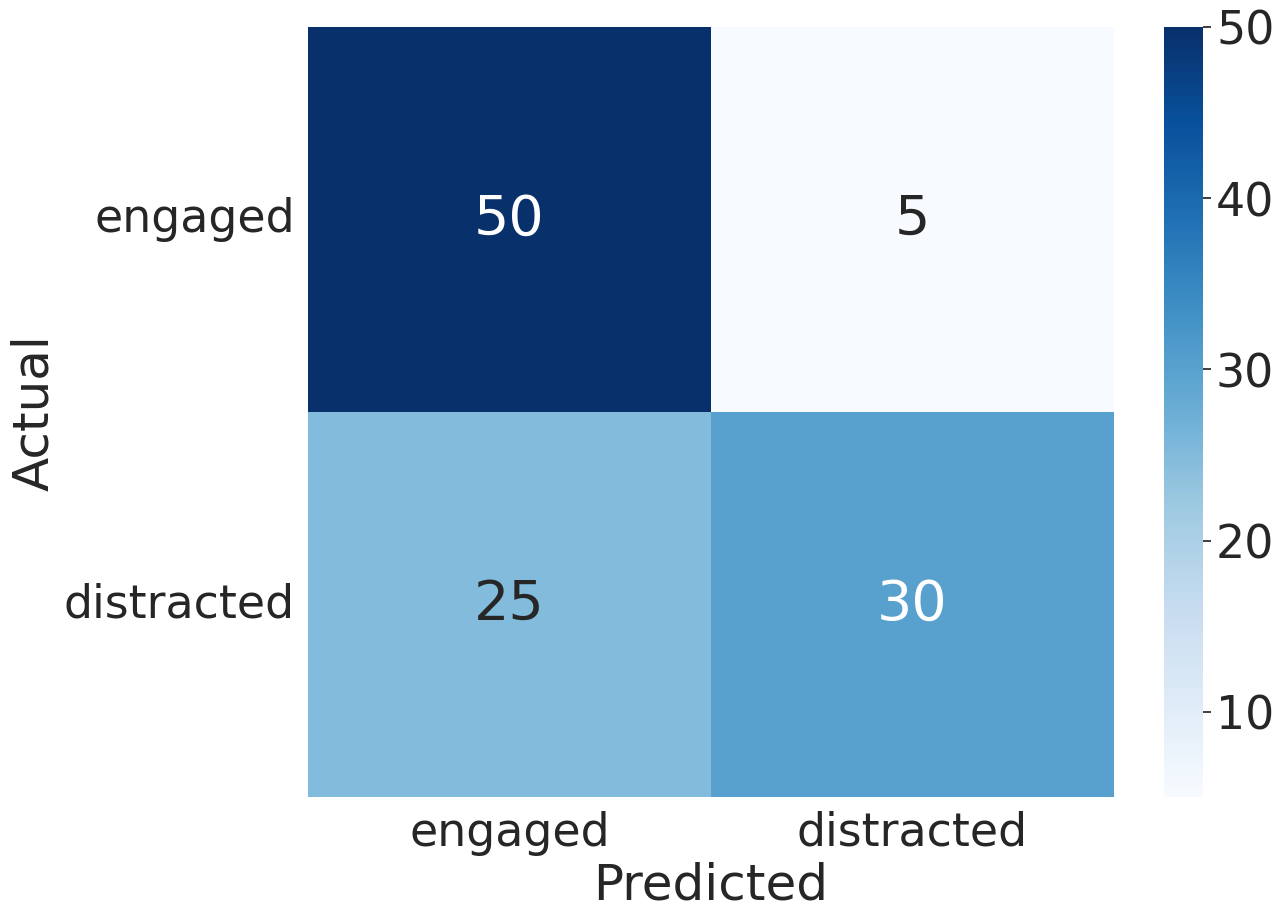

In [180]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [181]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Yana_adapted Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  1.0 Precision:  0.55 F1:  0.7096774193548387
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Egor_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_DAiSEE_STAT_self_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.84615384

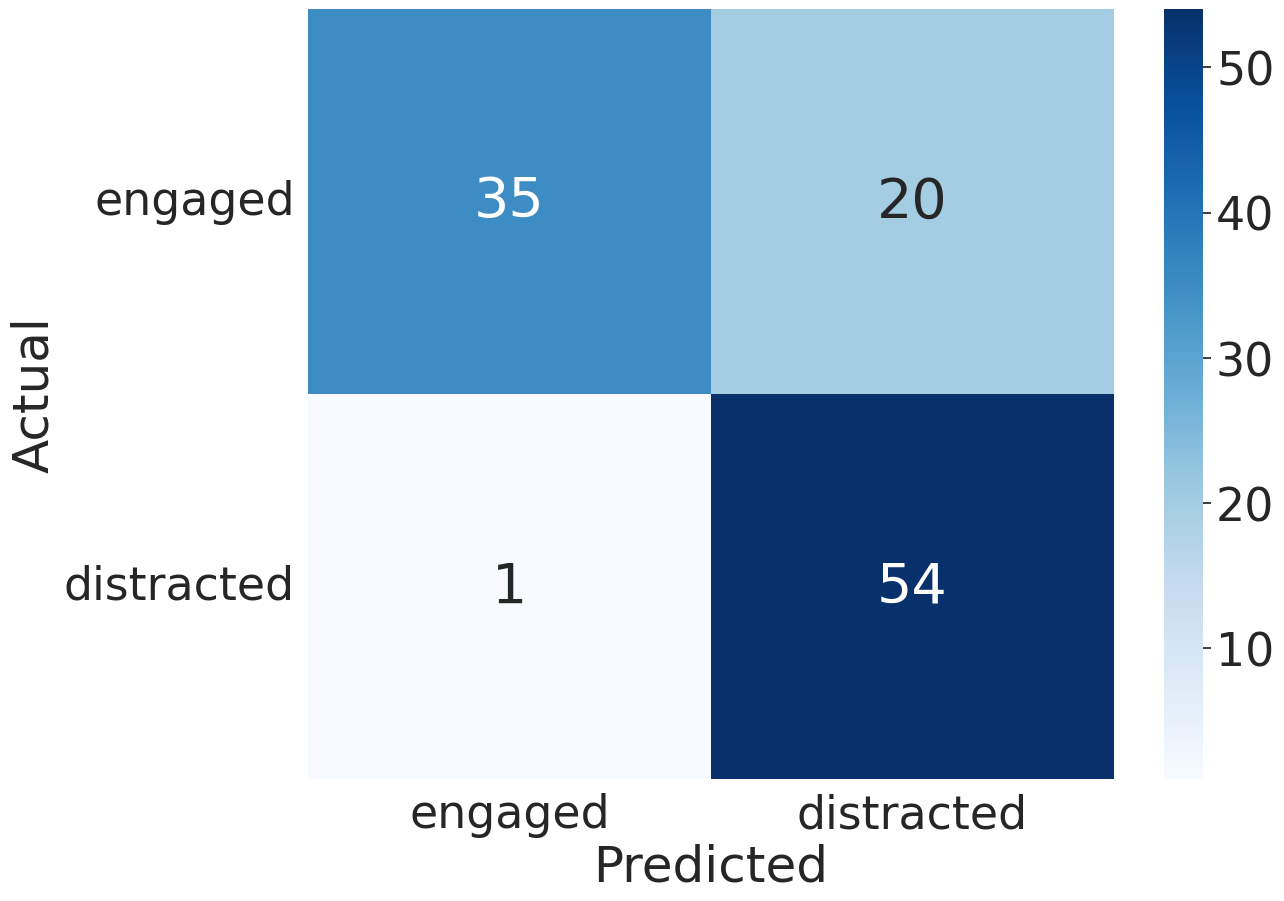

In [182]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [183]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 9ms/step - loss: 0.1367 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1290 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1181 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1060 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0941 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0830 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0733 - precision: 1.0000 - recall: 1.0000

In [184]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

# User adaptation EngageWild

In [185]:
DATASET_NAME = 'EngageWild'

## enet_b0_8_best_afew

In [ ]:
base_model_key = 'enet_b0_8_best_afew.pt'

In [ ]:
FEATURE_VECTOR_DIM = 2560
STAT_FEATURE_VECTOR_DIM = 3840
FEATURE_VECTOR_DIM_CONCAT_FALSE = int(FEATURE_VECTOR_DIM / 2)
STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE = FEATURE_VECTOR_DIM_CONCAT_FALSE

In [ ]:
if False:
    engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
    distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
    train_test_pickle = USERS_FEATURES + '{}_train_test_features_{}.pickle'.format(base_model_key, TEST_VIDEOS)
    keys_pickle = USERS_FEATURES + 'shuffled_keys.pickle'
    
    all_train_vid2features, test_vid2features = load_features_from_pickle(engaged_pickle, distracted_pickle, train_test_pickle, keys_pickle)
    for name in all_train_vid2features.keys():
        all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'] = remove_empty_features(all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'])
    for name in test_vid2features.keys():
        test_vid2features[name]['features'], test_vid2features[name]['labels'] = remove_empty_features(test_vid2features[name]['features'], test_vid2features[name]['labels'])

In [ ]:
if True:
    engaged_pickle = USERS_DATASET + 'features/engaged_features_{}.good.pickle'.format(base_model_key)
    distracted_pickle = USERS_DATASET + 'features/distracted_features_{}.good.pickle'.format(base_model_key)
    eng_vid2features = load_features(engaged_pickle)
    dis_vid2features = load_features(distracted_pickle)
    vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)
    
    train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)
    all_train_vid2features = train_vid2features
    
    if REVERSE_LABELS:
        for name in train_vid2features.keys():
            labels = train_vid2features[name]['labels']
            train_vid2features[name]['labels'] = [_get_label(l) for l in labels]
    
        for name in test_vid2features.keys():
            labels = test_vid2features[name]['labels']
            test_vid2features[name]['labels'] = [_get_label(l) for l in labels]

### Max

In [ ]:
stat_func=np.max
stat_name = "max"

#### Single attention

In [ ]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [ ]:
train_vid2features = all_train_vid2features

In [ ]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [ ]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

##### Universal model

In [196]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_max_single_attention_best


In [197]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [198]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Yana_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Kate : 22


/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Kate_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.0 Precision:  0.0 F1:  0.0
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.5454545454545454 Precision:  0.75 F1:  0.631578947368421
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Katya_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Den : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Den_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Total, accuracy: 0.6454545454545455, MSE: 0.35454545454545455, UAR: 0.6454545454545455, Recall: 0.36363636

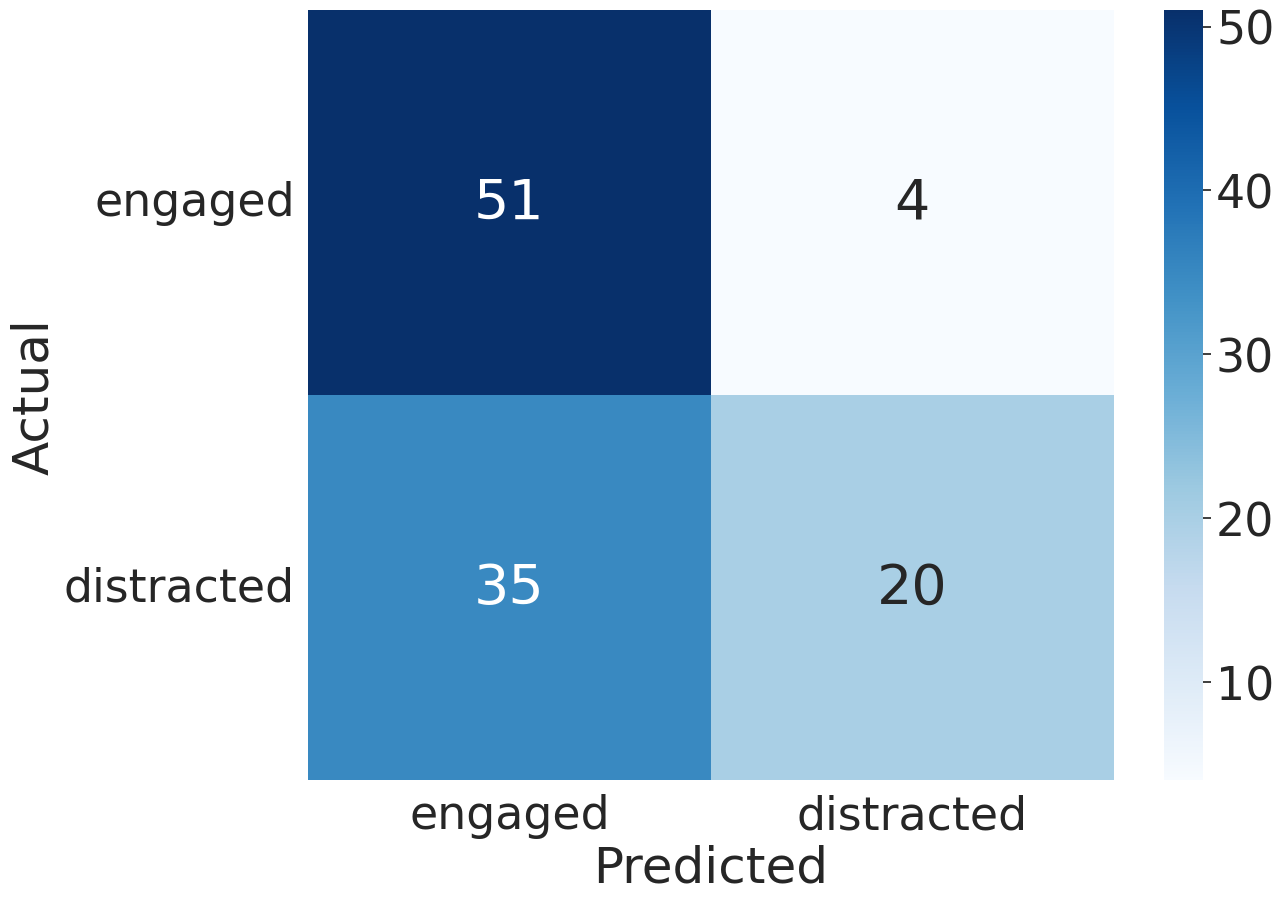

In [199]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [200]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Precision:  0.8333333333333334 F1:  0.8695652173913043
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.8181818181818182 Precision:  0.5294117647058824 F1:  0.6428571428571428
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Egor_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_best_Katya_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818

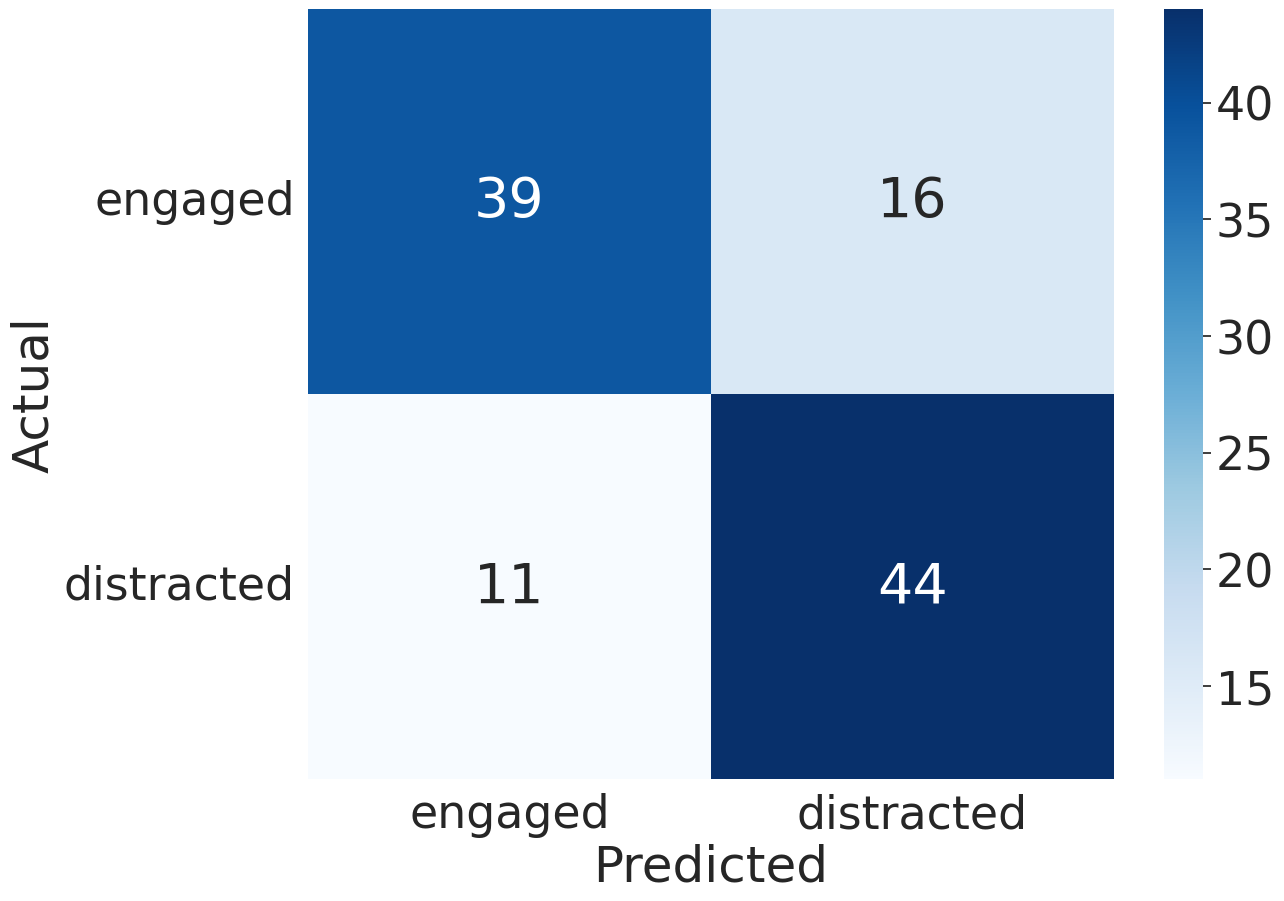

In [201]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [202]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
		Actor Kate
(2, 70, 2560) (2,)
		Actor Egor
(2, 70, 2560) (2,)
		Actor Katya
(2, 70, 2560) (2,)
		Actor Den
(2, 70, 2560) (2,)
	Total, accuracy: 0.7636363636363634, MSE: 0.2363636363636364, UAR: 0.7636363636363634, Recall: 0.6909090909090909, Precision: 0.8485714285714285, F1: 0.7454939309056956
Videos num:  2
		Actor Yana
(4, 70, 2560) (4,)
		Actor Kate
(4, 70, 2560) (4,)
		Actor Egor
(4, 70, 2560) (4,)
		Actor Katya
(4, 70, 2560) (4,)
		Actor Den
(4, 70, 2560) (4,)
	Total, accuracy: 0.809090909090909, MSE: 0.1909090909090909, UAR: 0.809090909090909, Recall: 0.8, Precision: 0.8711111111111111, F1: 0.8124408384043272
Videos num:  3
		Actor Yana
(6, 70, 2560) (6,)
		Actor Kate
(6, 70, 2560) (6,)
		Actor Egor
(6, 70, 2560) (6,)
		Actor Katya
(6, 70, 2560) (6,)
		Actor Den
(6, 70, 2560) (6,)
	Total, accuracy: 0.8181818181818181, MSE: 0.18181818181818182, UAR: 0.8181818181818181, Recall: 0.909090909090909, Precision: 0.8287581699346405, F1: 0

In [203]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [204]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [205]:
train_vid2features = all_train_vid2features

In [206]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [207]:
train_vid2features = all_train_vid2features

In [208]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_6 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [209]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_max_self_attention_best


In [210]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [211]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Kate : 22


/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Kate_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.0 Precision:  0.0 F1:  0.0
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.6363636363636364 Precision:  0.875 F1:  0.7368421052631579
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Den : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Den_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Total, accuracy: 0.7, MSE: 0.30000000000000004, UAR: 0.7, Recall: 0.4727272727272728,

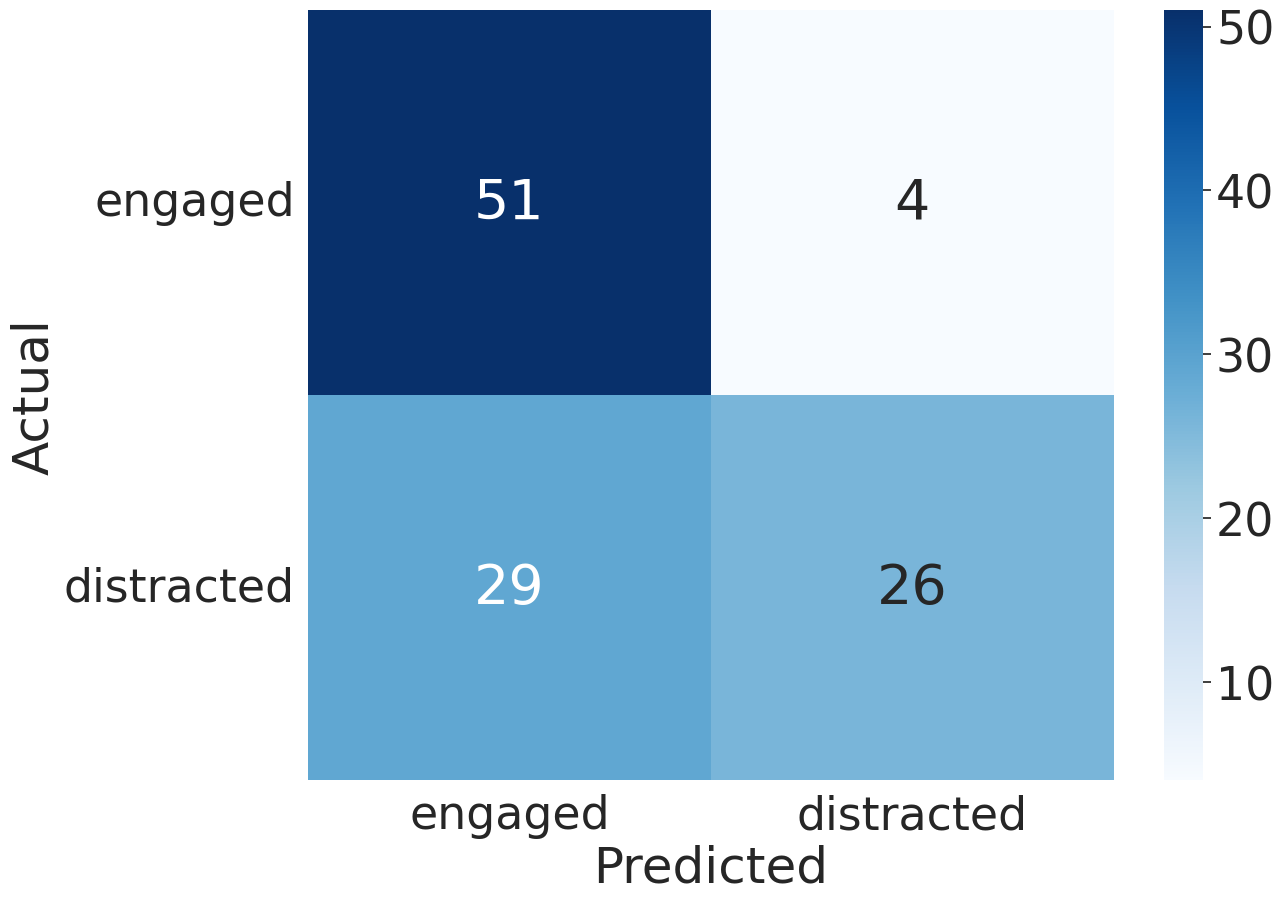

In [212]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [213]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Kate_adapted Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  1.0 Precision:  0.55 F1:  0.7096774193548387
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Egor_adapted Accuracy:  1.0 MSE:  0.0 UAR:  1.0 Recall:  1.0 Precision:  1.0 F1:  1.0
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_best_Katya_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.9090909090909091 Precision:  0.625 F1:  0.7407407407407406
Actor Den
(10, 70, 2560) 

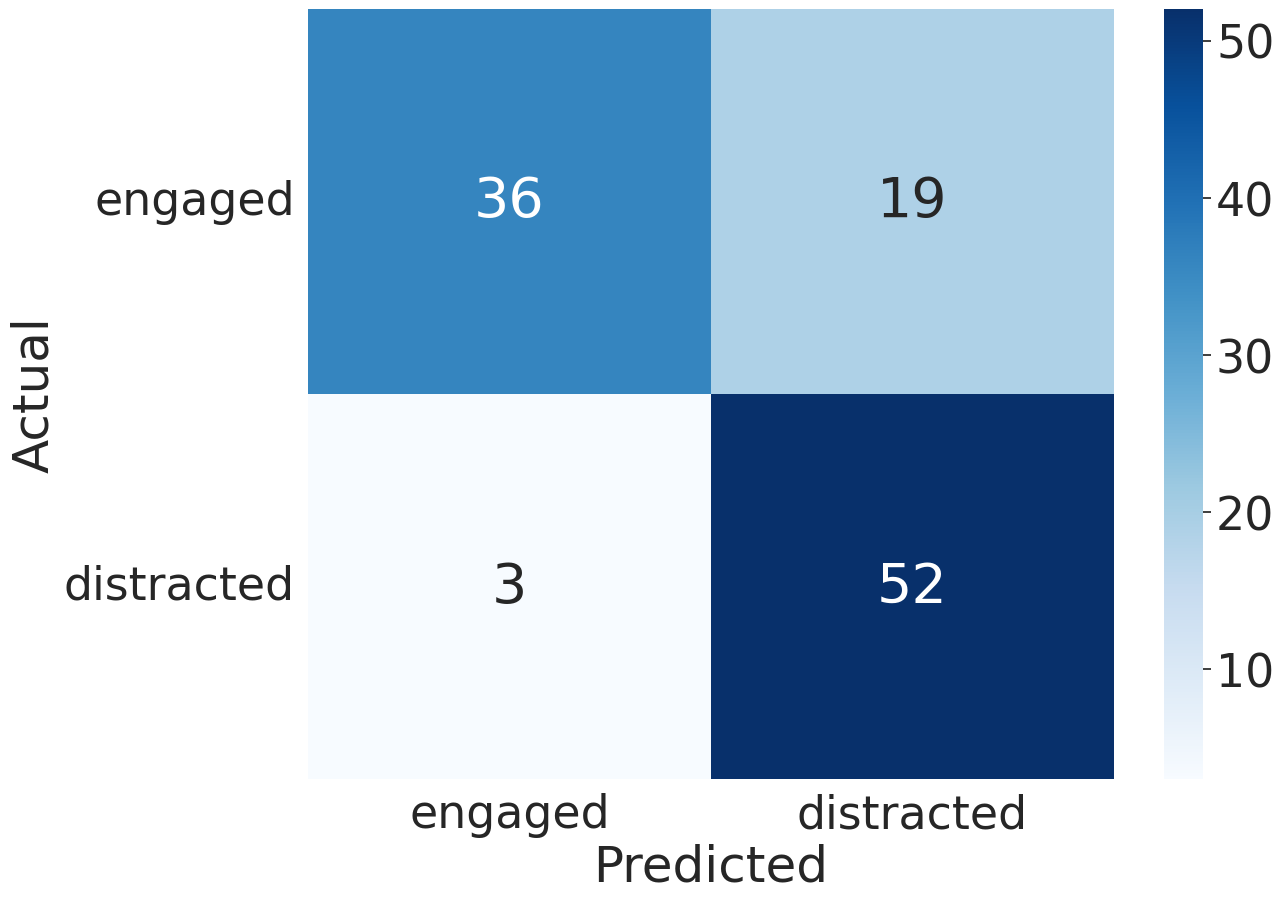

In [214]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [215]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0058 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0055 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0051 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0048 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0046 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0043 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0041 - precision: 1.0000 - recall: 1.000

In [216]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [217]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [218]:
train_vid2features = all_train_vid2features

In [219]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [220]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [221]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_max_single_attention_concat_false_best


In [222]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [223]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.7777777777777778 F1:  0.7000000000000001
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Kate_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.2727272727272727 Precision:  0.6 F1:  0.37499999999999994
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  

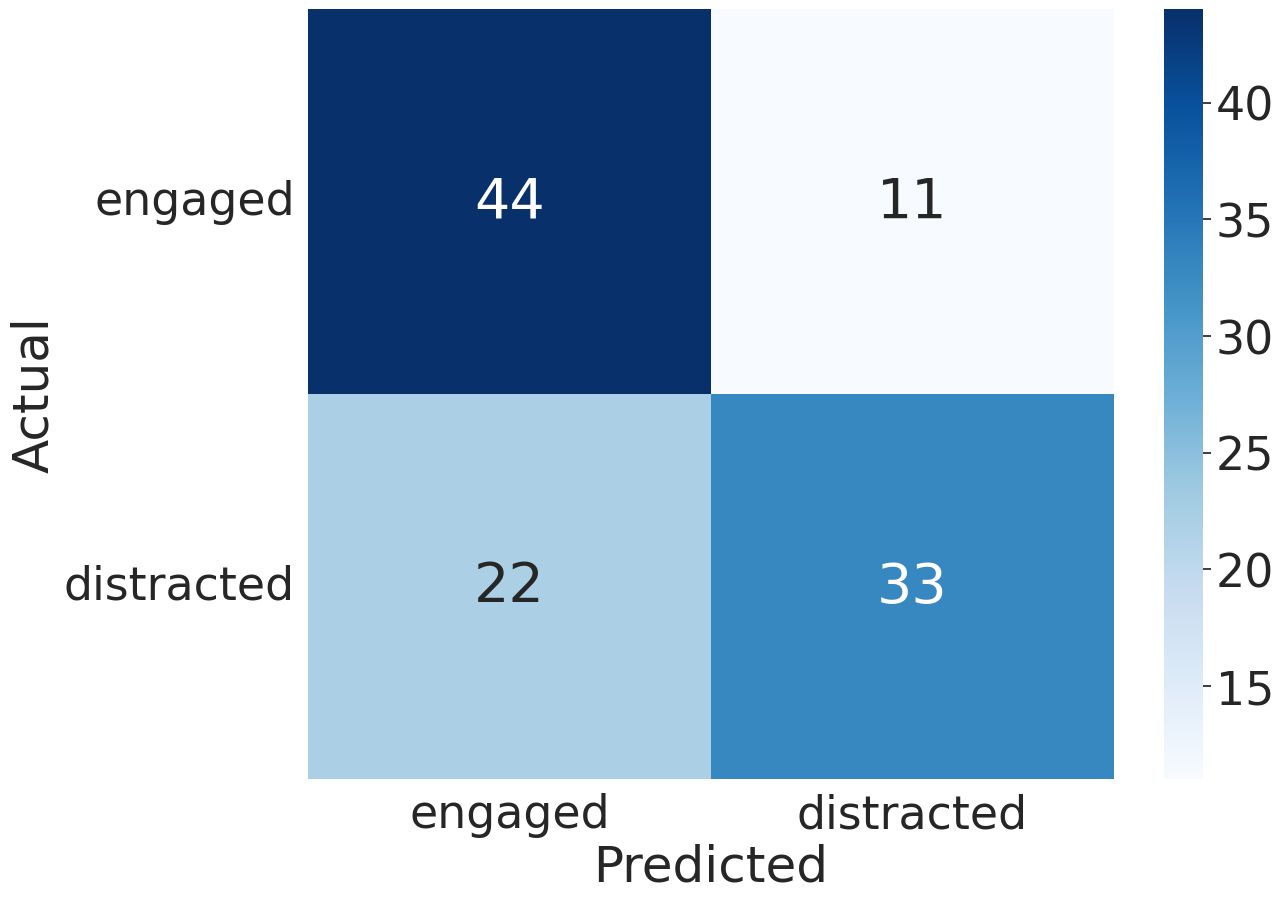

In [224]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [225]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Yana_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_single_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0

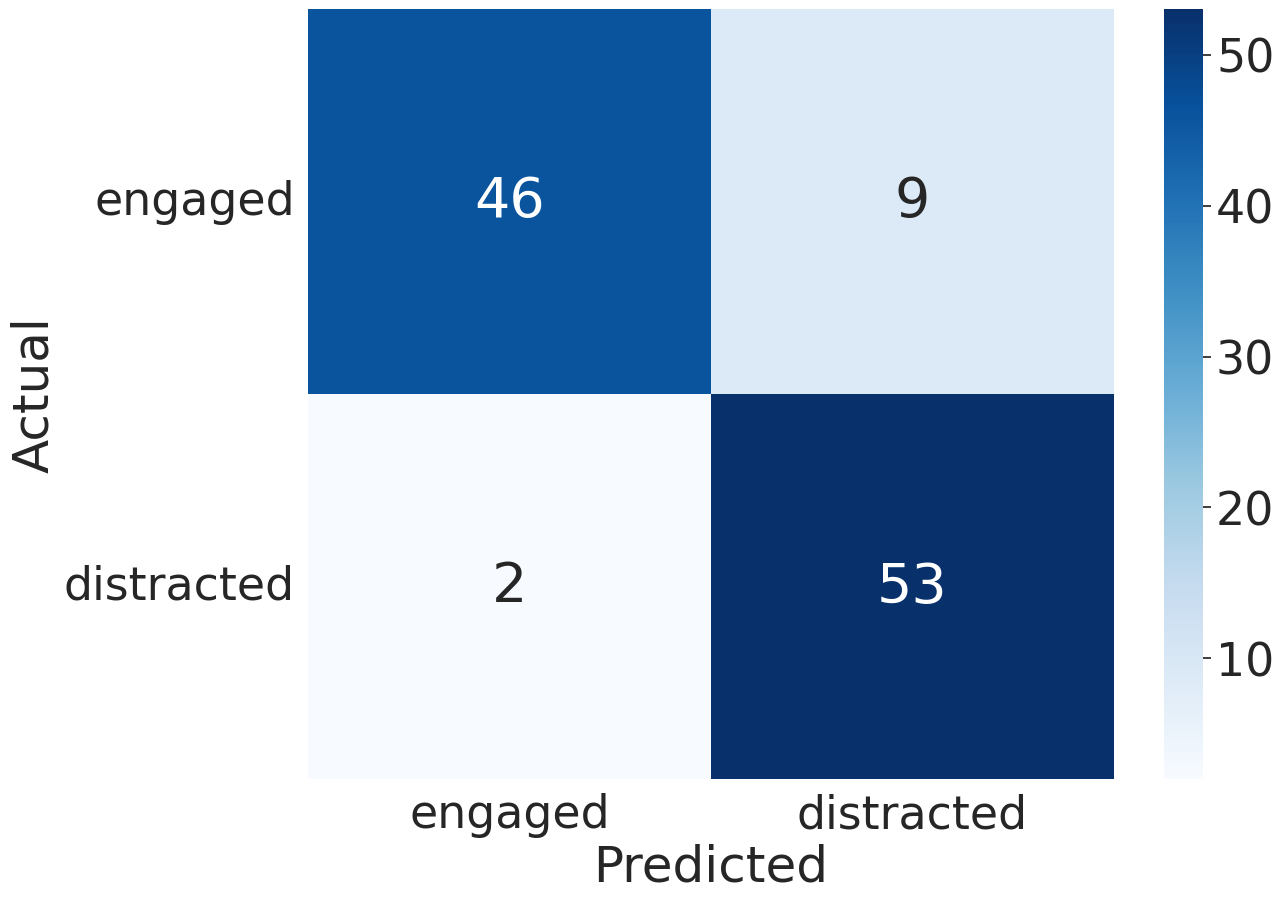

In [226]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [227]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.9090909090909092, MSE: 0.09090909090909091, UAR: 0.9090909090909092, Recall: 0.8545454545454547, Precision: 0.9692307692307693, F1: 0.9022305764411028
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.9, MSE: 0.1, UAR: 0.9, Recall: 0.9272727272727274, Precision: 0.8930402930402931, F1: 0.9037225672877847
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.9272727272727274, MSE: 0.07272727272727272, UAR: 0.9272727272727274, Recall: 0.9454545454545455, Precision: 0.9238095238095237, F1: 0.9308654244306418
Videos n

In [228]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [229]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [230]:
train_vid2features = all_train_vid2features

In [231]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [232]:
train_vid2features = all_train_vid2features

In [233]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_7 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [234]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_max_self_attention_concat_false_best


In [235]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [236]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Yana_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Precision:  0.8333333333333334 F1:  0.8695652173913043
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Kate_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Egor_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.9090909090909091 Precision:  0.7692307692307693 F1:  0.8333333333333333
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Katya_universal Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  0.2727272727272727 Precision:  0.5 F

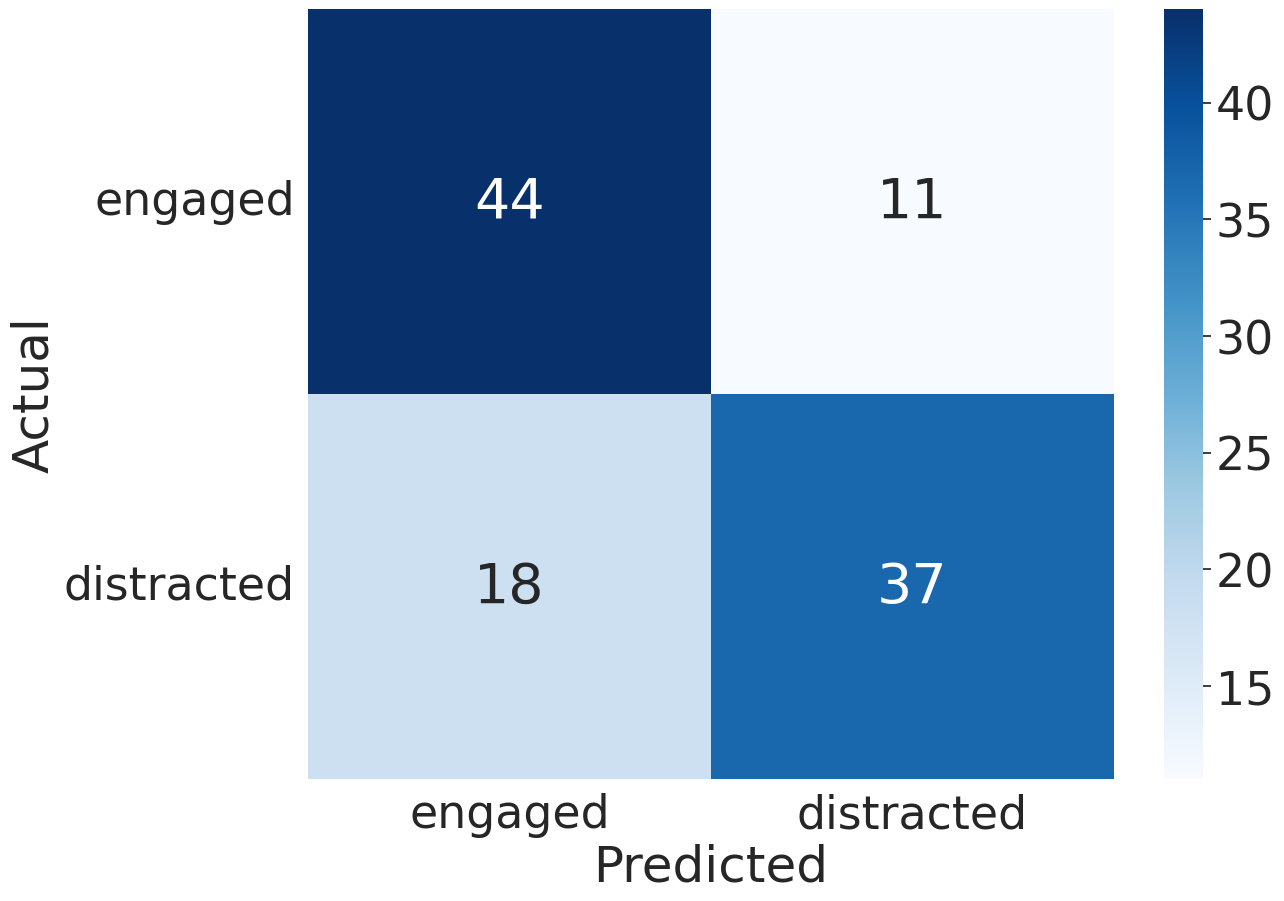

In [237]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [238]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Yana_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Kate_adapted Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  1.0 Precision:  0.55 F1:  0.7096774193548387
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_max_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MS

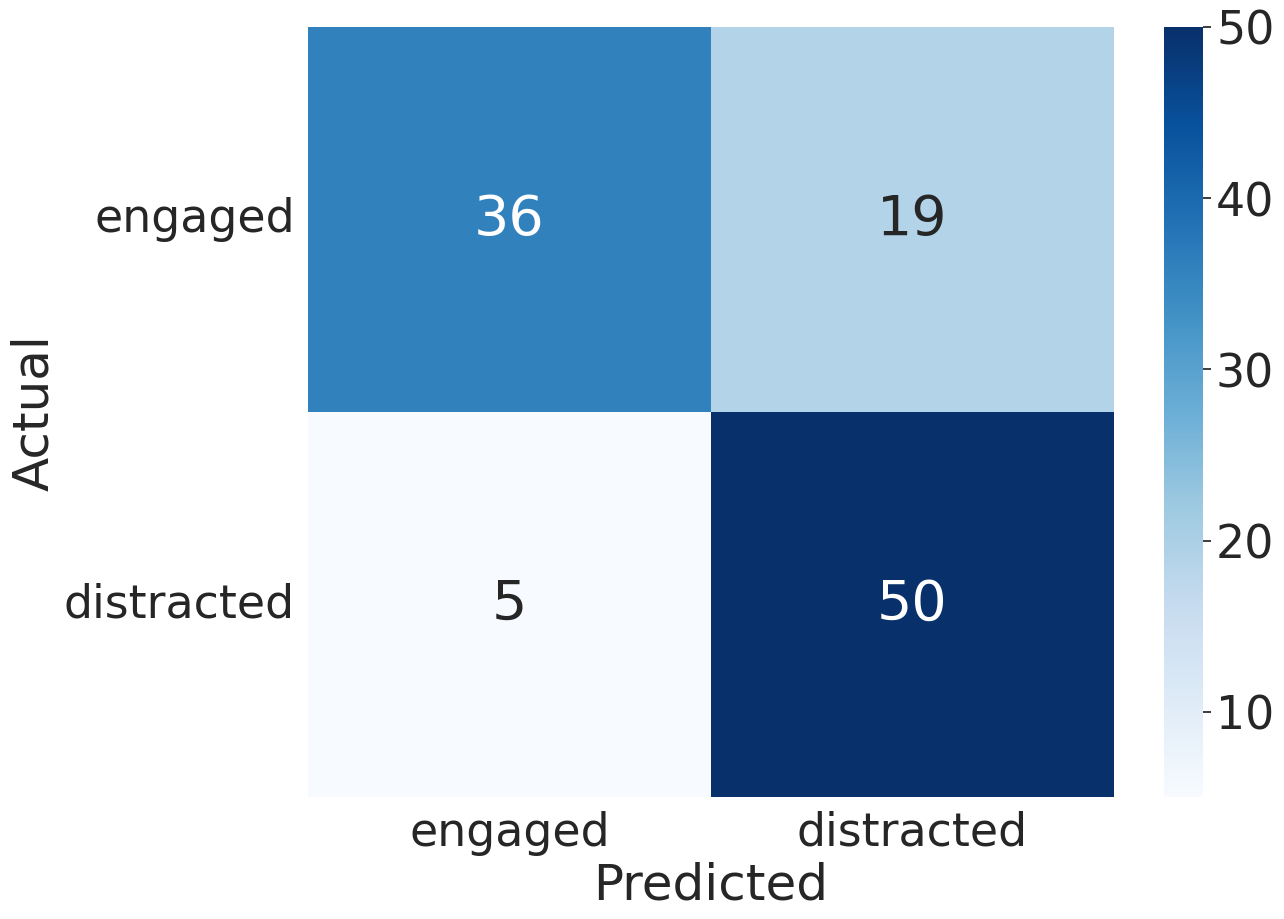

In [239]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [240]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0036 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0036 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0035 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0034 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0033 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0032 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0030 - precision: 1.0000 - recall: 1.000

In [241]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### Std

In [242]:
stat_func=np.std
stat_name = "std"

#### Single attention

In [243]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [244]:
train_vid2features = all_train_vid2features

In [245]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [246]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2561      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [247]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_std_single_attention_best


In [248]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [249]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Kate_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.45454545454545453 Precision:  0.7142857142857143 F1:  0.5555555555555556
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.7272727272727273 Precision:  0.6666666666666666 F1:  0.6956521739130435
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Katya_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Pr

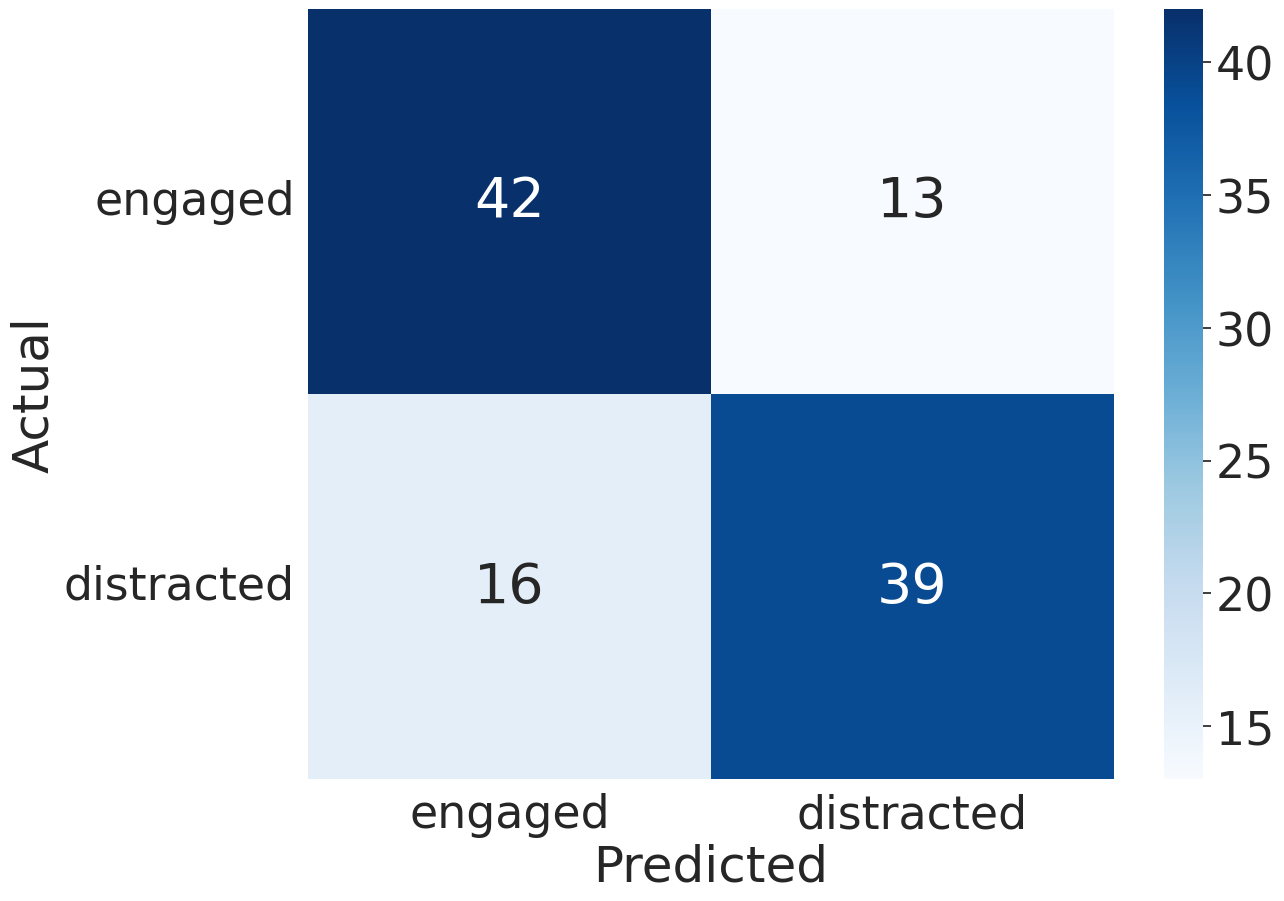

In [250]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [251]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Kate_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall

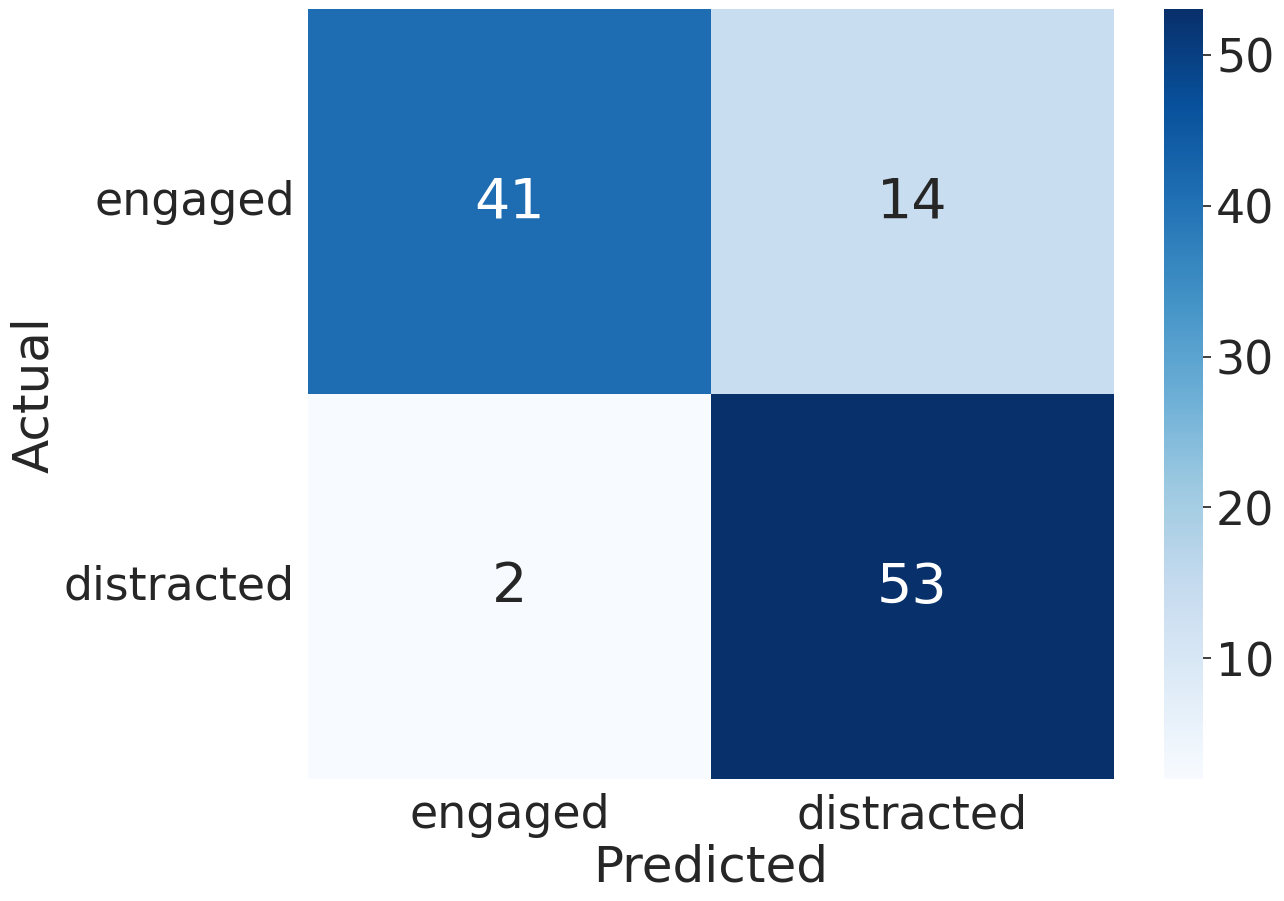

In [252]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [253]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
		Actor Kate
(2, 70, 2560) (2,)
		Actor Egor
(2, 70, 2560) (2,)
		Actor Katya
(2, 70, 2560) (2,)
		Actor Den
(2, 70, 2560) (2,)
	Total, accuracy: 0.7545454545454545, MSE: 0.24545454545454545, UAR: 0.7545454545454545, Recall: 0.7636363636363637, Precision: 0.7842680195621372, F1: 0.7504405398523046
Videos num:  2
		Actor Yana
(4, 70, 2560) (4,)
		Actor Kate
(4, 70, 2560) (4,)
		Actor Egor
(4, 70, 2560) (4,)
		Actor Katya
(4, 70, 2560) (4,)
		Actor Den
(4, 70, 2560) (4,)
	Total, accuracy: 0.7818181818181817, MSE: 0.21818181818181817, UAR: 0.7818181818181817, Recall: 0.8727272727272727, Precision: 0.7652777777777777, F1: 0.8016850305006227
Videos num:  3
		Actor Yana
(6, 70, 2560) (6,)
		Actor Kate
(6, 70, 2560) (6,)
		Actor Egor
(6, 70, 2560) (6,)
		Actor Katya
(6, 70, 2560) (6,)
		Actor Den
(6, 70, 2560) (6,)
	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.9818181818181818, Precision: 0.785

In [254]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [255]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [256]:
train_vid2features = all_train_vid2features

In [257]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [258]:
train_vid2features = all_train_vid2features

In [259]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2560)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1310720   ['image_set[0][0]']           
                                                                                                  
 attention_8 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [260]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_std_self_attention_best


In [261]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [262]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Yana_universal Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Kate_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Egor_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.9090909090909091 Precision:  0.6666666666666666 F1:  0.7692307692307692
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334


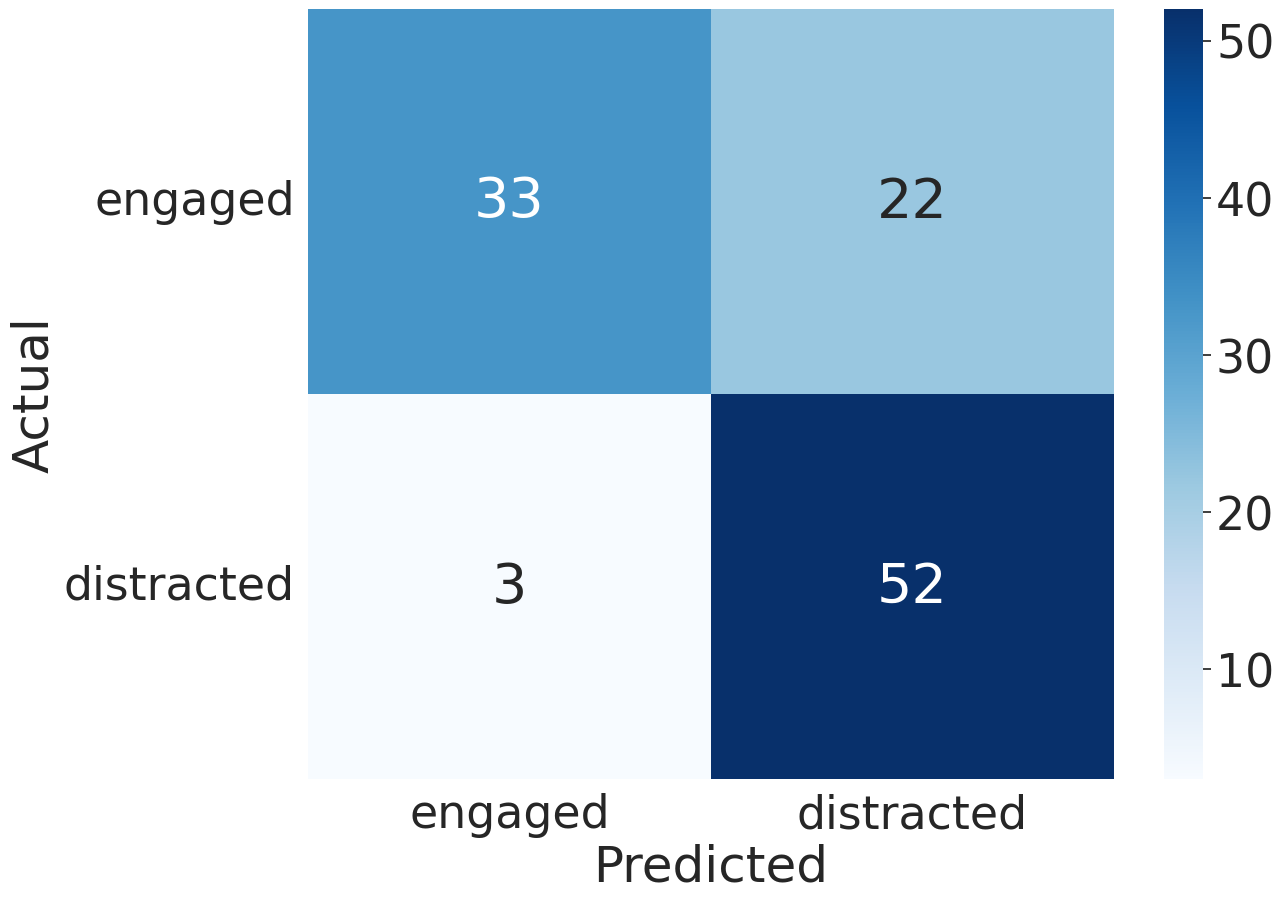

In [263]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [264]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Kate_adapted Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  1.0 Precision:  0.55 F1:  0.7096774193548387
Actor Egor
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Katya
(10, 70, 2560) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_best_Katya_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091

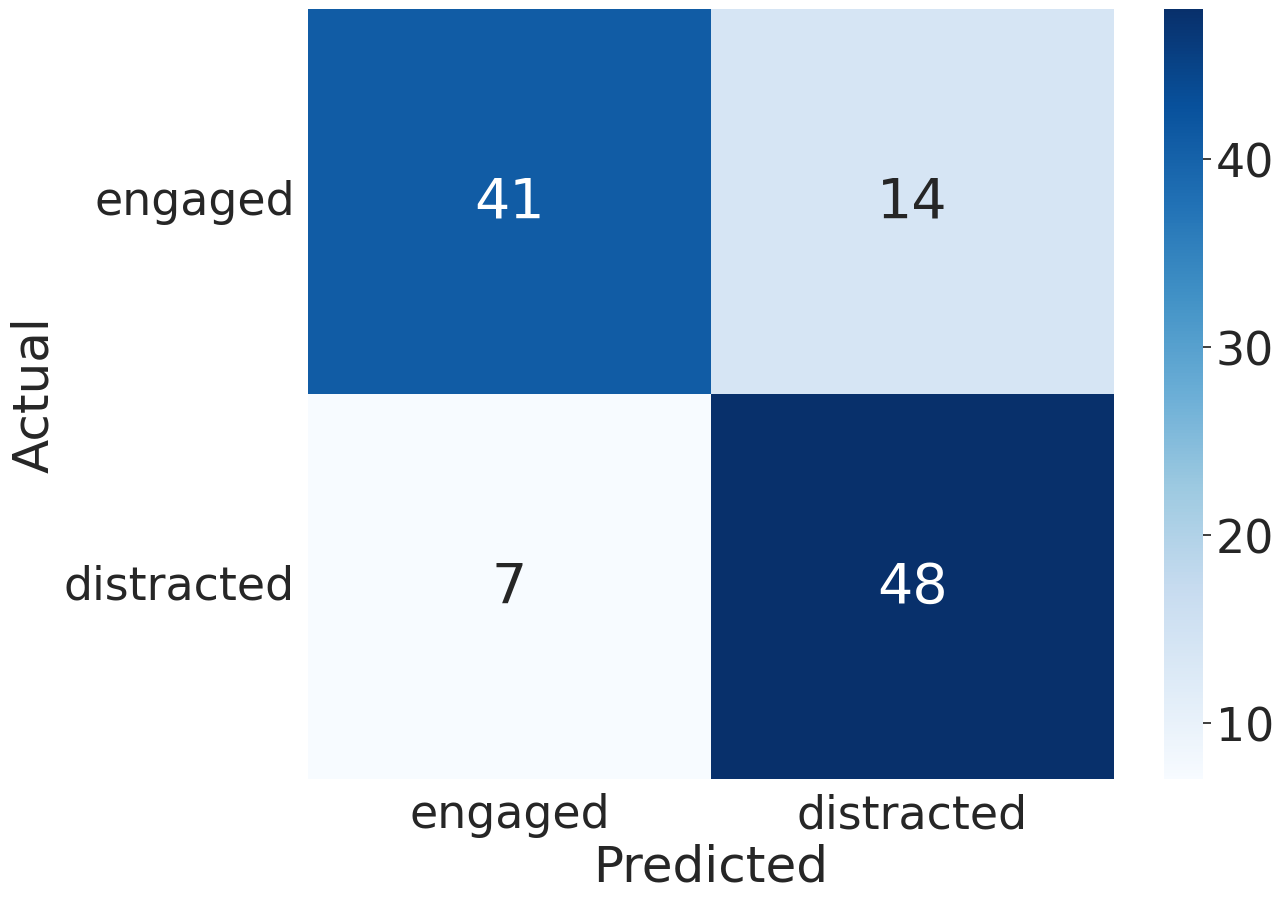

In [265]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [266]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2560) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0036 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0032 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0029 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0026 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0022 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0020 - precision: 1.0000 - recall: 1.000

In [267]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [268]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [269]:
train_vid2features = all_train_vid2features

In [270]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [271]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [272]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_std_single_attention_concat_false_best


In [273]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [274]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.5454545454545454 Precision:  0.75 F1:  0.631578947368421
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.2727272727272727 Precision:  0.75 F1:  0.39999999999999997
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Egor_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.7777777777777778 F1:  0.7000000000000001
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  

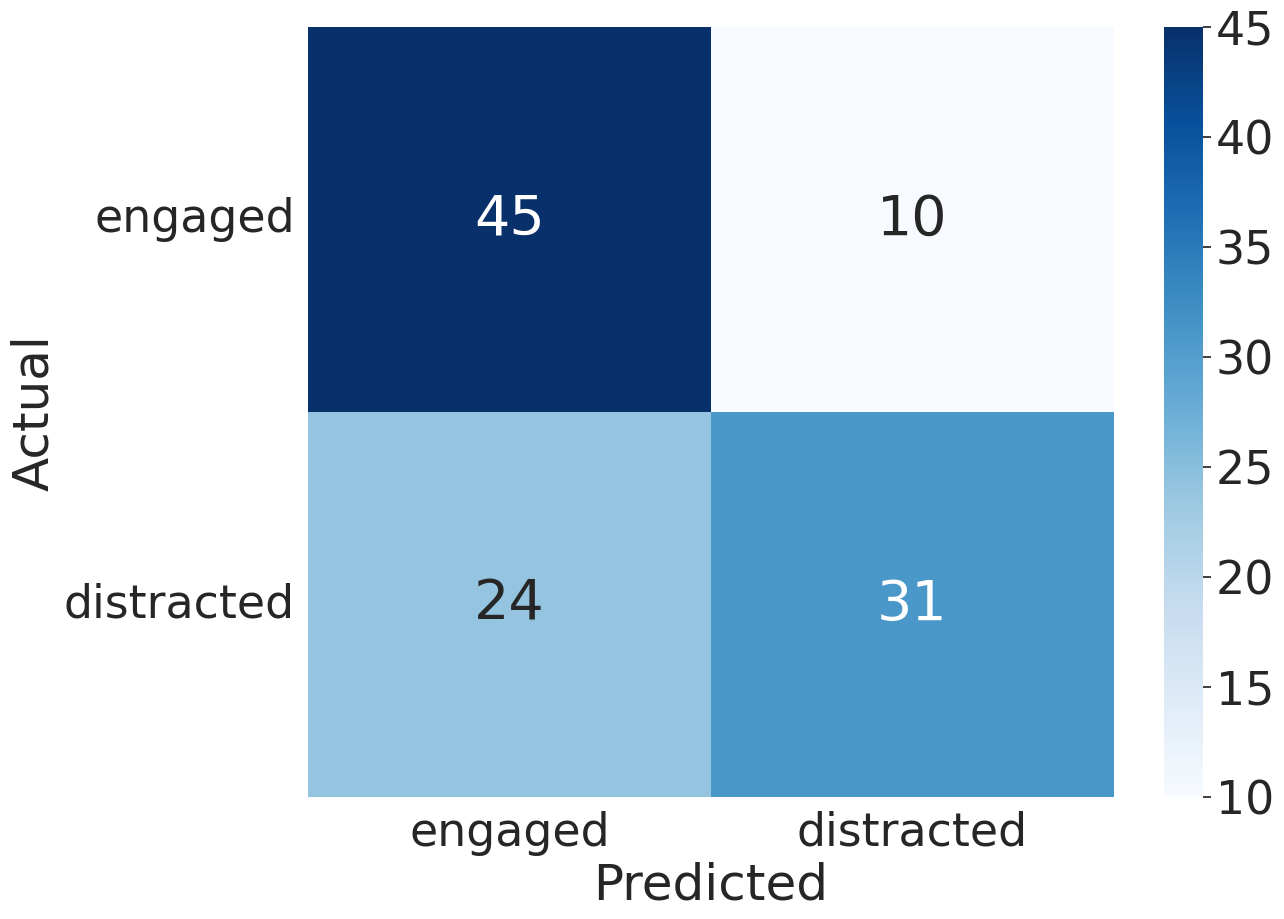

In [275]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [276]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Yana_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Egor_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Precision:  0.8333333333333334 F1:  0.8695652173913043
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_single_attention_concat_false_best_Katya_adapted Accuracy:  0.909090909

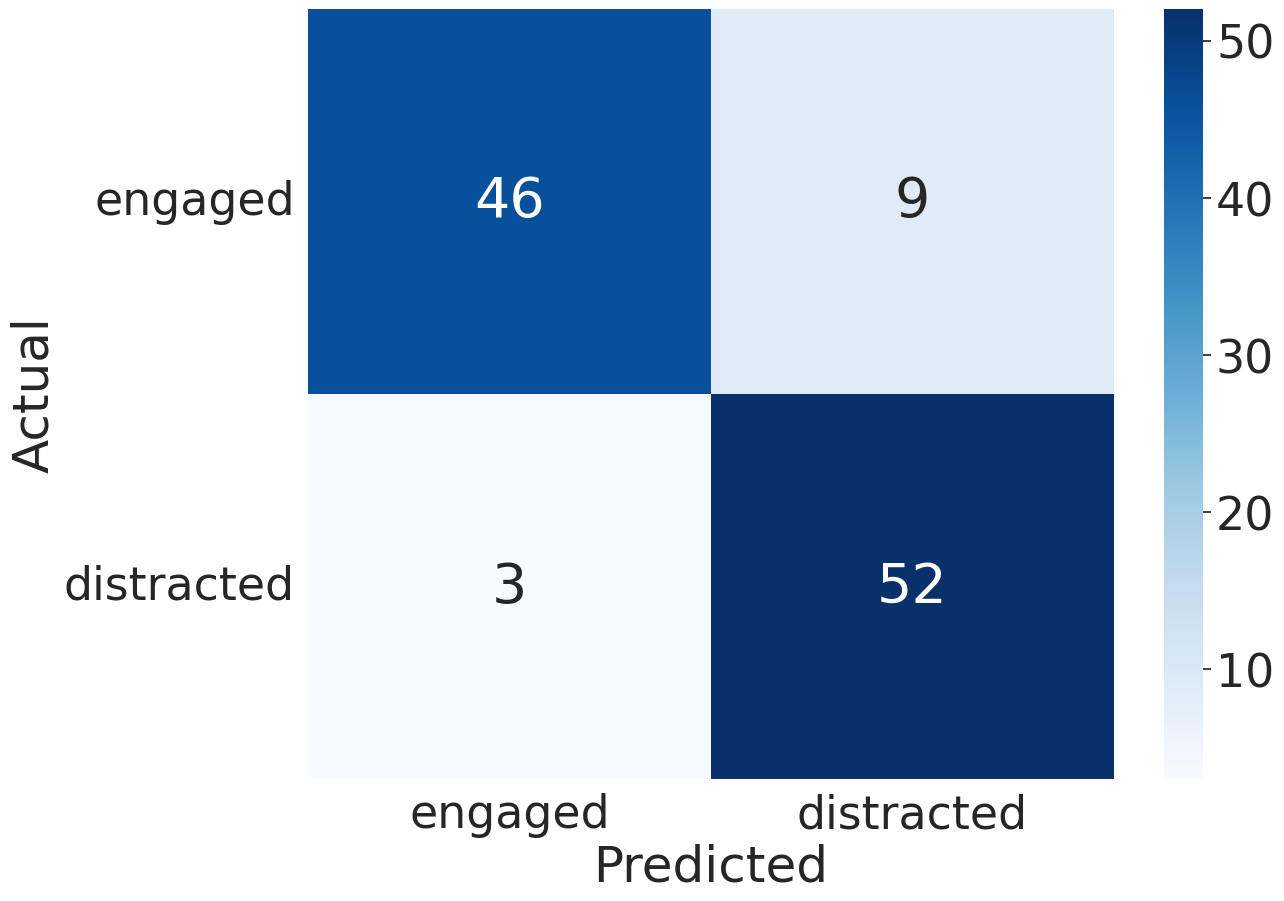

In [277]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [278]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8181818181818181, Precision: 0.8606060606060606, F1: 0.8306543697848046
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.9272727272727274, Precision: 0.8597069597069597, F1: 0.8871594202898552
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.9090909090909092, MSE: 0.09090909090909091, UAR: 0.9090909090909092, Recall: 0.9636363636363636, Precision: 0.8763

In [279]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [280]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [281]:
train_vid2features = all_train_vid2features

In [282]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [283]:
train_vid2features = all_train_vid2features

In [284]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_9 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [285]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_std_self_attention_concat_false_best


In [286]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [287]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Kate_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.45454545454545453 P

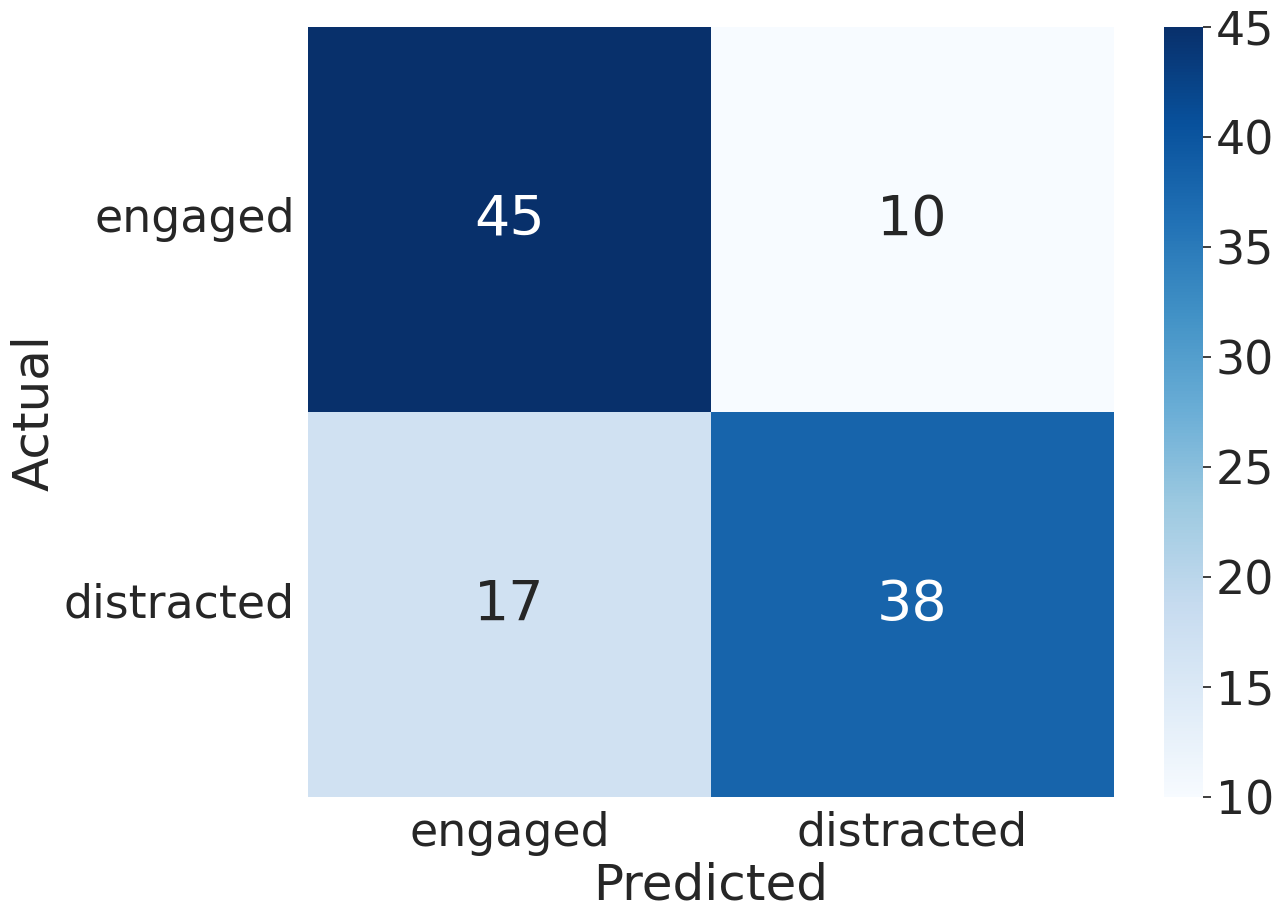

In [288]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [289]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Yana_adapted Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_std_self_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 M

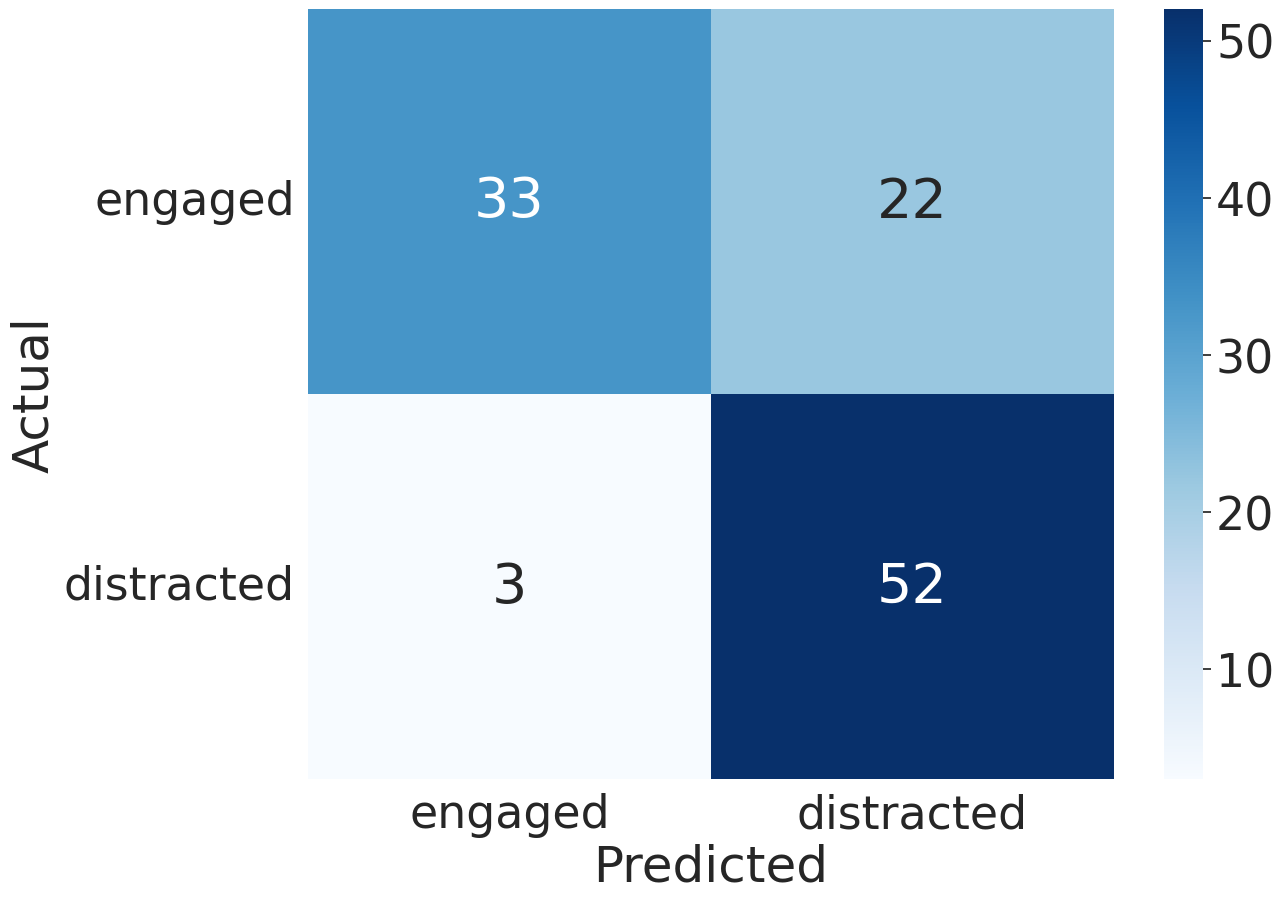

In [290]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [291]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 2.7619e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 2.4476e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 2.1822e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 1.9573e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 1.7656e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 1.6063e-04 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 1.4683e-04 - preci

In [292]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### STAT

In [293]:
stat_name = "STAT"
stat_func = compute_descriptor

#### Single attention

In [294]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [295]:
train_vid2features = all_train_vid2features

In [296]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [297]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3841      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [298]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_STAT_single_attention_best


In [299]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [300]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Yana_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Kate_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.45454545454545453 Precision:  0.7142857142857143 F1:  0.5555555555555556
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Egor_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.5454545454545454 Precision:  0.6 F1:  0.5714285714285713
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Katya_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.777777777777777

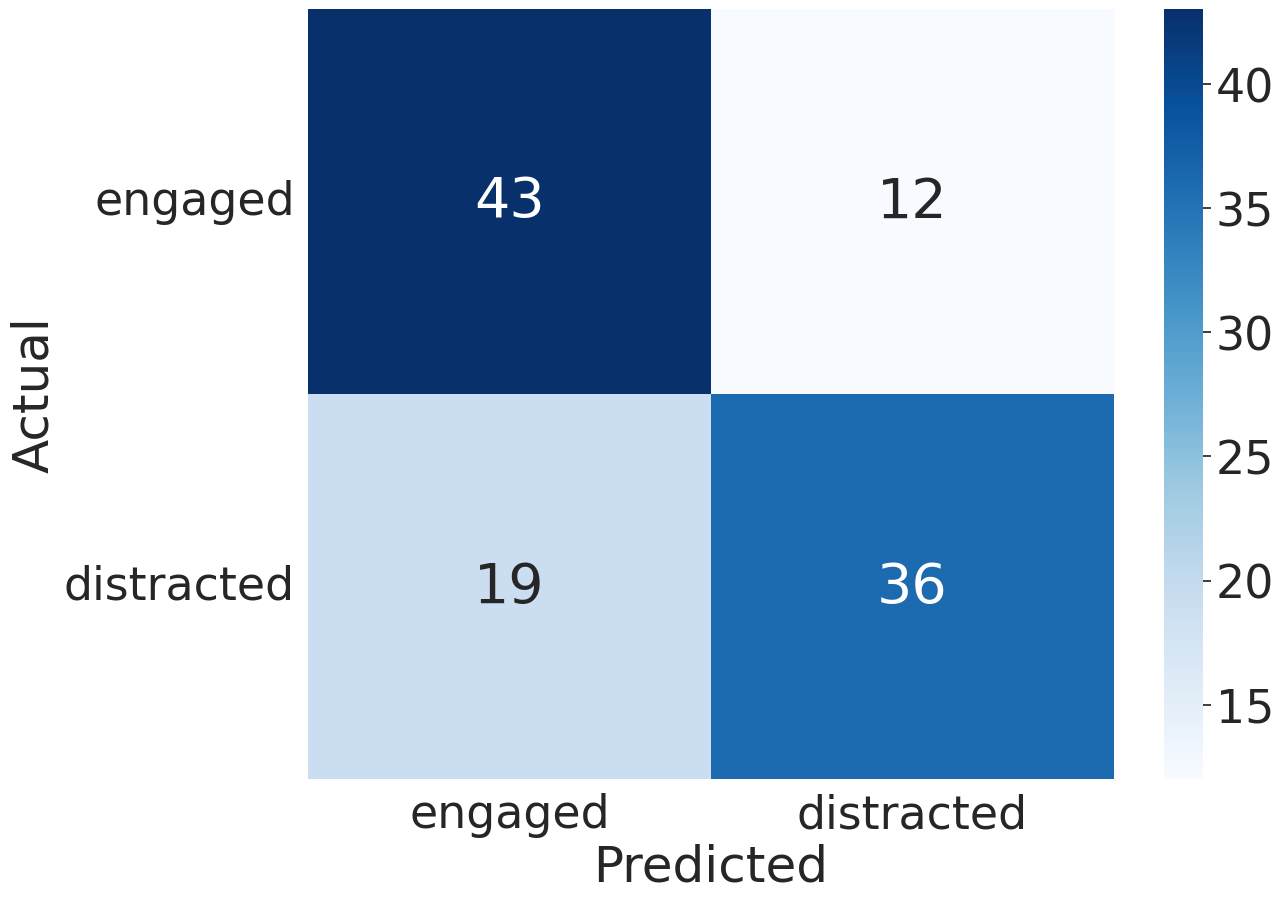

In [301]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [302]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Katya
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.90909090

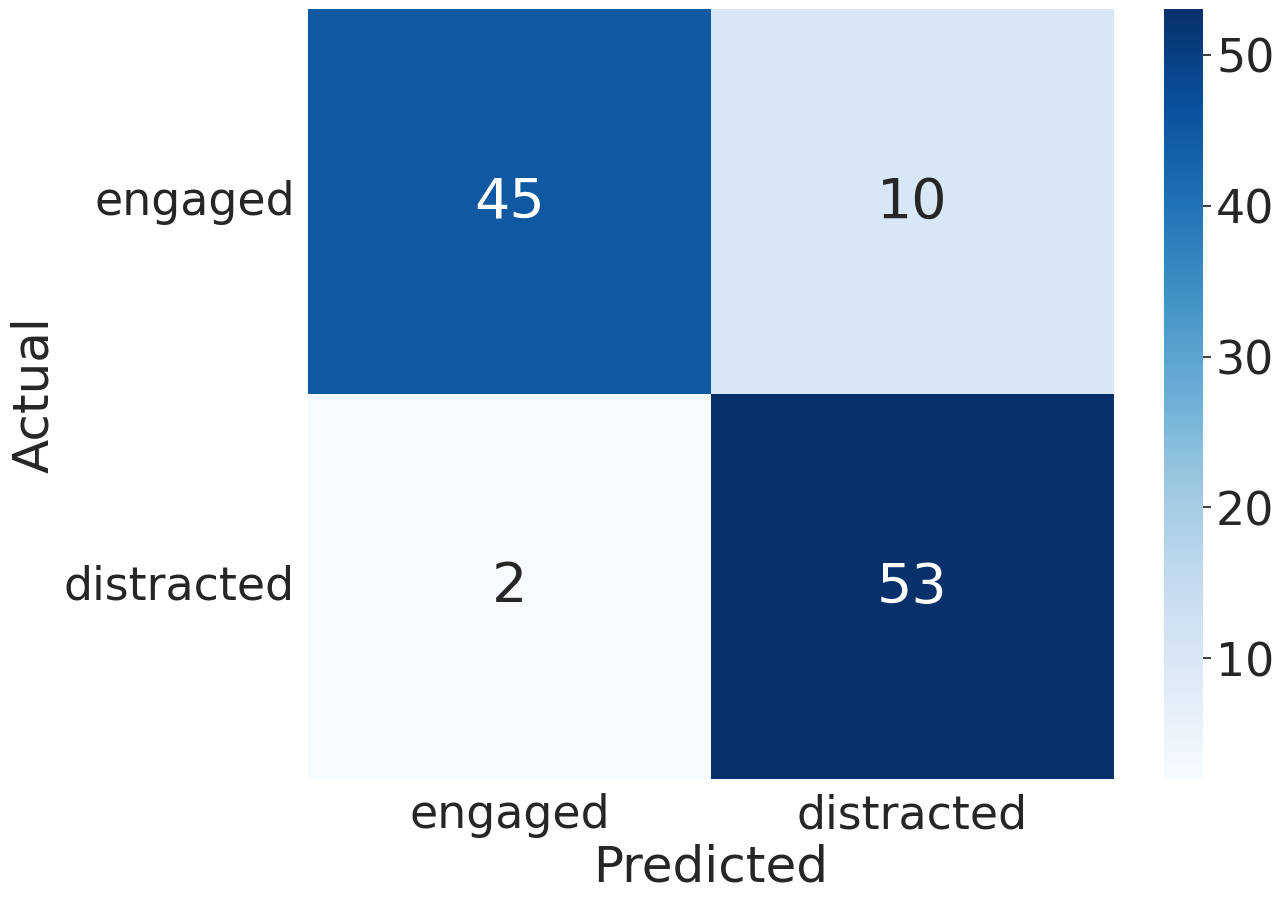

In [303]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [304]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3840) (2,)
		Actor Kate
(2, 70, 3840) (2,)
		Actor Egor
(2, 70, 3840) (2,)
		Actor Katya
(2, 70, 3840) (2,)
		Actor Den
(2, 70, 3840) (2,)
	Total, accuracy: 0.8454545454545453, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8181818181818181, Precision: 0.8677156177156178, F1: 0.8338014007350392
Videos num:  2
		Actor Yana
(4, 70, 3840) (4,)
		Actor Kate
(4, 70, 3840) (4,)
		Actor Egor
(4, 70, 3840) (4,)
		Actor Katya
(4, 70, 3840) (4,)
		Actor Den
(4, 70, 3840) (4,)
	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.9090909090909092, Precision: 0.8310822510822511, F1: 0.862979686979687
Videos num:  3
		Actor Yana
(6, 70, 3840) (6,)
		Actor Kate
(6, 70, 3840) (6,)
		Actor Egor
(6, 70, 3840) (6,)
		Actor Katya
(6, 70, 3840) (6,)
		Actor Den
(6, 70, 3840) (6,)
	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.9636363636363636, Precision: 0.8292

In [305]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [306]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [307]:
train_vid2features = all_train_vid2features

In [308]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [309]:
train_vid2features = all_train_vid2features

In [310]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3840)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1966080   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1966080   ['image_set[0][0]']           
                                                                                                  
 attention_10 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [311]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_STAT_self_attention_best


In [312]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [313]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Yana_universal Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Precision:  0.8333333333333334 F1:  0.8695652173913043
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Egor_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.9090909090909091 Precision:  0.7142857142857143 F1:  0.8
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.8181818181818182 Precision:  0.5625 F1

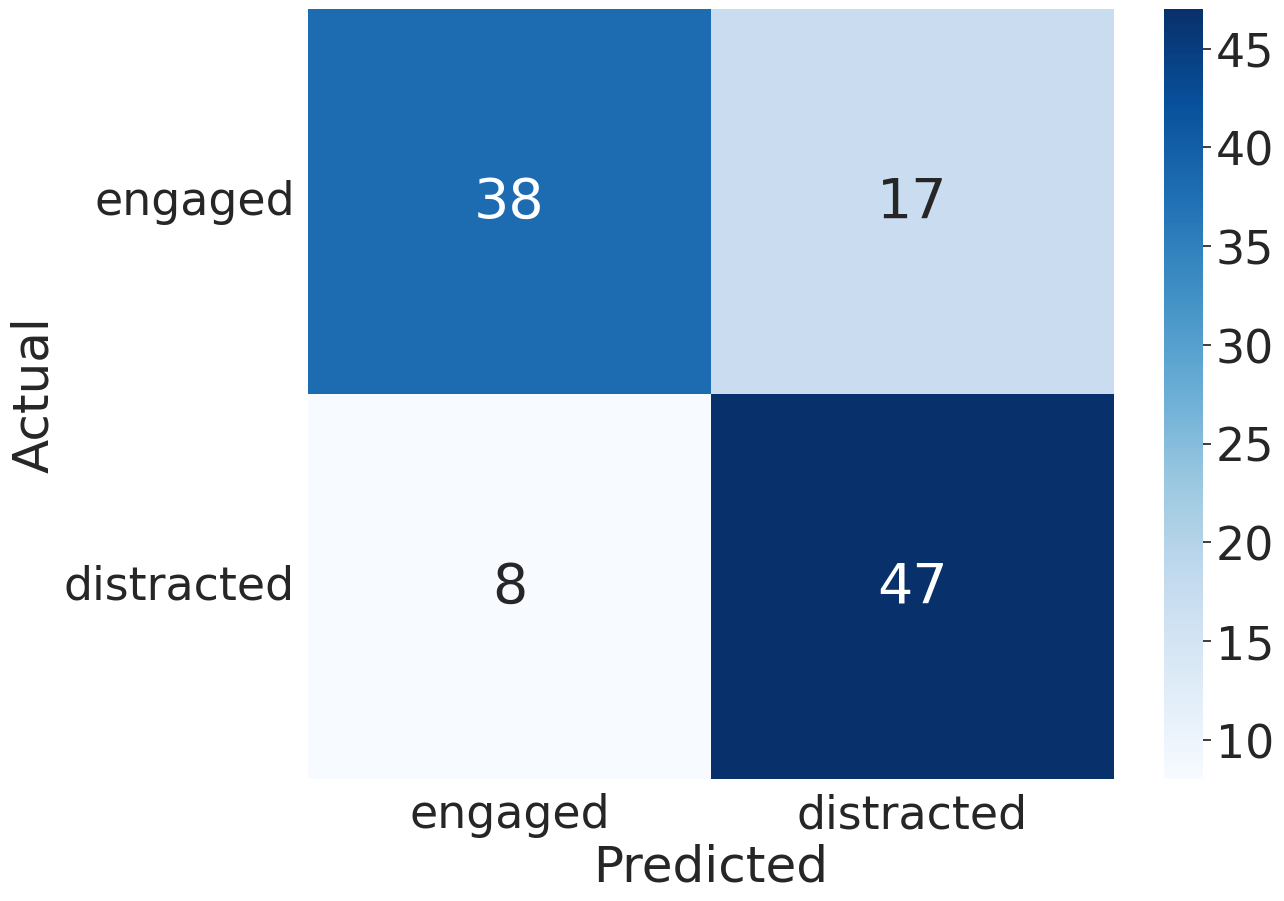

In [314]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [315]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Kate_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.9090909090909091 Precision:  0.9090909090909091 F1:  0.9090909090909091
Actor Egor
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Actor Katya
(10, 70, 3840) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1

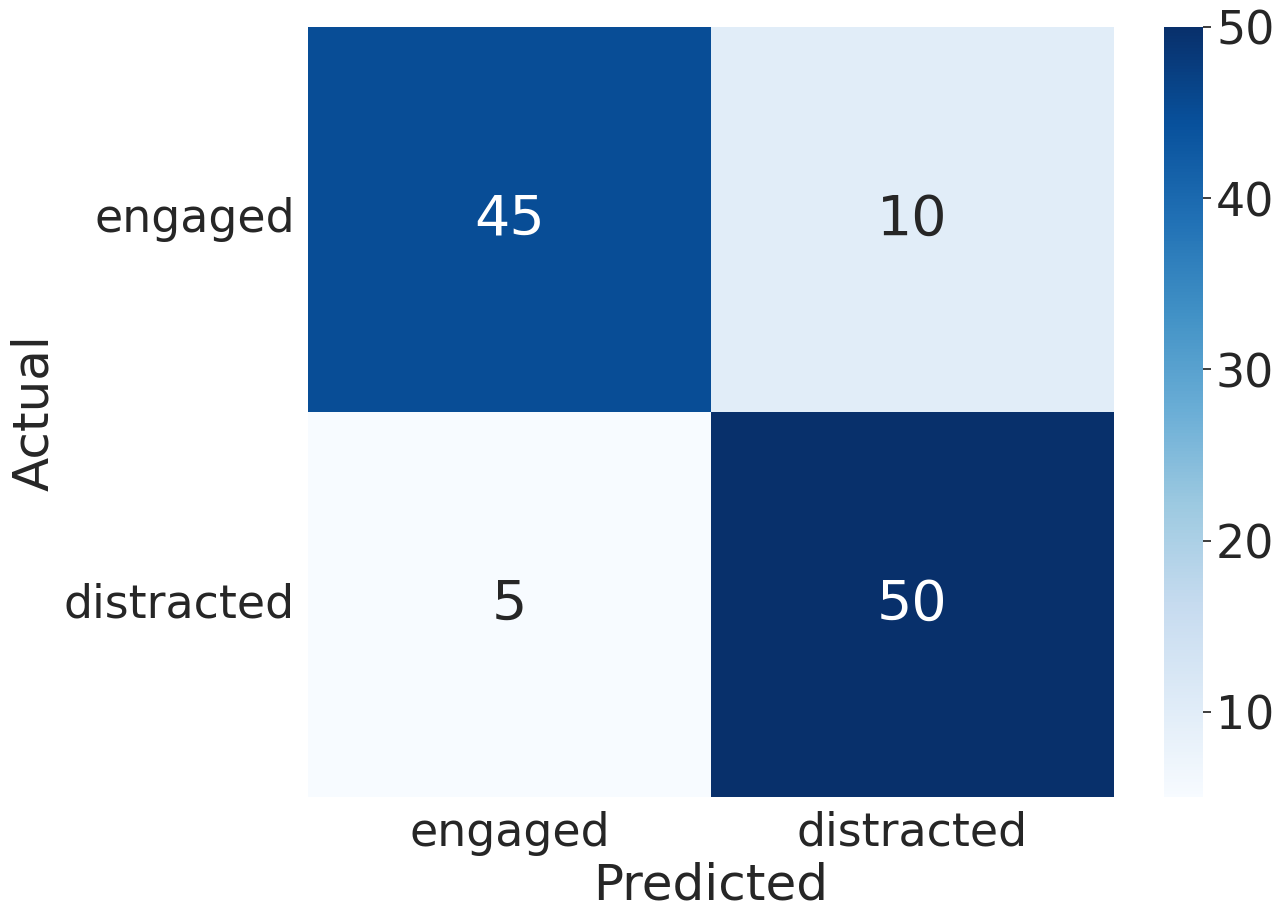

In [316]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [317]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3840) (2,)
Epoch 1/20
1/1 [==============================] - 0s 11ms/step - loss: 0.0023 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - precision: 1.0000 - recall: 1.000

In [318]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [319]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [320]:
train_vid2features = all_train_vid2features

In [321]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [322]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1281      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [323]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_STAT_single_attention_concat_false_best


In [324]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [325]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.5454545454545454 Precision:  0.75 F1:  0.631578947368421
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Kate_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.2727272727272727 Precision:  0.6 F1:  0.37499999999999994
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Egor_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.7272727272727273 Precision:  0.7272727272727273 F1:  0.7272727272727273
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recal

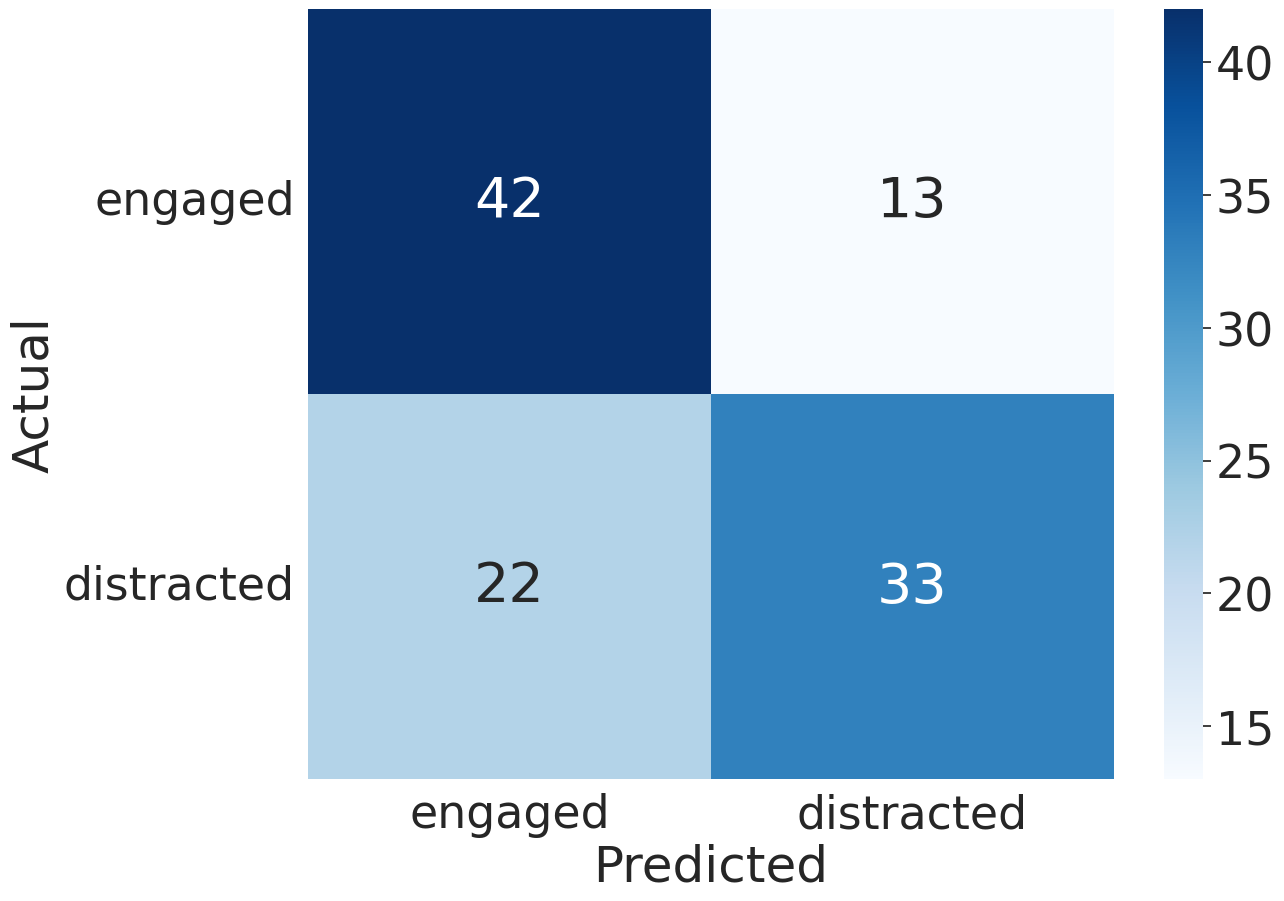

In [326]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [327]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Kate_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_single_attention_concat_false_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909

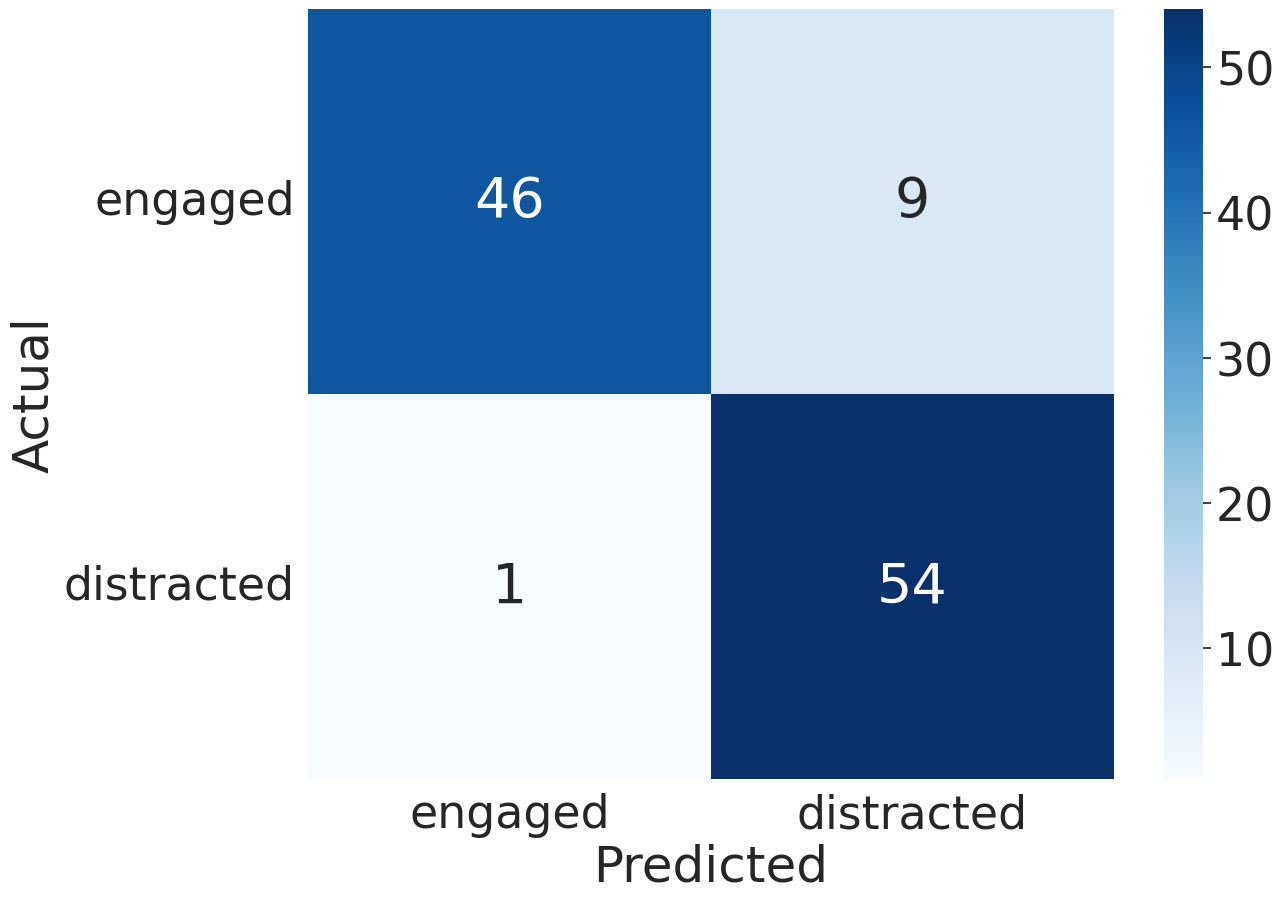

In [328]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [329]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
		Actor Kate
(2, 70, 1280) (2,)
		Actor Egor
(2, 70, 1280) (2,)
		Actor Katya
(2, 70, 1280) (2,)
		Actor Den
(2, 70, 1280) (2,)
	Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454545, Recall: 0.8545454545454545, Precision: 0.8606060606060606, F1: 0.8550988142292489
Videos num:  2
		Actor Yana
(4, 70, 1280) (4,)
		Actor Kate
(4, 70, 1280) (4,)
		Actor Egor
(4, 70, 1280) (4,)
		Actor Katya
(4, 70, 1280) (4,)
		Actor Den
(4, 70, 1280) (4,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.9272727272727274, Precision: 0.8597069597069597, F1: 0.8871594202898552
Videos num:  3
		Actor Yana
(6, 70, 1280) (6,)
		Actor Kate
(6, 70, 1280) (6,)
		Actor Egor
(6, 70, 1280) (6,)
		Actor Katya
(6, 70, 1280) (6,)
		Actor Den
(6, 70, 1280) (6,)
	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.9636363636363636, Precision: 0.8289

In [330]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [331]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [332]:
train_vid2features = all_train_vid2features

In [333]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [334]:
train_vid2features = all_train_vid2features

In [335]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1280)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            655360    ['image_set[0][0]']           
                                                                                                  
 attention_11 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [336]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

enet_b0_8_best_afew.pt_EngageWild_2_STAT_self_attention_concat_false_best


In [337]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [338]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Kate : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Kate_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Egor : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Egor_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Katya : 22
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636

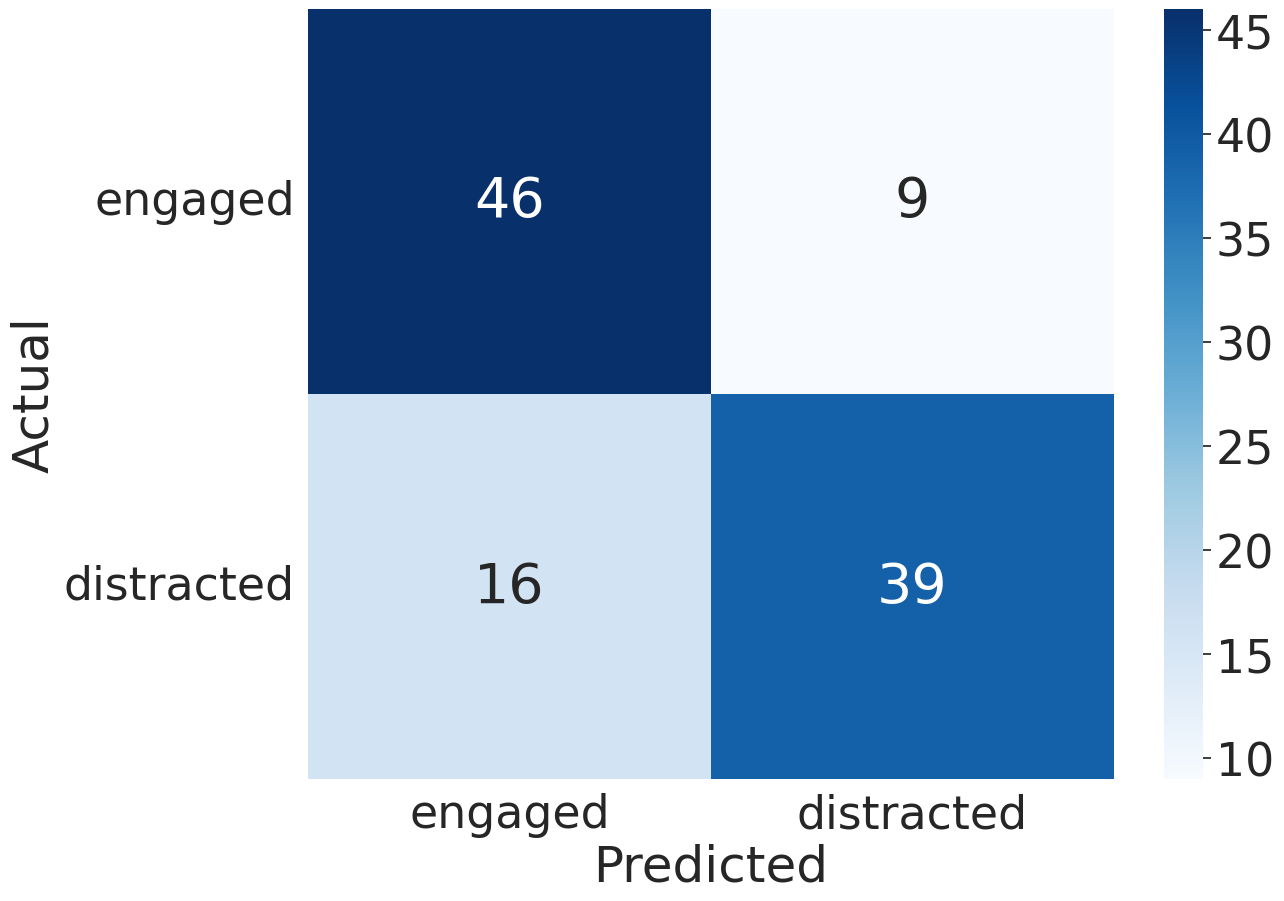

In [339]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [340]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Egor_adapted Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  1.0 Precision:  0.5789473684210527 F1:  0.7333333333333334
Actor Katya
(10, 70, 1280) (10,)
Metric_name:  enet_b0_8_best_afew.pt_EngageWild_STAT_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.1

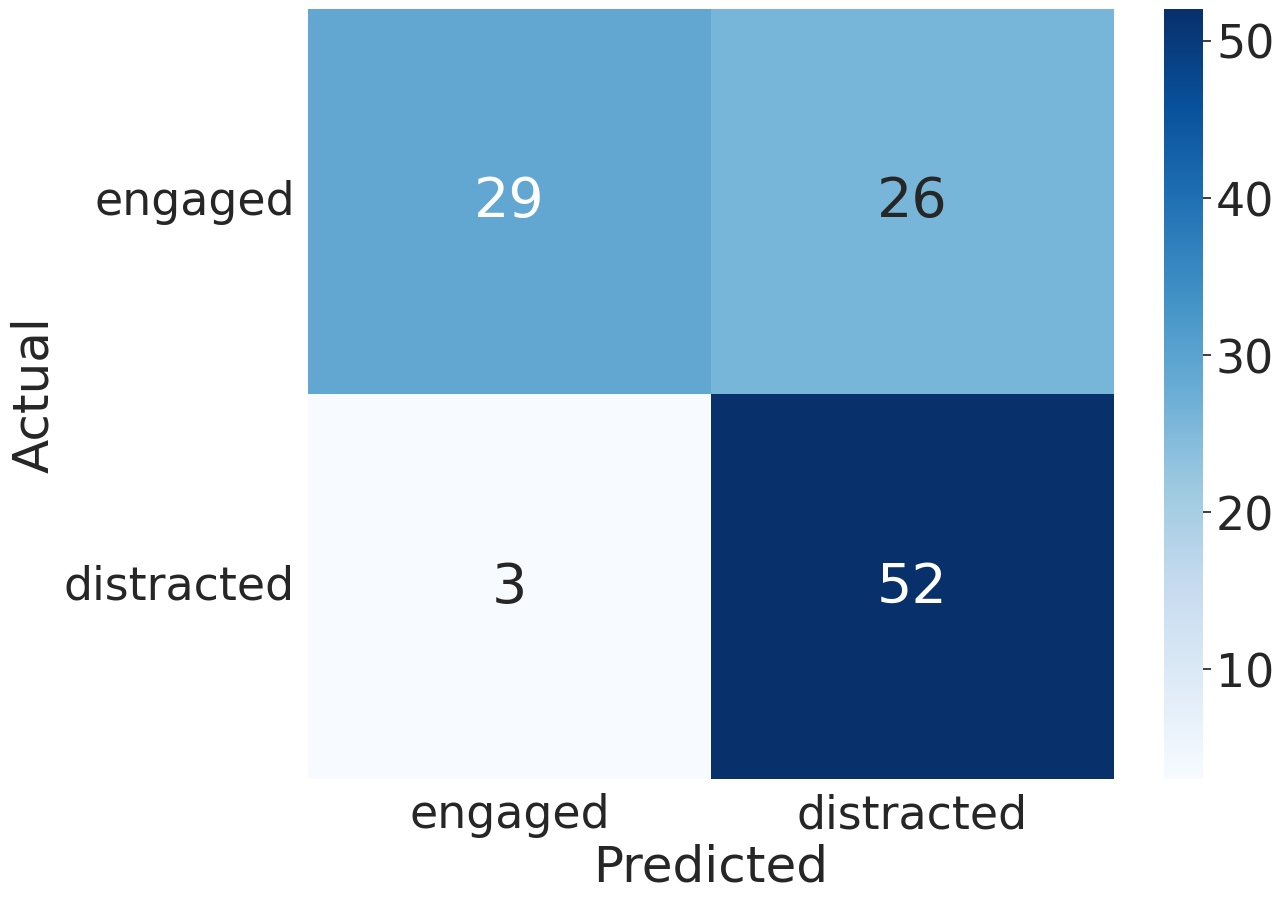

In [341]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [342]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1280) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.0021 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0021 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 9ms/step - loss: 0.0019 - precision: 1.0000 - recall: 1.000

In [343]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

## MobileNet

In [186]:
base_model_key = 'mobilenet_7.h5'

In [187]:
FEATURE_VECTOR_DIM = 2048
STAT_FEATURE_VECTOR_DIM = 3072
FEATURE_VECTOR_DIM_CONCAT_FALSE = int(FEATURE_VECTOR_DIM / 2)
STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE = FEATURE_VECTOR_DIM_CONCAT_FALSE

In [188]:
if False:
    engaged_pickle = USERS_FEATURES + 'engaged_features_{}.pickle'.format(base_model_key)
    distracted_pickle = USERS_FEATURES + 'distracted_features_{}.pickle'.format(base_model_key)
    train_test_pickle = USERS_FEATURES + '{}_train_test_features_{}.pickle'.format(base_model_key, TEST_VIDEOS)
    keys_pickle = USERS_FEATURES + 'shuffled_keys.pickle'
    
    all_train_vid2features, test_vid2features = load_features_from_pickle(engaged_pickle, distracted_pickle, train_test_pickle, keys_pickle)
    for name in all_train_vid2features.keys():
        all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'] = remove_empty_features(all_train_vid2features[name]['features'], all_train_vid2features[name]['labels'])
    for name in test_vid2features.keys():
        test_vid2features[name]['features'], test_vid2features[name]['labels'] = remove_empty_features(test_vid2features[name]['features'], test_vid2features[name]['labels'])

In [189]:
if True:
    engaged_pickle = USERS_DATASET + 'features/engaged_features_{}.good.pickle'.format(base_model_key)
    distracted_pickle = USERS_DATASET + 'features/distracted_features_{}.good.pickle'.format(base_model_key)
    eng_vid2features = load_features(engaged_pickle)
    dis_vid2features = load_features(distracted_pickle)
    vid2features_list = prepare_vid2features_list(eng_vid2features, dis_vid2features)
    
    train_vid2features, test_vid2features = split_to_sets(TRAIN_VIDEOS_COUNT, vid2features_list)
    all_train_vid2features = train_vid2features
    
    if REVERSE_LABELS:
        for name in train_vid2features.keys():
            labels = train_vid2features[name]['labels']
            train_vid2features[name]['labels'] = [_get_label(l) for l in labels]
    
        for name in test_vid2features.keys():
            labels = test_vid2features[name]['labels']
            test_vid2features[name]['labels'] = [_get_label(l) for l in labels]

### Max

In [190]:
stat_func=np.max
stat_name = "max"

#### Single attention

In [191]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [192]:
train_vid2features = all_train_vid2features

In [193]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [194]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [195]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_max_single_attention_best


In [196]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [197]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Yana_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Kate_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Egor_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.2727272727272727 Precision:  0.75 F1:  0.39999999999999997
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Den : 22
Metric_name:  mobilenet_7

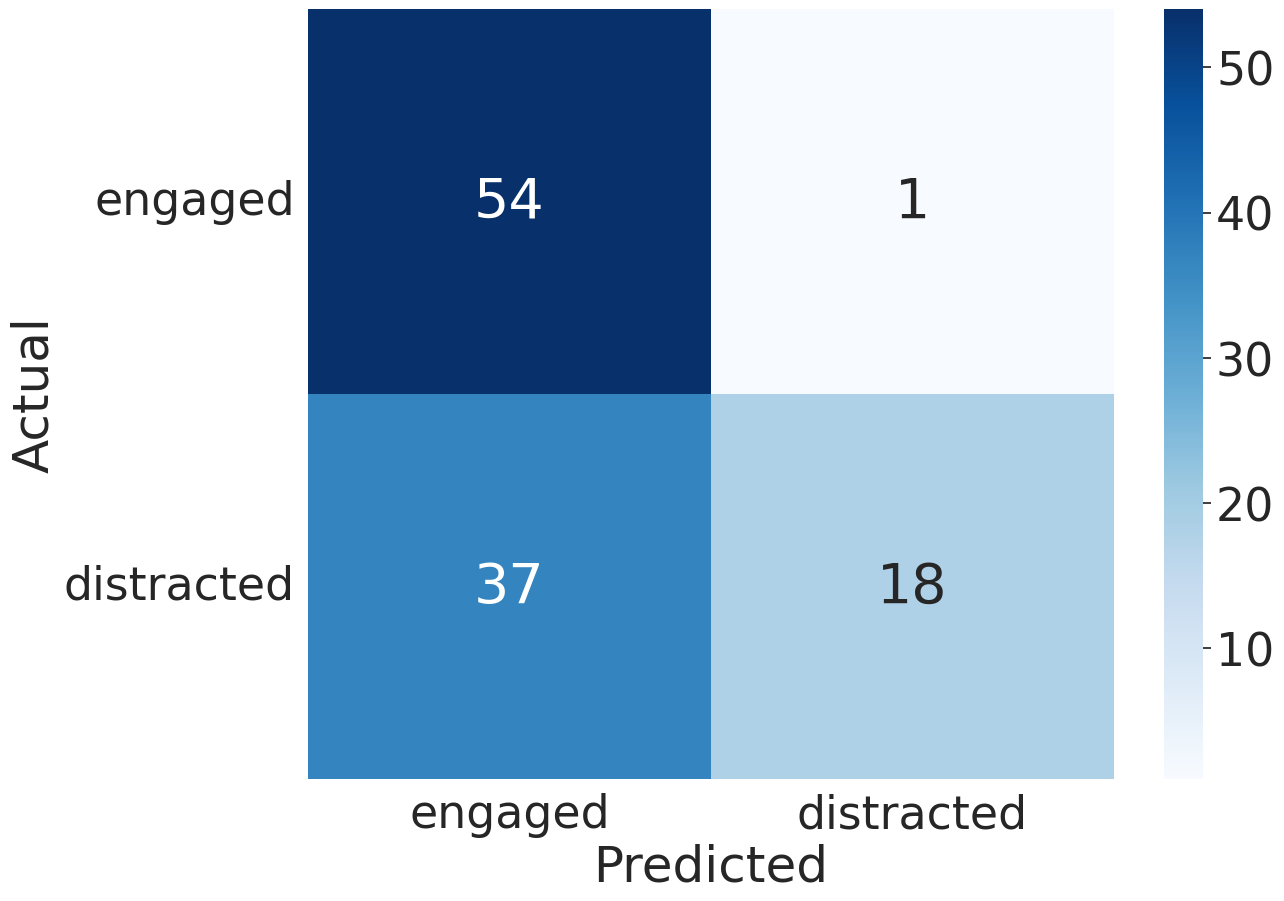

In [198]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [199]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Yana_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Kate_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Egor_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.7272727272727273 Precision:  1.0 F1:  0.8421052631578948
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.727272727272727

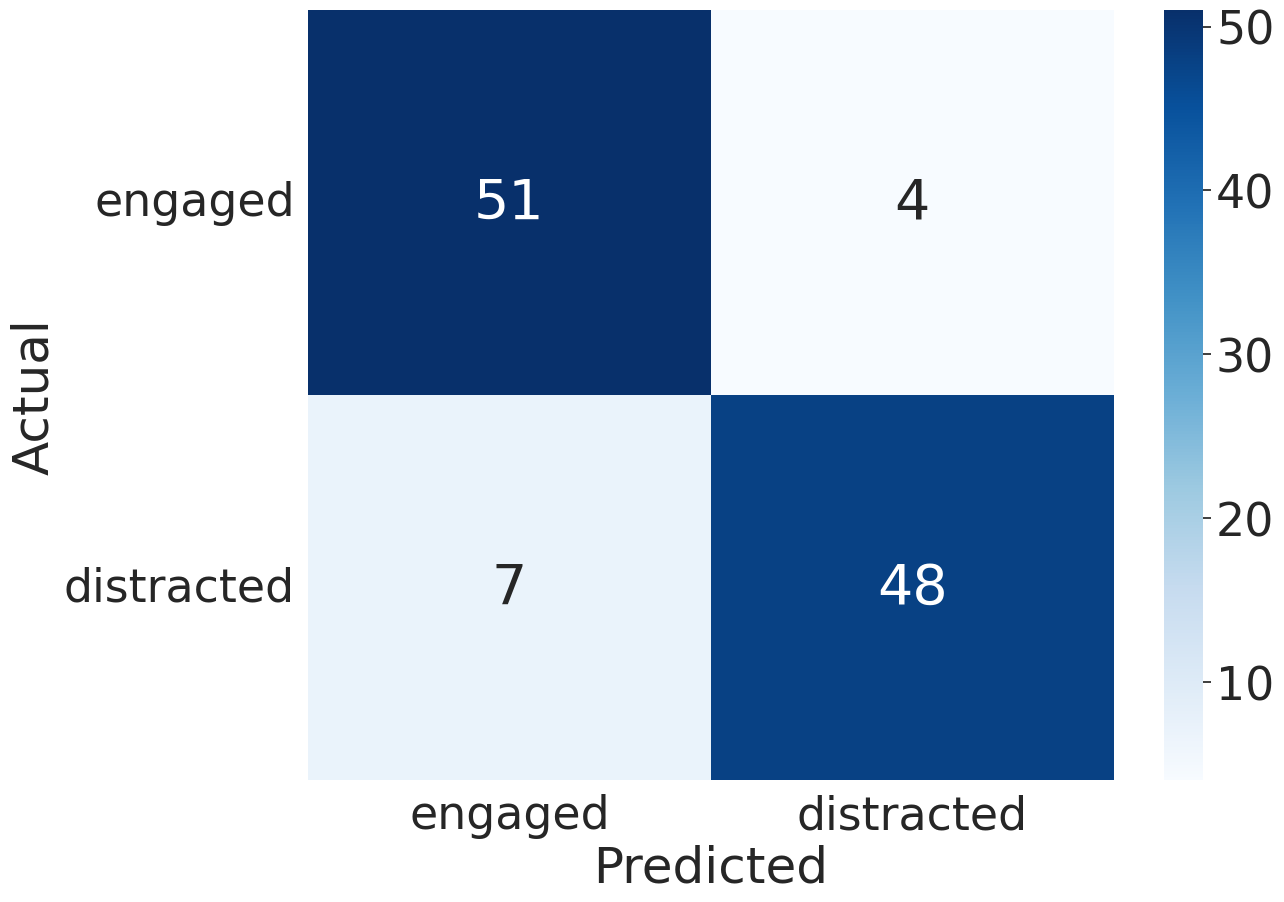

In [200]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [201]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
		Actor Kate
(2, 70, 2048) (2,)
		Actor Egor
(2, 70, 2048) (2,)
		Actor Katya
(2, 70, 2048) (2,)
		Actor Den
(2, 70, 2048) (2,)
	Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454545, Recall: 0.7272727272727273, Precision: 0.9833333333333332, F1: 0.8148337595907928
Videos num:  2
		Actor Yana
(4, 70, 2048) (4,)
		Actor Kate
(4, 70, 2048) (4,)
		Actor Egor
(4, 70, 2048) (4,)
		Actor Katya
(4, 70, 2048) (4,)
		Actor Den
(4, 70, 2048) (4,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.7636363636363636, Precision: 1.0, F1: 0.8580185758513933
Videos num:  3
		Actor Yana
(6, 70, 2048) (6,)
		Actor Kate
(6, 70, 2048) (6,)
		Actor Egor
(6, 70, 2048) (6,)
		Actor Katya
(6, 70, 2048) (6,)
		Actor Den
(6, 70, 2048) (6,)
	Total, accuracy: 0.818181818181818, MSE: 0.18181818181818182, UAR: 0.8181818181818183, Recall: 0.6363636363636364, Precision: 1.0, F1: 0.72498599439

In [202]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [203]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [204]:
train_vid2features = all_train_vid2features

In [205]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [206]:
train_vid2features = all_train_vid2features

In [207]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention_6 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [208]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_max_self_attention_best


In [209]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [210]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Kate_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  0.8 F1:  0.5000000000000001
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Katya_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Den : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_sel

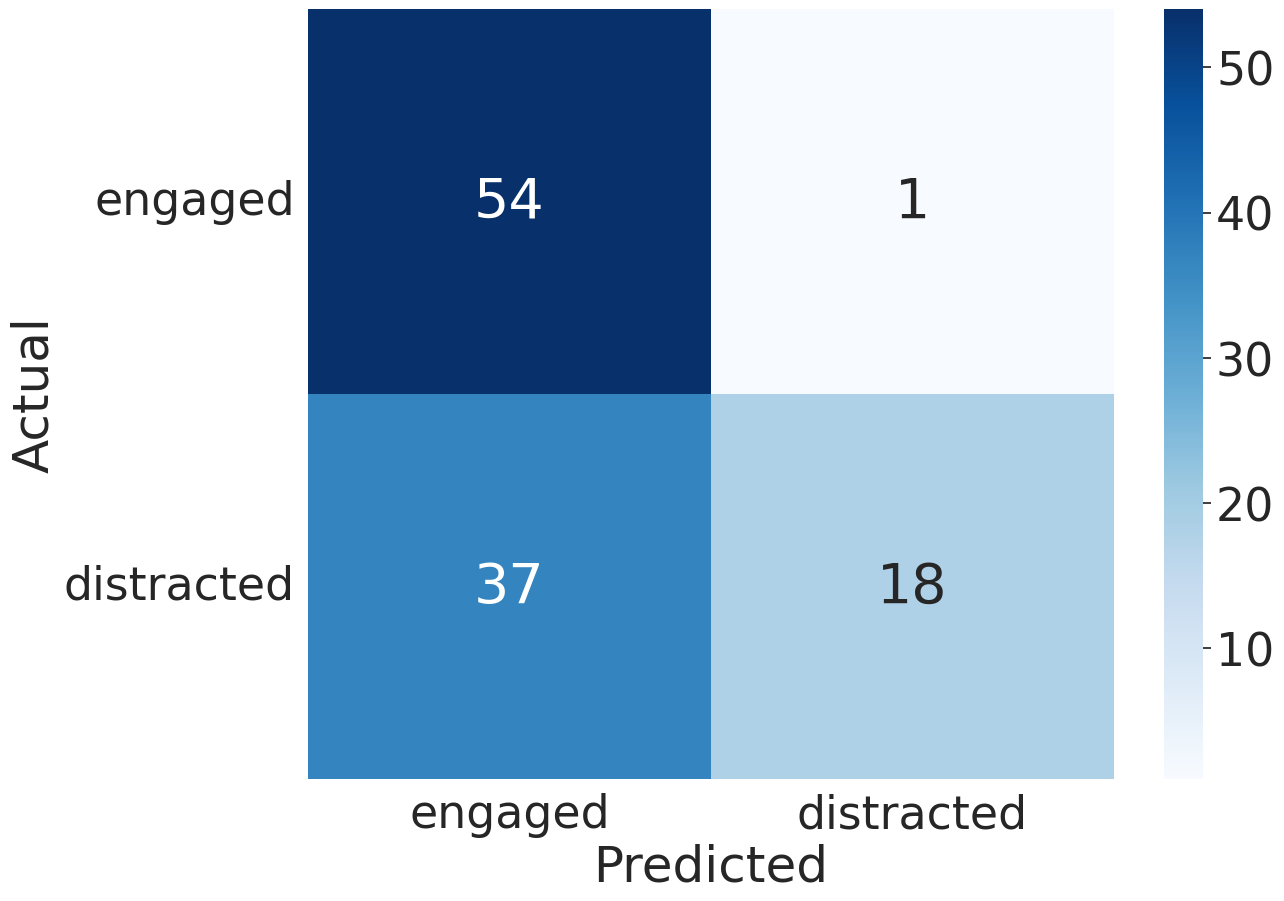

In [211]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [212]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Yana_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.7857142857142857 F1:  0.88
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Kate_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Egor_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.9090909090909091 Preci

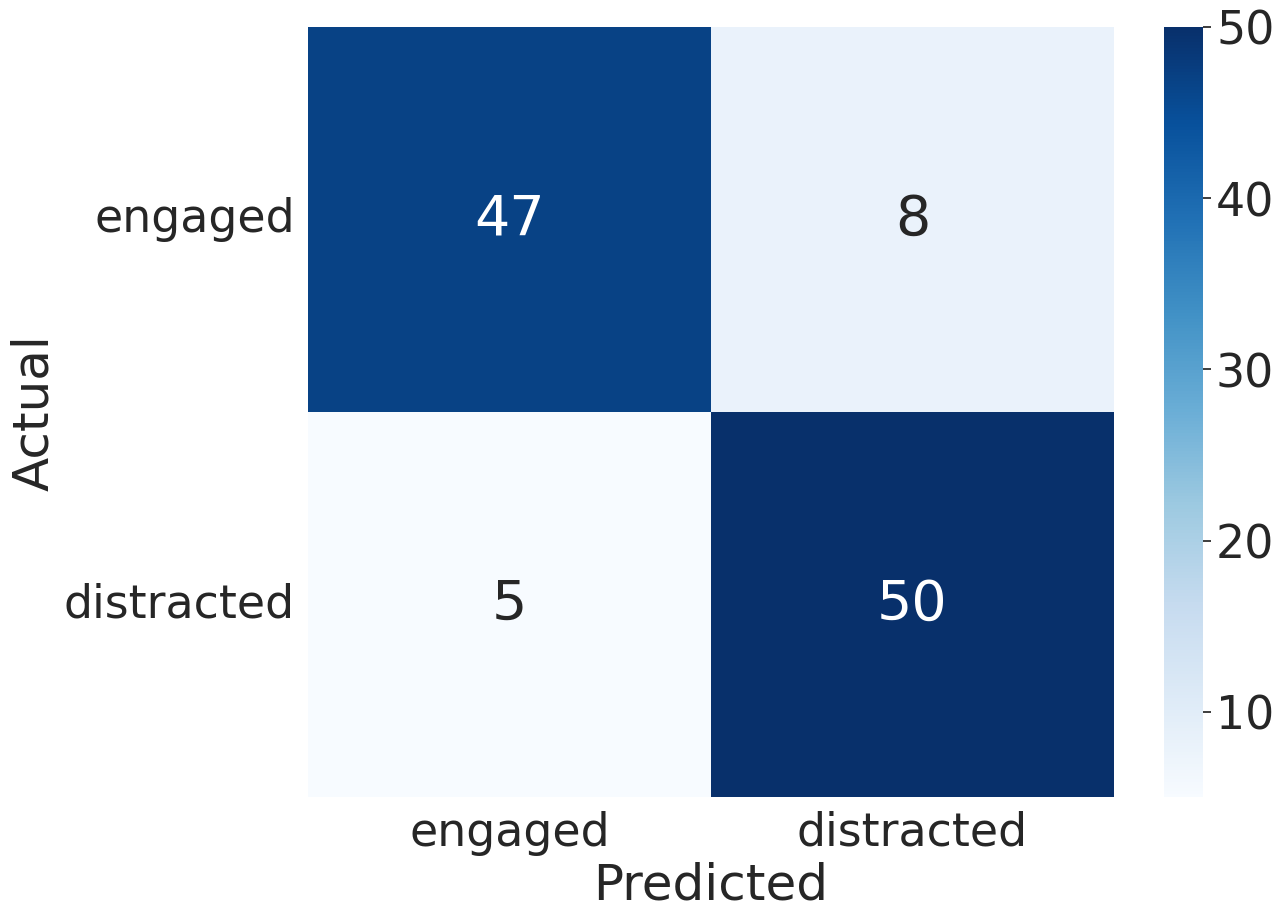

In [213]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [214]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
		Actor Kate
(2, 70, 2048) (2,)
		Actor Egor
(2, 70, 2048) (2,)
		Actor Katya
(2, 70, 2048) (2,)
		Actor Den
(2, 70, 2048) (2,)
	Total, accuracy: 0.8818181818181818, MSE: 0.11818181818181817, UAR: 0.8818181818181818, Recall: 0.890909090909091, Precision: 0.8757575757575757, F1: 0.88300395256917
Videos num:  2
		Actor Yana
(4, 70, 2048) (4,)
		Actor Kate
(4, 70, 2048) (4,)
		Actor Egor
(4, 70, 2048) (4,)
		Actor Katya
(4, 70, 2048) (4,)
		Actor Den
(4, 70, 2048) (4,)
	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454545, Recall: 0.8181818181818181, Precision: 0.8888461538461538, F1: 0.8473684210526315
Videos num:  3
		Actor Yana
(6, 70, 2048) (6,)
		Actor Kate
(6, 70, 2048) (6,)
		Actor Egor
(6, 70, 2048) (6,)
		Actor Katya
(6, 70, 2048) (6,)
		Actor Den
(6, 70, 2048) (6,)
	Total, accuracy: 0.8545454545454547, MSE: 0.14545454545454545, UAR: 0.8545454545454547, Recall: 0.8, Precision: 0.9205128205128206, F1:

In [215]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [216]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [217]:
train_vid2features = all_train_vid2features

In [218]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [219]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [220]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_max_single_attention_concat_false_best


In [221]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [222]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.5454545454545454 Precision:  0.8571428571428571 F1:  0.6666666666666665
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Egor_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.5454545454545454 Precision:  0.6 F1:  0.5714285714285713
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  

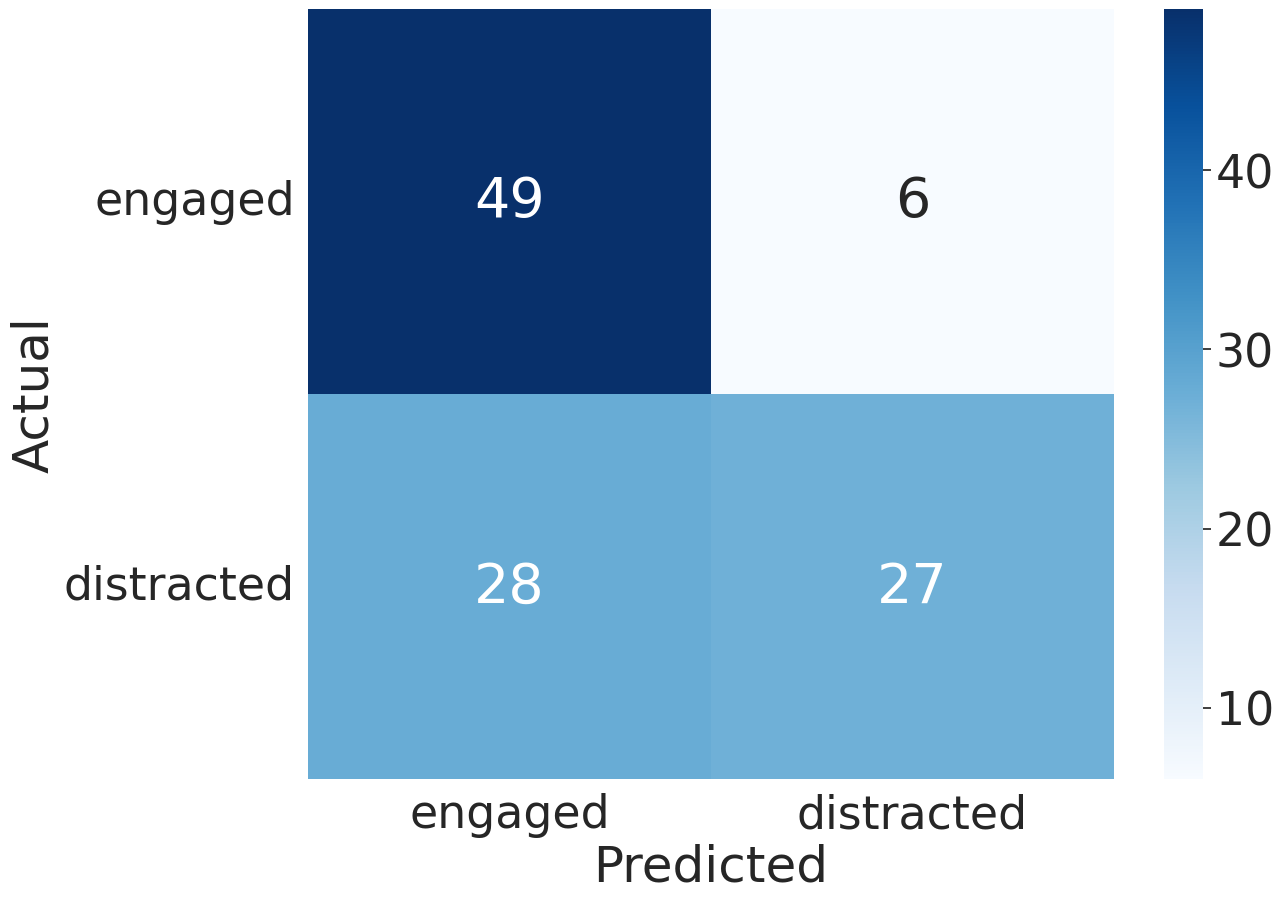

In [223]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [224]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Yana_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_single_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363

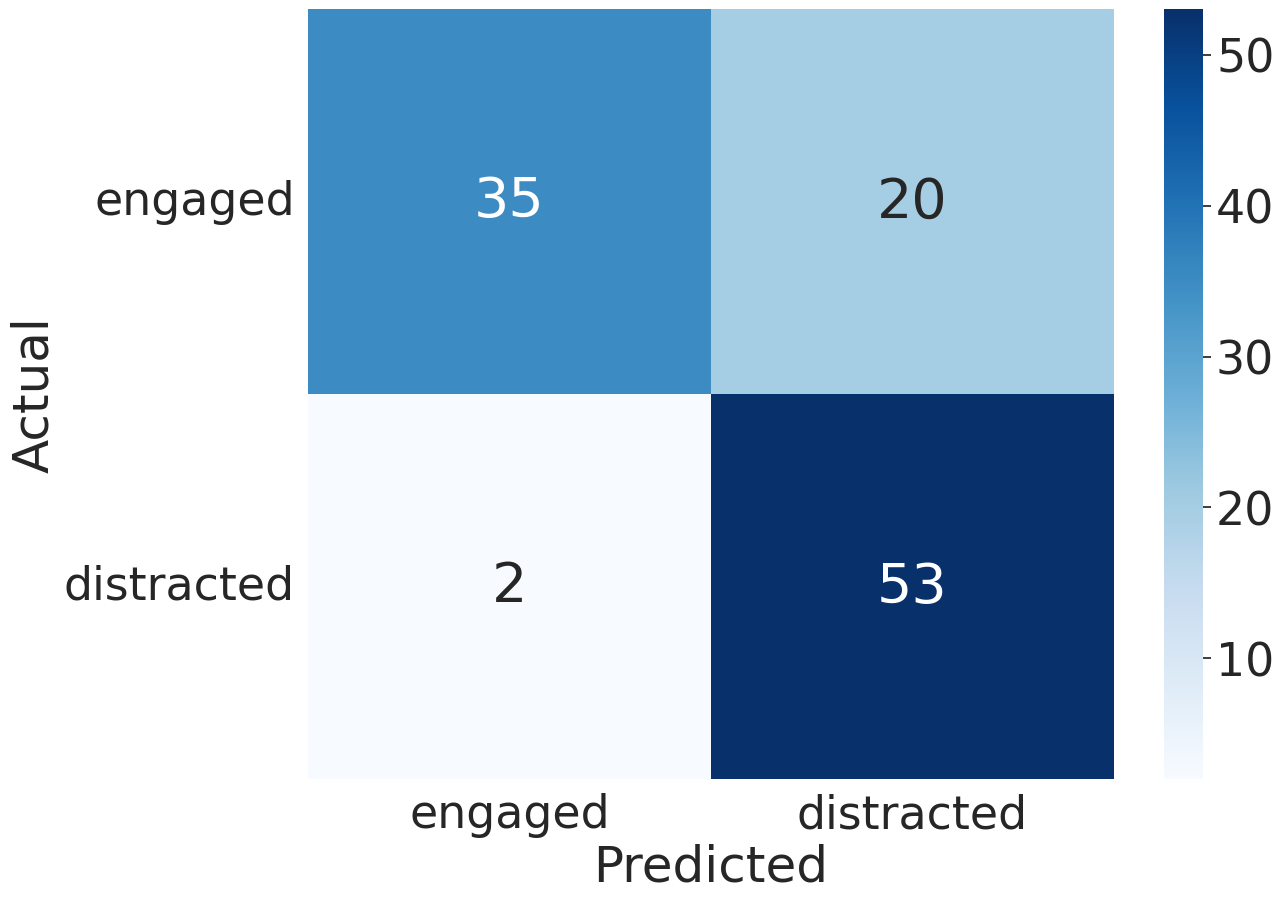

In [225]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [226]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.9090909090909092, Precision: 0.8624561403508771, F1: 0.8663736263736265
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.909090909090909, MSE: 0.09090909090909091, UAR: 0.909090909090909, Recall: 0.9090909090909092, Precision: 0.9375, F1: 0.9134391534391535
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.8727272727272728, Precision: 0.9127450980392157,

In [227]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [228]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [229]:
train_vid2features = all_train_vid2features

In [230]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [231]:
train_vid2features = all_train_vid2features

In [232]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_7 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [233]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_max_self_attention_concat_false_best


In [234]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [235]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Yana_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.2727272727272727 Precision:  0.6 F1:  0.37499999999999994
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Kate_universal Accuracy:  0.45454545454545453 MSE:  0.5454545454545454 UAR:  0.4545454545454546 Recall:  0.09090909090909091 Precision:  0.3333333333333333 F1:  0.14285714285714288
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  0.8 F1:  0.5000000000000001
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Katya_universal Accuracy:  0.45454545454545453 MSE:  0.5454545454545454 UAR:  0.4545454545454546 Recall:  0.09090909090909091 Precision:  0.

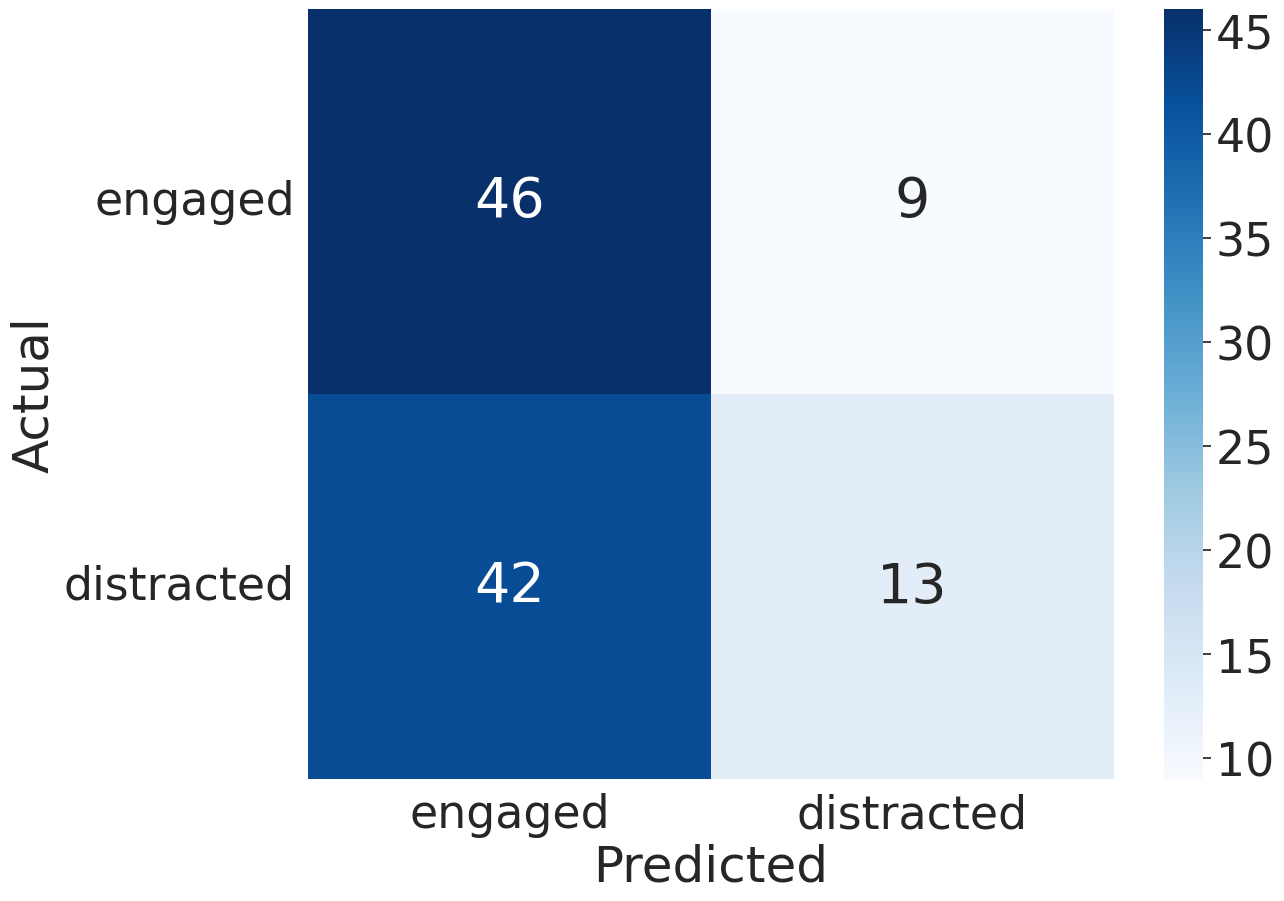

In [236]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [237]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Yana_adapted Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090908 Recall:  0.9090909090909091 Precision:  0.5555555555555556 F1:  0.6896551724137931
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.9090909090909091 Precision:  0.5263157894736842 F1:  0.6666666666666666
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Egor_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.45454545454545453 Precision:  0.5555555555555556 F1:  0.5
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_max_self_attention_concat_false_best_Katya_adapted Accuracy:  0.5454545454545454 MSE

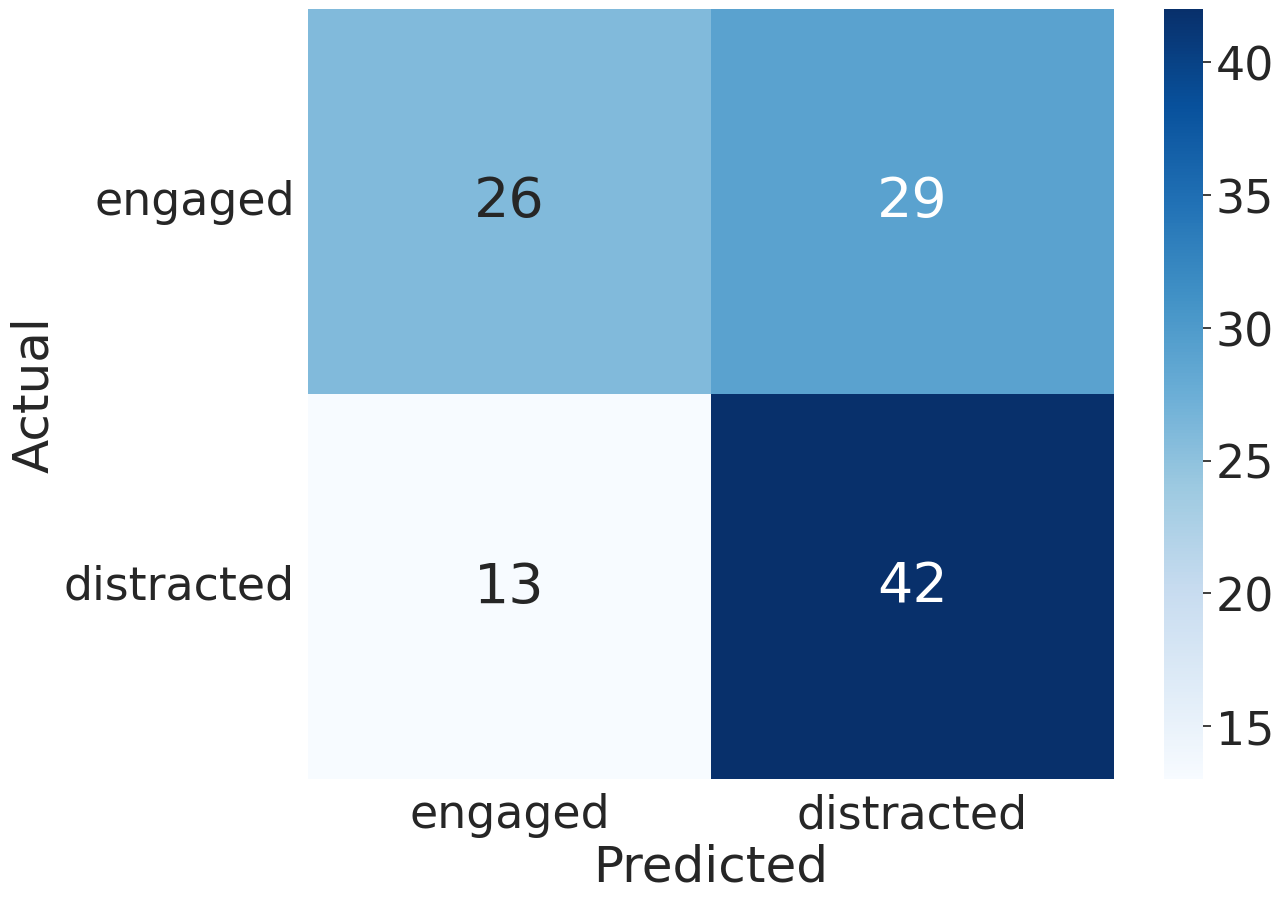

In [238]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [239]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 9ms/step - loss: 7.5741 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 7.5078 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 7.3759 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 7.1833 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 6.9159 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 6.4635 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 7/20
1/1 [=========================

In [240]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### Std

In [241]:
stat_func=np.std
stat_name = "std"

#### Single attention

In [242]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [243]:
train_vid2features = all_train_vid2features

In [244]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [245]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              2049      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [246]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_std_single_attention_best


In [247]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [248]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Yana_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.7272727272727273 Precision:  0.8 F1:  0.761904761904762
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Kate_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.2727272727272727 Precision:  0.6 F1:  0.37499999999999994
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Egor_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.36363636363636365 Precision:  0.6666666666666666 F1:  0.4705882352941177
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Katya_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Den : 22

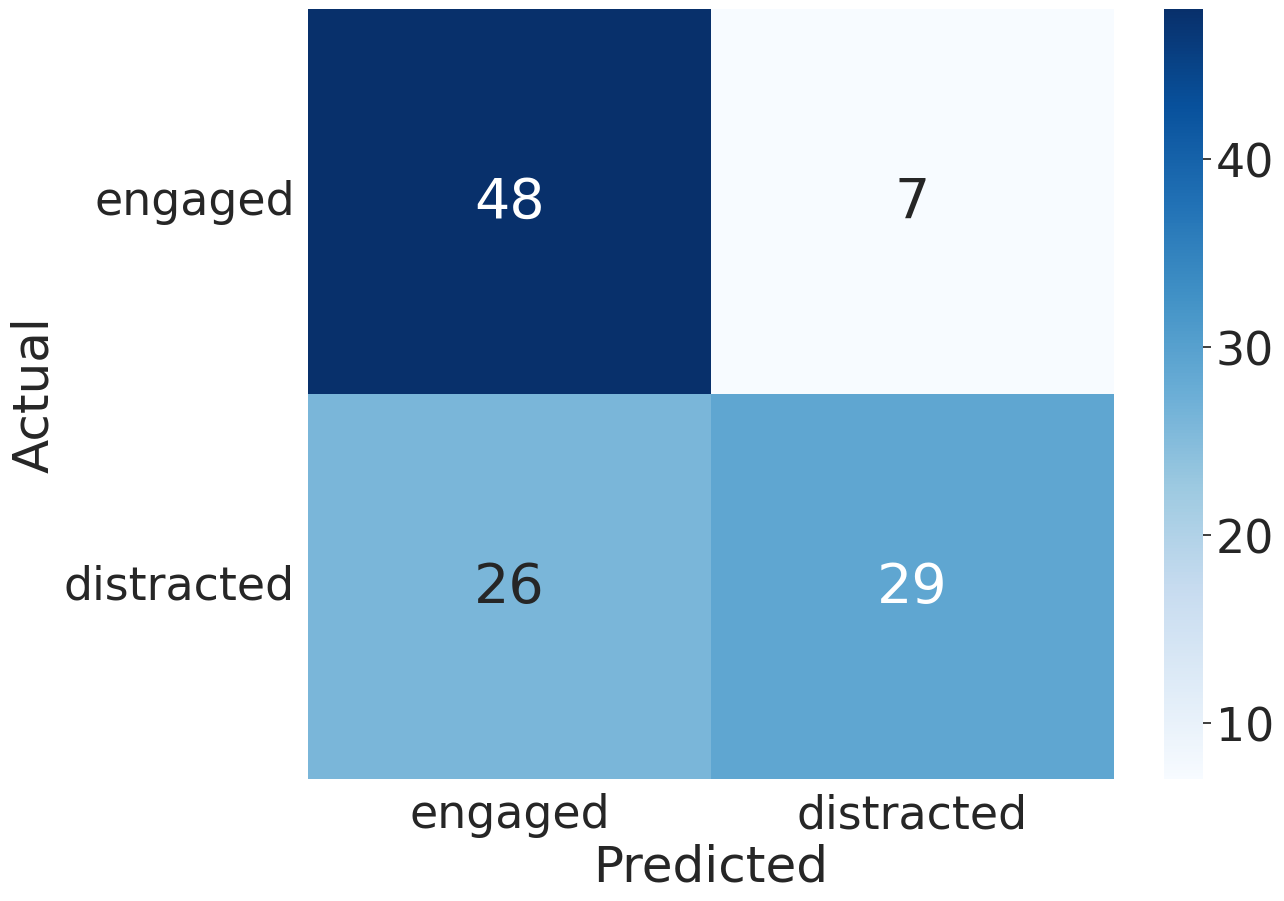

In [249]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [250]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Egor_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:  0.9 F1:  0.8571428571428572
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  0.8181818181818182 Precision:

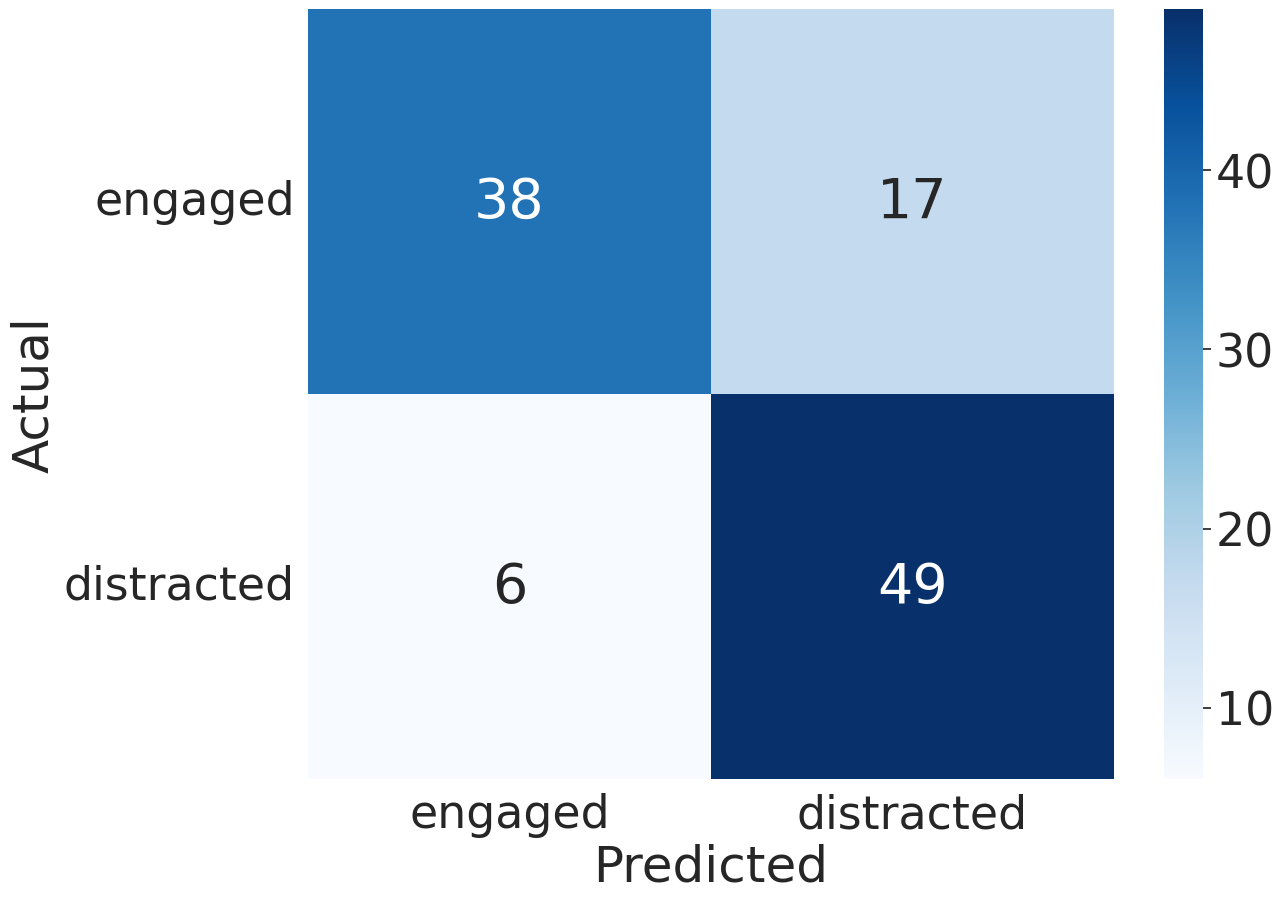

In [251]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [252]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
		Actor Kate
(2, 70, 2048) (2,)
		Actor Egor
(2, 70, 2048) (2,)
		Actor Katya
(2, 70, 2048) (2,)
		Actor Den
(2, 70, 2048) (2,)
	Total, accuracy: 0.7636363636363637, MSE: 0.2363636363636364, UAR: 0.7636363636363637, Recall: 0.8181818181818181, Precision: 0.7941491841491841, F1: 0.771151557652259
Videos num:  2
		Actor Yana
(4, 70, 2048) (4,)
		Actor Kate
(4, 70, 2048) (4,)
		Actor Egor
(4, 70, 2048) (4,)
		Actor Katya
(4, 70, 2048) (4,)
		Actor Den
(4, 70, 2048) (4,)
	Total, accuracy: 0.7909090909090909, MSE: 0.20909090909090908, UAR: 0.7909090909090909, Recall: 0.8545454545454545, Precision: 0.825897435897436, F1: 0.8040971096548846
Videos num:  3
		Actor Yana
(6, 70, 2048) (6,)
		Actor Kate
(6, 70, 2048) (6,)
		Actor Egor
(6, 70, 2048) (6,)
		Actor Katya
(6, 70, 2048) (6,)
		Actor Den
(6, 70, 2048) (6,)
	Total, accuracy: 0.8272727272727272, MSE: 0.17272727272727273, UAR: 0.8272727272727272, Recall: 0.7818181818181819, Precision: 0.906730

In [253]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [254]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [255]:
train_vid2features = all_train_vid2features

In [256]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [257]:
train_vid2features = all_train_vid2features

In [258]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 2048)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1048576   ['image_set[0][0]']           
                                                                                                  
 attention_8 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [259]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_std_self_attention_best


In [260]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [261]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Kate_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.09090909090909091 Precision:  1.0 F1:  0.16666666666666669
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  0.8 F1:  0.5000000000000001
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Den : 22
Metric_name:  mobilenet_7.h5_Enga

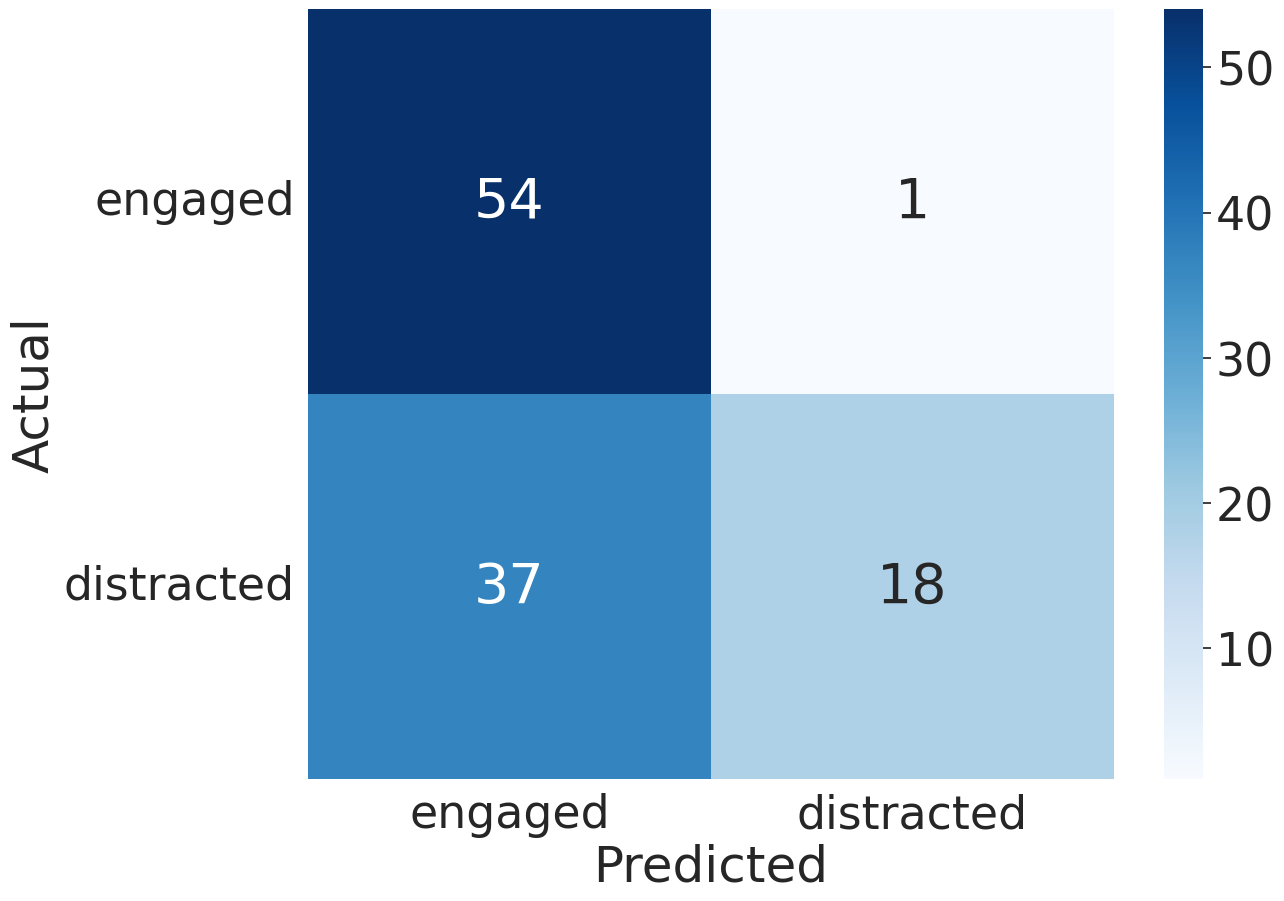

In [262]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [263]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Kate_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Egor
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Egor_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.6363636363636364 Precision:  0.7777777777777778 F1:  0.7000000000000001
Actor Katya
(10, 70, 2048) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F

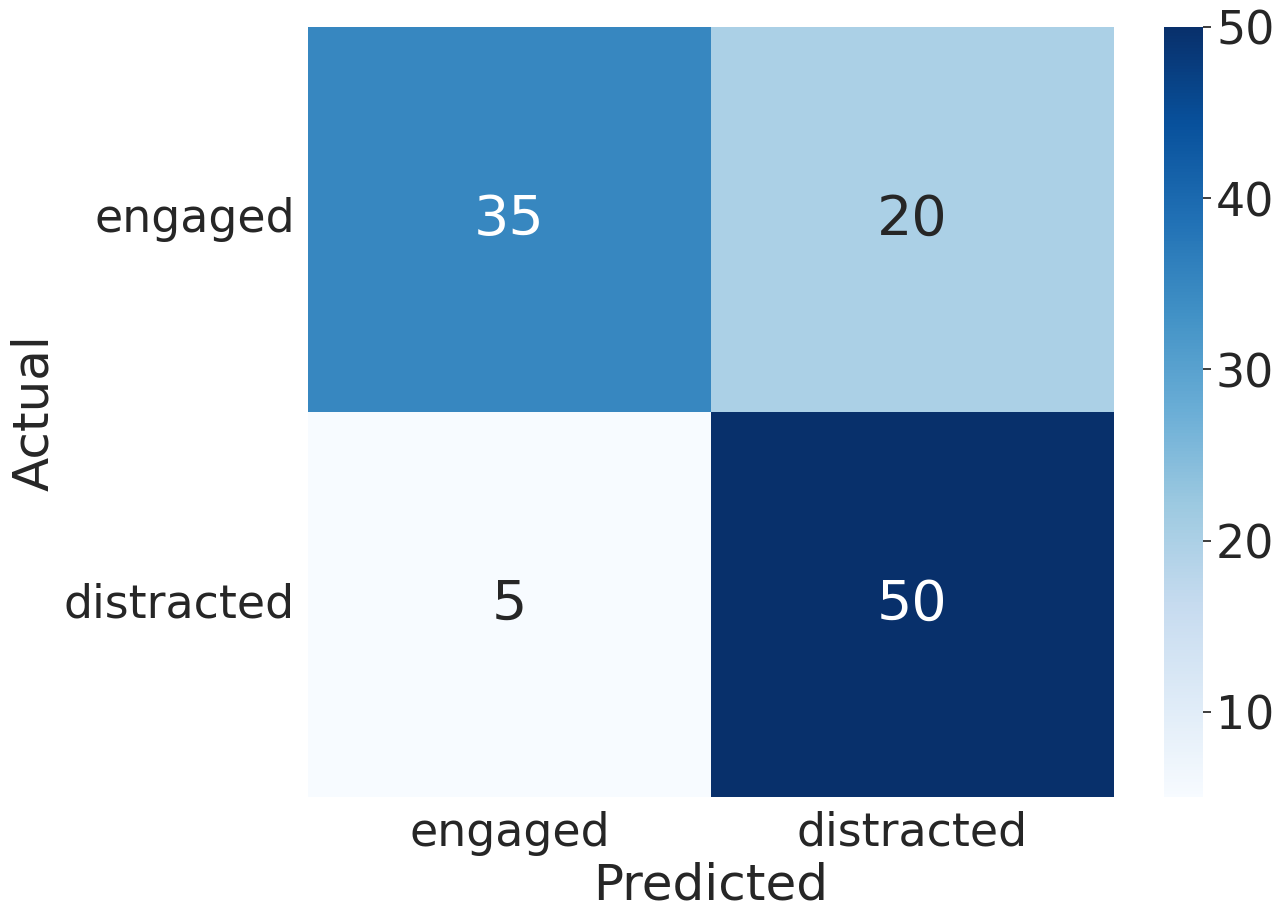

In [264]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [265]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 2048) (2,)
Epoch 1/20
1/1 [==============================] - 0s 11ms/step - loss: 5.0207 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 4.0646 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 1.3536 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1317 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0308 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0144 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0089

In [266]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [267]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [268]:
train_vid2features = all_train_vid2features

In [269]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [270]:
modelAtn, save_best_model = get_single_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [271]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_std_single_attention_concat_false_best


In [272]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [273]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.5454545454545454 Precision:  0.6666666666666666 F1:  0.6
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Katya_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333

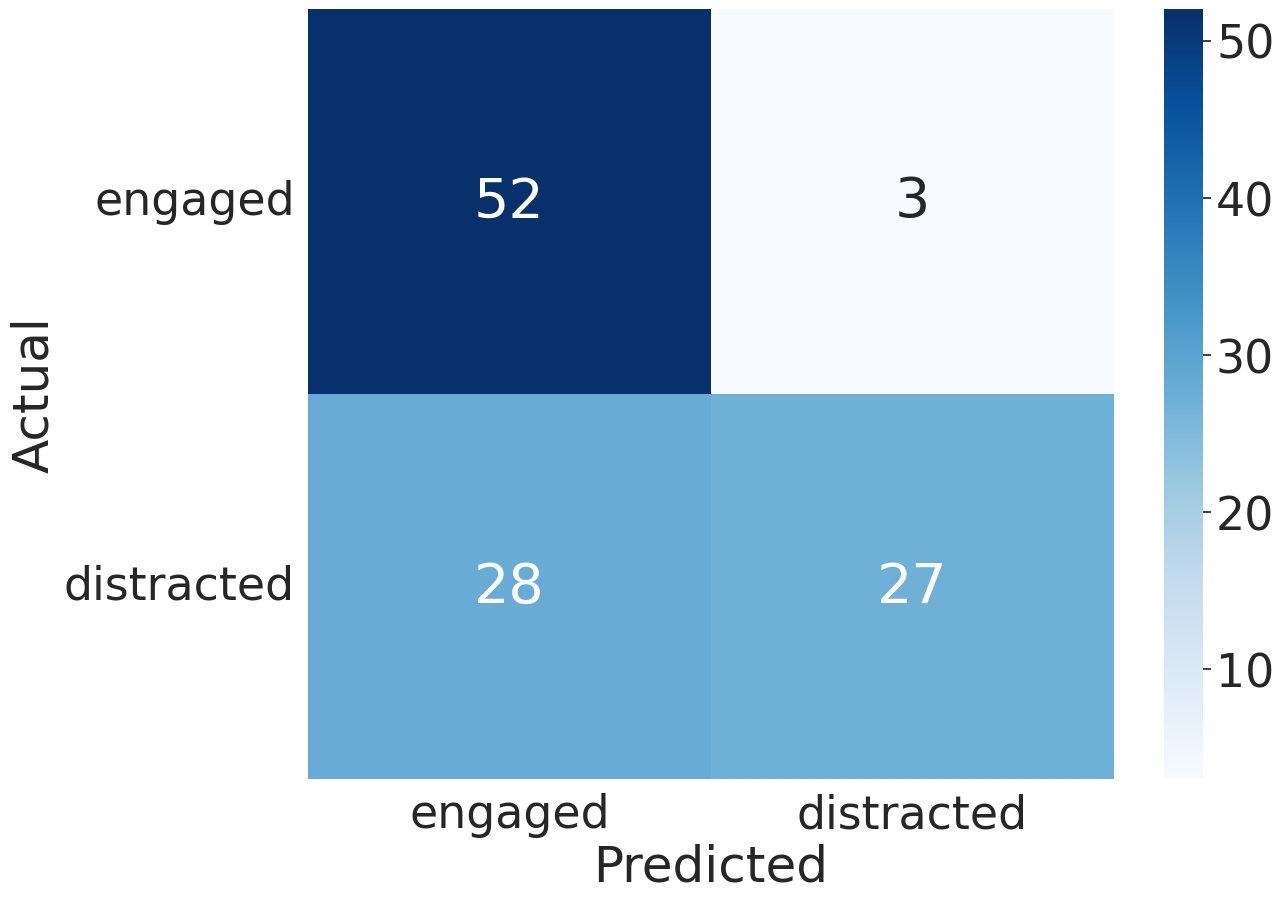

In [274]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [275]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Yana_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  1.0 Precision:  0.6470588235294118 F1:  0.7857142857142858
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Kate_adapted Accuracy:  0.5 MSE:  0.5 UAR:  0.5 Recall:  1.0 Precision:  0.5 F1:  0.6666666666666666
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_single_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.8636363636363636 Recall:  1.0 Precision:  0.78571428

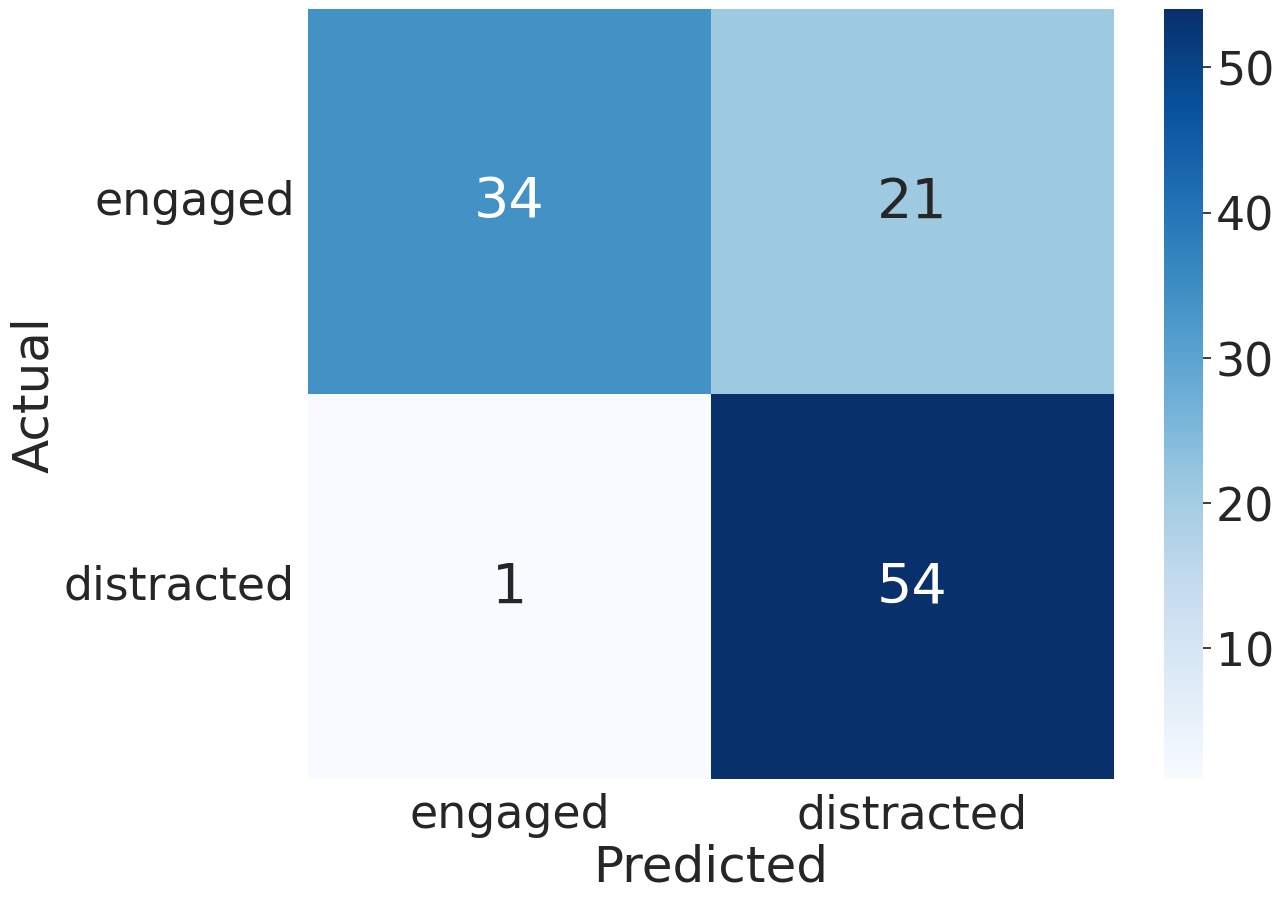

In [276]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [277]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.8818181818181818, MSE: 0.1181818181818182, UAR: 0.8818181818181818, Recall: 0.9454545454545455, Precision: 0.8850202429149798, F1: 0.9004761904761904
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.909090909090909, MSE: 0.09090909090909091, UAR: 0.909090909090909, Recall: 0.9636363636363636, Precision: 0.9157894736842106, F1: 0.9266666666666667
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.8727272727272727, MSE: 0.12727272727272726, UAR: 0.8727272727272727, Recall: 0.9090909090909092, Precision: 0.899122

In [278]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [279]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [280]:
train_vid2features = all_train_vid2features

In [281]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [282]:
train_vid2features = all_train_vid2features

In [283]:
modelAtn, save_best_model = get_self_attention(FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_9 (Attention)     (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [284]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_std_self_attention_concat_false_best


In [285]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [286]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Yana_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.45454545454545453 Precision:  0.8333333333333334 F1:  0.5882352941176471
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Kate_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181818 Recall:  0.45454545454545453 Precision:  0.8333333333333334 F1:  0.5882352941176471
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Katya_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Pre

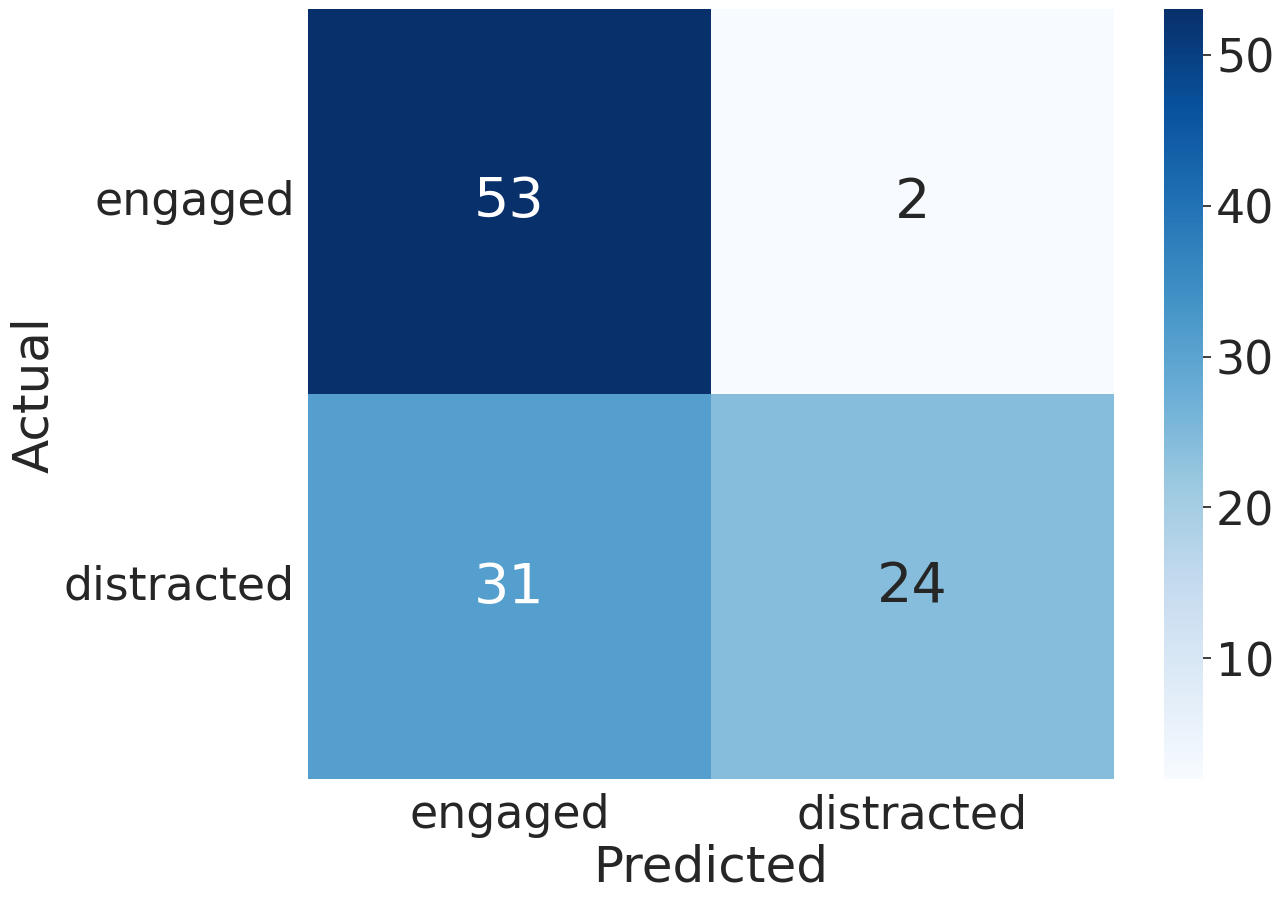

In [287]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [288]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Kate_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  1.0 Precision:  0.6111111111111112 F1:  0.7586206896551725
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Egor_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818182 Recall:  0.8181818181818182 Precision:  0.8181818181818182 F1:  0.8181818181818182
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_std_self_attention_concat_false_best_Katya_adapted Accuracy:  0.7727272727272727 MSE:  0.227272727272

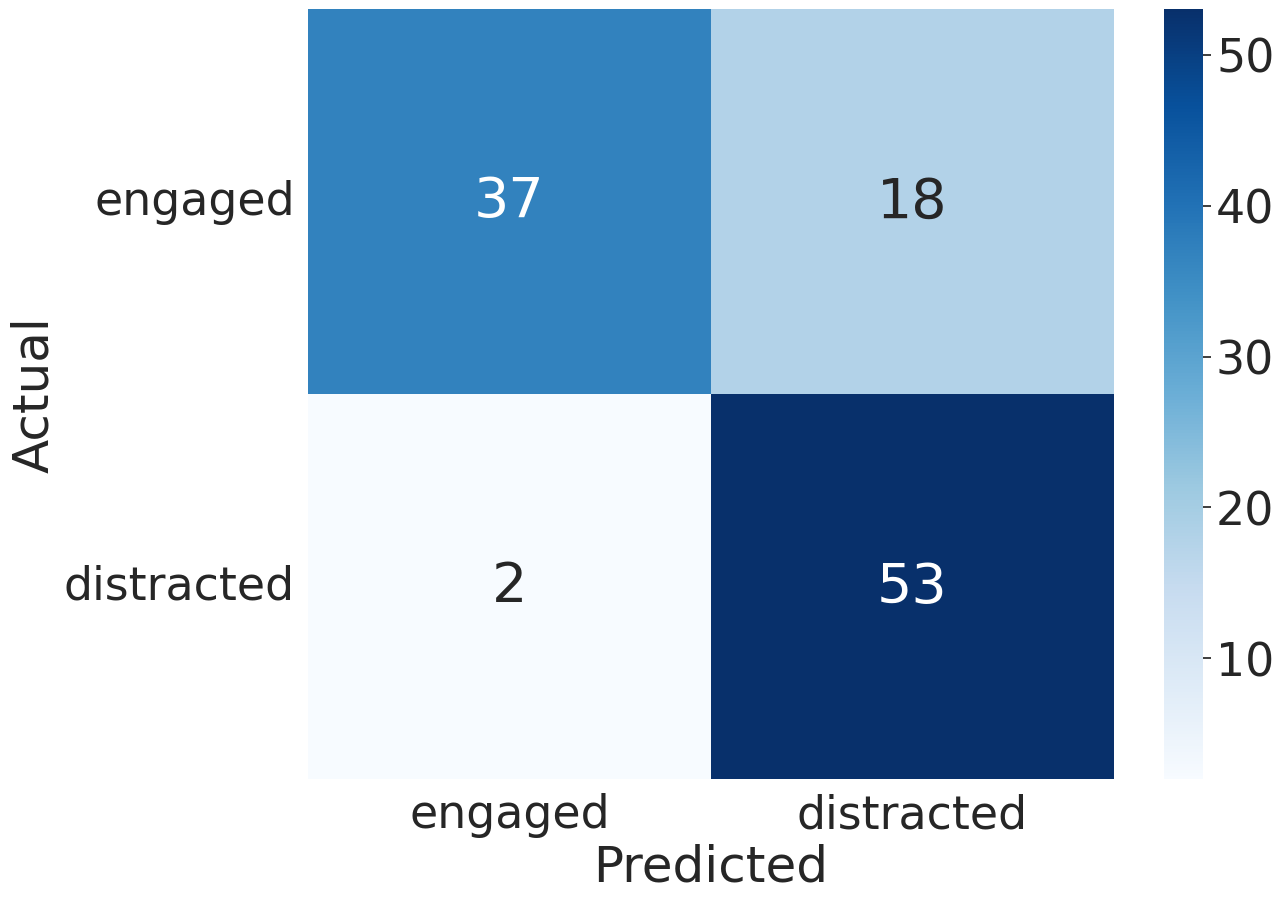

In [289]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [290]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 9ms/step - loss: 2.6858 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 1.9592 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.9186 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.3600 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2681 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2055 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - l

In [291]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

### STAT

In [292]:
stat_name = "STAT"
stat_func = compute_descriptor

#### Single attention

In [293]:
CONCATENATE_STAT = True
classificator_name = "single_attention_best"

In [294]:
train_vid2features = all_train_vid2features

In [295]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [296]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              3073      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [297]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_STAT_single_attention_best


In [298]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [299]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Yana_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Egor_universal Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  0.45454545454545453 Precision:  0.5555555555555556 F1:  0.5
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Katya_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.6363636363636364 Precision:  0.875 F1:  0.7368421052631579
Den : 22
Metric_

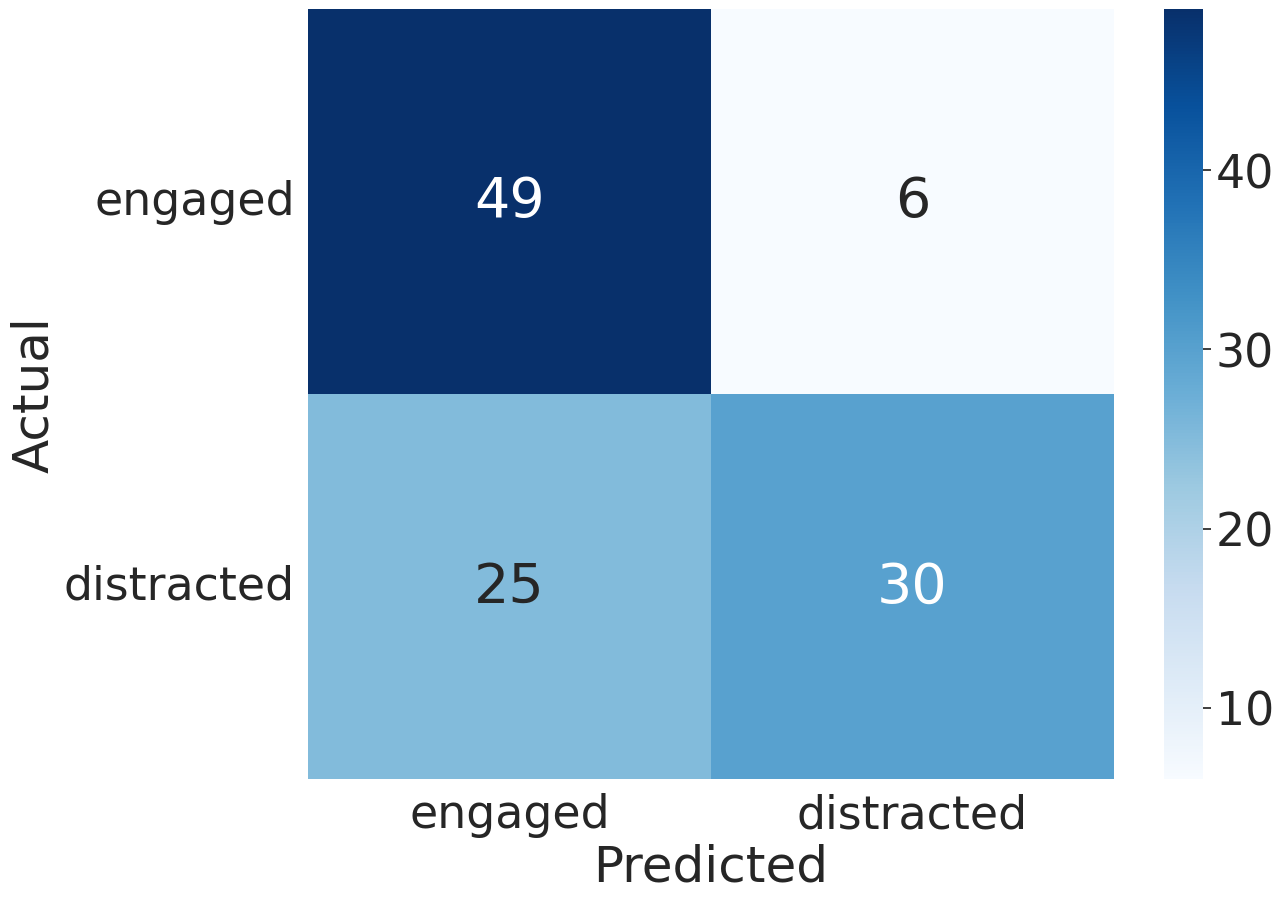

In [300]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [301]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1, callbacks=[save_best_model],
        #                                                 validation_data=(X_subsample_test,y_subsample_test))
        #best_model_weights = save_best_model.best_model_weights
        #modelAtn.set_weights(best_model_weights)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Egor_adapted Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  0.9090909090909091 Precision:  1.0 F1:  0.9523809523809523
Actor Katya
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_best_Katya_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909091 Recall:  0.90909090909

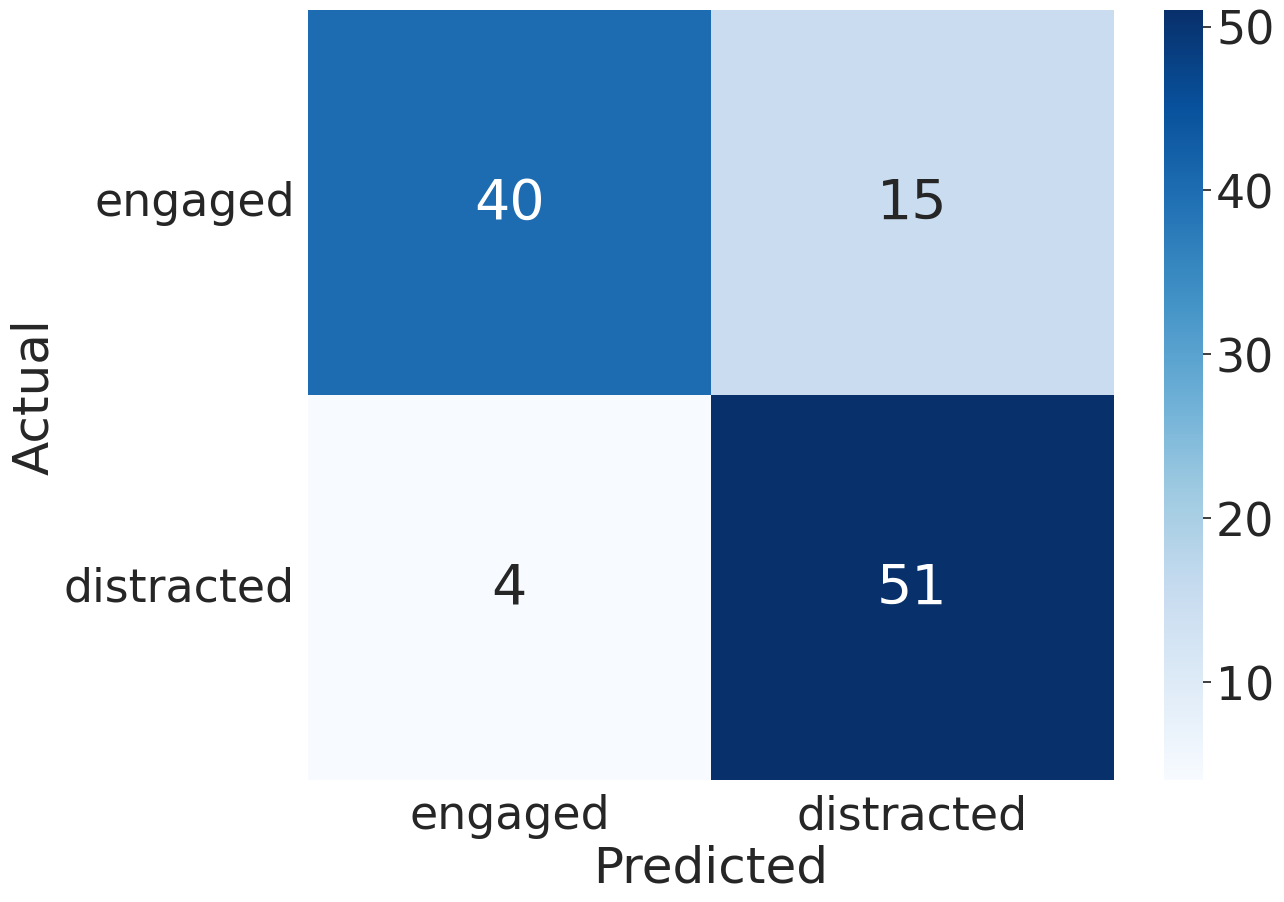

In [302]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [303]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3072) (2,)
		Actor Kate
(2, 70, 3072) (2,)
		Actor Egor
(2, 70, 3072) (2,)
		Actor Katya
(2, 70, 3072) (2,)
		Actor Den
(2, 70, 3072) (2,)
	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8727272727272727, Precision: 0.861183261183261, F1: 0.8411949808136422
Videos num:  2
		Actor Yana
(4, 70, 3072) (4,)
		Actor Kate
(4, 70, 3072) (4,)
		Actor Egor
(4, 70, 3072) (4,)
		Actor Katya
(4, 70, 3072) (4,)
		Actor Den
(4, 70, 3072) (4,)
	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.9090909090909092, Precision: 0.8671428571428571, F1: 0.8663565365025467
Videos num:  3
		Actor Yana
(6, 70, 3072) (6,)
		Actor Kate
(6, 70, 3072) (6,)
		Actor Egor
(6, 70, 3072) (6,)
		Actor Katya
(6, 70, 3072) (6,)
		Actor Den
(6, 70, 3072) (6,)
	Total, accuracy: 0.8363636363636363, MSE: 0.16363636363636364, UAR: 0.8363636363636363, Recall: 0.8363636363636363, Precision: 0.9099

In [304]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention

In [305]:
CONCATENATE_STAT = True
classificator_name = "self_attention_best"

In [306]:
train_vid2features = all_train_vid2features

In [307]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [308]:
train_vid2features = all_train_vid2features

In [309]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM, N_CLASSES)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 3072)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            1572864   ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            1572864   ['image_set[0][0]']           
                                                                                                  
 attention_10 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [310]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_STAT_self_attention_best


In [311]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [312]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Yana_universal Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.5454545454545454 Precision:  1.0 F1:  0.7058823529411764
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Kate_universal Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  0.7272727272727273 Precision:  0.8888888888888888 F1:  0.7999999999999999
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.5454545454545454 Precision:  0.6666666666666666 F1:  0.6
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Katya_universal Accuracy:  0.9545454545454546 MSE:  0.045454545454545456 UAR:  0.9545454545454546 Recall:  1.0 Precision:  0.9166666666666666 F1:  0.9565217391304348
Den : 22
Metric_name:  mob

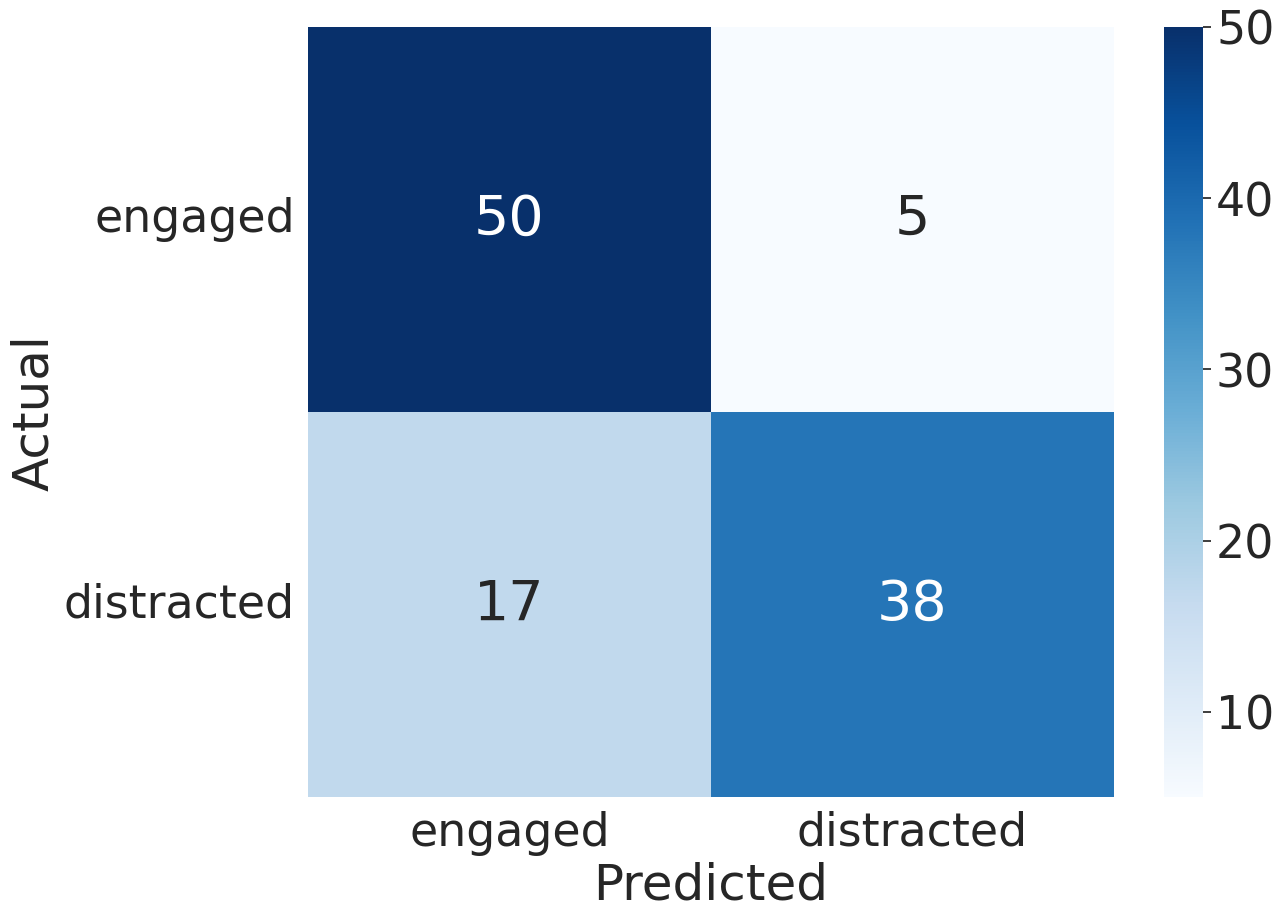

In [313]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [314]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  0.9090909090909091 Precision:  0.7142857142857143 F1:  0.8
Actor Kate
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Kate_adapted Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.9090909090909091 Precision:  0.6666666666666666 F1:  0.7692307692307692
Actor Egor
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Egor_adapted Accuracy:  0.45454545454545453 MSE:  0.5454545454545454 UAR:  0.45454545454545453 Recall:  0.45454545454545453 Precision:  0.45454545454545453 F1:  0.45454545454545453
Actor Katya
(10, 70, 3072) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.81818181818181

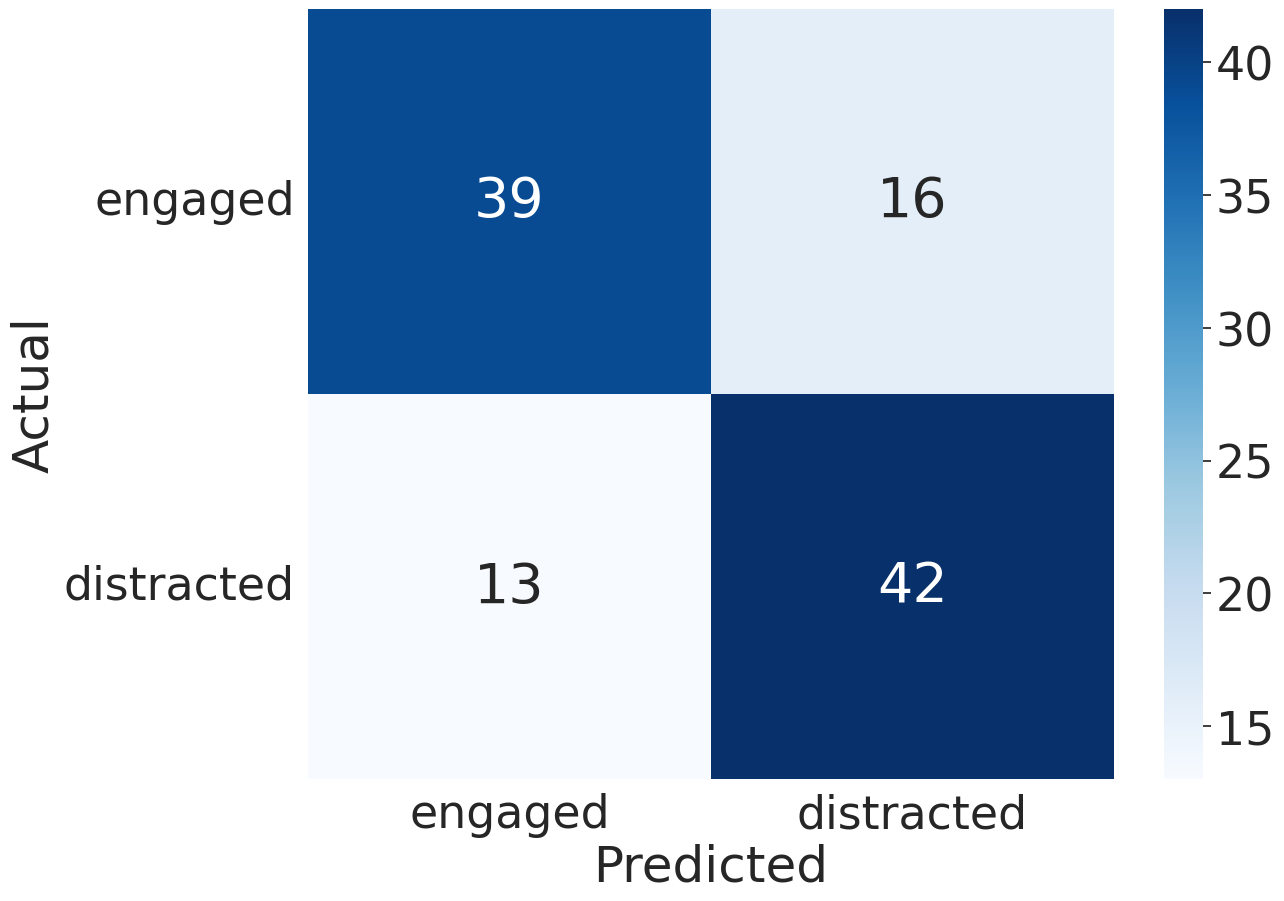

In [315]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [316]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 3072) (2,)
Epoch 1/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6419 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.2276 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1163 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0592 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0321 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0270 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0292 - precision: 1.0000 - r

/home/echuraev/anaconda3/envs/sciense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 8ms/step - loss: 0.0159 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 15/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0145 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 16/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0132 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 17/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0121 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 18/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0111 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 19/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0102 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 20/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0094 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
		Actor Katya
(2, 70, 307

In [317]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Single attention (concat = False)

In [318]:
CONCATENATE_STAT = False
classificator_name = "single_attention_concat_false_best"

In [319]:
train_vid2features = all_train_vid2features

In [320]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [321]:
modelAtn, save_best_model = get_single_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 e (Dense)                   (None, None, 1)              1025      ['image_set[0][0]']           
                                                                                                  
 alignment (Reshape)         (None, None)                 0         ['e[0][0]']                   
                                                                                                  
 alpha (Activation)          (None, None)                 0         ['alignment[0][0]']           
                                                                                           

##### Universal model

In [322]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_STAT_single_attention_concat_false_best


In [323]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [324]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Yana_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.36363636363636365 Precision:  0.8 F1:  0.5000000000000001
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Kate_universal Accuracy:  0.5909090909090909 MSE:  0.4090909090909091 UAR:  0.5909090909090909 Recall:  0.18181818181818182 Precision:  1.0 F1:  0.3076923076923077
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Egor_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.5454545454545454 Precision:  0.6666666666666666 F1:  0.6
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Katya_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  

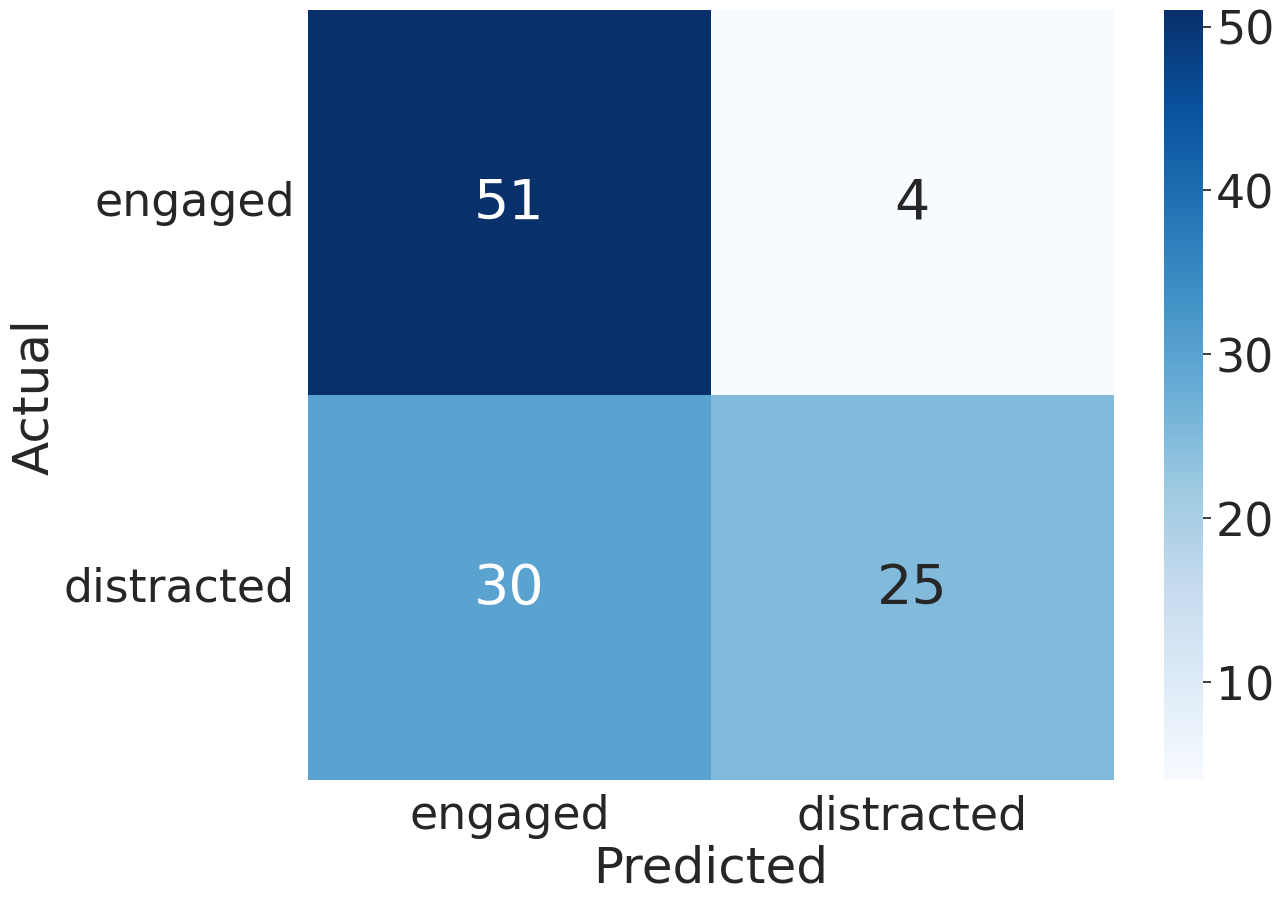

In [325]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [326]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Yana_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818181818181 Recall:  1.0 Precision:  0.7333333333333333 F1:  0.846153846153846
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Kate_adapted Accuracy:  0.5454545454545454 MSE:  0.45454545454545453 UAR:  0.5454545454545454 Recall:  1.0 Precision:  0.5238095238095238 F1:  0.6875000000000001
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Egor_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  0.8181818181818182 Precision:  1.0 F1:  0.9
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_single_attention_concat_false_best_Katya_adapted Accuracy:  0.8636363636363636 MSE:  0.13636363636363635 UAR:  0.863

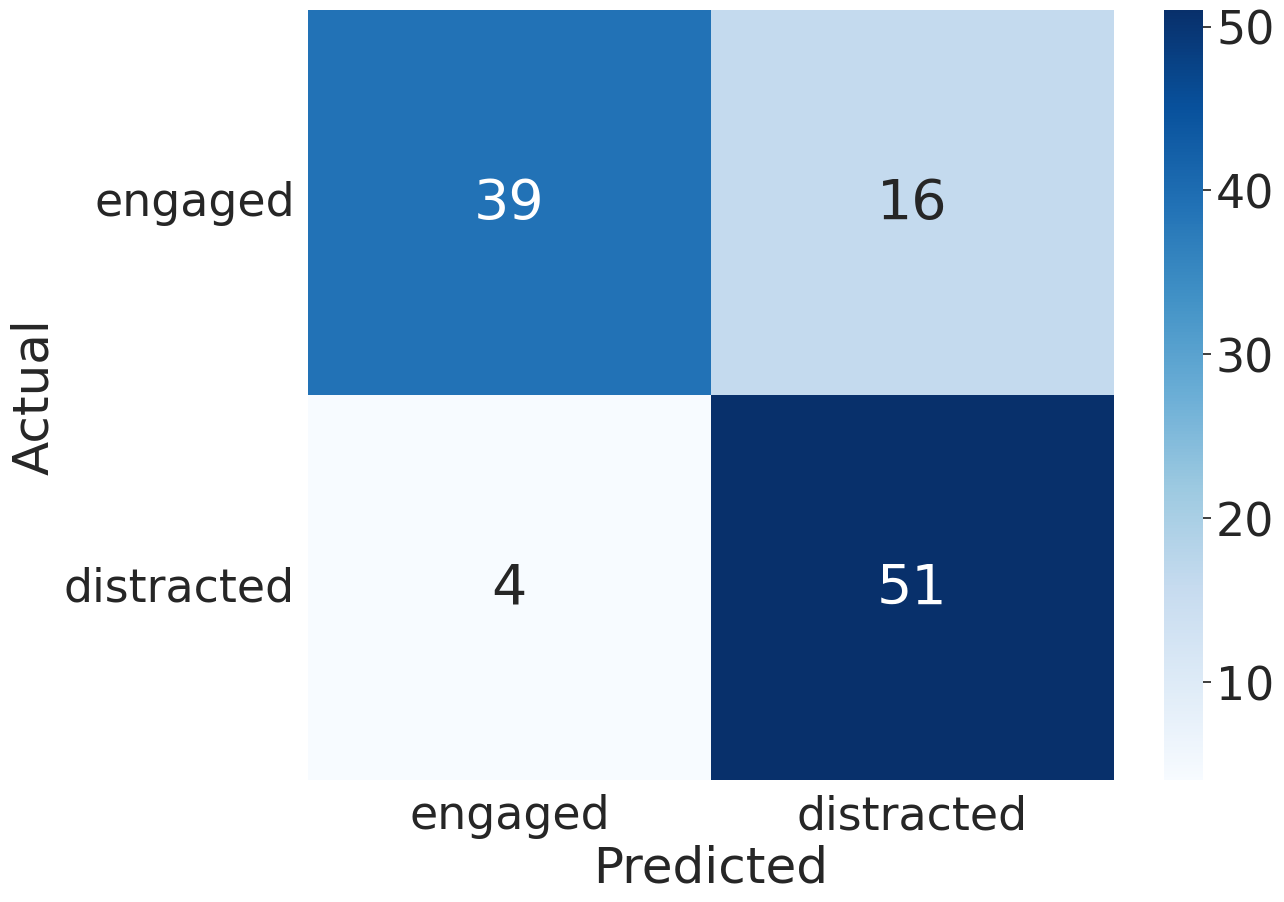

In [327]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [328]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
		Actor Kate
(2, 70, 1024) (2,)
		Actor Egor
(2, 70, 1024) (2,)
		Actor Katya
(2, 70, 1024) (2,)
		Actor Den
(2, 70, 1024) (2,)
	Total, accuracy: 0.9090909090909092, MSE: 0.09090909090909091, UAR: 0.9090909090909092, Recall: 0.8545454545454547, Precision: 0.9666666666666668, F1: 0.9023340961098398
Videos num:  2
		Actor Yana
(4, 70, 1024) (4,)
		Actor Kate
(4, 70, 1024) (4,)
		Actor Egor
(4, 70, 1024) (4,)
		Actor Katya
(4, 70, 1024) (4,)
		Actor Den
(4, 70, 1024) (4,)
	Total, accuracy: 0.8545454545454545, MSE: 0.14545454545454545, UAR: 0.8545454545454545, Recall: 0.8545454545454547, Precision: 0.9157894736842106, F1: 0.8655639097744361
Videos num:  3
		Actor Yana
(6, 70, 1024) (6,)
		Actor Kate
(6, 70, 1024) (6,)
		Actor Egor
(6, 70, 1024) (6,)
		Actor Katya
(6, 70, 1024) (6,)
		Actor Den
(6, 70, 1024) (6,)
	Total, accuracy: 0.8454545454545455, MSE: 0.15454545454545454, UAR: 0.8454545454545455, Recall: 0.8363636363636365, Precision: 0.915

In [329]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))

#### Self-attention (concat = False)

In [330]:
CONCATENATE_STAT = False
classificator_name = "self_attention_concat_false_best"

In [331]:
train_vid2features = all_train_vid2features

In [332]:
metric_name = metric_name = '{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
results_agg = {
    'metric_name': [
        metric_name + "_accuracy",
        metric_name + "_mse",
        metric_name + "_uar",
        metric_name + "_recall",
        metric_name + "_precision",
        metric_name + "_f1",
    ],
}
for i in range(TRAIN_VIDEOS_COUNT + 1):
    results_agg[str(i)] = []

In [333]:
train_vid2features = all_train_vid2features

In [334]:
modelAtn, save_best_model = get_self_attention(STAT_FEATURE_VECTOR_DIM_CONCAT_FALSE, N_CLASSES)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_set (InputLayer)      [(None, None, 1024)]         0         []                            
                                                                                                  
 query (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 value (Dense)               (None, None, 512)            524288    ['image_set[0][0]']           
                                                                                                  
 attention_11 (Attention)    (None, None, 512)            0         ['query[0][0]',               
                                                                     'value[0][0]']        

##### Universal model

In [335]:
universal_metric_name = get_universal_metric_name(base_model_key, DATASET_NAME, N_CLASSES, stat_name, classificator_name)
print(universal_metric_name)

mobilenet_7.h5_EngageWild_2_STAT_self_attention_concat_false_best


In [336]:
weights_name = get_universal_weights_path(universal_metric_name)
load_weights(modelAtn, weights_name)
model_weights = modelAtn.get_weights()

In [337]:
total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for k in test_vid2features.keys():
    print(k, ":", len(test_vid2features[k]['features']))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, k, "universal")
    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1
total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_universal'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg['0'] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Yana : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Yana_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Kate : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Kate_universal Accuracy:  0.7272727272727273 MSE:  0.2727272727272727 UAR:  0.7272727272727273 Recall:  0.45454545454545453 Precision:  1.0 F1:  0.625
Egor : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Egor_universal Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.8181818181818182 Precision:  0.6428571428571429 F1:  0.7200000000000001
Katya : 22
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Katya_universal Accuracy:  0.6363636363636364 MSE:  0.36363636363636365 UAR:  0.6363636363636364 Recall:  0.2727272727272727 Precision:  1.0 F1:  0.42857142857142855
D

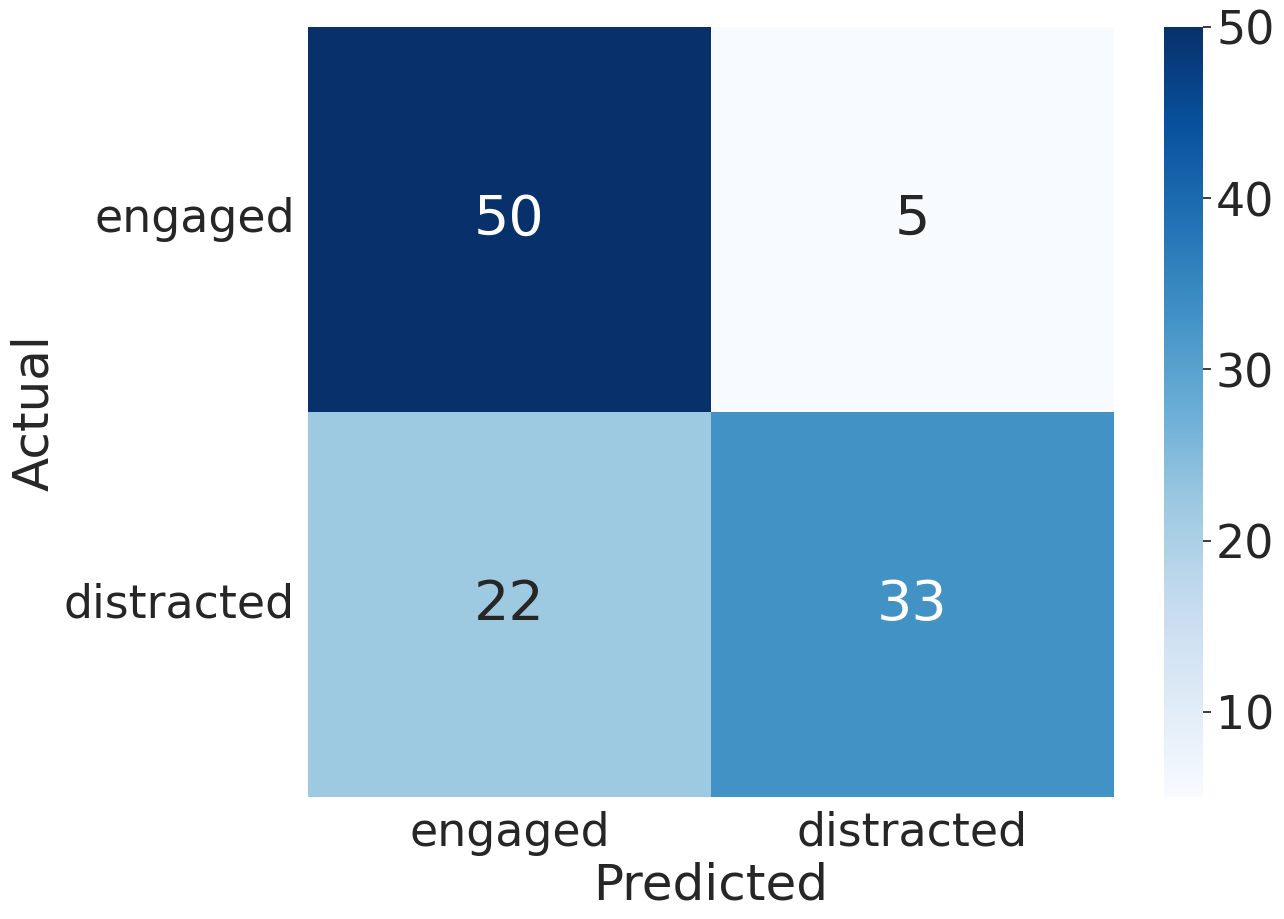

In [338]:
draw_confusion_matrix(all_preds, all_labels)

##### Universal model adaptation

In [339]:
from copy import deepcopy

total_acc = 0
total_mse = 0
total_uar = 0
total_recall = 0
total_precision = 0
total_f1 = 0
all_preds = []
all_labels = []
for actor in train_vid2features.keys():
    modelAtn.set_weights(deepcopy(model_weights))
    print("Actor {}".format(actor))
    metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, "adapted")
    X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
    #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
    #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
    #         validation_data=(X_subsample_test,y_subsample_test))
    weights_name = get_weights_path(metric_name)
    if os.path.isfile(weights_name):
        load_weights(modelAtn, weights_name)
    else:
        modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=0)
        save_weights(modelAtn, weights_name)

    pred = get_prediction(modelAtn, test_vid2features[k]['features'])

    #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
    acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name)
    all_preds.extend(pred)
    all_labels.extend(test_vid2features[k]['labels'])
    total_acc += acc
    total_mse += mse
    total_uar += uar
    total_recall += recall
    total_precision += precision
    total_f1 += f1

total_acc /= len(test_vid2features.keys())
total_mse /= len(test_vid2features.keys())
total_uar /= len(test_vid2features.keys())
total_recall /= len(test_vid2features.keys())
total_precision /= len(test_vid2features.keys())
total_f1 /= len(test_vid2features.keys())
print('Total, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
# if TABLE_NAME is not None:
#     metric_name = '{}_{}_{}_{}_all_adapted'.format(base_model_key, DATASET_NAME, stat_name, classificator_name)
#     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
results_agg[str(TRAIN_VIDEOS_COUNT)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Actor Yana
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Yana_adapted Accuracy:  0.7727272727272727 MSE:  0.22727272727272727 UAR:  0.7727272727272727 Recall:  1.0 Precision:  0.6875 F1:  0.8148148148148148
Actor Kate
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Kate_adapted Accuracy:  0.9090909090909091 MSE:  0.09090909090909091 UAR:  0.9090909090909092 Recall:  1.0 Precision:  0.8461538461538461 F1:  0.9166666666666666
Actor Egor
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Egor_adapted Accuracy:  0.6818181818181818 MSE:  0.3181818181818182 UAR:  0.6818181818181819 Recall:  0.36363636363636365 Precision:  1.0 F1:  0.5333333333333333
Actor Katya
(10, 70, 1024) (10,)
Metric_name:  mobilenet_7.h5_EngageWild_STAT_self_attention_concat_false_best_Katya_adapted Accuracy:  0.8181818181818182 MSE:  0.18181818181818182 UAR:  0.8181818

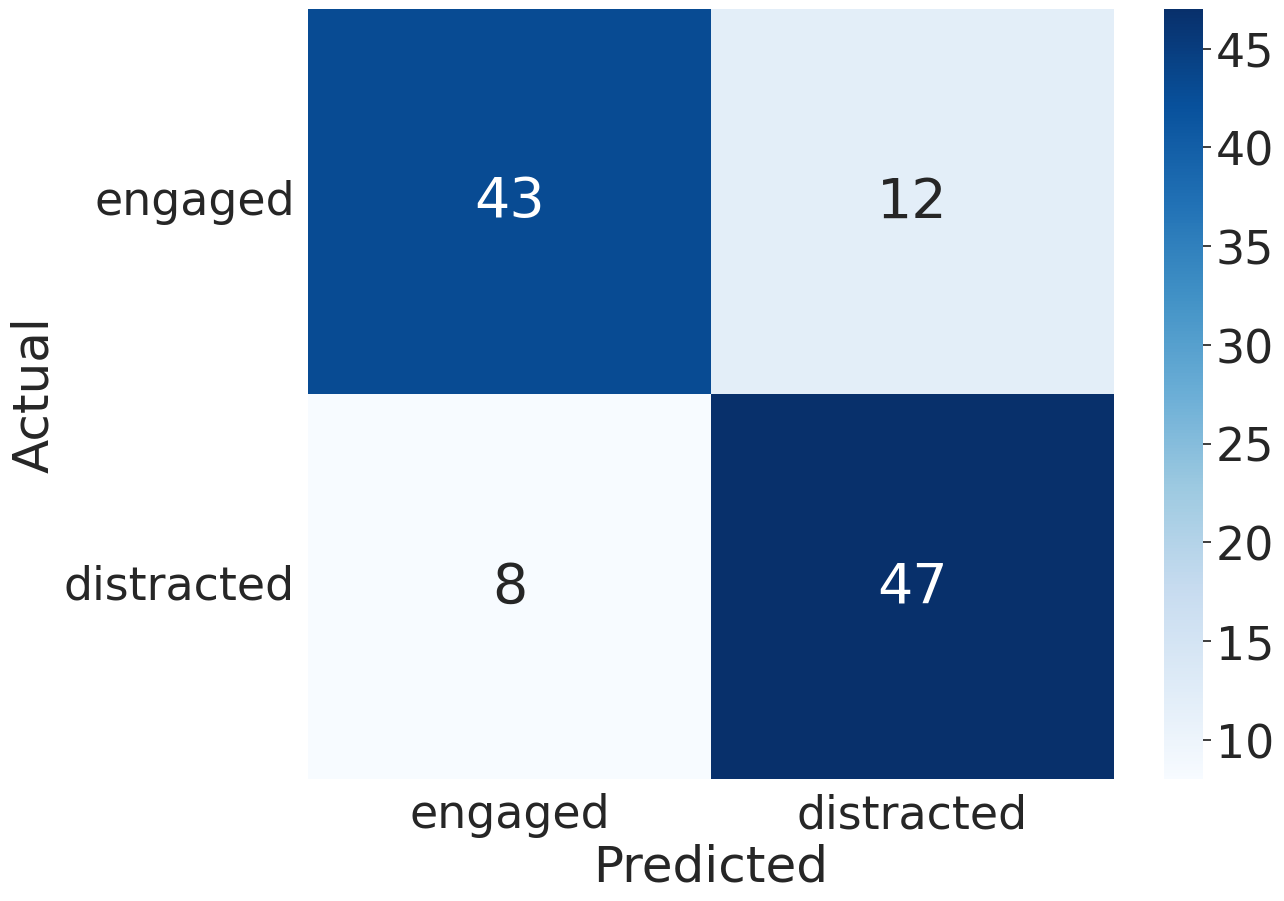

In [340]:
draw_confusion_matrix(all_preds, all_labels)

##### Adaptation by number of videos

In [341]:
from copy import deepcopy

for i in range(1, TRAIN_VIDEOS_COUNT):
    train_vid2features = take_to_sets(i, all_train_vid2features)
    total_acc = 0
    total_mse = 0
    total_uar = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    print("Videos num: ", i)
    for actor in train_vid2features.keys():
        modelAtn.set_weights(deepcopy(model_weights))
        print("\t\tActor {}".format(actor))
        metric_name = get_metric_name(base_model_key, DATASET_NAME, stat_name, classificator_name, actor, str(i))
        X_subsample_train,y_subsample_train=get_samples(train_vid2features[actor]['features'], train_vid2features[actor]['labels'])
        #X_subsample_test,y_subsample_test=get_samples(test_vid2features[actor]['features'], test_vid2features[actor]['labels'])
        #modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=64, epochs=EPOCH_NUM, verbose=0, callbacks=[save_best_model],
        #         validation_data=(X_subsample_test,y_subsample_test))

        weights_name = get_weights_path(metric_name)
        if os.path.isfile(weights_name):
            load_weights(modelAtn, weights_name)
        else:
            modelAtn.fit(X_subsample_train,y_subsample_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, verbose=1)
            save_weights(modelAtn, weights_name)
    
        pred = get_prediction(modelAtn, test_vid2features[k]['features'])
    
        #acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], table_name=TABLE_NAME, metric_name=metric_name)
        acc, mse, uar, recall, precision, f1 = print_results(pred, test_vid2features[k]['labels'], metric_name=metric_name, print_info=False)
        all_preds.extend(pred)
        all_labels.extend(test_vid2features[k]['labels'])
        total_acc += acc
        total_mse += mse
        total_uar += uar
        total_recall += recall
        total_precision += precision
        total_f1 += f1

    total_acc /= len(test_vid2features.keys())
    total_mse /= len(test_vid2features.keys())
    total_uar /= len(test_vid2features.keys())
    total_recall /= len(test_vid2features.keys())
    total_precision /= len(test_vid2features.keys())
    total_f1 /= len(test_vid2features.keys())
    print('\tTotal, accuracy: {}, MSE: {}, UAR: {}, Recall: {}, Precision: {}, F1: {}'.format(total_acc, total_mse, total_uar, total_recall, total_precision, total_f1))
    # if TABLE_NAME is not None:
    #     metric_name = '{}_{}_{}_{}_{}'.format(base_model_key, DATASET_NAME, stat_name, classificator_name, i)
    #     dump_to_table(TABLE_NAME, metric_name, total_acc, total_mse, total_uar, total_recall, total_precision, total_f1)
    results_agg[str(i)] = [total_acc, total_mse, total_uar, total_recall, total_precision, total_f1]

Videos num:  1
		Actor Yana
(2, 70, 1024) (2,)
Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9733 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.1661 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0641 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0383 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0294 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0234 - precision: 1.0000 - recall: 1.0000 - f1_score_metric: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0188 - precision: 1.0000 - r

In [342]:
dump_to_table(TABLE_NAME, result_agg_dict2lines(results_agg))